# Preprocessing

## Pacu

In [247]:
import os, sys
import pickle
import pandas as pd
import numpy as np

# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)



### input 설정
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


# vital data 저장 경로
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)


SRATE, f_num = 100, 0
for f_vital in f_vital_list[0:2000]:
    f_num += 1
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # ppg, ecg peaks 불러오기
    # peaks가 없는 경우는 ECG나 PPG data가 없는 case들
    if not os.path.exists(preprocess_path+'cache/PPG_peaks/'+f_vital):
        print('no existing PPG peaks: ', f_vital)
        continue
    if not os.path.exists(preprocess_path+'cache/ECG_peaks/'+f_vital):
        print('no existing ECG peaks: ', f_vital)
        continue
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
        
    ppg_min, ppg_peak = pickle.load(open(preprocess_path+'cache/PPG_peaks/'+f_vital, 'rb'))
    ecg_peak = pickle.load(open(preprocess_path+'cache/ECG_peaks/'+f_vital, 'rb'))
    
    ppg_min, ppg_peak = np.array([ppg_min]), np.array([ppg_peak])
    ecg_peak= np.array([ecg_peak])
    
    
    # 10초 단위로 끊기
    for i in range(n_aug):
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        seg_ppg, seg_ecg = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ppg[0:len(df_vital_input)] = df_vital_input['Pleth'].tolist()
        seg_ecg[0:len(df_vital_input)] = df_vital_input['ECG'].tolist()
    
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)
            
        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.3 or nan_ecg_perc > 0.3 or nan_both_perc > 0.2:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            continue
            
        

        ### 2. Noise 처리 ###
        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak[(start_idx<=ppg_peak) & (ppg_peak<end_idx)] - start_idx
        idx_ecg_peak = ecg_peak[(start_idx<=ecg_peak) & (ecg_peak<end_idx)] - start_idx
        
        # peak가 5개 이하는 noise가 많이 낀 상황 (10초 구간 중 peak가 7초 이상 없으면 문제 -> 즉 peak 개수 범위는 7/2 ~ 7/0.4)
        # 따라서 peak가 7초 이상 있어야하고 이때 최소 peak 개수는 3.5개 (20초면 7이하)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<=4/10*LEN_INPUT or len(idx_ecg_peak)<=4/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            continue

            
        # 10초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True
                
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 200
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])
        
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        
        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.1 and nan_ecg_perc < 0.1 and nan_both_perc < 0.2 and noise_ppg_perc < 0.3 and noise_ecg_perc < 0.3:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)        

    if f_num%1000 == 0:
        print('dumping cache of d_preprocess -', f_num, '/ 8318')
        pickle.dump(df_preprocess, open('cache/input3/df_preprocess_pacu_0-2000', 'wb'))
        
print('dumping cache of d_preprocess -', f_num, '/ 8318')
pickle.dump(df_preprocess, open('cache/input3/df_preprocess_pacu_0-2000', 'wb'))


###Input 1 / 8318: 3.0,249,PACU1_2_190503_132609.csv###
###Input 2 / 8318: 8.0,1444,PACU1_5_190723_131001.csv###
###Input 3 / 8318: 3.0,5650,PACU1_12_200604_165543.csv###
###Input 4 / 8318: 6.0,5450,PACU1_12_200528_152944.csv###
###Input 5 / 8318: 3.0,7909,PACU1_12_201008_143103.csv###
###Input 6 / 8318: 6.0,2882,PACU1_12_200109_150545.csv###
###Input 7 / 8318: 5.0,8045,PACU1_6_201016_093657.csv###
###Input 8 / 8318: 5.0,4027,PACU1_9_200225_093113.csv###
###Input 9 / 8318: 3.0,7238,PACU1_3_200827_194040.csv###
###Input 10 / 8318: 8.0,2271,PACU1_1_190909_143818.csv###
###Input 11 / 8318: 8.0,1895,PACU1_6_190828_082910.csv###
###Input 12 / 8318: 3.0,8130,PACU1_1_201020_220244.csv###
###Input 13 / 8318: 7.0,1406,PACU1_8_190722_124706.csv###
###Input 14 / 8318: 10.0,1119,PACU1_5_190710_164522.csv###
###Input 15 / 8318: 5.0,746,PACU1_2_190531_091955.csv###
###Input 16 / 8318: 6.0,599,PACU1_7_190524_091407.csv###
###Input 17 / 8318: 4.0,8255,PACU1_7_201027_110406.csv###
###Input 18 / 8318: 8

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


###Input 24 / 8318: 5.0,1330,PACU1_11_190718_145520.csv###
###Input 25 / 8318: 4.0,4785,PACU1_11_200325_125712.csv###
###Input 26 / 8318: 6.0,4395,PACU1_6_200310_121627.csv###
###Input 27 / 8318: 5.0,6936,PACU1_1_200810_122348.csv###
###Input 28 / 8318: 7.0,1281,PACU1_4_190717_172426.csv###
###Input 29 / 8318: 7.0,2364,PACU1_4_190912_000138.csv###
###Input 30 / 8318: 5.0,5145,PACU1_1_200514_144525.csv###
###Input 31 / 8318: 8.0,2927,PACU1_10_200110_130059.csv###
###Input 32 / 8318: 8.0,350,PACU1_3_190509_211631.csv###
###Input 33 / 8318: 9.0,1283,PACU1_5_190717_190617.csv###
###Input 34 / 8318: 3.0,3797,PACU1_2_200218_093808.csv###
###Input 35 / 8318: 5.0,3230,PACU1_6_200122_122323.csv###
###Input 36 / 8318: 5.0,1154,PACU1_2_190711_085132.csv###
###Input 37 / 8318: 9.0,7289,PACU1_2_200909_092156.csv###
###Input 38 / 8318: 3.0,3758,PACU1_2_200215_014656.csv###
###Input 39 / 8318: 6.0,1115,PACU1_2_190710_171004.csv###
###Input 40 / 8318: 6.0,209,PACU1_9_190502_142127.csv###
###Input 41 /

###Input 165 / 8318: 7.0,4229,PACU1_10_200303_162448.csv###
###Input 166 / 8318: 5.0,924,PACU1_3_190703_171251.csv###
###Input 167 / 8318: 5.0,6620,PACU1_6_200722_083316.csv###
###Input 168 / 8318: 3.0,7246,PACU1_1_200828_172552.csv###
###Input 169 / 8318: 8.0,2132,PACU1_7_190904_172040.csv###
###Input 170 / 8318: 3.0,874,PACU1_5_190612_163931.csv###
###Input 171 / 8318: 5.0,1512,PACU1_8_190816_152119.csv###
###Input 172 / 8318: 8.0,7221,PACU1_6_200825_095049.csv###
###Input 173 / 8318: 5.0,596,PACU1_4_190523_200356.csv###
###Input 174 / 8318: 4.0,7930,PACU1_1_201008_183613.csv###
###Input 175 / 8318: 5.0,5390,PACU1_2_200526_234216.csv###
###Input 176 / 8318: 5.0,3837,PACU1_11_200219_095754.csv###
###Input 177 / 8318: 8.0,2189,PACU1_7_190905_182232.csv###
###Input 178 / 8318: 5.0,3879,PACU1_8_200219_164737.csv###
###Input 179 / 8318: 5.0,1611,PACU1_2_190820_135649.csv###
###Input 180 / 8318: 7.0,6072,PACU1_12_200623_152304.csv###
###Input 181 / 8318: 4.0,1373,PACU1_7_190719_133554.csv#

###Input 304 / 8318: 6.0,3573,PACU1_11_200207_142904.csv###
###Input 305 / 8318: 5.0,7511,PACU1_3_200918_005602.csv###
###Input 306 / 8318: 5.0,1207,PACU1_3_190715_150624.csv###
###Input 307 / 8318: 5.0,6856,PACU1_7_200804_134606.csv###
###Input 308 / 8318: 6.0,3274,PACU1_3_200123_120538.csv###
###Input 309 / 8318: 5.0,4098,PACU1_7_200228_121855.csv###
###Input 310 / 8318: 3.0,8073,PACU1_4_201016_174655.csv###
###Input 311 / 8318: 5.0,6837,PACU1_12_200803_143028.csv###
###Input 312 / 8318: 7.0,3029,PACU1_2_200115_141012.csv###
###Input 313 / 8318: 4.0,3767,PACU1_5_200217_113708.csv###
###Input 314 / 8318: 4.0,2645,PACU1_5_191219_165854.csv###
###Input 315 / 8318: 6.0,385,PACU1_5_190513_153956.csv###
###Input 316 / 8318: 8.0,7245,PACU1_1_200828_144451.csv###
###Input 317 / 8318: 3.0,5626,PACU1_2_200604_090759.csv###
###Input 318 / 8318: 3.0,6634,PACU1_4_200722_125624.csv###
###Input 319 / 8318: 5.0,3271,PACU1_3_200123_120538.csv###
###Input 320 / 8318: 5.0,991,PACU1_11_190705_131344.csv

###Input 442 / 8318: 8.0,882,PACU1_1_190617_121710.csv###
###Input 443 / 8318: 7.0,2907,PACU1_4_200110_000846.csv###
###Input 444 / 8318: 5.0,3602,PACU1_5_200210_104932.csv###
###Input 445 / 8318: 5.0,5511,PACU1_3_200529_231452.csv###
###Input 446 / 8318: 3.0,7634,PACU1_6_200923_160908.csv###
###Input 447 / 8318: 6.0,1245,PACU1_1_190716_202834.csv###
###Input 448 / 8318: 3.0,1558,PACU1_10_190819_135024.csv###
###Input 449 / 8318: 8.0,2894,PACU1_2_200109_175440.csv###
###Input 450 / 8318: 6.0,3048,PACU1_9_200115_175359.csv###
###Input 451 / 8318: 5.0,3328,PACU1_3_200129_142528.csv###
###Input 452 / 8318: 7.0,5493,PACU1_11_200529_143500.csv###
###Input 453 / 8318: 6.0,1936,PACU1_5_190829_100712.csv###
###Input 454 / 8318: 6.0,3717,PACU1_2_200214_030259.csv###
###Input 455 / 8318: 4.0,319,PACU1_11_190509_095133.csv###
###Input 456 / 8318: 5.0,5126,PACU1_3_200513_213632.csv###
###Input 457 / 8318: 2.0,8220,PACU1_3_201024_122437.csv###
###Input 458 / 8318: 4.0,6962,PACU1_4_200811_115934.csv

###Input 581 / 8318: 5.0,752,PACU1_5_190531_101851.csv###
###Input 582 / 8318: 8.0,828,PACU1_3_190611_105333.csv###
###Input 583 / 8318: 2.0,2264,PACU1_10_190909_125533.csv###
###Input 584 / 8318: 2.0,4424,PACU1_3_200311_093245.csv###
###Input 585 / 8318: 5.0,5588,PACU1_9_200603_101036.csv###
###Input 586 / 8318: 2.0,1833,PACU1_5_190823_162702.csv###
###Input 587 / 8318: 6.0,6362,PACU1_3_200708_184828.csv###
###Input 588 / 8318: 3.0,1674,PACU1_3_190820_191402.csv###
###Input 589 / 8318: 10.0,6918,PACU1_6_200806_163447.csv###
###Input 590 / 8318: 8.0,2705,PACU1_8_200102_125258.csv###
###Input 591 / 8318: 8.0,3832,PACU1_6_200219_090110.csv###
###Input 592 / 8318: 5.0,3272,PACU1_5_200123_115000.csv###
###Input 593 / 8318: 4.0,6356,PACU1_7_200708_160355.csv###
###Input 594 / 8318: 4.0,4851,PACU1_8_200327_132531.csv###
###Input 595 / 8318: 5.0,8056,PACU1_9_201016_123439.csv###
###Input 596 / 8318: 3.0,931,PACU1_2_190703_215330.csv###
###Input 597 / 8318: 5.0,1647,PACU1_8_190820_163302.csv##

###Input 718 / 8318: 8.0,7422,PACU1_9_200916_092132.csv###
###Input 719 / 8318: 8.0,4494,PACU1_9_200313_135235.csv###
###Input 720 / 8318: 4.0,1549,PACU1_1_190816_184851.csv###
###Input 721 / 8318: 4.0,5252,PACU1_11_200519_170333.csv###
###Input 722 / 8318: 7.0,1790,PACU1_11_190822_145331.csv###
###Input 723 / 8318: 6.0,1463,PACU1_3_190723_195127.csv###
###Input 724 / 8318: 7.0,4234,PACU1_5_200303_195155.csv###
###Input 725 / 8318: 3.0,1570,PACU1_3_190819_205959.csv###
###Input 726 / 8318: 3.0,5436,PACU1_3_200528_113953.csv###
###Input 727 / 8318: 8.0,6034,PACU1_11_200619_153347.csv###
###Input 728 / 8318: 2.0,1521,PACU1_1_190816_154204.csv###
###Input 729 / 8318: 2.0,6741,PACU1_11_200728_132208.csv###
###Input 730 / 8318: 5.0,1088,PACU1_9_190710_093206.csv###
###Input 731 / 8318: 5.0,2179,PACU1_4_190905_150215.csv###
###Input 732 / 8318: 8.0,3139,PACU1_9_200120_121646.csv###
###Input 733 / 8318: 6.0,988,PACU1_11_190705_131344.csv###
###Input 734 / 8318: 7.0,4501,PACU1_7_200313_151802.

###Input 857 / 8318: 4.0,1052,PACU1_4_190709_112306.csv###
###Input 858 / 8318: 3.0,2829,PACU1_7_200108_090440.csv###
###Input 859 / 8318: 5.0,765,PACU1_5_190531_144225.csv###
###Input 860 / 8318: 3.0,527,PACU1_5_190516_174457.csv###
###Input 861 / 8318: 5.0,4533,PACU1_7_200316_154805.csv###
###Input 862 / 8318: 5.0,2554,PACU1_2_191113_114438.csv###
###Input 863 / 8318: 7.0,6361,PACU1_3_200708_184828.csv###
###Input 864 / 8318: 5.0,1588,PACU1_6_190820_105347.csv###
###Input 865 / 8318: 7.0,8123,PACU1_5_201020_171155.csv###
###Input 866 / 8318: 4.0,1390,PACU1_3_190719_154655.csv###
###Input 867 / 8318: 3.0,7206,PACU1_3_200821_223504.csv###
###Input 868 / 8318: 5.0,8081,PACU1_3_201019_094609.csv###
###Input 869 / 8318: 4.0,5767,PACU1_12_200610_094140.csv###
###Input 870 / 8318: 4.0,5195,PACU1_6_200515_165154.csv###
###Input 871 / 8318: 2.0,4947,PACU1_1_200506_135811.csv###
###Input 872 / 8318: 3.0,8269,PACU1_5_201027_151403.csv###
###Input 873 / 8318: 8.0,2479,PACU1_3_191021_093930.csv##

###Input 995 / 8318: 4.0,5615,PACU1_10_200603_164857.csv###
###Input 996 / 8318: 8.0,6348,PACU1_5_200708_142001.csv###
###Input 997 / 8318: 5.0,7715,PACU1_8_200925_162959.csv###
###Input 998 / 8318: 6.0,1159,PACU1_6_190712_083200.csv###
###Input 999 / 8318: 7.0,643,PACU1_4_190527_165508.csv###
###Input 1000 / 8318: 5.0,1853,PACU1_1_190827_103157.csv###
dumping cache of d_preprocess - 1000 / 8318
###Input 1001 / 8318: 6.0,5017,PACU1_5_200508_130334.csv###
###Input 1002 / 8318: 6.0,5530,PACU1_5_200601_142745.csv###
###Input 1003 / 8318: 8.0,2587,PACU1_9_191128_144712.csv###
###Input 1004 / 8318: 2.0,5979,PACU1_8_200617_155220.csv###
###Input 1005 / 8318: 3.0,4794,PACU1_3_200325_152610.csv###
###Input 1006 / 8318: 3.0,3283,PACU1_3_200123_162554.csv###
###Input 1007 / 8318: 9.0,3747,PACU1_1_200214_181636.csv###
###Input 1008 / 8318: 6.0,3135,PACU1_3_200120_100745.csv###
###Input 1009 / 8318: 8.0,4799,PACU1_9_200325_171903.csv###
###Input 1010 / 8318: 7.0,5407,PACU1_9_200527_133938.csv###
#

###Input 1131 / 8318: 7.0,612,PACU1_7_190524_125100.csv###
no existing PPG peaks:  7.0,612,PACU1_7_190524_125100.csv
###Input 1132 / 8318: 6.0,1422,PACU1_3_190723_052629.csv###
###Input 1133 / 8318: 7.0,3186,PACU1_6_200121_170016.csv###
###Input 1134 / 8318: 7.0,6015,PACU1_7_200618_171846.csv###
###Input 1135 / 8318: 6.0,2139,PACU1_4_190904_213656.csv###
###Input 1136 / 8318: 4.0,3443,PACU1_8_200204_114900.csv###
###Input 1137 / 8318: 4.0,3604,PACU1_3_200210_112555.csv###
###Input 1138 / 8318: 7.0,648,PACU1_3_190528_000714.csv###
###Input 1139 / 8318: 5.0,6937,PACU1_6_200810_142429.csv###
###Input 1140 / 8318: 9.0,4802,PACU1_6_200325_180343.csv###
###Input 1141 / 8318: 7.0,2888,PACU1_1_200109_162237.csv###
###Input 1142 / 8318: 4.0,4205,PACU1_5_200302_200759.csv###
###Input 1143 / 8318: 5.0,7663,PACU1_1_200924_114932.csv###
###Input 1144 / 8318: 5.0,4980,PACU1_6_200507_161903.csv###
###Input 1145 / 8318: 4.0,6782,PACU1_1_200730_115233.csv###
###Input 1146 / 8318: 3.0,577,PACU1_4_190523

###Input 1267 / 8318: 8.0,3053,PACU1_1_200115_235547.csv###
###Input 1268 / 8318: 8.0,546,PACU1_3_190517_120132.csv###
###Input 1269 / 8318: 5.0,586,PACU1_4_190523_164213.csv###
###Input 1270 / 8318: 5.0,3422,PACU1_7_200203_141134.csv###
###Input 1271 / 8318: 7.0,4649,PACU1_5_200318_202045.csv###
###Input 1272 / 8318: 5.0,993,PACU1_11_190705_131344.csv###
###Input 1273 / 8318: 4.0,1715,PACU1_2_190821_115808.csv###
###Input 1274 / 8318: 4.0,5098,PACU1_2_200512_231841.csv###
###Input 1275 / 8318: 5.0,8191,PACU1_5_201022_140109.csv###
###Input 1276 / 8318: 5.0,2158,PACU1_3_190905_113119.csv###
###Input 1277 / 8318: 8.0,6058,PACU1_4_200622_202654.csv###
###Input 1278 / 8318: 5.0,5583,PACU1_1_200603_085151.csv###
###Input 1279 / 8318: 6.0,8050,PACU1_4_201016_121452.csv###
###Input 1280 / 8318: 8.0,3090,PACU1_3_200117_000917.csv###
###Input 1281 / 8318: 3.0,1232,PACU1_5_190716_125505.csv###
###Input 1282 / 8318: 3.0,4478,PACU1_4_200312_204007.csv###
###Input 1283 / 8318: 3.0,3387,PACU1_2_200

###Input 1404 / 8318: 4.0,784,PACU1_6_190603_093744.csv###
###Input 1405 / 8318: 8.0,2344,PACU1_7_190911_131655.csv###
###Input 1406 / 8318: 8.0,3627,PACU1_3_200210_212804.csv###
###Input 1407 / 8318: 3.0,3757,PACU1_2_200215_014656.csv###
###Input 1408 / 8318: 8.0,3089,PACU1_3_200117_000917.csv###
###Input 1409 / 8318: 6.0,444,PACU1_11_190514_165036.csv###
###Input 1410 / 8318: 3.0,1561,PACU1_8_190819_140625.csv###
###Input 1411 / 8318: 7.0,411,PACU1_4_190514_113852.csv###
###Input 1412 / 8318: 4.0,2879,PACU1_3_200109_124545.csv###
###Input 1413 / 8318: 5.0,6256,PACU1_2_200703_092105.csv###
###Input 1414 / 8318: 4.0,5693,PACU1_8_200605_163631.csv###
###Input 1415 / 8318: 4.0,1061,PACU1_7_190709_140636.csv###
###Input 1416 / 8318: 4.0,1184,PACU1_4_190712_164052.csv###
###Input 1417 / 8318: 5.0,2520,PACU1_7_191023_123318.csv###
###Input 1418 / 8318: 8.0,5193,PACU1_10_200515_165624.csv###
###Input 1419 / 8318: 7.0,960,PACU1_12_190704_164600.csv###
###Input 1420 / 8318: 4.0,2878,PACU1_7_20

###Input 1541 / 8318: 4.0,1254,PACU1_5_190717_082658.csv###
###Input 1542 / 8318: 3.0,2696,PACU1_3_200102_100649.csv###
###Input 1543 / 8318: 7.0,4077,PACU1_3_200228_001842.csv###
###Input 1544 / 8318: 7.0,1030,PACU1_5_190708_180445.csv###
###Input 1545 / 8318: 3.0,6187,PACU1_6_200630_142911.csv###
###Input 1546 / 8318: 8.0,1333,PACU1_9_190718_154644.csv###
###Input 1547 / 8318: 3.0,5347,PACU1_1_200525_161225.csv###
###Input 1548 / 8318: 4.0,291,PACU1_3_190505_210427.csv###
###Input 1549 / 8318: 6.0,2322,PACU1_6_190910_173346.csv###
###Input 1550 / 8318: 5.0,748,PACU1_1_190531_092308.csv###
###Input 1551 / 8318: 9.0,4066,PACU1_9_200227_172002.csv###
###Input 1552 / 8318: 3.0,3908,PACU1_4_200220_160451.csv###
###Input 1553 / 8318: 4.0,4923,PACU1_10_200331_165136.csv###
###Input 1554 / 8318: 5.0,5070,PACU1_1_200512_102246.csv###
###Input 1555 / 8318: 6.0,5804,PACU1_7_200611_105257.csv###
###Input 1556 / 8318: 6.0,4220,PACU1_6_200303_123252.csv###
###Input 1557 / 8318: 5.0,855,PACU1_5_190

###Input 1677 / 8318: 2.0,5177,PACU1_1_200515_133304.csv###
###Input 1678 / 8318: 5.0,439,PACU1_3_190514_162201.csv###
###Input 1679 / 8318: 3.0,2401,PACU1_5_190917_164400.csv###
###Input 1680 / 8318: 6.0,2977,PACU1_5_200113_191451.csv###
###Input 1681 / 8318: 6.0,2665,PACU1_1_191223_155705.csv###
###Input 1682 / 8318: 9.0,2597,PACU1_1_191203_215005.csv###
###Input 1683 / 8318: 3.0,234,PACU1_6_190503_090717.csv###
###Input 1684 / 8318: 3.0,2199,PACU1_1_190906_085600.csv###
###Input 1685 / 8318: 6.0,6392,PACU1_3_200710_163122.csv###
###Input 1686 / 8318: 8.0,4678,PACU1_4_200319_193541.csv###
###Input 1687 / 8318: 10.0,688,PACU1_6_190529_082821.csv###
###Input 1688 / 8318: 7.0,2491,PACU1_3_191021_160814.csv###
###Input 1689 / 8318: 9.0,6966,PACU1_2_200811_124816.csv###
###Input 1690 / 8318: 4.0,5010,PACU1_9_200508_114612.csv###
###Input 1691 / 8318: 4.0,2760,PACU1_5_200103_145348.csv###
###Input 1692 / 8318: 5.0,3811,PACU1_3_200218_154242.csv###
###Input 1693 / 8318: 4.0,7762,PACU1_4_200

###Input 1814 / 8318: 5.0,4944,PACU1_6_200504_142621.csv###
###Input 1815 / 8318: 3.0,24,PACU1_2_190410_191639.csv###
###Input 1816 / 8318: 2.0,6455,PACU1_3_200715_094143.csv###
###Input 1817 / 8318: 2.0,1553,PACU1_3_190819_082733.csv###
###Input 1818 / 8318: 5.0,6252,PACU1_5_200702_181420.csv###
###Input 1819 / 8318: 5.0,7111,PACU1_1_200819_145226.csv###
###Input 1820 / 8318: 2.0,3950,PACU1_1_200221_121631.csv###
###Input 1821 / 8318: 5.0,8181,PACU1_7_201022_102105.csv###
###Input 1822 / 8318: 3.0,2955,PACU1_7_200113_094954.csv###
###Input 1823 / 8318: 3.0,5635,PACU1_4_200604_110216.csv###
###Input 1824 / 8318: 4.0,4442,PACU1_8_200311_134715.csv###
###Input 1825 / 8318: 5.0,5277,PACU1_10_200520_122755.csv###
###Input 1826 / 8318: 6.0,7734,PACU1_3_200928_145817.csv###
###Input 1827 / 8318: 9.0,1305,PACU1_7_190718_114824.csv###
###Input 1828 / 8318: 5.0,2326,PACU1_4_190910_180102.csv###
###Input 1829 / 8318: 6.0,777,PACU1_4_190531_192901.csv###
###Input 1830 / 8318: 4.0,7607,PACU1_6_200

###Input 1950 / 8318: 5.0,2403,PACU1_3_190917_173755.csv###
###Input 1951 / 8318: 3.0,1188,PACU1_10_190712_185226.csv###
###Input 1952 / 8318: 5.0,7833,PACU1_2_201006_183602.csv###
###Input 1953 / 8318: 5.0,8367,PACU1_11_201030_143744.csv###
###Input 1954 / 8318: 5.0,1763,PACU1_1_190821_201207.csv###
###Input 1955 / 8318: 6.0,1225,PACU1_3_190716_095311.csv###
###Input 1956 / 8318: 6.0,2789,PACU1_6_200106_171021.csv###
###Input 1957 / 8318: 6.0,4957,PACU1_2_200507_002522.csv###
###Input 1958 / 8318: 6.0,1060,PACU1_1_190709_130101.csv###
###Input 1959 / 8318: 6.0,6172,PACU1_3_200629_194734.csv###
###Input 1960 / 8318: 4.0,8182,PACU1_7_201022_115230.csv###
###Input 1961 / 8318: 7.0,3487,PACU1_8_200205_120101.csv###
###Input 1962 / 8318: 7.0,245,PACU1_4_190503_115752.csv###
###Input 1963 / 8318: 6.0,6129,PACU1_6_200625_163959.csv###
###Input 1964 / 8318: 3.0,1321,PACU1_6_190718_135114.csv###
###Input 1965 / 8318: 4.0,2862,PACU1_1_200109_095159.csv###
###Input 1966 / 8318: 5.0,169,PACU1_10_

## Preop

In [3]:
# input 설정
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


# vital data 저장 경로
vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
f_vital_list = os.listdir(vital_path)

# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)


SRATE, f_num = 100, 1000
for f_vital in f_vital_list[1000:2000]:
    f_num += 1
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # ppg, ecg peaks 불러오기
    # peaks가 없는 경우는 ECG나 PPG data가 없는 case들
    if not os.path.exists('../../cranberry2/Preprocessing/cache/PPG_peaks/'+f_vital):
        print('no existing PPG peaks: ', f_vital)
        continue
    if not os.path.exists('../../cranberry2/Preprocessing/cache/ECG_peaks/'+f_vital):
        print('no existing ECG peaks: ', f_vital)
        continue
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
        
    ppg_min, ppg_peak = pickle.load(open('../../cranberry2/Preprocessing/cache/PPG_peaks/'+f_vital, 'rb'))
    ecg_peak = pickle.load(open('../../cranberry2/Preprocessing/cache/ECG_peaks/'+f_vital, 'rb'))
    
    ppg_min, ppg_peak = np.array([ppg_min]), np.array([ppg_peak])
    ecg_peak= np.array([ecg_peak])
    
    
    # 10초 단위로 끊기
    for i in range(n_aug):
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        seg_ppg, seg_ecg = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ppg[0:len(df_vital_input)] = df_vital_input['Pleth'].tolist()
        seg_ecg[0:len(df_vital_input)] = df_vital_input['ECG'].tolist()
    
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)
            
        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.3 or nan_ecg_perc > 0.3 or nan_both_perc > 0.2:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            continue
            
        

        ### 2. Noise 처리 ###
        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak[(start_idx<=ppg_peak) & (ppg_peak<end_idx)] - start_idx
        idx_ecg_peak = ecg_peak[(start_idx<=ecg_peak) & (ecg_peak<end_idx)] - start_idx
        
        # peak가 5개 이하는 noise가 많이 낀 상황 (10초 구간 중 peak가 7초 이상 없으면 문제 -> 즉 peak 개수 범위는 7/2 ~ 7/0.4)
        # 따라서 peak가 7초 이상 있어야하고 이때 최소 peak 개수는 3.5개
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<=4 or len(idx_ecg_peak)<=4:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            continue

            
        # 10초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 40 < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 200:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 40 < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 200:
                bool_noise_ecg[k] = True
                
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 200
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])
        
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        
        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.8:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.8:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.3 and nan_ecg_perc < 0.3 and nan_both_perc < 0.2 and noise_ppg_perc < 0.5 and noise_ecg_perc < 0.5:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)        

    if f_num%1000 == 0:
        print('dumping cache of d_preprocess -', f_num, '/ 3888')
        pickle.dump(df_preprocess, open('cache/input2/df_preprocess_preop_1000-2000', 'wb'))
        
print('dumping cache of d_preprocess -', f_num, '/ 3888')
pickle.dump(df_preprocess, open('cache/input2/df_preprocess_preop_1000-2000', 'wb'))


###Input 1001 / 3888: 0.0,1894,PACU1_11_190828_091710.csv###
###Input 1002 / 3888: 0.0,2704,PACU1_1_200102_130054.csv###
###Input 1003 / 3888: 0.0,6068,PACU1_5_200623_124014.csv###
###Input 1004 / 3888: 0.0,2390,PACU1_2_190917_121200.csv###
###Input 1005 / 3888: 0.0,6453,PACU1_7_200715_094134.csv###
###Input 1006 / 3888: 0.0,2989,PACU1_3_200114_125126.csv###
###Input 1007 / 3888: 0.0,6360,PACU1_3_200708_184828.csv###
###Input 1008 / 3888: 0.0,619,PACU1_10_190524_154757.csv###
###Input 1009 / 3888: 0.0,6864,PACU1_10_200804_174809.csv###
###Input 1010 / 3888: 0.0,1879,PACU1_8_190827_172707.csv###
###Input 1011 / 3888: 0.0,8173,PACU1_10_201022_103506.csv###
###Input 1012 / 3888: 0.0,4421,PACU1_7_200311_091556.csv###
###Input 1013 / 3888: 0.0,3198,PACU1_5_200121_191449.csv###
###Input 1014 / 3888: 0.0,6229,PACU1_6_200701_175602.csv###
###Input 1015 / 3888: 0.0,1453,PACU1_6_190723_162355.csv###
###Input 1016 / 3888: 0.0,3936,PACU1_9_200221_100530.csv###
###Input 1017 / 3888: 0.0,7259,PACU1_

###Input 1137 / 3888: 0.0,2120,PACU1_10_190904_145834.csv###
###Input 1138 / 3888: 0.0,3381,PACU1_2_200130_220200.csv###
###Input 1139 / 3888: 0.0,8265,PACU1_4_201027_124103.csv###
###Input 1140 / 3888: 0.0,2067,PACU1_10_190903_134424.csv###
###Input 1141 / 3888: 0.0,906,PACU1_6_190703_121905.csv###
###Input 1142 / 3888: 0.0,3110,PACU1_5_200117_143141.csv###
###Input 1143 / 3888: 0.0,5561,PACU1_1_200602_160011.csv###
###Input 1144 / 3888: 0.0,348,PACU1_6_190509_181726.csv###
###Input 1145 / 3888: 0.0,7021,PACU1_10_200813_125054.csv###
###Input 1146 / 3888: 0.0,1945,PACU1_12_190829_124001.csv###
###Input 1147 / 3888: 0.0,1599,PACU1_10_190820_124105.csv###
###Input 1148 / 3888: 0.0,2428,PACU1_6_191017_090815.csv###
###Input 1149 / 3888: 0.0,1083,PACU1_2_190709_224023.csv###
###Input 1150 / 3888: 0.0,5401,PACU1_1_200527_113207.csv###
###Input 1151 / 3888: 0.0,3801,PACU1_5_200218_110158.csv###
###Input 1152 / 3888: 0.0,5578,PACU1_1_200602_222624.csv###
###Input 1153 / 3888: 0.0,5786,PACU1_

###Input 1275 / 3888: 0.0,6379,PACU1_10_200710_124303.csv###
###Input 1276 / 3888: 0.0,3648,PACU1_9_200211_152643.csv###
###Input 1277 / 3888: 0.0,6034,PACU1_11_200619_153347.csv###
###Input 1278 / 3888: 0.0,5899,PACU1_9_200615_171108.csv###
###Input 1279 / 3888: 0.0,6835,PACU1_8_200803_135332.csv###
###Input 1280 / 3888: 0.0,1630,PACU1_4_190820_155329.csv###
###Input 1281 / 3888: 0.0,1537,PACU1_7_190816_172125.csv###
###Input 1282 / 3888: 0.0,5946,PACU1_10_200616_173958.csv###
###Input 1283 / 3888: 0.0,8240,PACU1_4_201026_234119.csv###
###Input 1284 / 3888: 0.0,6589,PACU1_7_200720_125233.csv###
###Input 1285 / 3888: 0.0,8208,PACU1_3_201023_192748.csv###
###Input 1286 / 3888: 0.0,168,PACU1_10_190430_120158.csv###
###Input 1287 / 3888: 0.0,2472,PACU1_1_191018_163240.csv###
###Input 1288 / 3888: 0.0,7947,PACU1_11_201012_135145.csv###
###Input 1289 / 3888: 0.0,6018,PACU1_5_200618_225353.csv###
###Input 1290 / 3888: 0.0,5428,PACU1_2_200527_215853.csv###
###Input 1291 / 3888: 0.0,4457,PACU1

###Input 1412 / 3888: 0.0,4899,PACU1_2_200331_102220.csv###
###Input 1413 / 3888: 0.0,5573,PACU1_5_200602_195947.csv###
###Input 1414 / 3888: 0.0,7346,PACU1_6_200911_112406.csv###
no existing PPG peaks:  0.0,7346,PACU1_6_200911_112406.csv
###Input 1415 / 3888: 0.0,6723,PACU1_10_200727_160240.csv###
###Input 1416 / 3888: 0.0,1168,PACU1_4_190712_105830.csv###
###Input 1417 / 3888: 0.0,1074,PACU1_10_190709_172441.csv###
###Input 1418 / 3888: 0.0,4051,PACU1_2_200225_180030.csv###
###Input 1419 / 3888: 0.0,5717,PACU1_4_200608_160636.csv###
###Input 1420 / 3888: 0.0,713,PACU1_5_190529_185037.csv###
###Input 1421 / 3888: 0.0,963,PACU1_1_190704_160741.csv###
###Input 1422 / 3888: 0.0,6935,PACU1_1_200810_122348.csv###
###Input 1423 / 3888: 0.0,2514,PACU1_7_191023_084609.csv###
###Input 1424 / 3888: 0.0,7848,PACU1_11_201007_102740.csv###
###Input 1425 / 3888: 0.0,1839,PACU1_1_190823_200839.csv###
###Input 1426 / 3888: 0.0,208,PACU1_7_190502_141009.csv###
###Input 1427 / 3888: 0.0,7396,PACU1_6_20

###Input 1549 / 3888: 0.0,7960,PACU1_1_201013_033301.csv###
###Input 1550 / 3888: 0.0,1531,PACU1_2_190816_165812.csv###
###Input 1551 / 3888: 0.0,5540,PACU1_6_200602_093149.csv###
###Input 1552 / 3888: 0.0,1899,PACU1_7_190828_102153.csv###
###Input 1553 / 3888: 0.0,407,PACU1_7_190514_104520.csv###
###Input 1554 / 3888: 0.0,7533,PACU1_8_200918_163328.csv###
###Input 1555 / 3888: 0.0,6885,PACU1_6_200805_154052.csv###
###Input 1556 / 3888: 0.0,6127,PACU1_5_200625_154758.csv###
###Input 1557 / 3888: 0.0,634,PACU1_3_190527_143739.csv###
###Input 1558 / 3888: 0.0,7219,PACU1_3_200824_163114.csv###
###Input 1559 / 3888: 0.0,34,PACU1_1_190412_115835.csv###
###Input 1560 / 3888: 0.0,5304,PACU1_4_200521_181817.csv###
###Input 1561 / 3888: 0.0,5006,PACU1_7_200508_113700.csv###
###Input 1562 / 3888: 0.0,3173,PACU1_5_200121_131155.csv###
###Input 1563 / 3888: 0.0,6204,PACU1_11_200701_094103.csv###
###Input 1564 / 3888: 0.0,4869,PACU1_3_200329_194034.csv###
###Input 1565 / 3888: 0.0,3409,PACU1_1_2001

###Input 1685 / 3888: 0.0,8101,PACU1_3_201019_204425.csv###
###Input 1686 / 3888: 0.0,5926,PACU1_9_200616_130900.csv###
###Input 1687 / 3888: 0.0,5185,PACU1_3_200515_151431.csv###
###Input 1688 / 3888: 0.0,7609,PACU1_1_200923_101852.csv###
###Input 1689 / 3888: 0.0,8239,PACU1_6_201026_173818.csv###
###Input 1690 / 3888: 0.0,8275,PACU1_1_201027_170907.csv###
###Input 1691 / 3888: 0.0,3746,PACU1_4_200214_180535.csv###
###Input 1692 / 3888: 0.0,7582,PACU1_5_200922_113530.csv###
###Input 1693 / 3888: 0.0,8115,PACU1_11_201020_150248.csv###
###Input 1694 / 3888: 0.0,139,PACU1_4_190429_125630.csv###
###Input 1695 / 3888: 0.0,6686,PACU1_7_200724_140045.csv###
###Input 1696 / 3888: 0.0,4032,PACU1_2_200225_114356.csv###
###Input 1697 / 3888: 0.0,7901,PACU1_7_201008_130818.csv###
###Input 1698 / 3888: 0.0,7131,PACU1_3_200819_235609.csv###
###Input 1699 / 3888: 0.0,7489,PACU1_7_200917_125724.csv###
###Input 1700 / 3888: 0.0,5780,PACU1_7_200610_145022.csv###
###Input 1701 / 3888: 0.0,4673,PACU1_11_

###Input 1823 / 3888: 0.0,1003,PACU1_5_190705_170202.csv###
###Input 1824 / 3888: 0.0,7273,PACU1_3_200902_110226.csv###
###Input 1825 / 3888: 0.0,1665,PACU1_1_190820_170051.csv###
###Input 1826 / 3888: 0.0,1709,PACU1_8_190821_110201.csv###
###Input 1827 / 3888: 0.0,525,PACU1_10_190516_171941.csv###
###Input 1828 / 3888: 0.0,4267,PACU1_4_200304_165501.csv###
###Input 1829 / 3888: 0.0,1398,PACU1_4_190720_041113.csv###
###Input 1830 / 3888: 0.0,5890,PACU1_5_200615_151715.csv###
###Input 1831 / 3888: 0.0,4691,PACU1_4_200320_114831.csv###
###Input 1832 / 3888: 0.0,3700,PACU1_1_200213_204423.csv###
###Input 1833 / 3888: 0.0,4175,PACU1_2_200302_160158.csv###
###Input 1834 / 3888: 0.0,1639,PACU1_4_190820_163339.csv###
###Input 1835 / 3888: 0.0,2118,PACU1_6_190904_143103.csv###
###Input 1836 / 3888: 0.0,141,PACU1_12_190429_133559.csv###
###Input 1837 / 3888: 0.0,1039,PACU1_5_190709_092355.csv###
###Input 1838 / 3888: 0.0,543,PACU1_8_190517_115535.csv###
###Input 1839 / 3888: 0.0,4494,PACU1_9_20

###Input 1959 / 3888: 0.0,8297,PACU1_5_201028_091628.csv###
###Input 1960 / 3888: 0.0,5706,PACU1_1_200608_095337.csv###
###Input 1961 / 3888: 0.0,5054,PACU1_1_200511_181056.csv###
###Input 1962 / 3888: 0.0,6141,PACU1_8_200626_105734.csv###
###Input 1963 / 3888: 0.0,6442,PACU1_2_200714_191239.csv###
###Input 1964 / 3888: 0.0,6272,PACU1_10_200706_103337.csv###
###Input 1965 / 3888: 0.0,1547,PACU1_1_190816_184851.csv###
###Input 1966 / 3888: 0.0,3098,PACU1_1_200117_102315.csv###
###Input 1967 / 3888: 0.0,2132,PACU1_7_190904_172040.csv###
###Input 1968 / 3888: 0.0,3768,PACU1_1_200217_115421.csv###
###Input 1969 / 3888: 0.0,3623,PACU1_1_200210_210020.csv###
###Input 1970 / 3888: 0.0,3593,PACU1_10_200207_183722.csv###
###Input 1971 / 3888: 0.0,5293,PACU1_8_200521_103754.csv###
###Input 1972 / 3888: 0.0,3640,PACU1_5_200211_113809.csv###
###Input 1973 / 3888: 0.0,4677,PACU1_4_200319_193541.csv###
###Input 1974 / 3888: 0.0,3233,PACU1_1_200122_134827.csv###
###Input 1975 / 3888: 0.0,1253,PACU1_4

## input 1 : length 10s / overlap 5s

### df_preprocess_pacu

In [89]:
common_path = 'cache/preprocess2/input1/df_preprocess_pacu_'
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


df_p1 = pickle.load(open(common_path+'0-2000','rb'))
for i in range(1,3):
    df_p1 = pd.concat([df_p1, pickle.load(open(common_path+str(i*2000)+'-'+str((i+1)*2000),'rb'))])

df_preprocess = pd.concat([df_p1, pickle.load(open(common_path+'6000-8318','rb'))])

col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

df_preprocess.reset_index(drop=True, inplace=True)
print('dumping start')
pickle.dump(df_preprocess, open('../DL_model/cache/preprocess2/input1/df_preprocess_pacu','wb'))
print('dumping success')

df_preprocess

초기 sample 수: 8318
total df size: 8294
after removing same files: 8294
dumping start
dumping success


caseids  NRS                            file_path  \
0      PACU1_2_190503_132609.csv  3.0    3.0,249,PACU1_2_190503_132609.csv   
1      PACU1_5_190723_131001.csv  8.0   8.0,1444,PACU1_5_190723_131001.csv   
2     PACU1_12_200604_165543.csv  3.0  3.0,5650,PACU1_12_200604_165543.csv   
3     PACU1_12_200528_152944.csv  6.0  6.0,5450,PACU1_12_200528_152944.csv   
4     PACU1_12_201008_143103.csv  3.0  3.0,7909,PACU1_12_201008_143103.csv   
...                          ...  ...                                  ...   
8289   PACU1_1_200320_182139.csv  7.0   7.0,4717,PACU1_1_200320_182139.csv   
8290   PACU1_3_190723_083248.csv  6.0   6.0,1424,PACU1_3_190723_083248.csv   
8291   PACU1_3_200103_003134.csv  3.0   3.0,2732,PACU1_3_200103_003134.csv   
8292   PACU1_4_200317_113143.csv  7.0   7.0,4548,PACU1_4_200317_113143.csv   
8293   PACU1_7_200311_091556.csv  5.0   5.0,4423,PACU1_7_200311_091556.csv   

                                                      1  \
0              (False, [0.688, 0.688, 0.688], [-1, -1])   
1     (False, [0.0, 0.0, 0.0], [0.08333333333333333,...   
2                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3                  (False, [0.0, 0.0, 0.0], [0.5, 0.5])   
4                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
...                                                 ...   
8289               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8290  (True, [0.0, 0.0, 0.0], [0.058823529411764705,...   
8291  (True, [0.0, 0.0, 0.0], [0.2727272727272727, 0...   
8292  (True, [0.0, 0.0, 0.0], [0.0, 0.23076923076923...   
8293  (False, [0.0, 0.0, 0.0], [0.14285714285714285,...   

                                                      2  \
0                    (False, [1.0, 1.0, 1.0], [-1, -1])   
1     (False, [0.0, 0.0, 0.0], [0.08333333333333333,...   
2                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3     (False, [0.0, 0.0, 0.0], [0.6666666666666666, ...   
4                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
...                                                 ...   
8289               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8290                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8291                (True, [0.0, 0.0, 0.0], [0.0, 0.1])   
8292  (False, [0.0, 0.0, 0.0], [0.0, 0.4615384615384...   
8293  (False, [0.0, 0.0, 0.0], [0.3076923076923077, ...   

                                                      3  \
0                 (False, [0.95, 0.95, 0.95], [-1, -1])   
1     (False, [0.0, 0.0, 0.0], [0.38461538461538464,...   
2                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3     (False, [0.0, 0.0, 0.0], [0.6666666666666666, ...   
4                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
...                                                 ...   
8289               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8290                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8291  (True, [0.0, 0.0, 0.0], [0.0, 0.22222222222222...   
8292  (False, [0.0, 0.0, 0.0], [0.0, 0.6666666666666...   
8293  (False, [0.0, 0.0, 0.0], [0.5833333333333334, ...   

                                                      4  \
0                 (False, [0.45, 0.45, 0.45], [-1, -1])   
1     (False, [0.0, 0.0, 0.0], [0.3333333333333333, ...   
2     (True, [0.0, 0.0, 0.0], [0.0, 0.11111111111111...   
3     (True, [0.0, 0.0, 0.0], [0.2727272727272727, 0...   
4                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
...                                                 ...   
8289               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8290  (True, [0.0, 0.0, 0.0], [0.0, 0.05882352941176...   
8291  (True, [0.0, 0.0, 0.0], [0.0, 0.14285714285714...   
8292  (False, [0.0, 0.0, 0.0], [0.0, 0.5833333333333...   
8293  (False, [0.0, 0.0, 0.0], [0.6666666666666666, ...   

                                                      5  \
0     (True, [0.0, 0.0, 0.0], [0.0, 0.14285714285714...   
1     (False, [0.0, 0.0, 0.0], [0.2727272727272727, ...   
2     (True, [0.0, 0.0, 0.0], [0.0, 0.11111111111111...   
3     (True, [0.

In [8]:
df_preprocess_pacu = pickle.load(open('../DL_model/cache/preprocess2/input1/df_preprocess_pacu','rb'))
len(np.unique(df_preprocess_pacu['caseids']))

5229

### df_preprocess_preop

In [6]:
common_path = 'cache/preprocess2/input1/df_preprocess_preop_'
vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
f_vital_list = os.listdir(vital_path)


df_preprocess = pickle.load(open(common_path+'0-1000','rb'))
for i in range(1,4):
    df_preprocess = pd.concat([df_preprocess, pickle.load(open(common_path+str(i*1000)+'-'+str((i+1)*1000),'rb'))])


col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

df_preprocess.reset_index(drop=True, inplace=True)
print('dumping start')
pickle.dump(df_preprocess, open('../DL_model/cache/preprocess2/input1/df_preprocess_preop','wb'))
print('dumping success')

df_preprocess

초기 sample 수: 3888
total df size: 3879
after removing same files: 3879
dumping start
dumping success


index                    caseids  NRS  \
0         0  PACU1_3_200909_132401.csv  0.0   
1         1  PACU1_1_200514_104348.csv  0.0   
2         2  PACU1_7_190906_142446.csv  0.0   
3         3  PACU1_5_190531_124635.csv  0.0   
4         4  PACU1_1_190409_133948.csv  0.0   
...     ...                        ...  ...   
3874   3883  PACU1_7_200318_173159.csv  0.0   
3875   3884  PACU1_2_200302_092759.csv  0.0   
3876   3885  PACU1_2_190830_165227.csv  0.0   
3877   3886  PACU1_1_190821_085554.csv  0.0   
3878   3887  PACU1_1_190905_142556.csv  0.0   

                               file_path  \
0     0.0,7304,PACU1_3_200909_132401.csv   
1     0.0,5131,PACU1_1_200514_104348.csv   
2     0.0,2222,PACU1_7_190906_142446.csv   
3      0.0,758,PACU1_5_190531_124635.csv   
4        0.0,5,PACU1_1_190409_133948.csv   
...                                  ...   
3874  0.0,4643,PACU1_7_200318_173159.csv   
3875  0.0,4125,PACU1_2_200302_092759.csv   
3876  0.0,2015,PACU1_2_190830_165227.csv   
3877  0.0,1691,PACU1_1_190821_085554.csv   
3878  0.0,2180,PACU1_1_190905_142556.csv   

                                                      1  \
0            (False, [0.002, 0.002, 0.002], [0.9, 0.0])   
1             (True, [0.001, 0.001, 0.001], [0.0, 0.0])   
2              (False, [0.976, 0.976, 0.976], [-1, -1])   
3     (False, [0.0, 0.0, 0.0], [1.0, 0.1111111111111...   
4     (False, [0.0, 0.0, 0.0], [0.4444444444444444, ...   
...                                                 ...   
3874  (False, [0.001, 0.001, 0.001], [0.142857142857...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876         (False, [0.001, 0.001, 0.001], [1.0, 1.0])   
3877         (False, [0.001, 0.001, 0.001], [0.0, 1.0])   
3878         (False, [0.001, 0.001, 0.001], [0.0, 1.0])   

                                                      2  \
0     (False, [0.0, 0.0, 0.0], [0.4166666666666667, ...   
1                 (False, [0.0, 0.0, 0.0], [0.25, 1.0])   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3                  (False, [0.0, 0.0, 0.0], [1.0, 0.0])   
4                  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
...                                                 ...   
3874  (False, [0.0, 0.0, 0.0], [0.3333333333333333, ...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876               (False, [0.0, 0.0, 0.0], [1.0, 1.0])   
3877               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3878  (False, [0.0, 0.0, 0.0], [0.09090909090909091,...   

                                                      3  \
0     (True, [0.0, 0.0, 0.0], [0.16666666666666666, ...   
1                (False, [0.0, 0.0, 0.0], [0.375, 1.0])   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3                  (False, [0.0, 0.0, 0.0], [1.0, 0.0])   
4                  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
...                                                 ...   
3874  (False, [0.0, 0.0, 0.0], [0.3076923076923077, ...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876               (False, [0.0, 0.0, 0.0], [1.0, 1.0])   
3877               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3878               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                                      4  \
0     (True, [0.0, 0.0, 0.0], [0.16666666666666666, ...   
1                   (True, [0.0, 0.0, 0.0], [0.0, 0.1])   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3                (False, [0.0, 0.0, 0.0], [1.0, 0.375])   
4     (False, [0.0, 0.0, 0.0], [0.09090909090909091,...   
...                                                 ...   
3874  (False, [0.0, 0.0, 0.0], [0.21428571428571427,...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3877               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3878               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                                      5  \
0     (True, [0.0

## Input 2 : length 10s / over lap 2s

### df_preprocess 최종

In [15]:
common_path = 'cache/input2/df_preprocess_pacu_'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


df_p1 = pickle.load(open(common_path+'0-1000','rb'))
for i in range(1,8):
    df_p1 = pd.concat([df_p1, pickle.load(open(common_path+str(i*1000)+'-'+str((i+1)*1000),'rb'))])

df_preprocess = pd.concat([df_p1, pickle.load(open(common_path+'8000-8318','rb'))])

col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

print('dumping start')
pickle.dump(df_preprocess.reset_index(), open('../DL_model/cache/input2/df_preprocess_pacu','wb'))
print('dumping success')

df_preprocess.reset_index()

초기 sample 수: 8318
total df size: 8294
after removing same files: 8294
dumping start
dumping success


index                     caseids  NRS  \
0         0   PACU1_2_190503_132609.csv  3.0   
1         1   PACU1_5_190723_131001.csv  8.0   
2         2  PACU1_12_200604_165543.csv  3.0   
3         3  PACU1_12_200528_152944.csv  6.0   
4         4  PACU1_12_201008_143103.csv  3.0   
...     ...                         ...  ...   
8289   8313   PACU1_1_200320_182139.csv  7.0   
8290   8314   PACU1_3_190723_083248.csv  6.0   
8291   8315   PACU1_3_200103_003134.csv  3.0   
8292   8316   PACU1_4_200317_113143.csv  7.0   
8293   8317   PACU1_7_200311_091556.csv  5.0   

                                file_path  \
0       3.0,249,PACU1_2_190503_132609.csv   
1      8.0,1444,PACU1_5_190723_131001.csv   
2     3.0,5650,PACU1_12_200604_165543.csv   
3     6.0,5450,PACU1_12_200528_152944.csv   
4     3.0,7909,PACU1_12_201008_143103.csv   
...                                   ...   
8289   7.0,4717,PACU1_1_200320_182139.csv   
8290   6.0,1424,PACU1_3_190723_083248.csv   
8291   3.0,2732,PACU1_3_200103_003134.csv   
8292   7.0,4548,PACU1_4_200317_113143.csv   
8293   5.0,4423,PACU1_7_200311_091556.csv   

                                                      1  \
0              (False, [0.688, 0.688, 0.688], [-1, -1])   
1     (False, [0.0, 0.0, 0.0], [0.0, 0.8888888888888...   
2                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3                   (True, [0.0, 0.0, 0.0], [0.3, 0.3])   
4                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
...                                                 ...   
8289               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8290  (True, [0.0, 0.0, 0.0], [0.058823529411764705,...   
8291  (True, [0.0, 0.0, 0.0], [0.09090909090909091, ...   
8292  (True, [0.0, 0.0, 0.0], [0.0, 0.07692307692307...   
8293  (True, [0.0, 0.0, 0.0], [0.0, 0.14285714285714...   

                                                      2  \
0              (False, [0.888, 0.888, 0.888], [-1, -1])   
1                  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
2                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3     (True, [0.0, 0.0, 0.0], [0.36363636363636365, ...   
4                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
...                                                 ...   
8289               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8290                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8291                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8292  (True, [0.0, 0.0, 0.0], [0.0, 0.07692307692307...   
8293  (True, [0.0, 0.0, 0.0], [0.07142857142857142, ...   

                                                      3  \
0                    (False, [1.0, 1.0, 1.0], [-1, -1])   
1                  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
2                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3     (True, [0.0, 0.0, 0.0], [0.45454545454545453, ...   
4                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
...                                                 ...   
8289               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8290                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8291                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8292  (True, [0.0, 0.0, 0.0], [0.0, 0.23076923076923...   
8293  (True, [0.0, 0.0, 0.0], [0.07142857142857142, ...   

                                                      4  \
0                    (False, [1.0, 1.0, 1.0], [-1, -1])   
1     (False, [0.0, 0.0, 0.0], [0.0, 0.8888888888888...   
2                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3     (False, [0.0, 0.0, 0.0], [0.5, 0.2727272727272...   
4                   (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
...                                                 ...   
8289               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8290                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8291                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8292               (True, [0.0, 0.0, 0.0], [0.0, 0.25])   
8293  (True, [0.0, 0.0, 0.0], [0.23076923076923078, ...   

                                                    

In [36]:
common_path = 'cache/input2/df_preprocess_preop_'
vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
f_vital_list = os.listdir(vital_path)


df_preprocess = pickle.load(open(common_path+'0-1000','rb'))
for i in range(1,4):
    df_preprocess = pd.concat([df_preprocess, pickle.load(open(common_path+str(i*1000)+'-'+str((i+1)*1000),'rb'))])


col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

print('dumping start')
pickle.dump(df_preprocess.reset_index(), open('../DL_model/cache/input2/df_preprocess_preop','wb'))
print('dumping success')

df_preprocess.reset_index()

초기 sample 수: 3888
total df size: 3879
after removing same files: 3879
dumping start
dumping success


index                    caseids  NRS  \
0         0  PACU1_3_200909_132401.csv  0.0   
1         1  PACU1_1_200514_104348.csv  0.0   
2         2  PACU1_7_190906_142446.csv  0.0   
3         3  PACU1_5_190531_124635.csv  0.0   
4         4  PACU1_1_190409_133948.csv  0.0   
...     ...                        ...  ...   
3874   3883  PACU1_7_200318_173159.csv  0.0   
3875   3884  PACU1_2_200302_092759.csv  0.0   
3876   3885  PACU1_2_190830_165227.csv  0.0   
3877   3886  PACU1_1_190821_085554.csv  0.0   
3878   3887  PACU1_1_190905_142556.csv  0.0   

                               file_path  \
0     0.0,7304,PACU1_3_200909_132401.csv   
1     0.0,5131,PACU1_1_200514_104348.csv   
2     0.0,2222,PACU1_7_190906_142446.csv   
3      0.0,758,PACU1_5_190531_124635.csv   
4        0.0,5,PACU1_1_190409_133948.csv   
...                                  ...   
3874  0.0,4643,PACU1_7_200318_173159.csv   
3875  0.0,4125,PACU1_2_200302_092759.csv   
3876  0.0,2015,PACU1_2_190830_165227.csv   
3877  0.0,1691,PACU1_1_190821_085554.csv   
3878  0.0,2180,PACU1_1_190905_142556.csv   

                                                      1  \
0            (False, [0.002, 0.002, 0.002], [0.7, 0.0])   
1             (True, [0.001, 0.001, 0.001], [0.0, 0.0])   
2              (False, [0.976, 0.976, 0.976], [-1, -1])   
3     (False, [0.0, 0.0, 0.0], [1.0, 0.1111111111111...   
4     (False, [0.0, 0.0, 0.0], [0.2222222222222222, ...   
...                                                 ...   
3874  (False, [0.001, 0.001, 0.001], [0.142857142857...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876       (False, [0.001, 0.001, 0.001], [0.875, 1.0])   
3877         (False, [0.001, 0.001, 0.001], [0.0, 1.0])   
3878         (False, [0.001, 0.001, 0.001], [0.0, 1.0])   

                                                      2  \
0     (True, [0.001, 0.001, 0.001], [0.3636363636363...   
1                 (False, [0.0, 0.0, 0.0], [0.0, 0.75])   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3                  (False, [0.0, 0.0, 0.0], [1.0, 0.0])   
4     (False, [0.0, 0.0, 0.0], [0.1, 0.7777777777777...   
...                                                 ...   
3874  (False, [0.0, 0.0, 0.0], [0.15384615384615385,...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876             (False, [0.0, 0.0, 0.0], [0.875, 1.0])   
3877               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3878               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                                      3  \
0     (True, [0.0, 0.0, 0.0], [0.2727272727272727, 0...   
1                (False, [0.0, 0.0, 0.0], [0.125, 0.5])   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3                  (False, [0.0, 0.0, 0.0], [1.0, 0.0])   
4     (False, [0.0, 0.0, 0.0], [0.0, 0.8888888888888...   
...                                                 ...   
3874  (False, [0.0, 0.0, 0.0], [0.07692307692307693,...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876  (False, [0.0, 0.0, 0.0], [0.8888888888888888, ...   
3877               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3878               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                                      4  \
0     (True, [0.0, 0.0, 0.0], [0.08333333333333333, ...   
1     (False, [0.0, 0.0, 0.0], [0.14285714285714285,...   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3                  (False, [0.0, 0.0, 0.0], [1.0, 0.0])   
4     (False, [0.0, 0.0, 0.0], [0.0, 0.8888888888888...   
...                                                 ...   
3874  (False, [0.0, 0.0, 0.0], [0.07692307692307693,...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876               (False, [0.0, 0.0, 0.0], [1.0, 1.0])   
3877               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3878               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                                      5  \
0                

## Input 3 : length 20s / over lap 2s

In [36]:
import os
import pandas as pd

common_path = 'cache/preprocess2/input3/df_preprocess_pacu_'
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


df_p1 = pickle.load(open(common_path+'0-2000','rb'))
for i in range(1,3):
    df_p1 = pd.concat([df_p1, pickle.load(open(common_path+str(i*2000)+'-'+str((i+1)*2000),'rb'))])

df_preprocess = pd.concat([df_p1, pickle.load(open(common_path+'6000-8318','rb'))])

col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

df_preprocess.reset_index(drop=True, inplace=True)
print('dumping start')
pickle.dump(df_preprocess, open('../DL_model/cache/preprocess2/input3/df_preprocess_pacu_or','wb'))
print('dumping success')

df_preprocess

초기 sample 수: 8318
total df size: 8294
after removing same files: 8294
dumping start
dumping success


In [37]:
import os, pickle
import pandas as pd 

common_path = 'cache/preprocess2/input3/df_preprocess_preop_'
vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
f_vital_list = os.listdir(vital_path)


df_preprocess = pickle.load(open(common_path+'0-1000','rb'))
for i in range(1,4):
    df_preprocess = pd.concat([df_preprocess, pickle.load(open(common_path+str(i*1000)+'-'+str((i+1)*1000),'rb'))])


col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

df_preprocess.reset_index(drop=True, inplace=True)
print('dumping start')
pickle.dump(df_preprocess, open('../DL_model/cache/preprocess2/input3/df_preprocess_preop_or','wb'))
print('dumping success')

df_preprocess

초기 sample 수: 3888
total df size: 3879
after removing same files: 3879
dumping start
dumping success


caseids  NRS                           file_path  \
0     PACU1_3_200909_132401.csv  0.0  0.0,7304,PACU1_3_200909_132401.csv   
1     PACU1_1_200514_104348.csv  0.0  0.0,5131,PACU1_1_200514_104348.csv   
2     PACU1_7_190906_142446.csv  0.0  0.0,2222,PACU1_7_190906_142446.csv   
3     PACU1_5_190531_124635.csv  0.0   0.0,758,PACU1_5_190531_124635.csv   
4     PACU1_1_190409_133948.csv  0.0     0.0,5,PACU1_1_190409_133948.csv   
...                         ...  ...                                 ...   
3874  PACU1_7_200318_173159.csv  0.0  0.0,4643,PACU1_7_200318_173159.csv   
3875  PACU1_2_200302_092759.csv  0.0  0.0,4125,PACU1_2_200302_092759.csv   
3876  PACU1_2_190830_165227.csv  0.0  0.0,2015,PACU1_2_190830_165227.csv   
3877  PACU1_1_190821_085554.csv  0.0  0.0,1691,PACU1_1_190821_085554.csv   
3878  PACU1_1_190905_142556.csv  0.0  0.0,2180,PACU1_1_190905_142556.csv   

                                                      1  \
0     (False, [0.001, 0.001, 0.001], [0.391304347826...   
1     (False, [0.0005, 0.0005, 0.0005], [0.1875, 0.8...   
2              (False, [0.988, 0.988, 0.988], [-1, -1])   
3     (False, [0.0, 0.0, 0.0], [1.0, 0.1052631578947...   
4                  (False, [0.0, 0.0, 0.0], [0.2, 1.0])   
...                                                 ...   
3874  (False, [0.0005, 0.0005, 0.0005], [0.285714285...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876  (False, [0.0005, 0.0005, 0.0005], [0.764705882...   
3877      (False, [0.0005, 0.0005, 0.0005], [0.0, 1.0])   
3878      (False, [0.0005, 0.0005, 0.0005], [0.0, 1.0])   

                                                      2  \
0     (False, [0.0005, 0.0005, 0.0005], [0.333333333...   
1     (False, [0.0, 0.0, 0.0], [0.2777777777777778, ...   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3     (False, [0.0, 0.0, 0.0], [1.0, 0.0555555555555...   
4     (False, [0.0, 0.0, 0.0], [0.09523809523809523,...   
...                                                 ...   
3874  (False, [0.0, 0.0, 0.0], [0.3333333333333333, ...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876  (False, [0.0, 0.0, 0.0], [0.7368421052631579, ...   
3877               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3878  (False, [0.0, 0.0, 0.0], [0.043478260869565216...   

                                                      3  \
0                 (False, [0.0, 0.0, 0.0], [0.36, 0.0])   
1     (False, [0.0, 0.0, 0.0], [0.2777777777777778, ...   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3     (False, [0.0, 0.0, 0.0], [1.0, 0.2222222222222...   
4     (False, [0.0, 0.0, 0.0], [0.045454545454545456...   
...                                                 ...   
3874  (False, [0.0, 0.0, 0.0], [0.2962962962962963, ...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876              (False, [0.0, 0.0, 0.0], [0.75, 1.0])   
3877               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3878  (False, [0.0, 0.0, 0.0], [0.043478260869565216...   

                                                      4  \
0                 (False, [0.0, 0.0, 0.0], [0.32, 0.0])   
1     (False, [0.0, 0.0, 0.0], [0.35294117647058826,...   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3     (False, [0.0, 0.0, 0.0], [1.0, 0.1666666666666...   
4     (False, [0.0, 0.0, 0.0], [0.045454545454545456...   
...                                                 ...   
3874  (False, [0.0, 0.0, 0.0], [0.2962962962962963, ...   
3875                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3876              (False, [0.0, 0.0, 0.0], [0.45, 1.0])   
3877               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3878  (False, [0.0, 0.0, 0.0], [0.043478260869565216...   

                                                      5  \
0     (True, [0.0, 0.0, 0.0], [0.19230769230769232, ...   
1              (False, [0.0, 0.0, 0.0], [0.3125, 0.95])   
2                    (False, [1.0, 1.0, 1.0], [-1, -1])   
3     (False, [0.0, 0.0, 0.0], [1.0, 0.

## ECG 250Hz

### PACU - input1

In [90]:
df_preprocess

file_path  \
0    3.0,249,PACU1_2_190503_132609.csv   
1   8.0,1444,PACU1_5_190723_131001.csv   
2  3.0,5650,PACU1_12_200604_165543.csv   
3  6.0,5450,PACU1_12_200528_152944.csv   
4  3.0,7909,PACU1_12_201008_143103.csv   
5  6.0,2882,PACU1_12_200109_150545.csv   
6   5.0,8045,PACU1_6_201016_093657.csv   
7   5.0,4027,PACU1_9_200225_093113.csv   
8   3.0,7238,PACU1_3_200827_194040.csv   

                                              1  \
0    (False, [0.0005, 0.688, 0.0005], [-1, -1])   
1    (False, [0.0005, 0.0, 0.0005], [0.0, 0.8])   
2    (False, [0.0005, 0.0, 0.0005], [0.0, 1.0])   
3    (False, [0.0005, 0.0, 0.0005], [0.0, 1.0])   
4      (False, [0.0005, 0.0, 0.0005], [-2, -2])   
5  (False, [0.0005, 0.048, 0.0005], [0.0, 1.0])   
6    (False, [0.0005, 0.0, 0.0005], [0.0, 1.0])   
7    (False, [0.0005, 0.0, 0.0005], [0.0, 1.0])   
8    (False, [0.0005, 0.0, 0.0005], [0.0, 1.0])   

                                                   2  \
0                 (False, [0.0, 1.0, 0.0], [-1, -1])   
1               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
2               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
4               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
5  (False, [0.0, 0.33299999999999996, 0.0], [-1, ...   
6               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
7               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                      3  \
0   (False, [0.0, 0.95, 0.0], [-1, -1])   
1  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
2  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
4  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
5  (False, [0.0, 0.833, 0.0], [-1, -1])   
6  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
7  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                                   4  \
0                (False, [0.0, 0.45, 0.0], [-1, -1])   
1              (False, [0.0, 0.0, 0.0], [0.0, 0.75])   
2               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
4                 (False, [0.0, 0.0, 0.0], [-2, -2])   
5                 (False, [0.0, 1.0, 0.0], [-1, -1])   
6  (False, [0.0, 0.0, 0.0], [0.0, 0.8333333333333...   
7               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8               (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                      5  \
0    (False, [0.0, 0.0, 0.0], [-2, -2])   
1    (False, [0.0, 0.0, 0.0], [-2, -2])   
2    (False, [0.0, 0.0, 0.0], [-2, -2])   
3  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
4  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
5    (False, [0.0, 1.0, 0.0], [-1, -1])   
6  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
7  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                       6  \
0     (False, [0.0, 0.0, 0.0], [-2, -2])   
1     (False, [0.0, 0.0, 0.0], [-2, -2])   
2     (False, [0.0, 0.0, 0.0], [-2, -2])   
3   (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
4   (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
5     (False, [0.0, 1.0, 0.0], [-1, -1])   
6   (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
7  (False, [0.0, 0.0, 0.0], [0.0, 0.75])   
8   (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                      7  \
0    (False, [0.0, 0.0, 0.0], [-2, -2])   
1  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
2  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
4    (False, [0.0, 0.0, 0.0], [-2, -2])   
5    (False, [0.0, 1.0, 0.0], [-1, -1])   
6  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
7  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
8  (False, [0.0, 0.0, 0.0], [0.0, 1.0])   

                                        8  \
0      (False, [0.0, 0.0, 0.0], [-2, -2])   
1  (False, [0.0, 0.0, 0.0], [0.0, 0.875])   
2    (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
3    (False, [0.0, 0.0, 0.0], [0.0, 1.0])   
4    (False, [0.

In [91]:
df_preprocess_ppg1.loc[0:9]

level_0  index                     caseids  NRS  \
0        0      0   PACU1_2_190503_132609.csv  3.0   
1        2      2  PACU1_12_200604_165543.csv  3.0   
2        3      3  PACU1_12_200528_152944.csv  6.0   
3        4      4  PACU1_12_201008_143103.csv  3.0   
4        5      5  PACU1_12_200109_150545.csv  6.0   
5        6      6   PACU1_6_201016_093657.csv  5.0   
6        7      7   PACU1_9_200225_093113.csv  5.0   
7        8      8   PACU1_3_200827_194040.csv  3.0   
8        9      9   PACU1_1_190909_143818.csv  8.0   
9       11     11   PACU1_1_201020_220244.csv  3.0   

                             file_path  \
0    3.0,249,PACU1_2_190503_132609.csv   
1  3.0,5650,PACU1_12_200604_165543.csv   
2  6.0,5450,PACU1_12_200528_152944.csv   
3  3.0,7909,PACU1_12_201008_143103.csv   
4  6.0,2882,PACU1_12_200109_150545.csv   
5   5.0,8045,PACU1_6_201016_093657.csv   
6   5.0,4027,PACU1_9_200225_093113.csv   
7   3.0,7238,PACU1_3_200827_194040.csv   
8   8.0,2271,PACU1_1_190909_143818.csv   
9   3.0,8130,PACU1_1_201020_220244.csv   

                                                   1  \
0           (False, [0.688, 0.688, 0.688], [-1, -1])   
1                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
2                (True, [0.0, 0.0, 0.0], [0.3, 0.3])   
3                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
4  (False, [0.048, 0.048, 0.048], [0.833333333333...   
5                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
6  (False, [0.0, 0.0, 0.0], [0.0, 0.7692307692307...   
7                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
9                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   

                                                   2  \
0                 (False, [1.0, 1.0, 1.0], [-1, -1])   
1                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
2  (False, [0.0, 0.0, 0.0], [0.5, 0.2727272727272...   
3                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
4  (False, [0.33299999999999996, 0.33299999999999...   
5                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
6  (False, [0.0, 0.0, 0.0], [0.16666666666666666,...   
7  (True, [0.0, 0.0, 0.0], [0.0, 0.14285714285714...   
8                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
9                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   

                                                   3  \
0              (False, [0.95, 0.95, 0.95], [-1, -1])   
1                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
2  (True, [0.0, 0.0, 0.0], [0.3333333333333333, 0...   
3                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
4           (False, [0.833, 0.833, 0.833], [-1, -1])   
5                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
6  (False, [0.0, 0.0, 0.0], [0.16666666666666666,...   
7                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
9                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   

                                                   4  \
0              (False, [0.45, 0.45, 0.45], [-1, -1])   
1  (True, [0.0, 0.0, 0.0], [0.0, 0.11111111111111...   
2                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
3                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
4                 (False, [1.0, 1.0, 1.0], [-1, -1])   
5                (True, [0.0, 0.0, 0.0], [0.0, 0.2])   
6               (False, [0.0, 0.0, 0.0], [0.0, 0.5])   
7                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
8                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   
9                (True, [0.0, 0.0, 0.0], [0.0, 0.0])   

                                                   5  ...  \
0                (True, [0.0, 0.0, 0.0], [0.0, 0.0])  ...   
1  (True, [0.0, 0.0, 0.0], [0.0, 0.11111111111111...  ...   
2                (True, [0.0, 0.0, 0.0], [0.0, 0.0])  ...   
3                (True, [0.0, 0.0, 0.0], [0.0, 0.0])  ...   
4                 (False, [1.0, 1.0, 1.0], [-1, -1])  ...   
5  (True, [0.0, 0.0, 0.0], [0.0, 0.33333333333333...  ...   
6  (False, [0.0, 0.0, 0.0], [0.0, 0.6428571428571.

In [89]:
import os, sys
import pickle
import pandas as pd
import numpy as np

# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)



### input 설정
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


# vital data 저장 경로
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)

# ppg dataframe
df_preprocess_ppg1 = pickle.load(open('../DL_model/cache/input1/df_preprocess_pacu_final','rb'))
#df_preprocess_ppg2 = pickle.load(open('../DL_model/cache/input2/df_preprocess_pacu','rb'))
#df_preprocess_ppg3 = pickle.load(open('../DL_model/cache/input3','rb'))


SRATE, f_num = 100, 0
for f_vital in f_vital_list[0:2000]:
    f_num += 1
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # ppg, ecg peaks 불러오기
    # peaks가 없는 경우는 ECG나 PPG data가 없는 case들
    if not os.path.exists(preprocess_path+'cache/ECG_250_peaks/'+f_vital[:-3]+'vital'):
        print('no existing ECG peaks: ', f_vital)
        continue
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
        
    # previous preprocessing result of ppg
    row_ppg = df_preprocess_ppg1[df_preprocess_ppg1['file_path']==f_vital]

    ecg_peak = pickle.load(open(preprocess_path+'cache/ECG_250_peaks/'+f_vital[:-3]+'vital', 'rb'))
    ecg_peak= np.array([ecg_peak])
    
    
    # 10초 단위로 끊기
    for i in range(n_aug):
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        seg_ppg, seg_ecg = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ecg[0:len(df_vital_input)] = df_vital_input['ECG'].tolist()
    
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        
        # segment의 결측치 비율 정보
        nan_info = [row[str(i+1)][1][0], nan_ecg_perc, row[str(i+1)][1][2]]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_info[0] > 0.3 or nan_ecg_perc > 0.3:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            continue
            
        

        ### 2. Noise 처리 ###
        # 10초 segment 내의 ppg, ecg peak idx
        idx_ecg_peak = ecg_peak[(start_idx<=ecg_peak) & (ecg_peak<end_idx)] - start_idx
        
        # peak가 5개 이하는 noise가 많이 낀 상황 (10초 구간 중 peak가 7초 이상 없으면 문제 -> 즉 peak 개수 범위는 7/2 ~ 7/0.4)
        # 따라서 peak가 7초 이상 있어야하고 이때 최소 peak 개수는 3.5개 (20초면 7이하)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ecg_peak)<=4:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            continue

            
        # 10초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ecg)):
            if not 40 < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 200:
                bool_noise_ecg[k] = True
                
                    
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(500))
        len_wave = 500
        norm_seg_ppg, norm_seg_ecg = [], []
     
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
        
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.8:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [row[str(i+1)][2][0], noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_info[0] < 0.3 and nan_info[1] < 0.3 and noise_info[0] < 0.5 and noise_info[1] < 0.5:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)  
    
    if(f_num==9):
        break
    
    if f_num%1000 == 0:
        print('dumping cache of d_preprocess -', f_num, '/ 8318')
        pickle.dump(df_preprocess, open('cache/input3/df_preprocess_pacu_0-2000', 'wb'))
        
print('dumping cache of d_preprocess -', f_num, '/ 8318')
pickle.dump(df_preprocess, open('cache/input3/df_preprocess_pacu_0-2000', 'wb'))


###Input 1 / 8318: 3.0,249,PACU1_2_190503_132609.csv###
###Input 2 / 8318: 8.0,1444,PACU1_5_190723_131001.csv###
###Input 3 / 8318: 3.0,5650,PACU1_12_200604_165543.csv###
###Input 4 / 8318: 6.0,5450,PACU1_12_200528_152944.csv###
###Input 5 / 8318: 3.0,7909,PACU1_12_201008_143103.csv###
###Input 6 / 8318: 6.0,2882,PACU1_12_200109_150545.csv###
###Input 7 / 8318: 5.0,8045,PACU1_6_201016_093657.csv###
###Input 8 / 8318: 5.0,4027,PACU1_9_200225_093113.csv###
###Input 9 / 8318: 3.0,7238,PACU1_3_200827_194040.csv###
dumping cache of d_preprocess - 9 / 8318


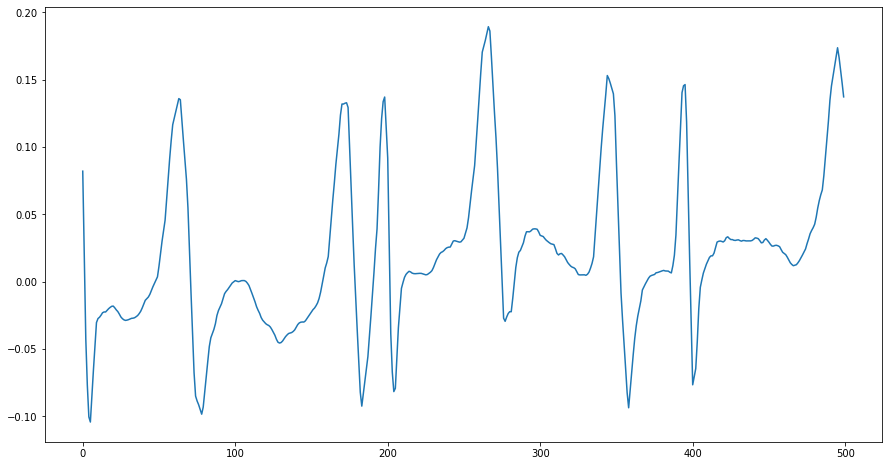

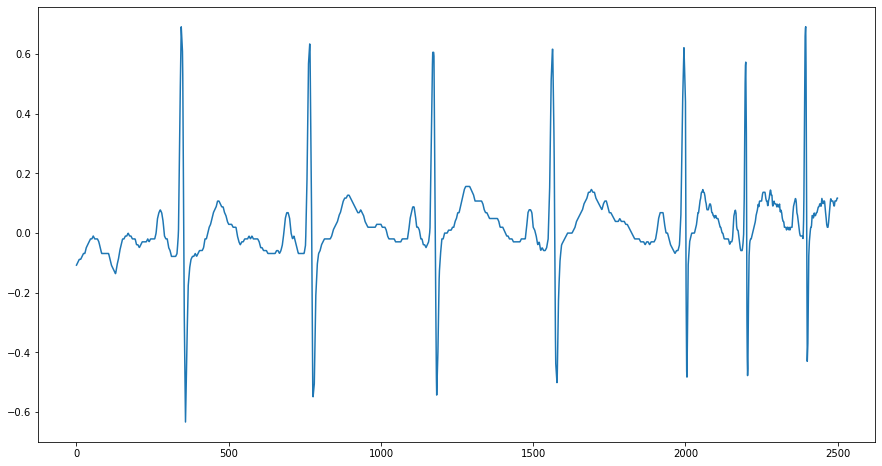

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
#plt.plot(np.array([mean_wave_ecg for i in range(5)]).flatten())
plt.plot(mean_wave_ecg)
plt.figure(figsize=(15,8))
plt.plot(norm_seg_ecg.flatten())

# 

# Generate Input

## Input 1

### Input 1-1 (10s / 2min / 5s)

- input 10s, NRS til 2min, 5s 겹침 -> NRS 당 23개 inupt

#### PACU

In [11]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/preprocess2/input1-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess2/input1/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, LEN_PER_NRS*SRATE)
        ppg_per_NRS = np.empty(LEN_PER_NRS*SRATE)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        ecg_per_NRS = np.empty(LEN_PER_NRS*SRATE)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp[0:30000]        

        # 한 NRS에 대해 23개의 input 확인
        for i in range(23):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8294 ...completed
loading data 2/8294 ...completed
loading data 3/8294 ...completed
loading data 4/8294 ...completed
loading data 5/8294 ...completed
loading data 6/8294 ...completed
loading data 7/8294 ...completed
loading data 8/8294 ...completed
loading data 9/8294 ...completed
loading data 10/8294 ...completed
loading data 11/8294 ...completed
loading data 12/8294 ...completed
loading data 13/8294 ...completed
loading data 14/8294 ...completed
loading data 15/8294 ...completed
loading data 16/8294 ...completed
loading data 17/8294 ...completed
loading data 18/8294 ...completed
loading data 19/8294 ...completed
loading data 20/8294 ...completed
loading data 21/8294 ...completed
loading data 22/8294 ...completed
loading data 23/8294 ...completed
loading data 24/8294 ...completed
loading data 25/8294 ...completed
loading data 26/8294 ...completed
loading data 27/8294 ...completed
loading data 28/8294 ...completed
loading data 29/8294 ...completed
loading data 30/8294 ..

loading data 241/8294 ...completed
loading data 242/8294 ...completed
loading data 243/8294 ...completed
loading data 244/8294 ...completed
loading data 245/8294 ...completed
loading data 246/8294 ...completed
loading data 247/8294 ...completed
loading data 248/8294 ...completed
loading data 249/8294 ...completed
loading data 250/8294 ...completed
loading data 251/8294 ...completed
loading data 252/8294 ...completed
loading data 253/8294 ...completed
loading data 254/8294 ...completed
loading data 255/8294 ...completed
loading data 256/8294 ...completed
loading data 257/8294 ...completed
loading data 258/8294 ...completed
loading data 259/8294 ...completed
loading data 260/8294 ...completed
loading data 261/8294 ...completed
loading data 262/8294 ...completed
loading data 263/8294 ...completed
loading data 264/8294 ...completed
loading data 265/8294 ...completed
loading data 266/8294 ...completed
loading data 267/8294 ...completed
loading data 268/8294 ...completed
loading data 269/829

loading data 487/8294 ...completed
loading data 488/8294 ...completed
loading data 489/8294 ...completed
loading data 490/8294 ...completed
loading data 491/8294 ...completed
loading data 492/8294 ...completed
loading data 493/8294 ...completed
loading data 494/8294 ...completed
loading data 495/8294 ...completed
loading data 496/8294 ...completed
loading data 497/8294 ...completed
loading data 498/8294 ...completed
loading data 499/8294 ...completed
loading data 500/8294 ...completed
loading data 501/8294 ...completed
loading data 502/8294 ...completed
loading data 503/8294 ...completed
loading data 504/8294 ...completed
loading data 505/8294 ...completed
loading data 506/8294 ...completed
loading data 507/8294 ...completed
loading data 508/8294 ...completed
loading data 509/8294 ...completed
loading data 510/8294 ...completed
loading data 511/8294 ...completed
loading data 512/8294 ...completed
loading data 513/8294 ...completed
loading data 514/8294 ...completed
loading data 515/829

loading data 726/8294 ...completed
loading data 727/8294 ...completed
loading data 728/8294 ...completed
loading data 729/8294 ...completed
loading data 730/8294 ...completed
loading data 731/8294 ...completed
loading data 732/8294 ...completed
loading data 733/8294 ...completed
loading data 734/8294 ...completed
loading data 735/8294 ...completed
loading data 736/8294 ...completed
loading data 737/8294 ...completed
loading data 738/8294 ...completed
loading data 739/8294 ...completed
loading data 740/8294 ...completed
loading data 741/8294 ...completed
loading data 742/8294 ...completed
loading data 743/8294 ...completed
loading data 744/8294 ...completed
loading data 745/8294 ...completed
loading data 746/8294 ...completed
loading data 747/8294 ...completed
loading data 748/8294 ...completed
loading data 749/8294 ...completed
loading data 750/8294 ...completed
loading data 751/8294 ...completed
loading data 752/8294 ...completed
loading data 753/8294 ...completed
loading data 754/829

loading data 965/8294 ...completed
loading data 966/8294 ...completed
loading data 967/8294 ...completed
loading data 968/8294 ...completed
loading data 969/8294 ...completed
loading data 970/8294 ...completed
loading data 971/8294 ...completed
loading data 972/8294 ...completed
loading data 973/8294 ...completed
loading data 974/8294 ...completed
loading data 975/8294 ...completed
loading data 976/8294 ...completed
loading data 977/8294 ...completed
loading data 978/8294 ...completed
loading data 979/8294 ...completed
loading data 980/8294 ...completed
loading data 981/8294 ...completed
loading data 982/8294 ...completed
loading data 983/8294 ...completed
loading data 984/8294 ...completed
loading data 985/8294 ...completed
loading data 986/8294 ...completed
loading data 987/8294 ...completed
loading data 988/8294 ...completed
loading data 989/8294 ...completed
loading data 990/8294 ...completed
loading data 991/8294 ...completed
loading data 992/8294 ...completed
loading data 993/829

loading data 1197/8294 ...completed
loading data 1198/8294 ...completed
loading data 1199/8294 ...completed
loading data 1200/8294 ...completed
loading data 1201/8294 ...completed
loading data 1202/8294 ...completed
loading data 1203/8294 ...completed
loading data 1204/8294 ...completed
loading data 1205/8294 ...completed
loading data 1206/8294 ...completed
loading data 1207/8294 ...completed
loading data 1208/8294 ...completed
loading data 1209/8294 ...completed
loading data 1210/8294 ...completed
loading data 1211/8294 ...completed
loading data 1212/8294 ...completed
loading data 1213/8294 ...completed
loading data 1214/8294 ...completed
loading data 1215/8294 ...completed
loading data 1216/8294 ...completed
loading data 1217/8294 ...completed
loading data 1218/8294 ...completed
loading data 1219/8294 ...completed
loading data 1220/8294 ...completed
loading data 1221/8294 ...completed
loading data 1222/8294 ...completed
loading data 1223/8294 ...completed
loading data 1224/8294 ...co

loading data 1431/8294 ...completed
loading data 1432/8294 ...completed
loading data 1433/8294 ...completed
loading data 1434/8294 ...completed
loading data 1435/8294 ...completed
loading data 1436/8294 ...completed
loading data 1437/8294 ...completed
loading data 1438/8294 ...completed
loading data 1439/8294 ...completed
loading data 1440/8294 ...completed
loading data 1441/8294 ...completed
loading data 1442/8294 ...completed
loading data 1443/8294 ...completed
loading data 1444/8294 ...completed
loading data 1445/8294 ...completed
loading data 1446/8294 ...completed
loading data 1447/8294 ...completed
loading data 1448/8294 ...completed
loading data 1449/8294 ...completed
loading data 1450/8294 ...completed
loading data 1451/8294 ...completed
loading data 1452/8294 ...completed
loading data 1453/8294 ...completed
loading data 1454/8294 ...completed
loading data 1455/8294 ...completed
loading data 1456/8294 ...completed
loading data 1457/8294 ...completed
loading data 1458/8294 ...co

loading data 1660/8294 ...completed
loading data 1661/8294 ...completed
loading data 1662/8294 ...completed
loading data 1663/8294 ...completed
loading data 1664/8294 ...completed
loading data 1665/8294 ...completed
loading data 1666/8294 ...completed
loading data 1667/8294 ...completed
loading data 1668/8294 ...completed
loading data 1669/8294 ...completed
loading data 1670/8294 ...completed
loading data 1671/8294 ...completed
loading data 1672/8294 ...completed
loading data 1673/8294 ...completed
loading data 1674/8294 ...completed
loading data 1675/8294 ...completed
loading data 1676/8294 ...completed
loading data 1677/8294 ...completed
loading data 1678/8294 ...completed
loading data 1679/8294 ...completed
loading data 1680/8294 ...completed
loading data 1681/8294 ...completed
loading data 1682/8294 ...completed
loading data 1683/8294 ...completed
loading data 1684/8294 ...completed
loading data 1685/8294 ...completed
loading data 1686/8294 ...completed
loading data 1687/8294 ...co

loading data 1888/8294 ...completed
loading data 1889/8294 ...completed
loading data 1890/8294 ...completed
loading data 1891/8294 ...completed
loading data 1892/8294 ...completed
loading data 1893/8294 ...completed
loading data 1894/8294 ...completed
loading data 1895/8294 ...completed
loading data 1896/8294 ...completed
loading data 1897/8294 ...completed
loading data 1898/8294 ...completed
loading data 1899/8294 ...completed
loading data 1900/8294 ...completed
loading data 1901/8294 ...completed
loading data 1902/8294 ...completed
loading data 1903/8294 ...completed
loading data 1904/8294 ...completed
loading data 1905/8294 ...completed
loading data 1906/8294 ...completed
loading data 1907/8294 ...completed
loading data 1908/8294 ...completed
loading data 1909/8294 ...completed
loading data 1910/8294 ...completed
loading data 1911/8294 ...completed
loading data 1912/8294 ...completed
loading data 1913/8294 ...completed
loading data 1914/8294 ...completed
loading data 1915/8294 ...co

loading data 2118/8294 ...completed
loading data 2119/8294 ...completed
loading data 2120/8294 ...completed
loading data 2121/8294 ...completed
loading data 2122/8294 ...completed
loading data 2123/8294 ...completed
loading data 2124/8294 ...completed
loading data 2125/8294 ...completed
loading data 2126/8294 ...completed
loading data 2127/8294 ...completed
loading data 2128/8294 ...completed
loading data 2129/8294 ...completed
loading data 2130/8294 ...completed
loading data 2131/8294 ...completed
loading data 2132/8294 ...completed
loading data 2133/8294 ...completed
loading data 2134/8294 ...completed
loading data 2135/8294 ...completed
loading data 2136/8294 ...completed
loading data 2137/8294 ...completed
loading data 2138/8294 ...completed
loading data 2139/8294 ...completed
loading data 2140/8294 ...completed
loading data 2141/8294 ...completed
loading data 2142/8294 ...completed
loading data 2143/8294 ...completed
loading data 2144/8294 ...completed
loading data 2145/8294 ...co

loading data 2353/8294 ...completed
loading data 2354/8294 ...completed
loading data 2355/8294 ...completed
loading data 2356/8294 ...completed
loading data 2357/8294 ...completed
loading data 2358/8294 ...completed
loading data 2359/8294 ...completed
loading data 2360/8294 ...completed
loading data 2361/8294 ...completed
loading data 2362/8294 ...completed
loading data 2363/8294 ...completed
loading data 2364/8294 ...completed
loading data 2365/8294 ...completed
loading data 2366/8294 ...completed
loading data 2367/8294 ...completed
loading data 2368/8294 ...completed
loading data 2369/8294 ...completed
loading data 2370/8294 ...completed
loading data 2371/8294 ...completed
loading data 2372/8294 ...completed
loading data 2373/8294 ...completed
loading data 2374/8294 ...completed
loading data 2375/8294 ...completed
loading data 2376/8294 ...completed
loading data 2377/8294 ...completed
loading data 2378/8294 ...completed
loading data 2379/8294 ...completed
loading data 2380/8294 ...co

loading data 2589/8294 ...completed
loading data 2590/8294 ...completed
loading data 2591/8294 ...completed
loading data 2592/8294 ...completed
loading data 2593/8294 ...completed
loading data 2594/8294 ...completed
loading data 2595/8294 ...completed
loading data 2596/8294 ...completed
loading data 2597/8294 ...completed
loading data 2598/8294 ...completed
loading data 2599/8294 ...completed
loading data 2600/8294 ...completed
loading data 2601/8294 ...completed
loading data 2602/8294 ...completed
loading data 2603/8294 ...completed
loading data 2604/8294 ...completed
loading data 2605/8294 ...completed
loading data 2606/8294 ...completed
loading data 2607/8294 ...completed
loading data 2608/8294 ...completed
loading data 2609/8294 ...completed
loading data 2610/8294 ...completed
loading data 2611/8294 ...completed
loading data 2612/8294 ...completed
loading data 2613/8294 ...completed
loading data 2614/8294 ...completed
loading data 2615/8294 ...completed
loading data 2616/8294 ...co

loading data 2830/8294 ...completed
loading data 2831/8294 ...completed
loading data 2832/8294 ...completed
loading data 2833/8294 ...completed
loading data 2834/8294 ...completed
loading data 2835/8294 ...completed
loading data 2836/8294 ...completed
loading data 2837/8294 ...completed
loading data 2838/8294 ...completed
loading data 2839/8294 ...completed
loading data 2840/8294 ...completed
loading data 2841/8294 ...completed
loading data 2842/8294 ...completed
loading data 2843/8294 ...completed
loading data 2844/8294 ...completed
loading data 2845/8294 ...completed
loading data 2846/8294 ...completed
loading data 2847/8294 ...completed
loading data 2848/8294 ...completed
loading data 2849/8294 ...completed
loading data 2850/8294 ...completed
loading data 2851/8294 ...completed
loading data 2852/8294 ...completed
loading data 2853/8294 ...completed
loading data 2854/8294 ...completed
loading data 2855/8294 ...completed
loading data 2856/8294 ...completed
loading data 2857/8294 ...co

loading data 3059/8294 ...completed
loading data 3060/8294 ...completed
loading data 3061/8294 ...completed
loading data 3062/8294 ...completed
loading data 3063/8294 ...completed
loading data 3064/8294 ...completed
loading data 3065/8294 ...completed
loading data 3066/8294 ...completed
loading data 3067/8294 ...completed
loading data 3068/8294 ...completed
loading data 3069/8294 ...completed
loading data 3070/8294 ...completed
loading data 3071/8294 ...completed
loading data 3072/8294 ...completed
loading data 3073/8294 ...completed
loading data 3074/8294 ...completed
loading data 3075/8294 ...completed
loading data 3076/8294 ...completed
loading data 3077/8294 ...completed
loading data 3078/8294 ...completed
loading data 3079/8294 ...completed
loading data 3080/8294 ...completed
loading data 3081/8294 ...completed
loading data 3082/8294 ...completed
loading data 3083/8294 ...completed
loading data 3084/8294 ...completed
loading data 3085/8294 ...completed
loading data 3086/8294 ...co

loading data 3288/8294 ...completed
loading data 3289/8294 ...completed
loading data 3290/8294 ...completed
loading data 3291/8294 ...completed
loading data 3292/8294 ...completed
loading data 3293/8294 ...completed
loading data 3294/8294 ...completed
loading data 3295/8294 ...completed
loading data 3296/8294 ...completed
loading data 3297/8294 ...completed
loading data 3298/8294 ...completed
loading data 3299/8294 ...completed
loading data 3300/8294 ...completed
loading data 3301/8294 ...completed
loading data 3302/8294 ...completed
loading data 3303/8294 ...completed
loading data 3304/8294 ...completed
loading data 3305/8294 ...completed
loading data 3306/8294 ...completed
loading data 3307/8294 ...completed
loading data 3308/8294 ...completed
loading data 3309/8294 ...completed
loading data 3310/8294 ...completed
loading data 3311/8294 ...completed
loading data 3312/8294 ...completed
loading data 3313/8294 ...completed
loading data 3314/8294 ...completed
loading data 3315/8294 ...co

loading data 3519/8294 ...completed
loading data 3520/8294 ...completed
loading data 3521/8294 ...completed
loading data 3522/8294 ...completed
loading data 3523/8294 ...completed
loading data 3524/8294 ...completed
loading data 3525/8294 ...completed
loading data 3526/8294 ...completed
loading data 3527/8294 ...completed
loading data 3528/8294 ...completed
loading data 3529/8294 ...completed
loading data 3530/8294 ...completed
loading data 3531/8294 ...completed
loading data 3532/8294 ...completed
loading data 3533/8294 ...completed
loading data 3534/8294 ...completed
loading data 3535/8294 ...completed
loading data 3536/8294 ...completed
loading data 3537/8294 ...completed
loading data 3538/8294 ...completed
loading data 3539/8294 ...completed
loading data 3540/8294 ...completed
loading data 3541/8294 ...completed
loading data 3542/8294 ...completed
loading data 3543/8294 ...completed
loading data 3544/8294 ...completed
loading data 3545/8294 ...completed
loading data 3546/8294 ...co

loading data 3758/8294 ...completed
loading data 3759/8294 ...completed
loading data 3760/8294 ...completed
loading data 3761/8294 ...completed
loading data 3762/8294 ...completed
loading data 3763/8294 ...completed
loading data 3764/8294 ...completed
loading data 3765/8294 ...completed
loading data 3766/8294 ...completed
loading data 3767/8294 ...completed
loading data 3768/8294 ...completed
loading data 3769/8294 ...completed
loading data 3770/8294 ...completed
loading data 3771/8294 ...completed
loading data 3772/8294 ...completed
loading data 3773/8294 ...completed
loading data 3774/8294 ...completed
loading data 3775/8294 ...completed
loading data 3776/8294 ...completed
loading data 3777/8294 ...completed
loading data 3778/8294 ...completed
loading data 3779/8294 ...completed
loading data 3780/8294 ...completed
loading data 3781/8294 ...completed
loading data 3782/8294 ...completed
loading data 3783/8294 ...completed
loading data 3784/8294 ...completed
loading data 3785/8294 ...co

loading data 3996/8294 ...completed
loading data 3997/8294 ...completed
loading data 3998/8294 ...completed
loading data 3999/8294 ...completed
loading data 4000/8294 ...completed
loading data 4001/8294 ...completed
loading data 4002/8294 ...completed
loading data 4003/8294 ...completed
loading data 4004/8294 ...completed
loading data 4005/8294 ...completed
loading data 4006/8294 ...completed
loading data 4007/8294 ...completed
loading data 4008/8294 ...completed
loading data 4009/8294 ...completed
loading data 4010/8294 ...completed
loading data 4011/8294 ...completed
loading data 4012/8294 ...completed
loading data 4013/8294 ...completed
loading data 4014/8294 ...completed
loading data 4015/8294 ...completed
loading data 4016/8294 ...completed
loading data 4017/8294 ...completed
loading data 4018/8294 ...completed
loading data 4019/8294 ...completed
loading data 4020/8294 ...completed
loading data 4021/8294 ...completed
loading data 4022/8294 ...completed
loading data 4023/8294 ...co

loading data 4233/8294 ...completed
loading data 4234/8294 ...completed
loading data 4235/8294 ...completed
loading data 4236/8294 ...completed
loading data 4237/8294 ...completed
loading data 4238/8294 ...completed
loading data 4239/8294 ...completed
loading data 4240/8294 ...completed
loading data 4241/8294 ...completed
loading data 4242/8294 ...completed
loading data 4243/8294 ...completed
loading data 4244/8294 ...completed
loading data 4245/8294 ...completed
loading data 4246/8294 ...completed
loading data 4247/8294 ...completed
loading data 4248/8294 ...completed
loading data 4249/8294 ...completed
loading data 4250/8294 ...completed
loading data 4251/8294 ...completed
loading data 4252/8294 ...completed
loading data 4253/8294 ...completed
loading data 4254/8294 ...completed
loading data 4255/8294 ...completed
loading data 4256/8294 ...completed
loading data 4257/8294 ...completed
loading data 4258/8294 ...completed
loading data 4259/8294 ...completed
loading data 4260/8294 ...co

loading data 4469/8294 ...completed
loading data 4470/8294 ...completed
loading data 4471/8294 ...completed
loading data 4472/8294 ...completed
loading data 4473/8294 ...completed
loading data 4474/8294 ...completed
loading data 4475/8294 ...completed
loading data 4476/8294 ...completed
loading data 4477/8294 ...completed
loading data 4478/8294 ...completed
loading data 4479/8294 ...completed
loading data 4480/8294 ...completed
loading data 4481/8294 ...completed
loading data 4482/8294 ...completed
loading data 4483/8294 ...completed
loading data 4484/8294 ...completed
loading data 4485/8294 ...completed
loading data 4486/8294 ...completed
loading data 4487/8294 ...completed
loading data 4488/8294 ...completed
loading data 4489/8294 ...completed
loading data 4490/8294 ...completed
loading data 4491/8294 ...completed
loading data 4492/8294 ...completed
loading data 4493/8294 ...completed
loading data 4494/8294 ...completed
loading data 4495/8294 ...completed
loading data 4496/8294 ...co

loading data 4699/8294 ...completed
loading data 4700/8294 ...completed
loading data 4701/8294 ...completed
loading data 4702/8294 ...completed
loading data 4703/8294 ...completed
loading data 4704/8294 ...completed
loading data 4705/8294 ...completed
loading data 4706/8294 ...completed
loading data 4707/8294 ...completed
loading data 4708/8294 ...completed
loading data 4709/8294 ...completed
loading data 4710/8294 ...completed
loading data 4711/8294 ...completed
loading data 4712/8294 ...completed
loading data 4713/8294 ...completed
loading data 4714/8294 ...completed
loading data 4715/8294 ...completed
loading data 4716/8294 ...completed
loading data 4717/8294 ...completed
loading data 4718/8294 ...completed
loading data 4719/8294 ...completed
loading data 4720/8294 ...completed
loading data 4721/8294 ...completed
loading data 4722/8294 ...completed
loading data 4723/8294 ...completed
loading data 4724/8294 ...completed
loading data 4725/8294 ...completed
loading data 4726/8294 ...co

loading data 4939/8294 ...completed
loading data 4940/8294 ...completed
loading data 4941/8294 ...completed
loading data 4942/8294 ...completed
loading data 4943/8294 ...completed
loading data 4944/8294 ...completed
loading data 4945/8294 ...completed
loading data 4946/8294 ...completed
loading data 4947/8294 ...completed
loading data 4948/8294 ...completed
loading data 4949/8294 ...completed
loading data 4950/8294 ...completed
loading data 4951/8294 ...completed
loading data 4952/8294 ...completed
loading data 4953/8294 ...completed
loading data 4954/8294 ...completed
loading data 4955/8294 ...completed
loading data 4956/8294 ...completed
loading data 4957/8294 ...completed
loading data 4958/8294 ...completed
loading data 4959/8294 ...completed
loading data 4960/8294 ...completed
loading data 4961/8294 ...completed
loading data 4962/8294 ...completed
loading data 4963/8294 ...completed
loading data 4964/8294 ...completed
loading data 4965/8294 ...completed
loading data 4966/8294 ...co

loading data 5178/8294 ...completed
loading data 5179/8294 ...completed
loading data 5180/8294 ...completed
loading data 5181/8294 ...completed
loading data 5182/8294 ...completed
loading data 5183/8294 ...completed
loading data 5184/8294 ...completed
loading data 5185/8294 ...completed
loading data 5186/8294 ...completed
loading data 5187/8294 ...completed
loading data 5188/8294 ...completed
loading data 5189/8294 ...completed
loading data 5190/8294 ...completed
loading data 5191/8294 ...completed
loading data 5192/8294 ...completed
loading data 5193/8294 ...completed
loading data 5194/8294 ...completed
loading data 5195/8294 ...completed
loading data 5196/8294 ...completed
loading data 5197/8294 ...completed
loading data 5198/8294 ...completed
loading data 5199/8294 ...completed
loading data 5200/8294 ...completed
loading data 5201/8294 ...completed
loading data 5202/8294 ...completed
loading data 5203/8294 ...completed
loading data 5204/8294 ...completed
loading data 5205/8294 ...co

loading data 5418/8294 ...completed
loading data 5419/8294 ...completed
loading data 5420/8294 ...completed
loading data 5421/8294 ...completed
loading data 5422/8294 ...completed
loading data 5423/8294 ...completed
loading data 5424/8294 ...completed
loading data 5425/8294 ...completed
loading data 5426/8294 ...completed
loading data 5427/8294 ...completed
loading data 5428/8294 ...completed
loading data 5429/8294 ...completed
loading data 5430/8294 ...completed
loading data 5431/8294 ...completed
loading data 5432/8294 ...completed
loading data 5433/8294 ...completed
loading data 5434/8294 ...completed
loading data 5435/8294 ...completed
loading data 5436/8294 ...completed
loading data 5437/8294 ...completed
loading data 5438/8294 ...completed
loading data 5439/8294 ...completed
loading data 5440/8294 ...completed
loading data 5441/8294 ...completed
loading data 5442/8294 ...completed
loading data 5443/8294 ...completed
loading data 5444/8294 ...completed
loading data 5445/8294 ...co

loading data 5650/8294 ...completed
loading data 5651/8294 ...completed
loading data 5652/8294 ...completed
loading data 5653/8294 ...completed
loading data 5654/8294 ...completed
loading data 5655/8294 ...completed
loading data 5656/8294 ...completed
loading data 5657/8294 ...completed
loading data 5658/8294 ...completed
loading data 5659/8294 ...completed
loading data 5660/8294 ...completed
loading data 5661/8294 ...completed
loading data 5662/8294 ...completed
loading data 5663/8294 ...completed
loading data 5664/8294 ...completed
loading data 5665/8294 ...completed
loading data 5666/8294 ...completed
loading data 5667/8294 ...completed
loading data 5668/8294 ...completed
loading data 5669/8294 ...completed
loading data 5670/8294 ...completed
loading data 5671/8294 ...completed
loading data 5672/8294 ...completed
loading data 5673/8294 ...completed
loading data 5674/8294 ...completed
loading data 5675/8294 ...completed
loading data 5676/8294 ...completed
loading data 5677/8294 ...co

loading data 5889/8294 ...completed
loading data 5890/8294 ...completed
loading data 5891/8294 ...completed
loading data 5892/8294 ...completed
loading data 5893/8294 ...completed
loading data 5894/8294 ...completed
loading data 5895/8294 ...completed
loading data 5896/8294 ...completed
loading data 5897/8294 ...completed
loading data 5898/8294 ...completed
loading data 5899/8294 ...completed
loading data 5900/8294 ...completed
loading data 5901/8294 ...completed
loading data 5902/8294 ...completed
loading data 5903/8294 ...completed
loading data 5904/8294 ...completed
loading data 5905/8294 ...completed
loading data 5906/8294 ...completed
loading data 5907/8294 ...completed
loading data 5908/8294 ...completed
loading data 5909/8294 ...completed
loading data 5910/8294 ...completed
loading data 5911/8294 ...completed
loading data 5912/8294 ...completed
loading data 5913/8294 ...completed
loading data 5914/8294 ...completed
loading data 5915/8294 ...completed
loading data 5916/8294 ...co

loading data 6128/8294 ...completed
loading data 6129/8294 ...completed
loading data 6130/8294 ...completed
loading data 6131/8294 ...completed
loading data 6132/8294 ...completed
loading data 6133/8294 ...completed
loading data 6134/8294 ...completed
loading data 6135/8294 ...completed
loading data 6136/8294 ...completed
loading data 6137/8294 ...completed
loading data 6138/8294 ...completed
loading data 6139/8294 ...completed
loading data 6140/8294 ...completed
loading data 6141/8294 ...completed
loading data 6142/8294 ...completed
loading data 6143/8294 ...completed
loading data 6144/8294 ...completed
loading data 6145/8294 ...completed
loading data 6146/8294 ...completed
loading data 6147/8294 ...completed
loading data 6148/8294 ...completed
loading data 6149/8294 ...completed
loading data 6150/8294 ...completed
loading data 6151/8294 ...completed
loading data 6152/8294 ...completed
loading data 6153/8294 ...completed
loading data 6154/8294 ...completed
loading data 6155/8294 ...co

loading data 6597/8294 ...completed
loading data 6598/8294 ...completed
loading data 6599/8294 ...completed
loading data 6600/8294 ...completed
loading data 6601/8294 ...completed
loading data 6602/8294 ...completed
loading data 6603/8294 ...completed
loading data 6604/8294 ...completed
loading data 6605/8294 ...completed
loading data 6606/8294 ...completed
loading data 6607/8294 ...completed
loading data 6608/8294 ...completed
loading data 6609/8294 ...completed
loading data 6610/8294 ...completed
loading data 6611/8294 ...completed
loading data 6612/8294 ...completed
loading data 6613/8294 ...completed
loading data 6614/8294 ...completed
loading data 6615/8294 ...completed
loading data 6616/8294 ...completed
loading data 6617/8294 ...completed
loading data 6618/8294 ...completed
loading data 6619/8294 ...completed
loading data 6620/8294 ...completed
loading data 6621/8294 ...completed
loading data 6622/8294 ...completed
loading data 6623/8294 ...completed
loading data 6624/8294 ...co

loading data 6834/8294 ...completed
loading data 6835/8294 ...completed
loading data 6836/8294 ...completed
loading data 6837/8294 ...completed
loading data 6838/8294 ...completed
loading data 6839/8294 ...completed
loading data 6840/8294 ...completed
loading data 6841/8294 ...completed
loading data 6842/8294 ...completed
loading data 6843/8294 ...completed
loading data 6844/8294 ...completed
loading data 6845/8294 ...completed
loading data 6846/8294 ...completed
loading data 6847/8294 ...completed
loading data 6848/8294 ...completed
loading data 6849/8294 ...completed
loading data 6850/8294 ...completed
loading data 6851/8294 ...completed
loading data 6852/8294 ...completed
loading data 6853/8294 ...completed
loading data 6854/8294 ...completed
loading data 6855/8294 ...completed
loading data 6856/8294 ...completed
loading data 6857/8294 ...completed
loading data 6858/8294 ...completed
loading data 6859/8294 ...completed
loading data 6860/8294 ...completed
loading data 6861/8294 ...co

loading data 7064/8294 ...completed
loading data 7065/8294 ...completed
loading data 7066/8294 ...completed
loading data 7067/8294 ...completed
loading data 7068/8294 ...completed
loading data 7069/8294 ...completed
loading data 7070/8294 ...completed
loading data 7071/8294 ...completed
loading data 7072/8294 ...completed
loading data 7073/8294 ...completed
loading data 7074/8294 ...completed
loading data 7075/8294 ...completed
loading data 7076/8294 ...completed
loading data 7077/8294 ...completed
loading data 7078/8294 ...completed
loading data 7079/8294 ...completed
loading data 7080/8294 ...completed
loading data 7081/8294 ...completed
loading data 7082/8294 ...completed
loading data 7083/8294 ...completed
loading data 7084/8294 ...completed
loading data 7085/8294 ...completed
loading data 7086/8294 ...completed
loading data 7087/8294 ...completed
loading data 7088/8294 ...completed
loading data 7089/8294 ...completed
loading data 7090/8294 ...completed
loading data 7091/8294 ...co

loading data 7292/8294 ...completed
loading data 7293/8294 ...completed
loading data 7294/8294 ...completed
loading data 7295/8294 ...completed
loading data 7296/8294 ...completed
loading data 7297/8294 ...completed
loading data 7298/8294 ...completed
loading data 7299/8294 ...completed
loading data 7300/8294 ...completed
loading data 7301/8294 ...completed
loading data 7302/8294 ...completed
loading data 7303/8294 ...completed
loading data 7304/8294 ...completed
loading data 7305/8294 ...completed
loading data 7306/8294 ...completed
loading data 7307/8294 ...completed
loading data 7308/8294 ...completed
loading data 7309/8294 ...completed
loading data 7310/8294 ...completed
loading data 7311/8294 ...completed
loading data 7312/8294 ...completed
loading data 7313/8294 ...completed
loading data 7314/8294 ...completed
loading data 7315/8294 ...completed
loading data 7316/8294 ...completed
loading data 7317/8294 ...completed
loading data 7318/8294 ...completed
loading data 7319/8294 ...co

loading data 7529/8294 ...completed
loading data 7530/8294 ...completed
loading data 7531/8294 ...completed
loading data 7532/8294 ...completed
loading data 7533/8294 ...completed
loading data 7534/8294 ...completed
loading data 7535/8294 ...completed
loading data 7536/8294 ...completed
loading data 7537/8294 ...completed
loading data 7538/8294 ...completed
loading data 7539/8294 ...completed
loading data 7540/8294 ...completed
loading data 7541/8294 ...completed
loading data 7542/8294 ...completed
loading data 7543/8294 ...completed
loading data 7544/8294 ...completed
loading data 7545/8294 ...completed
loading data 7546/8294 ...completed
loading data 7547/8294 ...completed
loading data 7548/8294 ...completed
loading data 7549/8294 ...completed
loading data 7550/8294 ...completed
loading data 7551/8294 ...completed
loading data 7552/8294 ...completed
loading data 7553/8294 ...completed
loading data 7554/8294 ...completed
loading data 7555/8294 ...completed
loading data 7556/8294 ...co

loading data 7757/8294 ...completed
loading data 7758/8294 ...completed
loading data 7759/8294 ...completed
loading data 7760/8294 ...completed
loading data 7761/8294 ...completed
loading data 7762/8294 ...completed
loading data 7763/8294 ...completed
loading data 7764/8294 ...completed
loading data 7765/8294 ...completed
loading data 7766/8294 ...completed
loading data 7767/8294 ...completed
loading data 7768/8294 ...completed
loading data 7769/8294 ...completed
loading data 7770/8294 ...completed
loading data 7771/8294 ...completed
loading data 7772/8294 ...completed
loading data 7773/8294 ...completed
loading data 7774/8294 ...completed
loading data 7775/8294 ...completed
loading data 7776/8294 ...completed
loading data 7777/8294 ...completed
loading data 7778/8294 ...completed
loading data 7779/8294 ...completed
loading data 7780/8294 ...completed
loading data 7781/8294 ...completed
loading data 7782/8294 ...completed
loading data 7783/8294 ...completed
loading data 7784/8294 ...co

loading data 7993/8294 ...completed
loading data 7994/8294 ...completed
loading data 7995/8294 ...completed
loading data 7996/8294 ...completed
loading data 7997/8294 ...completed
loading data 7998/8294 ...completed
loading data 7999/8294 ...completed
loading data 8000/8294 ...completed
loading data 8001/8294 ...completed
loading data 8002/8294 ...completed
loading data 8003/8294 ...completed
loading data 8004/8294 ...completed
loading data 8005/8294 ...completed
loading data 8006/8294 ...completed
loading data 8007/8294 ...completed
loading data 8008/8294 ...completed
loading data 8009/8294 ...completed
loading data 8010/8294 ...completed
loading data 8011/8294 ...completed
loading data 8012/8294 ...completed
loading data 8013/8294 ...completed
loading data 8014/8294 ...completed
loading data 8015/8294 ...completed
loading data 8016/8294 ...completed
loading data 8017/8294 ...completed
loading data 8018/8294 ...completed
loading data 8019/8294 ...completed
loading data 8020/8294 ...co

loading data 8221/8294 ...completed
loading data 8222/8294 ...completed
loading data 8223/8294 ...completed
loading data 8224/8294 ...completed
loading data 8225/8294 ...completed
loading data 8226/8294 ...completed
loading data 8227/8294 ...completed
loading data 8228/8294 ...completed
loading data 8229/8294 ...completed
loading data 8230/8294 ...completed
loading data 8231/8294 ...completed
loading data 8232/8294 ...completed
loading data 8233/8294 ...completed
loading data 8234/8294 ...completed
loading data 8235/8294 ...completed
loading data 8236/8294 ...completed
loading data 8237/8294 ...completed
loading data 8238/8294 ...completed
loading data 8239/8294 ...completed
loading data 8240/8294 ...completed
loading data 8241/8294 ...completed
loading data 8242/8294 ...completed
loading data 8243/8294 ...completed
loading data 8244/8294 ...completed
loading data 8245/8294 ...completed
loading data 8246/8294 ...completed
loading data 8247/8294 ...completed
loading data 8248/8294 ...co

x_train shape: (137516, 2500, 2)
x_test shape: (15140, 2500, 2)


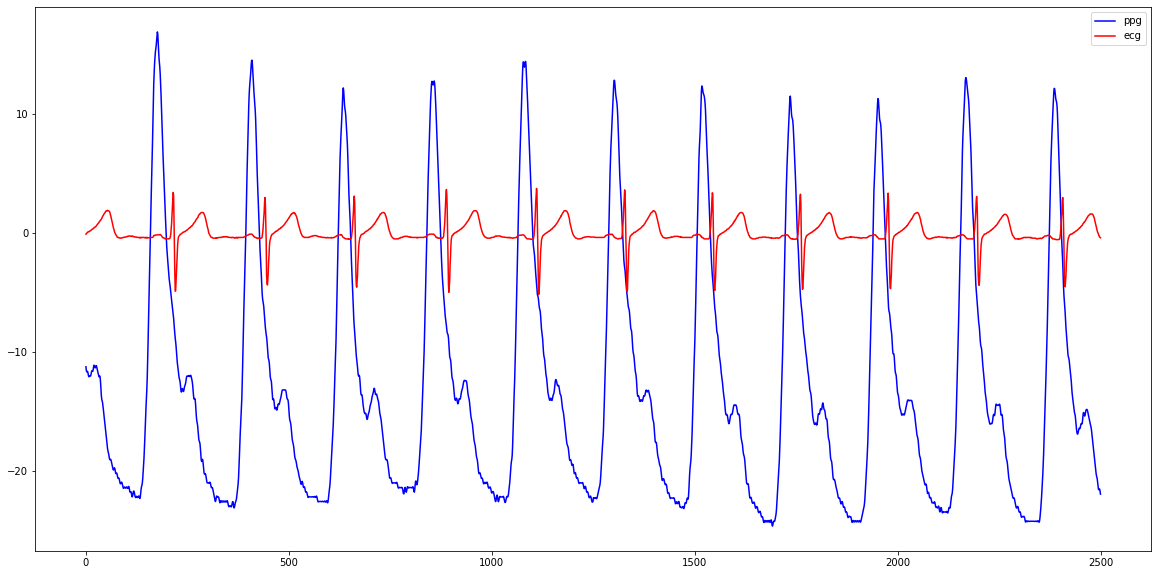

In [87]:

# 알맞게 input 변환
x_train = np.transpose(x_train_pacu, [0,2,1])
x_test = np.transpose(x_test_pacu, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


plt.figure(figsize=(20,10))
plt.plot(np.array(x_train)[:,:,0][10], c='b', label='ppg')
plt.plot(np.array(x_train)[:,:,1][10], c='r', label='ecg')
plt.legend(loc='best')


#### Preop

In [13]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess2/input1-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/preprocess2/input1/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, LEN_PER_NRS*SRATE)
        ppg_per_NRS = np.empty(LEN_PER_NRS*SRATE)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            ecg_per_NRS = np.empty(LEN_PER_NRS*SRATE)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp[0:30000]        

            # 한 NRS에 대해 23개의 input 확인
            for i in range(23):
                # input이 전처리 통과한 경우
                if row[str(i+1)][0]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    pleth_inp = ppg_per_NRS[start_idx:end_idx]
                    pleth_inp -= np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([pleth_inp, ecg_inp])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    else:
                        x_train_preop.append([pleth_inp, ecg_inp])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 239/3879 ...completed
loading data 240/3879 ...completed
loading data 241/3879 ...completed
loading data 242/3879 ...completed
loading data 243/3879 ...completed
loading data 244/3879 ...completed
loading data 245/3879 ...completed
loading data 246/3879 ...completed
loading data 247/3879 ...completed
loading data 248/3879 ...completed
loading data 249/3879 ...completed
loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/387

loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/3879 ...completed
loading data 506/3879 ...completed
loading data 507/3879 ...completed
loading data 508/3879 ...completed
loading data 509/3879 ...completed
loading data 510/3879 ...completed
loading data 511/3879 ...completed
loading data 512/3879 ...completed
loading data 513/3879 ...completed
loading data 514/3879 ...completed
loading data 515/3879 ...completed
loading data 516/387

loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/3879 ...completed
loading data 746/3879 ...completed
loading data 747/3879 ...completed
loading data 748/3879 ...completed
loading data 749/3879 ...completed
loading data 750/3879 ...completed
loading data 751/3879 ...completed
loading data 752/3879 ...completed
loading data 753/3879 ...completed
loading data 754/3879 ...completed
loading data 755/3879 ...completed
loading data 756/3879 ...completed
loading data 757/3879 ...completed
loading data 758/3879 ...completed
loading data 759/3879 ...completed
loading data 760/387

loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/3879 ...completed
loading data 983/3879 ...completed
loading data 984/3879 ...completed
loading data 985/3879 ...completed
loading data 986/3879 ...completed
loading data 987/3879 ...completed
loading data 988/3879 ...completed
loading data 989/3879 ...completed
loading data 990/3879 ...completed
loading data 991/3879 ...completed
loading data 992/3879 ...completed
loading data 993/3879 ...completed
loading data 994/3879 ...completed
loading data 995/3879 ...completed
loading data 996/387

loading data 1217/3879 ...completed
loading data 1218/3879 ...completed
loading data 1219/3879 ...completed
loading data 1220/3879 ...completed
loading data 1221/3879 ...completed
loading data 1222/3879 ...completed
loading data 1223/3879 ...completed
loading data 1224/3879 ...completed
loading data 1225/3879 ...completed
loading data 1226/3879 ...completed
loading data 1227/3879 ...completed
loading data 1228/3879 ...completed
loading data 1229/3879 ...completed
loading data 1230/3879 ...completed
loading data 1231/3879 ...completed
loading data 1232/3879 ...completed
loading data 1233/3879 ...completed
loading data 1234/3879 ...completed
loading data 1235/3879 ...completed
loading data 1236/3879 ...completed
loading data 1237/3879 ...completed
loading data 1238/3879 ...completed
loading data 1239/3879 ...completed
loading data 1240/3879 ...completed
loading data 1241/3879 ...completed
loading data 1242/3879 ...completed
loading data 1243/3879 ...completed
loading data 1244/3879 ...co

loading data 1460/3879 ...completed
loading data 1461/3879 ...completed
loading data 1462/3879 ...completed
loading data 1463/3879 ...completed
loading data 1464/3879 ...completed
loading data 1465/3879 ...completed
loading data 1466/3879 ...completed
loading data 1467/3879 ...completed
loading data 1468/3879 ...completed
loading data 1469/3879 ...completed
loading data 1470/3879 ...completed
loading data 1471/3879 ...completed
loading data 1472/3879 ...completed
loading data 1473/3879 ...completed
loading data 1474/3879 ...completed
loading data 1475/3879 ...completed
loading data 1476/3879 ...completed
loading data 1477/3879 ...completed
loading data 1478/3879 ...completed
loading data 1479/3879 ...completed
loading data 1480/3879 ...completed
loading data 1481/3879 ...completed
loading data 1482/3879 ...completed
loading data 1483/3879 ...completed
loading data 1484/3879 ...completed
loading data 1485/3879 ...completed
loading data 1486/3879 ...completed
loading data 1487/3879 ...co

loading data 1688/3879 ...completed
loading data 1689/3879 ...completed
loading data 1690/3879 ...completed
loading data 1691/3879 ...completed
loading data 1692/3879 ...completed
loading data 1693/3879 ...completed
loading data 1694/3879 ...completed
loading data 1695/3879 ...completed
loading data 1696/3879 ...completed
loading data 1697/3879 ...completed
loading data 1698/3879 ...completed
loading data 1699/3879 ...completed
loading data 1700/3879 ...completed
loading data 1701/3879 ...completed
loading data 1702/3879 ...completed
loading data 1703/3879 ...completed
loading data 1704/3879 ...completed
loading data 1705/3879 ...completed
loading data 1706/3879 ...completed
loading data 1707/3879 ...completed
loading data 1708/3879 ...completed
loading data 1709/3879 ...completed
loading data 1710/3879 ...completed
loading data 1711/3879 ...completed
loading data 1712/3879 ...completed
loading data 1713/3879 ...completed
loading data 1714/3879 ...completed
loading data 1715/3879 ...co

loading data 1918/3879 ...completed
loading data 1919/3879 ...completed
loading data 1920/3879 ...completed
loading data 1921/3879 ...completed
loading data 1922/3879 ...completed
loading data 1923/3879 ...completed
loading data 1924/3879 ...completed
loading data 1925/3879 ...completed
loading data 1926/3879 ...completed
loading data 1927/3879 ...completed
loading data 1928/3879 ...completed
loading data 1929/3879 ...completed
loading data 1930/3879 ...completed
loading data 1931/3879 ...completed
loading data 1932/3879 ...completed
loading data 1933/3879 ...completed
loading data 1934/3879 ...completed
loading data 1935/3879 ...completed
loading data 1936/3879 ...completed
loading data 1937/3879 ...completed
loading data 1938/3879 ...completed
loading data 1939/3879 ...completed
loading data 1940/3879 ...completed
loading data 1941/3879 ...completed
loading data 1942/3879 ...completed
loading data 1943/3879 ...completed
loading data 1944/3879 ...completed
loading data 1945/3879 ...co

loading data 2152/3879 ...completed
loading data 2153/3879 ...completed
loading data 2154/3879 ...completed
loading data 2155/3879 ...completed
loading data 2156/3879 ...completed
loading data 2157/3879 ...completed
loading data 2158/3879 ...completed
loading data 2159/3879 ...completed
loading data 2160/3879 ...completed
loading data 2161/3879 ...completed
loading data 2162/3879 ...completed
loading data 2163/3879 ...completed
loading data 2164/3879 ...completed
loading data 2165/3879 ...completed
loading data 2166/3879 ...completed
loading data 2167/3879 ...completed
loading data 2168/3879 ...completed
loading data 2169/3879 ...completed
loading data 2170/3879 ...completed
loading data 2171/3879 ...completed
loading data 2172/3879 ...completed
loading data 2173/3879 ...completed
loading data 2174/3879 ...completed
loading data 2175/3879 ...completed
loading data 2176/3879 ...completed
loading data 2177/3879 ...completed
loading data 2178/3879 ...completed
loading data 2179/3879 ...co

loading data 2610/3879 ...completed
loading data 2611/3879 ...completed
loading data 2612/3879 ...completed
loading data 2613/3879 ...completed
loading data 2614/3879 ...completed
loading data 2615/3879 ...completed
loading data 2616/3879 ...completed
loading data 2617/3879 ...completed
loading data 2618/3879 ...completed
loading data 2619/3879 ...completed
loading data 2620/3879 ...completed
loading data 2621/3879 ...completed
loading data 2622/3879 ...completed
loading data 2623/3879 ...completed
loading data 2624/3879 ...completed
loading data 2625/3879 ...completed
loading data 2626/3879 ...completed
loading data 2627/3879 ...completed
loading data 2628/3879 ...completed
loading data 2629/3879 ...completed
loading data 2630/3879 ...completed
loading data 2631/3879 ...completed
loading data 2632/3879 ...completed
loading data 2633/3879 ...completed
loading data 2634/3879 ...completed
loading data 2635/3879 ...completed
loading data 2636/3879 ...completed
loading data 2637/3879 ...co

loading data 2852/3879 ...completed
loading data 2853/3879 ...completed
loading data 2854/3879 ...completed
loading data 2855/3879 ...completed
loading data 2856/3879 ...completed
loading data 2857/3879 ...completed
loading data 2858/3879 ...completed
loading data 2859/3879 ...completed
loading data 2860/3879 ...completed
loading data 2861/3879 ...completed
loading data 2862/3879 ...completed
loading data 2863/3879 ...completed
loading data 2864/3879 ...completed
loading data 2865/3879 ...completed
loading data 2866/3879 ...completed
loading data 2867/3879 ...completed
loading data 2868/3879 ...completed
loading data 2869/3879 ...completed
loading data 2870/3879 ...completed
loading data 2871/3879 ...completed
loading data 2872/3879 ...completed
loading data 2873/3879 ...completed
loading data 2874/3879 ...completed
loading data 2875/3879 ...completed
loading data 2876/3879 ...completed
loading data 2877/3879 ...completed
loading data 2878/3879 ...completed
loading data 2879/3879 ...co

loading data 3083/3879 ...completed
loading data 3084/3879 ...completed
loading data 3085/3879 ...completed
loading data 3086/3879 ...completed
loading data 3087/3879 ...completed
loading data 3088/3879 ...completed
loading data 3089/3879 ...completed
loading data 3090/3879 ...completed
loading data 3091/3879 ...completed
loading data 3092/3879 ...completed
loading data 3093/3879 ...completed
loading data 3094/3879 ...completed
loading data 3095/3879 ...completed
loading data 3096/3879 ...completed
loading data 3097/3879 ...completed
loading data 3098/3879 ...completed
loading data 3099/3879 ...completed
loading data 3100/3879 ...completed
loading data 3101/3879 ...completed
loading data 3102/3879 ...completed
loading data 3103/3879 ...completed
loading data 3104/3879 ...completed
loading data 3105/3879 ...completed
loading data 3106/3879 ...completed
loading data 3107/3879 ...completed
loading data 3108/3879 ...completed
loading data 3109/3879 ...completed
loading data 3110/3879 ...co

loading data 3314/3879 ...completed
loading data 3315/3879 ...completed
loading data 3316/3879 ...completed
loading data 3317/3879 ...completed
loading data 3318/3879 ...completed
loading data 3319/3879 ...completed
loading data 3320/3879 ...completed
loading data 3321/3879 ...completed
loading data 3322/3879 ...completed
loading data 3323/3879 ...completed
loading data 3324/3879 ...completed
loading data 3325/3879 ...completed
loading data 3326/3879 ...completed
loading data 3327/3879 ...completed
loading data 3328/3879 ...completed
loading data 3329/3879 ...completed
loading data 3330/3879 ...completed
loading data 3331/3879 ...completed
loading data 3332/3879 ...completed
loading data 3333/3879 ...completed
loading data 3334/3879 ...completed
loading data 3335/3879 ...completed
loading data 3336/3879 ...completed
loading data 3337/3879 ...completed
loading data 3338/3879 ...completed
loading data 3339/3879 ...completed
loading data 3340/3879 ...completed
loading data 3341/3879 ...co

loading data 3547/3879 ...completed
loading data 3548/3879 ...completed
loading data 3549/3879 ...completed
loading data 3550/3879 ...completed
loading data 3551/3879 ...completed
loading data 3552/3879 ...completed
loading data 3553/3879 ...completed
loading data 3554/3879 ...completed
loading data 3555/3879 ...completed
loading data 3556/3879 ...completed
loading data 3557/3879 ...completed
loading data 3558/3879 ...completed
loading data 3559/3879 ...completed
loading data 3560/3879 ...completed
loading data 3561/3879 ...completed
loading data 3562/3879 ...completed
loading data 3563/3879 ...completed
loading data 3564/3879 ...completed
loading data 3565/3879 ...completed
loading data 3566/3879 ...completed
loading data 3567/3879 ...completed
loading data 3568/3879 ...completed
loading data 3569/3879 ...completed
loading data 3570/3879 ...completed
loading data 3571/3879 ...completed
loading data 3572/3879 ...completed
loading data 3573/3879 ...completed
loading data 3574/3879 ...co

loading data 3785/3879 ...completed
loading data 3786/3879 ...completed
loading data 3787/3879 ...completed
loading data 3788/3879 ...completed
loading data 3789/3879 ...completed
loading data 3790/3879 ...completed
loading data 3791/3879 ...completed
loading data 3792/3879 ...completed
loading data 3793/3879 ...completed
loading data 3794/3879 ...completed
loading data 3795/3879 ...completed
loading data 3796/3879 ...completed
loading data 3797/3879 ...completed
loading data 3798/3879 ...completed
loading data 3799/3879 ...completed
loading data 3800/3879 ...completed
loading data 3801/3879 ...completed
loading data 3802/3879 ...completed
loading data 3803/3879 ...completed
loading data 3804/3879 ...completed
loading data 3805/3879 ...completed
loading data 3806/3879 ...completed
loading data 3807/3879 ...completed
loading data 3808/3879 ...completed
loading data 3809/3879 ...completed
loading data 3810/3879 ...completed
loading data 3811/3879 ...completed
loading data 3812/3879 ...co

#### pacu + preop

In [14]:
input_path = 'dataset/preprocess2/input1-1/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (112456, 2, 2500)
x_test_pacu shape: (12110, 2, 2500)
loading preop data...done
x_train_preop shape: (26133, 2, 2500)
x_test_preop shape: (2658, 2, 2500)
x_train shape: (138589, 2500, 2)
x_test shape: (14768, 2500, 2)
train 138589 (68793 events 49.6%), test 14768
saving...done


### Input 1-2 (10s / 1min / 5s)
- NRS 1개당 11개 ( 전처리 1-23에서 13-23에 해당)

#### PACU

In [150]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal

# settings
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 길이는 10초

### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/PPG100Hz_ECG250Hz/input1-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/input1/df_preprocess_pacu_final','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        ppg_per_NRS = signal.resample(pleth_samp, 120*SRATE)

        
        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_per_NRS = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
      

        # 한 NRS에 대해 23개의 input 확인
        for i in range(12,23):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/7939 ...completed
loading data 2/7939 ...completed
loading data 3/7939 ...completed
loading data 4/7939 ...completed
loading data 5/7939 ...completed
loading data 6/7939 ...completed
loading data 7/7939 ...completed
loading data 8/7939 ...completed
loading data 9/7939 ...completed
loading data 10/7939 ...completed
loading data 11/7939 ...completed
loading data 12/7939 ...completed
loading data 13/7939 ...completed
loading data 14/7939 ...completed
loading data 15/7939 ...completed
loading data 16/7939 ...completed
loading data 17/7939 ...

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


completed
loading data 18/7939 ...completed
loading data 19/7939 ...completed
loading data 20/7939 ...completed
loading data 21/7939 ...completed
loading data 22/7939 ...completed
loading data 23/7939 ...completed
loading data 24/7939 ...completed
loading data 25/7939 ...completed
loading data 26/7939 ...completed
loading data 27/7939 ...completed
loading data 28/7939 ...completed
loading data 29/7939 ...completed
loading data 30/7939 ...completed
loading data 31/7939 ...completed
loading data 32/7939 ...completed
loading data 33/7939 ...completed
loading data 34/7939 ...completed
loading data 35/7939 ...completed
loading data 36/7939 ...completed
loading data 37/7939 ...completed
loading data 38/7939 ...completed
loading data 39/7939 ...completed
loading data 40/7939 ...completed
loading data 41/7939 ...completed
loading data 42/7939 ...completed
loading data 43/7939 ...completed
loading data 44/7939 ...completed
loading data 45/7939 ...completed
loading data 46/7939 ...completed
load

loading data 491/7939 ...completed
loading data 492/7939 ...completed
loading data 493/7939 ...completed
loading data 494/7939 ...completed
loading data 495/7939 ...completed
loading data 496/7939 ...completed
loading data 497/7939 ...completed
loading data 498/7939 ...completed
loading data 499/7939 ...completed
loading data 500/7939 ...completed
loading data 501/7939 ...completed
loading data 502/7939 ...completed
loading data 503/7939 ...completed
loading data 504/7939 ...completed
loading data 505/7939 ...completed
loading data 506/7939 ...completed
loading data 507/7939 ...completed
loading data 508/7939 ...completed
loading data 509/7939 ...completed
loading data 510/7939 ...completed
loading data 511/7939 ...completed
loading data 512/7939 ...completed
loading data 513/7939 ...completed
loading data 514/7939 ...completed
loading data 515/7939 ...completed
loading data 516/7939 ...completed
loading data 517/7939 ...completed
loading data 518/7939 ...completed
loading data 519/793

loading data 732/7939 ...completed
loading data 733/7939 ...completed
loading data 734/7939 ...completed
loading data 735/7939 ...completed
loading data 736/7939 ...completed
loading data 737/7939 ...completed
loading data 738/7939 ...completed
loading data 739/7939 ...completed
loading data 740/7939 ...completed
loading data 741/7939 ...completed
loading data 742/7939 ...completed
loading data 743/7939 ...completed
loading data 744/7939 ...completed
loading data 745/7939 ...completed
loading data 746/7939 ...completed
loading data 747/7939 ...completed
loading data 748/7939 ...completed
loading data 749/7939 ...completed
loading data 750/7939 ...completed
loading data 751/7939 ...completed
loading data 752/7939 ...completed
loading data 753/7939 ...completed
loading data 754/7939 ...completed
loading data 755/7939 ...completed
loading data 756/7939 ...completed
loading data 757/7939 ...completed
loading data 758/7939 ...completed
loading data 759/7939 ...completed
loading data 760/793

loading data 978/7939 ...completed
loading data 979/7939 ...completed
loading data 980/7939 ...completed
loading data 981/7939 ...completed
loading data 982/7939 ...completed
loading data 983/7939 ...completed
loading data 984/7939 ...completed
loading data 985/7939 ...completed
loading data 986/7939 ...completed
loading data 987/7939 ...completed
loading data 988/7939 ...completed
loading data 989/7939 ...completed
loading data 990/7939 ...completed
loading data 991/7939 ...completed
loading data 992/7939 ...completed
loading data 993/7939 ...completed
loading data 994/7939 ...completed
loading data 995/7939 ...completed
loading data 996/7939 ...completed
loading data 997/7939 ...completed
loading data 998/7939 ...completed
loading data 999/7939 ...completed
loading data 1000/7939 ...completed
loading data 1001/7939 ...completed
loading data 1002/7939 ...completed
loading data 1003/7939 ...completed
loading data 1004/7939 ...completed
loading data 1005/7939 ...completed
loading data 1

loading data 1217/7939 ...completed
loading data 1218/7939 ...completed
loading data 1219/7939 ...completed
loading data 1220/7939 ...completed
loading data 1221/7939 ...completed
loading data 1222/7939 ...completed
loading data 1223/7939 ...completed
loading data 1224/7939 ...completed
loading data 1225/7939 ...completed
loading data 1226/7939 ...completed
loading data 1227/7939 ...completed
loading data 1228/7939 ...completed
loading data 1229/7939 ...completed
loading data 1230/7939 ...completed
loading data 1231/7939 ...completed
loading data 1232/7939 ...completed
loading data 1233/7939 ...completed
loading data 1234/7939 ...completed
loading data 1235/7939 ...completed
loading data 1236/7939 ...completed
loading data 1237/7939 ...completed
loading data 1238/7939 ...completed
loading data 1239/7939 ...completed
loading data 1240/7939 ...completed
loading data 1241/7939 ...completed
loading data 1242/7939 ...completed
loading data 1243/7939 ...completed
loading data 1244/7939 ...co

loading data 1452/7939 ...completed
loading data 1453/7939 ...completed
loading data 1454/7939 ...completed
loading data 1455/7939 ...completed
loading data 1456/7939 ...completed
loading data 1457/7939 ...completed
loading data 1458/7939 ...completed
loading data 1459/7939 ...completed
loading data 1460/7939 ...completed
loading data 1461/7939 ...completed
loading data 1462/7939 ...completed
loading data 1463/7939 ...completed
loading data 1464/7939 ...completed
loading data 1465/7939 ...completed
loading data 1466/7939 ...completed
loading data 1467/7939 ...completed
loading data 1468/7939 ...completed
loading data 1469/7939 ...completed
loading data 1470/7939 ...completed
loading data 1471/7939 ...completed
loading data 1472/7939 ...completed
loading data 1473/7939 ...completed
loading data 1474/7939 ...completed
loading data 1475/7939 ...completed
loading data 1476/7939 ...completed
loading data 1477/7939 ...completed
loading data 1478/7939 ...completed
loading data 1479/7939 ...co

loading data 1686/7939 ...completed
loading data 1687/7939 ...completed
loading data 1688/7939 ...completed
loading data 1689/7939 ...completed
loading data 1690/7939 ...completed
loading data 1691/7939 ...completed
loading data 1692/7939 ...completed
loading data 1693/7939 ...completed
loading data 1694/7939 ...completed
loading data 1695/7939 ...completed
loading data 1696/7939 ...completed
loading data 1697/7939 ...completed
loading data 1698/7939 ...completed
loading data 1699/7939 ...completed
loading data 1700/7939 ...completed
loading data 1701/7939 ...completed
loading data 1702/7939 ...completed
loading data 1703/7939 ...completed
loading data 1704/7939 ...completed
loading data 1705/7939 ...completed
loading data 1706/7939 ...completed
loading data 1707/7939 ...completed
loading data 1708/7939 ...completed
loading data 1709/7939 ...completed
loading data 1710/7939 ...completed
loading data 1711/7939 ...completed
loading data 1712/7939 ...completed
loading data 1713/7939 ...co

loading data 1915/7939 ...completed
loading data 1916/7939 ...completed
loading data 1917/7939 ...completed
loading data 1918/7939 ...completed
loading data 1919/7939 ...completed
loading data 1920/7939 ...completed
loading data 1921/7939 ...completed
loading data 1922/7939 ...completed
loading data 1923/7939 ...completed
loading data 1924/7939 ...completed
loading data 1925/7939 ...completed
loading data 1926/7939 ...completed
loading data 1927/7939 ...completed
loading data 1928/7939 ...completed
loading data 1929/7939 ...completed
loading data 1930/7939 ...completed
loading data 1931/7939 ...completed
loading data 1932/7939 ...completed
loading data 1933/7939 ...completed
loading data 1934/7939 ...completed
loading data 1935/7939 ...completed
loading data 1936/7939 ...completed
loading data 1937/7939 ...completed
loading data 1938/7939 ...completed
loading data 1939/7939 ...completed
loading data 1940/7939 ...completed
loading data 1941/7939 ...completed
loading data 1942/7939 ...co

loading data 2147/7939 ...completed
loading data 2148/7939 ...completed
loading data 2149/7939 ...completed
loading data 2150/7939 ...completed
loading data 2151/7939 ...completed
loading data 2152/7939 ...completed
loading data 2153/7939 ...completed
loading data 2154/7939 ...completed
loading data 2155/7939 ...completed
loading data 2156/7939 ...completed
loading data 2157/7939 ...completed
loading data 2158/7939 ...completed
loading data 2159/7939 ...completed
loading data 2160/7939 ...completed
loading data 2161/7939 ...completed
loading data 2162/7939 ...completed
loading data 2163/7939 ...completed
loading data 2164/7939 ...completed
loading data 2165/7939 ...completed
loading data 2166/7939 ...completed
loading data 2167/7939 ...completed
loading data 2168/7939 ...completed
loading data 2169/7939 ...completed
loading data 2170/7939 ...completed
loading data 2171/7939 ...completed
loading data 2172/7939 ...completed
loading data 2173/7939 ...completed
loading data 2174/7939 ...co

loading data 2382/7939 ...completed
loading data 2383/7939 ...completed
loading data 2384/7939 ...completed
loading data 2385/7939 ...completed
loading data 2386/7939 ...completed
loading data 2387/7939 ...completed
loading data 2388/7939 ...completed
loading data 2389/7939 ...completed
loading data 2390/7939 ...completed
loading data 2391/7939 ...completed
loading data 2392/7939 ...completed
loading data 2393/7939 ...completed
loading data 2394/7939 ...completed
loading data 2395/7939 ...completed
loading data 2396/7939 ...completed
loading data 2397/7939 ...completed
loading data 2398/7939 ...completed
loading data 2399/7939 ...completed
loading data 2400/7939 ...completed
loading data 2401/7939 ...completed
loading data 2402/7939 ...completed
loading data 2403/7939 ...completed
loading data 2404/7939 ...completed
loading data 2405/7939 ...completed
loading data 2406/7939 ...completed
loading data 2407/7939 ...completed
loading data 2408/7939 ...completed
loading data 2409/7939 ...co

loading data 2614/7939 ...completed
loading data 2615/7939 ...completed
loading data 2616/7939 ...completed
loading data 2617/7939 ...completed
loading data 2618/7939 ...completed
loading data 2619/7939 ...completed
loading data 2620/7939 ...completed
loading data 2621/7939 ...completed
loading data 2622/7939 ...completed
loading data 2623/7939 ...completed
loading data 2624/7939 ...completed
loading data 2625/7939 ...completed
loading data 2626/7939 ...completed
loading data 2627/7939 ...completed
loading data 2628/7939 ...completed
loading data 2629/7939 ...completed
loading data 2630/7939 ...completed
loading data 2631/7939 ...completed
loading data 2632/7939 ...completed
loading data 2633/7939 ...completed
loading data 2634/7939 ...completed
loading data 2635/7939 ...completed
loading data 2636/7939 ...completed
loading data 2637/7939 ...completed
loading data 2638/7939 ...completed
loading data 2639/7939 ...completed
loading data 2640/7939 ...completed
loading data 2641/7939 ...co

loading data 2858/7939 ...completed
loading data 2859/7939 ...completed
loading data 2860/7939 ...completed
loading data 2861/7939 ...completed
loading data 2862/7939 ...completed
loading data 2863/7939 ...completed
loading data 2864/7939 ...completed
loading data 2865/7939 ...completed
loading data 2866/7939 ...completed
loading data 2867/7939 ...completed
loading data 2868/7939 ...completed
loading data 2869/7939 ...completed
loading data 2870/7939 ...completed
loading data 2871/7939 ...completed
loading data 2872/7939 ...completed
loading data 2873/7939 ...completed
loading data 2874/7939 ...completed
loading data 2875/7939 ...completed
loading data 2876/7939 ...completed
loading data 2877/7939 ...completed
loading data 2878/7939 ...completed
loading data 2879/7939 ...completed
loading data 2880/7939 ...completed
loading data 2881/7939 ...completed
loading data 2882/7939 ...completed
loading data 2883/7939 ...completed
loading data 2884/7939 ...completed
loading data 2885/7939 ...co

loading data 3097/7939 ...completed
loading data 3098/7939 ...completed
loading data 3099/7939 ...completed
loading data 3100/7939 ...completed
loading data 3101/7939 ...completed
loading data 3102/7939 ...completed
loading data 3103/7939 ...completed
loading data 3104/7939 ...completed
loading data 3105/7939 ...completed
loading data 3106/7939 ...completed
loading data 3107/7939 ...completed
loading data 3108/7939 ...completed
loading data 3109/7939 ...completed
loading data 3110/7939 ...completed
loading data 3111/7939 ...completed
loading data 3112/7939 ...completed
loading data 3113/7939 ...completed
loading data 3114/7939 ...completed
loading data 3115/7939 ...completed
loading data 3116/7939 ...completed
loading data 3117/7939 ...completed
loading data 3118/7939 ...completed
loading data 3119/7939 ...completed
loading data 3120/7939 ...completed
loading data 3121/7939 ...completed
loading data 3122/7939 ...completed
loading data 3123/7939 ...completed
loading data 3124/7939 ...co

loading data 3337/7939 ...completed
loading data 3338/7939 ...completed
loading data 3339/7939 ...completed
loading data 3340/7939 ...completed
loading data 3341/7939 ...completed
loading data 3342/7939 ...completed
loading data 3343/7939 ...completed
loading data 3344/7939 ...completed
loading data 3345/7939 ...completed
loading data 3346/7939 ...completed
loading data 3347/7939 ...completed
loading data 3348/7939 ...completed
loading data 3349/7939 ...completed
loading data 3350/7939 ...completed
loading data 3351/7939 ...completed
loading data 3352/7939 ...completed
loading data 3353/7939 ...completed
loading data 3354/7939 ...completed
loading data 3355/7939 ...completed
loading data 3356/7939 ...completed
loading data 3357/7939 ...completed
loading data 3358/7939 ...completed
loading data 3359/7939 ...completed
loading data 3360/7939 ...completed
loading data 3361/7939 ...completed
loading data 3362/7939 ...completed
loading data 3363/7939 ...completed
loading data 3364/7939 ...co

loading data 3573/7939 ...completed
loading data 3574/7939 ...completed
loading data 3575/7939 ...completed
loading data 3576/7939 ...completed
loading data 3577/7939 ...completed
loading data 3578/7939 ...completed
loading data 3579/7939 ...completed
loading data 3580/7939 ...completed
loading data 3581/7939 ...completed
loading data 3582/7939 ...completed
loading data 3583/7939 ...completed
loading data 3584/7939 ...completed
loading data 3585/7939 ...completed
loading data 3586/7939 ...completed
loading data 3587/7939 ...completed
loading data 3588/7939 ...completed
loading data 3589/7939 ...completed
loading data 3590/7939 ...completed
loading data 3591/7939 ...completed
loading data 3592/7939 ...completed
loading data 3593/7939 ...completed
loading data 3594/7939 ...completed
loading data 3595/7939 ...completed
loading data 3596/7939 ...completed
loading data 3597/7939 ...completed
loading data 3598/7939 ...completed
loading data 3599/7939 ...completed
loading data 3600/7939 ...co

loading data 3816/7939 ...completed
loading data 3817/7939 ...completed
loading data 3818/7939 ...completed
loading data 3819/7939 ...completed
loading data 3820/7939 ...completed
loading data 3821/7939 ...completed
loading data 3822/7939 ...completed
loading data 3823/7939 ...completed
loading data 3824/7939 ...completed
loading data 3825/7939 ...completed
loading data 3826/7939 ...completed
loading data 3827/7939 ...completed
loading data 3828/7939 ...completed
loading data 3829/7939 ...completed
loading data 3830/7939 ...completed
loading data 3831/7939 ...completed
loading data 3832/7939 ...completed
loading data 3833/7939 ...completed
loading data 3834/7939 ...completed
loading data 3835/7939 ...completed
loading data 3836/7939 ...completed
loading data 3837/7939 ...completed
loading data 3838/7939 ...completed
loading data 3839/7939 ...completed
loading data 3840/7939 ...completed
loading data 3841/7939 ...completed
loading data 3842/7939 ...completed
loading data 3843/7939 ...co

loading data 4053/7939 ...completed
loading data 4054/7939 ...completed
loading data 4055/7939 ...completed
loading data 4056/7939 ...completed
loading data 4057/7939 ...completed
loading data 4058/7939 ...completed
loading data 4059/7939 ...completed
loading data 4060/7939 ...completed
loading data 4061/7939 ...completed
loading data 4062/7939 ...completed
loading data 4063/7939 ...completed
loading data 4064/7939 ...completed
loading data 4065/7939 ...completed
loading data 4066/7939 ...completed
loading data 4067/7939 ...completed
loading data 4068/7939 ...completed
loading data 4069/7939 ...completed
loading data 4070/7939 ...completed
loading data 4071/7939 ...completed
loading data 4072/7939 ...completed
loading data 4073/7939 ...completed
loading data 4074/7939 ...completed
loading data 4075/7939 ...completed
loading data 4076/7939 ...completed
loading data 4077/7939 ...completed
loading data 4078/7939 ...completed
loading data 4079/7939 ...completed
loading data 4080/7939 ...co

loading data 4290/7939 ...completed
loading data 4291/7939 ...completed
loading data 4292/7939 ...completed
loading data 4293/7939 ...completed
loading data 4294/7939 ...completed
loading data 4295/7939 ...completed
loading data 4296/7939 ...completed
loading data 4297/7939 ...completed
loading data 4298/7939 ...completed
loading data 4299/7939 ...completed
loading data 4300/7939 ...completed
loading data 4301/7939 ...completed
loading data 4302/7939 ...completed
loading data 4303/7939 ...completed
loading data 4304/7939 ...completed
loading data 4305/7939 ...completed
loading data 4306/7939 ...completed
loading data 4307/7939 ...completed
loading data 4308/7939 ...completed
loading data 4309/7939 ...completed
loading data 4310/7939 ...completed
loading data 4311/7939 ...completed
loading data 4312/7939 ...completed
loading data 4313/7939 ...completed
loading data 4314/7939 ...completed
loading data 4315/7939 ...completed
loading data 4316/7939 ...completed
loading data 4317/7939 ...co

loading data 4524/7939 ...completed
loading data 4525/7939 ...completed
loading data 4526/7939 ...completed
loading data 4527/7939 ...completed
loading data 4528/7939 ...completed
loading data 4529/7939 ...completed
loading data 4530/7939 ...completed
loading data 4531/7939 ...completed
loading data 4532/7939 ...completed
loading data 4533/7939 ...completed
loading data 4534/7939 ...completed
loading data 4535/7939 ...completed
loading data 4536/7939 ...completed
loading data 4537/7939 ...completed
loading data 4538/7939 ...completed
loading data 4539/7939 ...completed
loading data 4540/7939 ...completed
loading data 4541/7939 ...completed
loading data 4542/7939 ...completed
loading data 4543/7939 ...completed
loading data 4544/7939 ...completed
loading data 4545/7939 ...completed
loading data 4546/7939 ...completed
loading data 4547/7939 ...completed
loading data 4548/7939 ...completed
loading data 4549/7939 ...completed
loading data 4550/7939 ...completed
loading data 4551/7939 ...co

loading data 4761/7939 ...completed
loading data 4762/7939 ...completed
loading data 4763/7939 ...completed
loading data 4764/7939 ...completed
loading data 4765/7939 ...completed
loading data 4766/7939 ...completed
loading data 4767/7939 ...completed
loading data 4768/7939 ...completed
loading data 4769/7939 ...completed
loading data 4770/7939 ...completed
loading data 4771/7939 ...completed
loading data 4772/7939 ...completed
loading data 4773/7939 ...completed
loading data 4774/7939 ...completed
loading data 4775/7939 ...completed
loading data 4776/7939 ...completed
loading data 4777/7939 ...completed
loading data 4778/7939 ...completed
loading data 4779/7939 ...completed
loading data 4780/7939 ...completed
loading data 4781/7939 ...completed
loading data 4782/7939 ...completed
loading data 4783/7939 ...completed
loading data 4784/7939 ...completed
loading data 4785/7939 ...completed
loading data 4786/7939 ...completed
loading data 4787/7939 ...completed
loading data 4788/7939 ...co

loading data 5216/7939 ...completed
loading data 5217/7939 ...completed
loading data 5218/7939 ...completed
loading data 5219/7939 ...completed
loading data 5220/7939 ...completed
loading data 5221/7939 ...completed
loading data 5222/7939 ...completed
loading data 5223/7939 ...completed
loading data 5224/7939 ...completed
loading data 5225/7939 ...completed
loading data 5226/7939 ...completed
loading data 5227/7939 ...completed
loading data 5228/7939 ...completed
loading data 5229/7939 ...completed
loading data 5230/7939 ...completed
loading data 5231/7939 ...completed
loading data 5232/7939 ...completed
loading data 5233/7939 ...completed
loading data 5234/7939 ...completed
loading data 5235/7939 ...completed
loading data 5236/7939 ...completed
loading data 5237/7939 ...completed
loading data 5238/7939 ...completed
loading data 5239/7939 ...completed
loading data 5240/7939 ...completed
loading data 5241/7939 ...completed
loading data 5242/7939 ...completed
loading data 5243/7939 ...co

loading data 5457/7939 ...completed
loading data 5458/7939 ...completed
loading data 5459/7939 ...completed
loading data 5460/7939 ...completed
loading data 5461/7939 ...completed
loading data 5462/7939 ...completed
loading data 5463/7939 ...completed
loading data 5464/7939 ...completed
loading data 5465/7939 ...completed
loading data 5466/7939 ...completed
loading data 5467/7939 ...completed
loading data 5468/7939 ...completed
loading data 5469/7939 ...completed
loading data 5470/7939 ...completed
loading data 5471/7939 ...completed
loading data 5472/7939 ...completed
loading data 5473/7939 ...completed
loading data 5474/7939 ...completed
loading data 5475/7939 ...completed
loading data 5476/7939 ...completed
loading data 5477/7939 ...completed
loading data 5478/7939 ...completed
loading data 5479/7939 ...completed
loading data 5480/7939 ...completed
loading data 5481/7939 ...completed
loading data 5482/7939 ...completed
loading data 5483/7939 ...completed
loading data 5484/7939 ...co

loading data 5688/7939 ...completed
loading data 5689/7939 ...completed
loading data 5690/7939 ...completed
loading data 5691/7939 ...completed
loading data 5692/7939 ...completed
loading data 5693/7939 ...completed
loading data 5694/7939 ...completed
loading data 5695/7939 ...completed
loading data 5696/7939 ...completed
loading data 5697/7939 ...completed
loading data 5698/7939 ...completed
loading data 5699/7939 ...completed
loading data 5700/7939 ...completed
loading data 5701/7939 ...completed
loading data 5702/7939 ...completed
loading data 5703/7939 ...completed
loading data 5704/7939 ...completed
loading data 5705/7939 ...completed
loading data 5706/7939 ...completed
loading data 5707/7939 ...completed
loading data 5708/7939 ...completed
loading data 5709/7939 ...completed
loading data 5710/7939 ...completed
loading data 5711/7939 ...completed
loading data 5712/7939 ...completed
loading data 5713/7939 ...completed
loading data 5714/7939 ...completed
loading data 5715/7939 ...co

loading data 5932/7939 ...completed
loading data 5933/7939 ...completed
loading data 5934/7939 ...completed
loading data 5935/7939 ...completed
loading data 5936/7939 ...completed
loading data 5937/7939 ...completed
loading data 5938/7939 ...completed
loading data 5939/7939 ...completed
loading data 5940/7939 ...completed
loading data 5941/7939 ...completed
loading data 5942/7939 ...completed
loading data 5943/7939 ...completed
loading data 5944/7939 ...completed
loading data 5945/7939 ...completed
loading data 5946/7939 ...completed
loading data 5947/7939 ...completed
loading data 5948/7939 ...completed
loading data 5949/7939 ...completed
loading data 5950/7939 ...completed
loading data 5951/7939 ...completed
loading data 5952/7939 ...completed
loading data 5953/7939 ...completed
loading data 5954/7939 ...completed
loading data 5955/7939 ...completed
loading data 5956/7939 ...completed
loading data 5957/7939 ...completed
loading data 5958/7939 ...completed
loading data 5959/7939 ...co

loading data 6161/7939 ...completed
loading data 6162/7939 ...completed
loading data 6163/7939 ...completed
loading data 6164/7939 ...completed
loading data 6165/7939 ...completed
loading data 6166/7939 ...completed
loading data 6167/7939 ...completed
loading data 6168/7939 ...completed
loading data 6169/7939 ...completed
loading data 6170/7939 ...completed
loading data 6171/7939 ...completed
loading data 6172/7939 ...completed
loading data 6173/7939 ...completed
loading data 6174/7939 ...completed
loading data 6175/7939 ...completed
loading data 6176/7939 ...completed
loading data 6177/7939 ...completed
loading data 6178/7939 ...completed
loading data 6179/7939 ...completed
loading data 6180/7939 ...completed
loading data 6181/7939 ...completed
loading data 6182/7939 ...completed
loading data 6183/7939 ...completed
loading data 6184/7939 ...completed
loading data 6185/7939 ...completed
loading data 6186/7939 ...completed
loading data 6187/7939 ...completed
loading data 6188/7939 ...co

loading data 6389/7939 ...completed
loading data 6390/7939 ...completed
loading data 6391/7939 ...completed
loading data 6392/7939 ...completed
loading data 6393/7939 ...completed
loading data 6394/7939 ...completed
loading data 6395/7939 ...completed
loading data 6396/7939 ...completed
loading data 6397/7939 ...completed
loading data 6398/7939 ...completed
loading data 6399/7939 ...completed
loading data 6400/7939 ...completed
loading data 6401/7939 ...completed
loading data 6402/7939 ...completed
loading data 6403/7939 ...completed
loading data 6404/7939 ...completed
loading data 6405/7939 ...completed
loading data 6406/7939 ...completed
loading data 6407/7939 ...completed
loading data 6408/7939 ...completed
loading data 6409/7939 ...completed
loading data 6410/7939 ...completed
loading data 6411/7939 ...completed
loading data 6412/7939 ...completed
loading data 6413/7939 ...completed
loading data 6414/7939 ...completed
loading data 6415/7939 ...completed
loading data 6416/7939 ...co

loading data 6618/7939 ...completed
loading data 6619/7939 ...completed
loading data 6620/7939 ...completed
loading data 6621/7939 ...completed
loading data 6622/7939 ...completed
loading data 6623/7939 ...completed
loading data 6624/7939 ...completed
loading data 6625/7939 ...completed
loading data 6626/7939 ...completed
loading data 6627/7939 ...completed
loading data 6628/7939 ...completed
loading data 6629/7939 ...completed
loading data 6630/7939 ...completed
loading data 6631/7939 ...completed
loading data 6632/7939 ...completed
loading data 6633/7939 ...completed
loading data 6634/7939 ...completed
loading data 6635/7939 ...completed
loading data 6636/7939 ...completed
loading data 6637/7939 ...completed
loading data 6638/7939 ...completed
loading data 6639/7939 ...completed
loading data 6640/7939 ...completed
loading data 6641/7939 ...completed
loading data 6642/7939 ...completed
loading data 6643/7939 ...completed
loading data 6644/7939 ...completed
loading data 6645/7939 ...co

loading data 6859/7939 ...completed
loading data 6860/7939 ...completed
loading data 6861/7939 ...completed
loading data 6862/7939 ...completed
loading data 6863/7939 ...completed
loading data 6864/7939 ...completed
loading data 6865/7939 ...completed
loading data 6866/7939 ...completed
loading data 6867/7939 ...completed
loading data 6868/7939 ...completed
loading data 6869/7939 ...completed
loading data 6870/7939 ...completed
loading data 6871/7939 ...completed
loading data 6872/7939 ...completed
loading data 6873/7939 ...completed
loading data 6874/7939 ...completed
loading data 6875/7939 ...completed
loading data 6876/7939 ...completed
loading data 6877/7939 ...completed
loading data 6878/7939 ...completed
loading data 6879/7939 ...completed
loading data 6880/7939 ...completed
loading data 6881/7939 ...completed
loading data 6882/7939 ...completed
loading data 6883/7939 ...completed
loading data 6884/7939 ...completed
loading data 6885/7939 ...completed
loading data 6886/7939 ...co

loading data 7089/7939 ...completed
loading data 7090/7939 ...completed
loading data 7091/7939 ...completed
loading data 7092/7939 ...completed
loading data 7093/7939 ...completed
loading data 7094/7939 ...completed
loading data 7095/7939 ...completed
loading data 7096/7939 ...completed
loading data 7097/7939 ...completed
loading data 7098/7939 ...completed
loading data 7099/7939 ...completed
loading data 7100/7939 ...completed
loading data 7101/7939 ...completed
loading data 7102/7939 ...completed
loading data 7103/7939 ...completed
loading data 7104/7939 ...completed
loading data 7105/7939 ...completed
loading data 7106/7939 ...completed
loading data 7107/7939 ...completed
loading data 7108/7939 ...completed
loading data 7109/7939 ...completed
loading data 7110/7939 ...completed
loading data 7111/7939 ...completed
loading data 7112/7939 ...completed
loading data 7113/7939 ...completed
loading data 7114/7939 ...completed
loading data 7115/7939 ...completed
loading data 7116/7939 ...co

loading data 7318/7939 ...completed
loading data 7319/7939 ...completed
loading data 7320/7939 ...completed
loading data 7321/7939 ...completed
loading data 7322/7939 ...completed
loading data 7323/7939 ...completed
loading data 7324/7939 ...completed
loading data 7325/7939 ...completed
loading data 7326/7939 ...completed
loading data 7327/7939 ...completed
loading data 7328/7939 ...completed
loading data 7329/7939 ...completed
loading data 7330/7939 ...completed
loading data 7331/7939 ...completed
loading data 7332/7939 ...completed
loading data 7333/7939 ...completed
loading data 7334/7939 ...completed
loading data 7335/7939 ...completed
loading data 7336/7939 ...completed
loading data 7337/7939 ...completed
loading data 7338/7939 ...completed
loading data 7339/7939 ...completed
loading data 7340/7939 ...completed
loading data 7341/7939 ...completed
loading data 7342/7939 ...completed
loading data 7343/7939 ...completed
loading data 7344/7939 ...completed
loading data 7345/7939 ...co

loading data 7546/7939 ...completed
loading data 7547/7939 ...completed
loading data 7548/7939 ...completed
loading data 7549/7939 ...completed
loading data 7550/7939 ...completed
loading data 7551/7939 ...completed
loading data 7552/7939 ...completed
loading data 7553/7939 ...completed
loading data 7554/7939 ...completed
loading data 7555/7939 ...completed
loading data 7556/7939 ...completed
loading data 7557/7939 ...completed
loading data 7558/7939 ...completed
loading data 7559/7939 ...completed
loading data 7560/7939 ...completed
loading data 7561/7939 ...completed
loading data 7562/7939 ...completed
loading data 7563/7939 ...completed
loading data 7564/7939 ...completed
loading data 7565/7939 ...completed
loading data 7566/7939 ...completed
loading data 7567/7939 ...completed
loading data 7568/7939 ...completed
loading data 7569/7939 ...completed
loading data 7570/7939 ...completed
loading data 7571/7939 ...completed
loading data 7572/7939 ...completed
loading data 7573/7939 ...co

loading data 7777/7939 ...completed
loading data 7778/7939 ...completed
loading data 7779/7939 ...completed
loading data 7780/7939 ...completed
loading data 7781/7939 ...completed
loading data 7782/7939 ...completed
loading data 7783/7939 ...completed
loading data 7784/7939 ...completed
loading data 7785/7939 ...completed
loading data 7786/7939 ...completed
loading data 7787/7939 ...completed
loading data 7788/7939 ...completed
loading data 7789/7939 ...completed
loading data 7790/7939 ...completed
loading data 7791/7939 ...completed
loading data 7792/7939 ...completed
loading data 7793/7939 ...completed
loading data 7794/7939 ...completed
loading data 7795/7939 ...completed
loading data 7796/7939 ...completed
loading data 7797/7939 ...completed
loading data 7798/7939 ...completed
loading data 7799/7939 ...completed
loading data 7800/7939 ...completed
loading data 7801/7939 ...completed
loading data 7802/7939 ...completed
loading data 7803/7939 ...completed
loading data 7804/7939 ...co

#### Preop

In [7]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/PPG100Hz_ECG250Hz/input1-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if not os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/input1/df_preprocess_preop_final','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, LEN_PER_NRS*SRATE)
        ppg_per_NRS = np.empty(LEN_PER_NRS*SRATE)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            ecg_per_NRS = np.empty(LEN_PER_NRS*SRATE)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp[0:30000]        

            # 한 NRS에 대해 23개의 input 확인
            for i in range(12,23):
                # input이 전처리 통과한 경우
                if row[str(i+1)][0]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    pleth_inp = ppg_per_NRS[start_idx:end_idx]
                    pleth_inp -= np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([pleth_inp, ecg_inp])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    else:
                        x_train_preop.append([pleth_inp, ecg_inp])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/2637 ...completed
loading data 2/2637 ...completed
loading data 3/2637 ...completed
loading data 4/2637 ...completed
loading data 5/2637 ...completed
loading data 6/2637 ...completed
loading data 7/2637 ...completed
loading data 8/2637 ...completed
loading data 9/2637 ...completed
loading data 10/2637 ...completed
loading data 11/2637 ...completed
loading data 12/2637 ...completed
loading data 13/2637 ...completed
loading data 14/2637 ...completed
loading data 15/2637 ...completed
loading data 16/2637 ...completed
loading data 17/2637 ...completed
loading data 18/2637 ...completed
loading data 19/2637 ...completed
loading data 20/2637 ...completed
loading data 21/2637 ...completed
loading data 22/2637 ...completed
loading data 23/2637 ...completed
loading data 24/2637 ...completed
loading data 25/2637 ...completed
loading data 26/2637 ...completed
loading data 27/2637 ...completed
loading data 28/2637 ...completed
loading data 29/2637 ...completed
loading data 30/2637 ..

loading data 253/2637 ...completed
loading data 254/2637 ...completed
loading data 255/2637 ...completed
loading data 256/2637 ...completed
loading data 257/2637 ...completed
loading data 258/2637 ...completed
loading data 259/2637 ...completed
loading data 260/2637 ...completed
loading data 261/2637 ...completed
loading data 262/2637 ...completed
loading data 263/2637 ...completed
loading data 264/2637 ...completed
loading data 265/2637 ...completed
loading data 266/2637 ...completed
loading data 267/2637 ...completed
loading data 268/2637 ...completed
loading data 269/2637 ...completed
loading data 270/2637 ...completed
loading data 271/2637 ...completed
loading data 272/2637 ...completed
loading data 273/2637 ...completed
loading data 274/2637 ...completed
loading data 275/2637 ...completed
loading data 276/2637 ...completed
loading data 277/2637 ...completed
loading data 278/2637 ...completed
loading data 279/2637 ...completed
loading data 280/2637 ...completed
loading data 281/263

loading data 496/2637 ...completed
loading data 497/2637 ...completed
loading data 498/2637 ...completed
loading data 499/2637 ...completed
loading data 500/2637 ...completed
loading data 501/2637 ...completed
loading data 502/2637 ...completed
loading data 503/2637 ...completed
loading data 504/2637 ...completed
loading data 505/2637 ...completed
loading data 506/2637 ...completed
loading data 507/2637 ...completed
loading data 508/2637 ...completed
loading data 509/2637 ...completed
loading data 510/2637 ...completed
loading data 511/2637 ...completed
loading data 512/2637 ...completed
loading data 513/2637 ...completed
loading data 514/2637 ...completed
loading data 515/2637 ...completed
loading data 516/2637 ...completed
loading data 517/2637 ...completed
loading data 518/2637 ...completed
loading data 519/2637 ...completed
loading data 520/2637 ...completed
loading data 521/2637 ...completed
loading data 522/2637 ...completed
loading data 523/2637 ...completed
loading data 524/263

loading data 737/2637 ...completed
loading data 738/2637 ...completed
loading data 739/2637 ...completed
loading data 740/2637 ...completed
loading data 741/2637 ...completed
loading data 742/2637 ...completed
loading data 743/2637 ...completed
loading data 744/2637 ...completed
loading data 745/2637 ...completed
loading data 746/2637 ...completed
loading data 747/2637 ...completed
loading data 748/2637 ...completed
loading data 749/2637 ...completed
loading data 750/2637 ...completed
loading data 751/2637 ...completed
loading data 752/2637 ...completed
loading data 753/2637 ...completed
loading data 754/2637 ...completed
loading data 755/2637 ...completed
loading data 756/2637 ...completed
loading data 757/2637 ...completed
loading data 758/2637 ...completed
loading data 759/2637 ...completed
loading data 760/2637 ...completed
loading data 761/2637 ...completed
loading data 762/2637 ...completed
loading data 763/2637 ...completed
loading data 764/2637 ...completed
loading data 765/263

loading data 986/2637 ...completed
loading data 987/2637 ...completed
loading data 988/2637 ...completed
loading data 989/2637 ...completed
loading data 990/2637 ...completed
loading data 991/2637 ...completed
loading data 992/2637 ...completed
loading data 993/2637 ...completed
loading data 994/2637 ...completed
loading data 995/2637 ...completed
loading data 996/2637 ...completed
loading data 997/2637 ...completed
loading data 998/2637 ...completed
loading data 999/2637 ...completed
loading data 1000/2637 ...completed
loading data 1001/2637 ...completed
loading data 1002/2637 ...completed
loading data 1003/2637 ...completed
loading data 1004/2637 ...completed
loading data 1005/2637 ...completed
loading data 1006/2637 ...completed
loading data 1007/2637 ...completed
loading data 1008/2637 ...completed
loading data 1009/2637 ...completed
loading data 1010/2637 ...completed
loading data 1011/2637 ...completed
loading data 1012/2637 ...completed
loading data 1013/2637 ...completed
loadin

loading data 1218/2637 ...completed
loading data 1219/2637 ...completed
loading data 1220/2637 ...completed
loading data 1221/2637 ...completed
loading data 1222/2637 ...completed
loading data 1223/2637 ...completed
loading data 1224/2637 ...completed
loading data 1225/2637 ...completed
loading data 1226/2637 ...completed
loading data 1227/2637 ...completed
loading data 1228/2637 ...completed
loading data 1229/2637 ...completed
loading data 1230/2637 ...completed
loading data 1231/2637 ...completed
loading data 1232/2637 ...completed
loading data 1233/2637 ...completed
loading data 1234/2637 ...completed
loading data 1235/2637 ...completed
loading data 1236/2637 ...completed
loading data 1237/2637 ...completed
loading data 1238/2637 ...completed
loading data 1239/2637 ...completed
loading data 1240/2637 ...completed
loading data 1241/2637 ...completed
loading data 1242/2637 ...completed
loading data 1243/2637 ...completed
loading data 1244/2637 ...completed
loading data 1245/2637 ...co

loading data 1452/2637 ...completed
loading data 1453/2637 ...completed
loading data 1454/2637 ...completed
loading data 1455/2637 ...completed
loading data 1456/2637 ...completed
loading data 1457/2637 ...completed
loading data 1458/2637 ...completed
loading data 1459/2637 ...completed
loading data 1460/2637 ...completed
loading data 1461/2637 ...completed
loading data 1462/2637 ...completed
loading data 1463/2637 ...completed
loading data 1464/2637 ...completed
loading data 1465/2637 ...completed
loading data 1466/2637 ...completed
loading data 1467/2637 ...completed
loading data 1468/2637 ...completed
loading data 1469/2637 ...completed
loading data 1470/2637 ...completed
loading data 1471/2637 ...completed
loading data 1472/2637 ...completed
loading data 1473/2637 ...completed
loading data 1474/2637 ...completed
loading data 1475/2637 ...completed
loading data 1476/2637 ...completed
loading data 1477/2637 ...completed
loading data 1478/2637 ...completed
loading data 1479/2637 ...co

loading data 1695/2637 ...completed
loading data 1696/2637 ...completed
loading data 1697/2637 ...completed
loading data 1698/2637 ...completed
loading data 1699/2637 ...completed
loading data 1700/2637 ...completed
loading data 1701/2637 ...completed
loading data 1702/2637 ...completed
loading data 1703/2637 ...completed
loading data 1704/2637 ...completed
loading data 1705/2637 ...completed
loading data 1706/2637 ...completed
loading data 1707/2637 ...completed
loading data 1708/2637 ...completed
loading data 1709/2637 ...completed
loading data 1710/2637 ...completed
loading data 1711/2637 ...completed
loading data 1712/2637 ...completed
loading data 1713/2637 ...completed
loading data 1714/2637 ...completed
loading data 1715/2637 ...completed
loading data 1716/2637 ...completed
loading data 1717/2637 ...completed
loading data 1718/2637 ...completed
loading data 1719/2637 ...completed
loading data 1720/2637 ...completed
loading data 1721/2637 ...completed
loading data 1722/2637 ...co

loading data 1930/2637 ...completed
loading data 1931/2637 ...completed
loading data 1932/2637 ...completed
loading data 1933/2637 ...completed
loading data 1934/2637 ...completed
loading data 1935/2637 ...completed
loading data 1936/2637 ...completed
loading data 1937/2637 ...completed
loading data 1938/2637 ...completed
loading data 1939/2637 ...completed
loading data 1940/2637 ...completed
loading data 1941/2637 ...completed
loading data 1942/2637 ...completed
loading data 1943/2637 ...completed
loading data 1944/2637 ...completed
loading data 1945/2637 ...completed
loading data 1946/2637 ...completed
loading data 1947/2637 ...completed
loading data 1948/2637 ...completed
loading data 1949/2637 ...completed
loading data 1950/2637 ...completed
loading data 1951/2637 ...completed
loading data 1952/2637 ...completed
loading data 1953/2637 ...completed
loading data 1954/2637 ...completed
loading data 1955/2637 ...completed
loading data 1956/2637 ...completed
loading data 1957/2637 ...co

loading data 2161/2637 ...completed
loading data 2162/2637 ...completed
loading data 2163/2637 ...completed
loading data 2164/2637 ...completed
loading data 2165/2637 ...completed
loading data 2166/2637 ...completed
loading data 2167/2637 ...completed
loading data 2168/2637 ...completed
loading data 2169/2637 ...completed
loading data 2170/2637 ...completed
loading data 2171/2637 ...completed
loading data 2172/2637 ...completed
loading data 2173/2637 ...completed
loading data 2174/2637 ...completed
loading data 2175/2637 ...completed
loading data 2176/2637 ...completed
loading data 2177/2637 ...completed
loading data 2178/2637 ...completed
loading data 2179/2637 ...completed
loading data 2180/2637 ...completed
loading data 2181/2637 ...completed
loading data 2182/2637 ...completed
loading data 2183/2637 ...completed
loading data 2184/2637 ...completed
loading data 2185/2637 ...completed
loading data 2186/2637 ...completed
loading data 2187/2637 ...completed
loading data 2188/2637 ...co

loading data 2394/2637 ...completed
loading data 2395/2637 ...completed
loading data 2396/2637 ...completed
loading data 2397/2637 ...completed
loading data 2398/2637 ...completed
loading data 2399/2637 ...completed
loading data 2400/2637 ...completed
loading data 2401/2637 ...completed
loading data 2402/2637 ...completed
loading data 2403/2637 ...completed
loading data 2404/2637 ...completed
loading data 2405/2637 ...completed
loading data 2406/2637 ...completed
loading data 2407/2637 ...completed
loading data 2408/2637 ...completed
loading data 2409/2637 ...completed
loading data 2410/2637 ...completed
loading data 2411/2637 ...completed
loading data 2412/2637 ...completed
loading data 2413/2637 ...completed
loading data 2414/2637 ...completed
loading data 2415/2637 ...completed
loading data 2416/2637 ...completed
loading data 2417/2637 ...completed
loading data 2418/2637 ...completed
loading data 2419/2637 ...completed
loading data 2420/2637 ...completed
loading data 2421/2637 ...co

#### pacu + preop

In [58]:
input_path = 'dataset/input1-2/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (65545, 2, 1000)
x_test_pacu shape: (7154, 2, 1000)
loading preop data...done
x_train_preop shape: (18968, 2, 1000)
x_test_preop shape: (2006, 2, 1000)
x_train shape: (84513, 1000, 2)
x_test shape: (9160, 1000, 2)
train 84513 (41174 events 48.7%), test 9160
saving...done


## Input 2
- input 20s, NRS til 2min, 5s 겹침

### Input 2-1 (10s / 2min / 2s)
- NRS 1개 - > input 56개의 augmentation

#### PACU

In [157]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal

# settings
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 길이는 10초

### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/PPG100Hz_ECG250Hz/input2-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/input2/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        # 한 NRS에 대해 23개의 input 확인
        for i in range(56):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8294 ...completed
loading data 2/8294 ...completed
loading data 3/8294 ...completed
loading data 4/8294 ...completed
loading data 5/8294 ...completed
loading data 6/8294 ...completed
loading data 7/8294 ...completed
loading data 8/8294 ...completed
loading data 9/8294 ...completed
loading data 10/8294 ...completed
loading data 11/8294 ...completed
loading data 12/8294 ...completed
loading data 13/8294 ...completed
loading data 14/8294 ...completed
loading data 15/8294 ...completed
loading data 16/8294 ...completed
loading data 17/8294 ...completed
loading data 18/8294 ...completed
loading data 19/8294 ...completed
loading data 20/8294 ...completed
loading data 21/8294 ...completed
loading data 22/8294 ...completed
loading data 23/8294 ...completed
loading data 24/8294 ...completed
loading data 25/8294 ...completed
loading data 26/8294 ...completed
loading data 27/8294 ...completed
loading data 28/8294 ...completed
loading data 29/8294 ...completed
loading data 30/8294 ..

loading data 242/8294 ...completed
loading data 243/8294 ...completed
loading data 244/8294 ...completed
loading data 245/8294 ...completed
loading data 246/8294 ...completed
loading data 247/8294 ...completed
loading data 248/8294 ...completed
loading data 249/8294 ...completed
loading data 250/8294 ...completed
loading data 251/8294 ...completed
loading data 252/8294 ...completed
loading data 253/8294 ...completed
loading data 254/8294 ...completed
loading data 255/8294 ...completed
loading data 256/8294 ...completed
loading data 257/8294 ...completed
loading data 258/8294 ...completed
loading data 259/8294 ...completed
loading data 260/8294 ...completed
loading data 261/8294 ...completed
loading data 262/8294 ...completed
loading data 263/8294 ...completed
loading data 264/8294 ...completed
loading data 265/8294 ...completed
loading data 266/8294 ...completed
loading data 267/8294 ...completed
loading data 268/8294 ...completed
loading data 269/8294 ...completed
loading data 270/829

loading data 480/8294 ...completed
loading data 481/8294 ...completed
loading data 482/8294 ...completed
loading data 483/8294 ...completed
loading data 484/8294 ...completed
loading data 485/8294 ...completed
loading data 486/8294 ...completed
loading data 487/8294 ...completed
loading data 488/8294 ...completed
loading data 489/8294 ...completed
loading data 490/8294 ...completed
loading data 491/8294 ...completed
loading data 492/8294 ...completed
loading data 493/8294 ...completed
loading data 494/8294 ...completed
loading data 495/8294 ...completed
loading data 496/8294 ...completed
loading data 497/8294 ...completed
loading data 498/8294 ...completed
loading data 499/8294 ...completed
loading data 500/8294 ...completed
loading data 501/8294 ...completed
loading data 502/8294 ...completed
loading data 503/8294 ...completed
loading data 504/8294 ...completed
loading data 505/8294 ...completed
loading data 506/8294 ...completed
loading data 507/8294 ...completed
loading data 508/829

loading data 721/8294 ...completed
loading data 722/8294 ...completed
loading data 723/8294 ...completed
loading data 724/8294 ...completed
loading data 725/8294 ...completed
loading data 726/8294 ...completed
loading data 727/8294 ...completed
loading data 728/8294 ...completed
loading data 729/8294 ...completed
loading data 730/8294 ...completed
loading data 731/8294 ...completed
loading data 732/8294 ...completed
loading data 733/8294 ...completed
loading data 734/8294 ...completed
loading data 735/8294 ...completed
loading data 736/8294 ...completed
loading data 737/8294 ...completed
loading data 738/8294 ...completed
loading data 739/8294 ...completed
loading data 740/8294 ...completed
loading data 741/8294 ...completed
loading data 742/8294 ...completed
loading data 743/8294 ...completed
loading data 744/8294 ...completed
loading data 745/8294 ...completed
loading data 746/8294 ...completed
loading data 747/8294 ...completed
loading data 748/8294 ...completed
loading data 749/829

loading data 960/8294 ...completed
loading data 961/8294 ...completed
loading data 962/8294 ...completed
loading data 963/8294 ...completed
loading data 964/8294 ...completed
loading data 965/8294 ...completed
loading data 966/8294 ...completed
loading data 967/8294 ...completed
loading data 968/8294 ...completed
loading data 969/8294 ...completed
loading data 970/8294 ...completed
loading data 971/8294 ...completed
loading data 972/8294 ...completed
loading data 973/8294 ...completed
loading data 974/8294 ...completed
loading data 975/8294 ...completed
loading data 976/8294 ...completed
loading data 977/8294 ...completed
loading data 978/8294 ...completed
loading data 979/8294 ...completed
loading data 980/8294 ...completed
loading data 981/8294 ...completed
loading data 982/8294 ...completed
loading data 983/8294 ...completed
loading data 984/8294 ...completed
loading data 985/8294 ...completed
loading data 986/8294 ...completed
loading data 987/8294 ...completed
loading data 988/829

loading data 1193/8294 ...completed
loading data 1194/8294 ...completed
loading data 1195/8294 ...completed
loading data 1196/8294 ...completed
loading data 1197/8294 ...completed
loading data 1198/8294 ...completed
loading data 1199/8294 ...completed
loading data 1200/8294 ...completed
loading data 1201/8294 ...completed
loading data 1202/8294 ...completed
loading data 1203/8294 ...completed
loading data 1204/8294 ...completed
loading data 1205/8294 ...completed
loading data 1206/8294 ...completed
loading data 1207/8294 ...completed
loading data 1208/8294 ...completed
loading data 1209/8294 ...completed
loading data 1210/8294 ...completed
loading data 1211/8294 ...completed
loading data 1212/8294 ...completed
loading data 1213/8294 ...completed
loading data 1214/8294 ...completed
loading data 1215/8294 ...completed
loading data 1216/8294 ...completed
loading data 1217/8294 ...completed
loading data 1218/8294 ...completed
loading data 1219/8294 ...completed
loading data 1220/8294 ...co

loading data 1426/8294 ...completed
loading data 1427/8294 ...completed
loading data 1428/8294 ...completed
loading data 1429/8294 ...completed
loading data 1430/8294 ...completed
loading data 1431/8294 ...completed
loading data 1432/8294 ...completed
loading data 1433/8294 ...completed
loading data 1434/8294 ...completed
loading data 1435/8294 ...completed
loading data 1436/8294 ...completed
loading data 1437/8294 ...completed
loading data 1438/8294 ...completed
loading data 1439/8294 ...completed
loading data 1440/8294 ...completed
loading data 1441/8294 ...completed
loading data 1442/8294 ...completed
loading data 1443/8294 ...completed
loading data 1444/8294 ...completed
loading data 1445/8294 ...completed
loading data 1446/8294 ...completed
loading data 1447/8294 ...completed
loading data 1448/8294 ...completed
loading data 1449/8294 ...completed
loading data 1450/8294 ...completed
loading data 1451/8294 ...completed
loading data 1452/8294 ...completed
loading data 1453/8294 ...co

loading data 1658/8294 ...completed
loading data 1659/8294 ...completed
loading data 1660/8294 ...completed
loading data 1661/8294 ...completed
loading data 1662/8294 ...completed
loading data 1663/8294 ...completed
loading data 1664/8294 ...completed
loading data 1665/8294 ...completed
loading data 1666/8294 ...completed
loading data 1667/8294 ...completed
loading data 1668/8294 ...completed
loading data 1669/8294 ...completed
loading data 1670/8294 ...completed
loading data 1671/8294 ...completed
loading data 1672/8294 ...completed
loading data 1673/8294 ...completed
loading data 1674/8294 ...completed
loading data 1675/8294 ...completed
loading data 1676/8294 ...completed
loading data 1677/8294 ...completed
loading data 1678/8294 ...completed
loading data 1679/8294 ...completed
loading data 1680/8294 ...completed
loading data 1681/8294 ...completed
loading data 1682/8294 ...completed
loading data 1683/8294 ...completed
loading data 1684/8294 ...completed
loading data 1685/8294 ...co

loading data 1890/8294 ...completed
loading data 1891/8294 ...completed
loading data 1892/8294 ...completed
loading data 1893/8294 ...completed
loading data 1894/8294 ...completed
loading data 1895/8294 ...completed
loading data 1896/8294 ...completed
loading data 1897/8294 ...completed
loading data 1898/8294 ...completed
loading data 1899/8294 ...completed
loading data 1900/8294 ...completed
loading data 1901/8294 ...completed
loading data 1902/8294 ...completed
loading data 1903/8294 ...completed
loading data 1904/8294 ...completed
loading data 1905/8294 ...completed
loading data 1906/8294 ...completed
loading data 1907/8294 ...completed
loading data 1908/8294 ...completed
loading data 1909/8294 ...completed
loading data 1910/8294 ...completed
loading data 1911/8294 ...completed
loading data 1912/8294 ...completed
loading data 1913/8294 ...completed
loading data 1914/8294 ...completed
loading data 1915/8294 ...completed
loading data 1916/8294 ...completed
loading data 1917/8294 ...co

loading data 2119/8294 ...completed
loading data 2120/8294 ...completed
loading data 2121/8294 ...completed
loading data 2122/8294 ...completed
loading data 2123/8294 ...completed
loading data 2124/8294 ...completed
loading data 2125/8294 ...completed
loading data 2126/8294 ...completed
loading data 2127/8294 ...completed
loading data 2128/8294 ...completed
loading data 2129/8294 ...completed
loading data 2130/8294 ...completed
loading data 2131/8294 ...completed
loading data 2132/8294 ...completed
loading data 2133/8294 ...completed
loading data 2134/8294 ...completed
loading data 2135/8294 ...completed
loading data 2136/8294 ...completed
loading data 2137/8294 ...completed
loading data 2138/8294 ...completed
loading data 2139/8294 ...completed
loading data 2140/8294 ...completed
loading data 2141/8294 ...completed
loading data 2142/8294 ...completed
loading data 2143/8294 ...completed
loading data 2144/8294 ...completed
loading data 2145/8294 ...completed
loading data 2146/8294 ...co

loading data 2350/8294 ...completed
loading data 2351/8294 ...completed
loading data 2352/8294 ...completed
loading data 2353/8294 ...completed
loading data 2354/8294 ...completed
loading data 2355/8294 ...completed
loading data 2356/8294 ...completed
loading data 2357/8294 ...completed
loading data 2358/8294 ...completed
loading data 2359/8294 ...completed
loading data 2360/8294 ...completed
loading data 2361/8294 ...completed
loading data 2362/8294 ...completed
loading data 2363/8294 ...completed
loading data 2364/8294 ...completed
loading data 2365/8294 ...completed
loading data 2366/8294 ...completed
loading data 2367/8294 ...completed
loading data 2368/8294 ...completed
loading data 2369/8294 ...completed
loading data 2370/8294 ...completed
loading data 2371/8294 ...completed
loading data 2372/8294 ...completed
loading data 2373/8294 ...completed
loading data 2374/8294 ...completed
loading data 2375/8294 ...completed
loading data 2376/8294 ...completed
loading data 2377/8294 ...co

loading data 2581/8294 ...completed
loading data 2582/8294 ...completed
loading data 2583/8294 ...completed
loading data 2584/8294 ...completed
loading data 2585/8294 ...completed
loading data 2586/8294 ...completed
loading data 2587/8294 ...completed
loading data 2588/8294 ...completed
loading data 2589/8294 ...completed
loading data 2590/8294 ...completed
loading data 2591/8294 ...completed
loading data 2592/8294 ...completed
loading data 2593/8294 ...completed
loading data 2594/8294 ...completed
loading data 2595/8294 ...completed
loading data 2596/8294 ...completed
loading data 2597/8294 ...completed
loading data 2598/8294 ...completed
loading data 2599/8294 ...completed
loading data 2600/8294 ...completed
loading data 2601/8294 ...completed
loading data 2602/8294 ...completed
loading data 2603/8294 ...completed
loading data 2604/8294 ...completed
loading data 2605/8294 ...completed
loading data 2606/8294 ...completed
loading data 2607/8294 ...completed
loading data 2608/8294 ...co

loading data 2815/8294 ...completed
loading data 2816/8294 ...completed
loading data 2817/8294 ...completed
loading data 2818/8294 ...completed
loading data 2819/8294 ...completed
loading data 2820/8294 ...completed
loading data 2821/8294 ...completed
loading data 2822/8294 ...completed
loading data 2823/8294 ...completed
loading data 2824/8294 ...completed
loading data 2825/8294 ...completed
loading data 2826/8294 ...completed
loading data 2827/8294 ...completed
loading data 2828/8294 ...completed
loading data 2829/8294 ...completed
loading data 2830/8294 ...completed
loading data 2831/8294 ...completed
loading data 2832/8294 ...completed
loading data 2833/8294 ...completed
loading data 2834/8294 ...completed
loading data 2835/8294 ...completed
loading data 2836/8294 ...completed
loading data 2837/8294 ...completed
loading data 2838/8294 ...completed
loading data 2839/8294 ...completed
loading data 2840/8294 ...completed
loading data 2841/8294 ...completed
loading data 2842/8294 ...co

loading data 3048/8294 ...completed
loading data 3049/8294 ...completed
loading data 3050/8294 ...completed
loading data 3051/8294 ...completed
loading data 3052/8294 ...completed
loading data 3053/8294 ...completed
loading data 3054/8294 ...completed
loading data 3055/8294 ...completed
loading data 3056/8294 ...completed
loading data 3057/8294 ...completed
loading data 3058/8294 ...completed
loading data 3059/8294 ...completed
loading data 3060/8294 ...completed
loading data 3061/8294 ...completed
loading data 3062/8294 ...completed
loading data 3063/8294 ...completed
loading data 3064/8294 ...completed
loading data 3065/8294 ...completed
loading data 3066/8294 ...completed
loading data 3067/8294 ...completed
loading data 3068/8294 ...completed
loading data 3069/8294 ...completed
loading data 3070/8294 ...completed
loading data 3071/8294 ...completed
loading data 3072/8294 ...completed
loading data 3073/8294 ...completed
loading data 3074/8294 ...completed
loading data 3075/8294 ...co

loading data 3279/8294 ...completed
loading data 3280/8294 ...completed
loading data 3281/8294 ...completed
loading data 3282/8294 ...completed
loading data 3283/8294 ...completed
loading data 3284/8294 ...completed
loading data 3285/8294 ...completed
loading data 3286/8294 ...completed
loading data 3287/8294 ...completed
loading data 3288/8294 ...completed
loading data 3289/8294 ...completed
loading data 3290/8294 ...completed
loading data 3291/8294 ...completed
loading data 3292/8294 ...completed
loading data 3293/8294 ...completed
loading data 3294/8294 ...completed
loading data 3295/8294 ...completed
loading data 3296/8294 ...completed
loading data 3297/8294 ...completed
loading data 3298/8294 ...completed
loading data 3299/8294 ...completed
loading data 3300/8294 ...completed
loading data 3301/8294 ...completed
loading data 3302/8294 ...completed
loading data 3303/8294 ...completed
loading data 3304/8294 ...completed
loading data 3305/8294 ...completed
loading data 3306/8294 ...co

loading data 3513/8294 ...completed
loading data 3514/8294 ...completed
loading data 3515/8294 ...completed
loading data 3516/8294 ...completed
loading data 3517/8294 ...completed
loading data 3518/8294 ...completed
loading data 3519/8294 ...completed
loading data 3520/8294 ...completed
loading data 3521/8294 ...completed
loading data 3522/8294 ...completed
loading data 3523/8294 ...completed
loading data 3524/8294 ...completed
loading data 3525/8294 ...completed
loading data 3526/8294 ...completed
loading data 3527/8294 ...completed
loading data 3528/8294 ...completed
loading data 3529/8294 ...completed
loading data 3530/8294 ...completed
loading data 3531/8294 ...completed
loading data 3532/8294 ...completed
loading data 3533/8294 ...completed
loading data 3534/8294 ...completed
loading data 3535/8294 ...completed
loading data 3536/8294 ...completed
loading data 3537/8294 ...completed
loading data 3538/8294 ...completed
loading data 3539/8294 ...completed
loading data 3540/8294 ...co

loading data 3971/8294 ...completed
loading data 3972/8294 ...completed
loading data 3973/8294 ...completed
loading data 3974/8294 ...completed
loading data 3975/8294 ...completed
loading data 3976/8294 ...completed
loading data 3977/8294 ...completed
loading data 3978/8294 ...completed
loading data 3979/8294 ...completed
loading data 3980/8294 ...completed
loading data 3981/8294 ...completed
loading data 3982/8294 ...completed
loading data 3983/8294 ...completed
loading data 3984/8294 ...completed
loading data 3985/8294 ...completed
loading data 3986/8294 ...completed
loading data 3987/8294 ...completed
loading data 3988/8294 ...completed
loading data 3989/8294 ...completed
loading data 3990/8294 ...completed
loading data 3991/8294 ...completed
loading data 3992/8294 ...completed
loading data 3993/8294 ...completed
loading data 3994/8294 ...completed
loading data 3995/8294 ...completed
loading data 3996/8294 ...completed
loading data 3997/8294 ...completed
loading data 3998/8294 ...co

loading data 4202/8294 ...completed
loading data 4203/8294 ...completed
loading data 4204/8294 ...completed
loading data 4205/8294 ...completed
loading data 4206/8294 ...completed
loading data 4207/8294 ...completed
loading data 4208/8294 ...completed
loading data 4209/8294 ...completed
loading data 4210/8294 ...completed
loading data 4211/8294 ...completed
loading data 4212/8294 ...completed
loading data 4213/8294 ...completed
loading data 4214/8294 ...completed
loading data 4215/8294 ...completed
loading data 4216/8294 ...completed
loading data 4217/8294 ...completed
loading data 4218/8294 ...completed
loading data 4219/8294 ...completed
loading data 4220/8294 ...completed
loading data 4221/8294 ...completed
loading data 4222/8294 ...completed
loading data 4223/8294 ...completed
loading data 4224/8294 ...completed
loading data 4225/8294 ...completed
loading data 4226/8294 ...completed
loading data 4227/8294 ...completed
loading data 4228/8294 ...completed
loading data 4229/8294 ...co

loading data 4436/8294 ...completed
loading data 4437/8294 ...completed
loading data 4438/8294 ...completed
loading data 4439/8294 ...completed
loading data 4440/8294 ...completed
loading data 4441/8294 ...completed
loading data 4442/8294 ...completed
loading data 4443/8294 ...completed
loading data 4444/8294 ...completed
loading data 4445/8294 ...completed
loading data 4446/8294 ...completed
loading data 4447/8294 ...completed
loading data 4448/8294 ...completed
loading data 4449/8294 ...completed
loading data 4450/8294 ...completed
loading data 4451/8294 ...completed
loading data 4452/8294 ...completed
loading data 4453/8294 ...completed
loading data 4454/8294 ...completed
loading data 4455/8294 ...completed
loading data 4456/8294 ...completed
loading data 4457/8294 ...completed
loading data 4458/8294 ...completed
loading data 4459/8294 ...completed
loading data 4460/8294 ...completed
loading data 4461/8294 ...completed
loading data 4462/8294 ...completed
loading data 4463/8294 ...co

loading data 4895/8294 ...completed
loading data 4896/8294 ...completed
loading data 4897/8294 ...completed
loading data 4898/8294 ...completed
loading data 4899/8294 ...completed
loading data 4900/8294 ...completed
loading data 4901/8294 ...completed
loading data 4902/8294 ...completed
loading data 4903/8294 ...completed
loading data 4904/8294 ...completed
loading data 4905/8294 ...completed
loading data 4906/8294 ...completed
loading data 4907/8294 ...completed
loading data 4908/8294 ...completed
loading data 4909/8294 ...completed
loading data 4910/8294 ...completed
loading data 4911/8294 ...completed
loading data 4912/8294 ...completed
loading data 4913/8294 ...completed
loading data 4914/8294 ...completed
loading data 4915/8294 ...completed
loading data 4916/8294 ...completed
loading data 4917/8294 ...completed
loading data 4918/8294 ...completed
loading data 4919/8294 ...completed
loading data 4920/8294 ...completed
loading data 4921/8294 ...completed
loading data 4922/8294 ...co

loading data 5130/8294 ...completed
loading data 5131/8294 ...completed
loading data 5132/8294 ...completed
loading data 5133/8294 ...completed
loading data 5134/8294 ...completed
loading data 5135/8294 ...completed
loading data 5136/8294 ...completed
loading data 5137/8294 ...completed
loading data 5138/8294 ...completed
loading data 5139/8294 ...completed
loading data 5140/8294 ...completed
loading data 5141/8294 ...completed
loading data 5142/8294 ...completed
loading data 5143/8294 ...completed
loading data 5144/8294 ...completed
loading data 5145/8294 ...completed
loading data 5146/8294 ...completed
loading data 5147/8294 ...completed
loading data 5148/8294 ...completed
loading data 5149/8294 ...completed
loading data 5150/8294 ...completed
loading data 5151/8294 ...completed
loading data 5152/8294 ...completed
loading data 5153/8294 ...completed
loading data 5154/8294 ...completed
loading data 5155/8294 ...completed
loading data 5156/8294 ...completed
loading data 5157/8294 ...co

loading data 5358/8294 ...completed
loading data 5359/8294 ...completed
loading data 5360/8294 ...completed
loading data 5361/8294 ...completed
loading data 5362/8294 ...completed
loading data 5363/8294 ...completed
loading data 5364/8294 ...completed
loading data 5365/8294 ...completed
loading data 5366/8294 ...completed
loading data 5367/8294 ...completed
loading data 5368/8294 ...completed
loading data 5369/8294 ...completed
loading data 5370/8294 ...completed
loading data 5371/8294 ...completed
loading data 5372/8294 ...completed
loading data 5373/8294 ...completed
loading data 5374/8294 ...completed
loading data 5375/8294 ...completed
loading data 5376/8294 ...completed
loading data 5377/8294 ...completed
loading data 5378/8294 ...completed
loading data 5379/8294 ...completed
loading data 5380/8294 ...completed
loading data 5381/8294 ...completed
loading data 5382/8294 ...completed
loading data 5383/8294 ...completed
loading data 5384/8294 ...completed
loading data 5385/8294 ...co

loading data 5587/8294 ...completed
loading data 5588/8294 ...completed
loading data 5589/8294 ...completed
loading data 5590/8294 ...completed
loading data 5591/8294 ...completed
loading data 5592/8294 ...completed
loading data 5593/8294 ...completed
loading data 5594/8294 ...completed
loading data 5595/8294 ...completed
loading data 5596/8294 ...completed
loading data 5597/8294 ...completed
loading data 5598/8294 ...completed
loading data 5599/8294 ...completed
loading data 5600/8294 ...completed
loading data 5601/8294 ...completed
loading data 5602/8294 ...completed
loading data 5603/8294 ...completed
loading data 5604/8294 ...completed
loading data 5605/8294 ...completed
loading data 5606/8294 ...completed
loading data 5607/8294 ...completed
loading data 5608/8294 ...completed
loading data 5609/8294 ...completed
loading data 5610/8294 ...completed
loading data 5611/8294 ...completed
loading data 5612/8294 ...completed
loading data 5613/8294 ...completed
loading data 5614/8294 ...co

loading data 5815/8294 ...completed
loading data 5816/8294 ...completed
loading data 5817/8294 ...completed
loading data 5818/8294 ...completed
loading data 5819/8294 ...completed
loading data 5820/8294 ...completed
loading data 5821/8294 ...completed
loading data 5822/8294 ...completed
loading data 5823/8294 ...completed
loading data 5824/8294 ...completed
loading data 5825/8294 ...completed
loading data 5826/8294 ...completed
loading data 5827/8294 ...completed
loading data 5828/8294 ...completed
loading data 5829/8294 ...completed
loading data 5830/8294 ...completed
loading data 5831/8294 ...completed
loading data 5832/8294 ...completed
loading data 5833/8294 ...completed
loading data 5834/8294 ...completed
loading data 5835/8294 ...completed
loading data 5836/8294 ...completed
loading data 5837/8294 ...completed
loading data 5838/8294 ...completed
loading data 5839/8294 ...completed
loading data 5840/8294 ...completed
loading data 5841/8294 ...completed
loading data 5842/8294 ...co

loading data 6049/8294 ...completed
loading data 6050/8294 ...completed
loading data 6051/8294 ...completed
loading data 6052/8294 ...completed
loading data 6053/8294 ...completed
loading data 6054/8294 ...completed
loading data 6055/8294 ...completed
loading data 6056/8294 ...completed
loading data 6057/8294 ...completed
loading data 6058/8294 ...completed
loading data 6059/8294 ...completed
loading data 6060/8294 ...completed
loading data 6061/8294 ...completed
loading data 6062/8294 ...completed
loading data 6063/8294 ...completed
loading data 6064/8294 ...completed
loading data 6065/8294 ...completed
loading data 6066/8294 ...completed
loading data 6067/8294 ...completed
loading data 6068/8294 ...completed
loading data 6069/8294 ...completed
loading data 6070/8294 ...completed
loading data 6071/8294 ...completed
loading data 6072/8294 ...completed
loading data 6073/8294 ...completed
loading data 6074/8294 ...completed
loading data 6075/8294 ...completed
loading data 6076/8294 ...co

loading data 6278/8294 ...completed
loading data 6279/8294 ...completed
loading data 6280/8294 ...completed
loading data 6281/8294 ...completed
loading data 6282/8294 ...completed
loading data 6283/8294 ...completed
loading data 6284/8294 ...completed
loading data 6285/8294 ...completed
loading data 6286/8294 ...completed
loading data 6287/8294 ...completed
loading data 6288/8294 ...completed
loading data 6289/8294 ...completed
loading data 6290/8294 ...completed
loading data 6291/8294 ...completed
loading data 6292/8294 ...completed
loading data 6293/8294 ...completed
loading data 6294/8294 ...completed
loading data 6295/8294 ...completed
loading data 6296/8294 ...completed
loading data 6297/8294 ...completed
loading data 6298/8294 ...completed
loading data 6299/8294 ...completed
loading data 6300/8294 ...completed
loading data 6301/8294 ...completed
loading data 6302/8294 ...completed
loading data 6303/8294 ...completed
loading data 6304/8294 ...completed
loading data 6305/8294 ...co

loading data 6509/8294 ...completed
loading data 6510/8294 ...completed
loading data 6511/8294 ...completed
loading data 6512/8294 ...completed
loading data 6513/8294 ...completed
loading data 6514/8294 ...completed
loading data 6515/8294 ...completed
loading data 6516/8294 ...completed
loading data 6517/8294 ...completed
loading data 6518/8294 ...completed
loading data 6519/8294 ...completed
loading data 6520/8294 ...completed
loading data 6521/8294 ...completed
loading data 6522/8294 ...completed
loading data 6523/8294 ...completed
loading data 6524/8294 ...completed
loading data 6525/8294 ...completed
loading data 6526/8294 ...completed
loading data 6527/8294 ...completed
loading data 6528/8294 ...completed
loading data 6529/8294 ...completed
loading data 6530/8294 ...completed
loading data 6531/8294 ...completed
loading data 6532/8294 ...completed
loading data 6533/8294 ...completed
loading data 6534/8294 ...completed
loading data 6535/8294 ...completed
loading data 6536/8294 ...co

loading data 6740/8294 ...completed
loading data 6741/8294 ...completed
loading data 6742/8294 ...completed
loading data 6743/8294 ...completed
loading data 6744/8294 ...completed
loading data 6745/8294 ...completed
loading data 6746/8294 ...completed
loading data 6747/8294 ...completed
loading data 6748/8294 ...completed
loading data 6749/8294 ...completed
loading data 6750/8294 ...completed
loading data 6751/8294 ...completed
loading data 6752/8294 ...completed
loading data 6753/8294 ...completed
loading data 6754/8294 ...completed
loading data 6755/8294 ...completed
loading data 6756/8294 ...completed
loading data 6757/8294 ...completed
loading data 6758/8294 ...completed
loading data 6759/8294 ...completed
loading data 6760/8294 ...completed
loading data 6761/8294 ...completed
loading data 6762/8294 ...completed
loading data 6763/8294 ...completed
loading data 6764/8294 ...completed
loading data 6765/8294 ...completed
loading data 6766/8294 ...completed
loading data 6767/8294 ...co

loading data 6971/8294 ...completed
loading data 6972/8294 ...completed
loading data 6973/8294 ...completed
loading data 6974/8294 ...completed
loading data 6975/8294 ...completed
loading data 6976/8294 ...completed
loading data 6977/8294 ...completed
loading data 6978/8294 ...completed
loading data 6979/8294 ...completed
loading data 6980/8294 ...completed
loading data 6981/8294 ...completed
loading data 6982/8294 ...completed
loading data 6983/8294 ...completed
loading data 6984/8294 ...completed
loading data 6985/8294 ...completed
loading data 6986/8294 ...completed
loading data 6987/8294 ...completed
loading data 6988/8294 ...completed
loading data 6989/8294 ...completed
loading data 6990/8294 ...completed
loading data 6991/8294 ...completed
loading data 6992/8294 ...completed
loading data 6993/8294 ...completed
loading data 6994/8294 ...completed
loading data 6995/8294 ...completed
loading data 6996/8294 ...completed
loading data 6997/8294 ...completed
loading data 6998/8294 ...co

loading data 7199/8294 ...completed
loading data 7200/8294 ...completed
loading data 7201/8294 ...completed
loading data 7202/8294 ...completed
loading data 7203/8294 ...completed
loading data 7204/8294 ...completed
loading data 7205/8294 ...completed
loading data 7206/8294 ...completed
loading data 7207/8294 ...completed
loading data 7208/8294 ...completed
loading data 7209/8294 ...completed
loading data 7210/8294 ...completed
loading data 7211/8294 ...completed
loading data 7212/8294 ...completed
loading data 7213/8294 ...completed
loading data 7214/8294 ...completed
loading data 7215/8294 ...completed
loading data 7216/8294 ...completed
loading data 7217/8294 ...completed
loading data 7218/8294 ...completed
loading data 7219/8294 ...completed
loading data 7220/8294 ...completed
loading data 7221/8294 ...completed
loading data 7222/8294 ...completed
loading data 7223/8294 ...completed
loading data 7224/8294 ...completed
loading data 7225/8294 ...completed
loading data 7226/8294 ...co

loading data 7431/8294 ...completed
loading data 7432/8294 ...completed
loading data 7433/8294 ...completed
loading data 7434/8294 ...completed
loading data 7435/8294 ...completed
loading data 7436/8294 ...completed
loading data 7437/8294 ...completed
loading data 7438/8294 ...completed
loading data 7439/8294 ...completed
loading data 7440/8294 ...completed
loading data 7441/8294 ...completed
loading data 7442/8294 ...completed
loading data 7443/8294 ...completed
loading data 7444/8294 ...completed
loading data 7445/8294 ...completed
loading data 7446/8294 ...completed
loading data 7447/8294 ...completed
loading data 7448/8294 ...completed
loading data 7449/8294 ...completed
loading data 7450/8294 ...completed
loading data 7451/8294 ...completed
loading data 7452/8294 ...completed
loading data 7453/8294 ...completed
loading data 7454/8294 ...completed
loading data 7455/8294 ...completed
loading data 7456/8294 ...completed
loading data 7457/8294 ...completed
loading data 7458/8294 ...co

loading data 7662/8294 ...completed
loading data 7663/8294 ...completed
loading data 7664/8294 ...completed
loading data 7665/8294 ...completed
loading data 7666/8294 ...completed
loading data 7667/8294 ...completed
loading data 7668/8294 ...completed
loading data 7669/8294 ...completed
loading data 7670/8294 ...completed
loading data 7671/8294 ...completed
loading data 7672/8294 ...completed
loading data 7673/8294 ...completed
loading data 7674/8294 ...completed
loading data 7675/8294 ...completed
loading data 7676/8294 ...completed
loading data 7677/8294 ...completed
loading data 7678/8294 ...completed
loading data 7679/8294 ...completed
loading data 7680/8294 ...completed
loading data 7681/8294 ...completed
loading data 7682/8294 ...completed
loading data 7683/8294 ...completed
loading data 7684/8294 ...completed
loading data 7685/8294 ...completed
loading data 7686/8294 ...completed
loading data 7687/8294 ...completed
loading data 7688/8294 ...completed
loading data 7689/8294 ...co

loading data 7894/8294 ...completed
loading data 7895/8294 ...completed
loading data 7896/8294 ...completed
loading data 7897/8294 ...completed
loading data 7898/8294 ...completed
loading data 7899/8294 ...completed
loading data 7900/8294 ...completed
loading data 7901/8294 ...completed
loading data 7902/8294 ...completed
loading data 7903/8294 ...completed
loading data 7904/8294 ...completed
loading data 7905/8294 ...completed
loading data 7906/8294 ...completed
loading data 7907/8294 ...completed
loading data 7908/8294 ...completed
loading data 7909/8294 ...completed
loading data 7910/8294 ...completed
loading data 7911/8294 ...completed
loading data 7912/8294 ...completed
loading data 7913/8294 ...completed
loading data 7914/8294 ...completed
loading data 7915/8294 ...completed
loading data 7916/8294 ...completed
loading data 7917/8294 ...completed
loading data 7918/8294 ...completed
loading data 7919/8294 ...completed
loading data 7920/8294 ...completed
loading data 7921/8294 ...co

loading data 8128/8294 ...completed
loading data 8129/8294 ...completed
loading data 8130/8294 ...completed
loading data 8131/8294 ...completed
loading data 8132/8294 ...completed
loading data 8133/8294 ...completed
loading data 8134/8294 ...completed
loading data 8135/8294 ...completed
loading data 8136/8294 ...completed
loading data 8137/8294 ...completed
loading data 8138/8294 ...completed
loading data 8139/8294 ...completed
loading data 8140/8294 ...completed
loading data 8141/8294 ...completed
loading data 8142/8294 ...completed
loading data 8143/8294 ...completed
loading data 8144/8294 ...completed
loading data 8145/8294 ...completed
loading data 8146/8294 ...completed
loading data 8147/8294 ...completed
loading data 8148/8294 ...completed
loading data 8149/8294 ...completed
loading data 8150/8294 ...completed
loading data 8151/8294 ...completed
loading data 8152/8294 ...completed
loading data 8153/8294 ...completed
loading data 8154/8294 ...completed
loading data 8155/8294 ...co

#### Preop

In [160]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/PPG100Hz_ECG250Hz/input2-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/input2/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(56):
                # input이 전처리 통과한 경우
                if row[str(i+1)][0]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    pleth_inp = ppg_per_NRS[start_idx:end_idx]
                    pleth_inp -= np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([pleth_inp, ecg_inp])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    else:
                        x_train_preop.append([pleth_inp, ecg_inp])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 243/3879 ...completed
loading data 244/3879 ...completed
loading data 245/3879 ...completed
loading data 246/3879 ...completed
loading data 247/3879 ...completed
loading data 248/3879 ...completed
loading data 249/3879 ...completed
loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/3879 ...completed
loading data 268/3879 ...completed
loading data 269/3879 ...completed
loading data 270/3879 ...completed
loading data 271/387

loading data 482/3879 ...completed
loading data 483/3879 ...completed
loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/3879 ...completed
loading data 506/3879 ...completed
loading data 507/3879 ...completed
loading data 508/3879 ...completed
loading data 509/3879 ...completed
loading data 510/387

loading data 721/3879 ...completed
loading data 722/3879 ...completed
loading data 723/3879 ...completed
loading data 724/3879 ...completed
loading data 725/3879 ...completed
loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/3879 ...completed
loading data 746/3879 ...completed
loading data 747/3879 ...completed
loading data 748/3879 ...completed
loading data 749/387

loading data 963/3879 ...completed
loading data 964/3879 ...completed
loading data 965/3879 ...completed
loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/3879 ...completed
loading data 983/3879 ...completed
loading data 984/3879 ...completed
loading data 985/3879 ...completed
loading data 986/3879 ...completed
loading data 987/3879 ...completed
loading data 988/3879 ...completed
loading data 989/3879 ...completed
loading data 990/3879 ...completed
loading data 991/387

loading data 1201/3879 ...completed
loading data 1202/3879 ...completed
loading data 1203/3879 ...completed
loading data 1204/3879 ...completed
loading data 1205/3879 ...completed
loading data 1206/3879 ...completed
loading data 1207/3879 ...completed
loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...completed
loading data 1211/3879 ...completed
loading data 1212/3879 ...completed
loading data 1213/3879 ...completed
loading data 1214/3879 ...completed
loading data 1215/3879 ...completed
loading data 1216/3879 ...completed
loading data 1217/3879 ...completed
loading data 1218/3879 ...completed
loading data 1219/3879 ...completed
loading data 1220/3879 ...completed
loading data 1221/3879 ...completed
loading data 1222/3879 ...completed
loading data 1223/3879 ...completed
loading data 1224/3879 ...completed
loading data 1225/3879 ...completed
loading data 1226/3879 ...completed
loading data 1227/3879 ...completed
loading data 1228/3879 ...co

loading data 1434/3879 ...completed
loading data 1435/3879 ...completed
loading data 1436/3879 ...completed
loading data 1437/3879 ...completed
loading data 1438/3879 ...completed
loading data 1439/3879 ...completed
loading data 1440/3879 ...completed
loading data 1441/3879 ...completed
loading data 1442/3879 ...completed
loading data 1443/3879 ...completed
loading data 1444/3879 ...completed
loading data 1445/3879 ...completed
loading data 1446/3879 ...completed
loading data 1447/3879 ...completed
loading data 1448/3879 ...completed
loading data 1449/3879 ...completed
loading data 1450/3879 ...completed
loading data 1451/3879 ...completed
loading data 1452/3879 ...completed
loading data 1453/3879 ...completed
loading data 1454/3879 ...completed
loading data 1455/3879 ...completed
loading data 1456/3879 ...completed
loading data 1457/3879 ...completed
loading data 1458/3879 ...completed
loading data 1459/3879 ...completed
loading data 1460/3879 ...completed
loading data 1461/3879 ...co

loading data 1891/3879 ...completed
loading data 1892/3879 ...completed
loading data 1893/3879 ...completed
loading data 1894/3879 ...completed
loading data 1895/3879 ...completed
loading data 1896/3879 ...completed
loading data 1897/3879 ...completed
loading data 1898/3879 ...completed
loading data 1899/3879 ...completed
loading data 1900/3879 ...completed
loading data 1901/3879 ...completed
loading data 1902/3879 ...completed
loading data 1903/3879 ...completed
loading data 1904/3879 ...completed
loading data 1905/3879 ...completed
loading data 1906/3879 ...completed
loading data 1907/3879 ...completed
loading data 1908/3879 ...completed
loading data 1909/3879 ...completed
loading data 1910/3879 ...completed
loading data 1911/3879 ...completed
loading data 1912/3879 ...completed
loading data 1913/3879 ...completed
loading data 1914/3879 ...completed
loading data 1915/3879 ...completed
loading data 1916/3879 ...completed
loading data 1917/3879 ...completed
loading data 1918/3879 ...co

loading data 2130/3879 ...completed
loading data 2131/3879 ...completed
loading data 2132/3879 ...completed
loading data 2133/3879 ...completed
loading data 2134/3879 ...completed
loading data 2135/3879 ...completed
loading data 2136/3879 ...completed
loading data 2137/3879 ...completed
loading data 2138/3879 ...completed
loading data 2139/3879 ...completed
loading data 2140/3879 ...completed
loading data 2141/3879 ...completed
loading data 2142/3879 ...completed
loading data 2143/3879 ...completed
loading data 2144/3879 ...completed
loading data 2145/3879 ...completed
loading data 2146/3879 ...completed
loading data 2147/3879 ...completed
loading data 2148/3879 ...completed
loading data 2149/3879 ...completed
loading data 2150/3879 ...completed
loading data 2151/3879 ...completed
loading data 2152/3879 ...completed
loading data 2153/3879 ...completed
loading data 2154/3879 ...completed
loading data 2155/3879 ...completed
loading data 2156/3879 ...completed
loading data 2157/3879 ...co

loading data 2369/3879 ...completed
loading data 2370/3879 ...completed
loading data 2371/3879 ...completed
loading data 2372/3879 ...completed
loading data 2373/3879 ...completed
loading data 2374/3879 ...completed
loading data 2375/3879 ...completed
loading data 2376/3879 ...completed
loading data 2377/3879 ...completed
loading data 2378/3879 ...completed
loading data 2379/3879 ...completed
loading data 2380/3879 ...completed
loading data 2381/3879 ...completed
loading data 2382/3879 ...completed
loading data 2383/3879 ...completed
loading data 2384/3879 ...completed
loading data 2385/3879 ...completed
loading data 2386/3879 ...completed
loading data 2387/3879 ...completed
loading data 2388/3879 ...completed
loading data 2389/3879 ...completed
loading data 2390/3879 ...completed
loading data 2391/3879 ...completed
loading data 2392/3879 ...completed
loading data 2393/3879 ...completed
loading data 2394/3879 ...completed
loading data 2395/3879 ...completed
loading data 2396/3879 ...co

loading data 2602/3879 ...completed
loading data 2603/3879 ...completed
loading data 2604/3879 ...completed
loading data 2605/3879 ...completed
loading data 2606/3879 ...completed
loading data 2607/3879 ...completed
loading data 2608/3879 ...completed
loading data 2609/3879 ...completed
loading data 2610/3879 ...completed
loading data 2611/3879 ...completed
loading data 2612/3879 ...completed
loading data 2613/3879 ...completed
loading data 2614/3879 ...completed
loading data 2615/3879 ...completed
loading data 2616/3879 ...completed
loading data 2617/3879 ...completed
loading data 2618/3879 ...completed
loading data 2619/3879 ...completed
loading data 2620/3879 ...completed
loading data 2621/3879 ...completed
loading data 2622/3879 ...completed
loading data 2623/3879 ...completed
loading data 2624/3879 ...completed
loading data 2625/3879 ...completed
loading data 2626/3879 ...completed
loading data 2627/3879 ...completed
loading data 2628/3879 ...completed
loading data 2629/3879 ...co

loading data 3060/3879 ...completed
loading data 3061/3879 ...completed
loading data 3062/3879 ...completed
loading data 3063/3879 ...completed
loading data 3064/3879 ...completed
loading data 3065/3879 ...completed
loading data 3066/3879 ...completed
loading data 3067/3879 ...completed
loading data 3068/3879 ...completed
loading data 3069/3879 ...completed
loading data 3070/3879 ...completed
loading data 3071/3879 ...completed
loading data 3072/3879 ...completed
loading data 3073/3879 ...completed
loading data 3074/3879 ...completed
loading data 3075/3879 ...completed
loading data 3076/3879 ...completed
loading data 3077/3879 ...completed
loading data 3078/3879 ...completed
loading data 3079/3879 ...completed
loading data 3080/3879 ...completed
loading data 3081/3879 ...completed
loading data 3082/3879 ...completed
loading data 3083/3879 ...completed
loading data 3084/3879 ...completed
loading data 3085/3879 ...completed
loading data 3086/3879 ...completed
loading data 3087/3879 ...co

loading data 3297/3879 ...completed
loading data 3298/3879 ...completed
loading data 3299/3879 ...completed
loading data 3300/3879 ...completed
loading data 3301/3879 ...completed
loading data 3302/3879 ...completed
loading data 3303/3879 ...completed
loading data 3304/3879 ...completed
loading data 3305/3879 ...completed
loading data 3306/3879 ...completed
loading data 3307/3879 ...completed
loading data 3308/3879 ...completed
loading data 3309/3879 ...completed
loading data 3310/3879 ...completed
loading data 3311/3879 ...completed
loading data 3312/3879 ...completed
loading data 3313/3879 ...completed
loading data 3314/3879 ...completed
loading data 3315/3879 ...completed
loading data 3316/3879 ...completed
loading data 3317/3879 ...completed
loading data 3318/3879 ...completed
loading data 3319/3879 ...completed
loading data 3320/3879 ...completed
loading data 3321/3879 ...completed
loading data 3322/3879 ...completed
loading data 3323/3879 ...completed
loading data 3324/3879 ...co

loading data 3533/3879 ...completed
loading data 3534/3879 ...completed
loading data 3535/3879 ...completed
loading data 3536/3879 ...completed
loading data 3537/3879 ...completed
loading data 3538/3879 ...completed
loading data 3539/3879 ...completed
loading data 3540/3879 ...completed
loading data 3541/3879 ...completed
loading data 3542/3879 ...completed
loading data 3543/3879 ...completed
loading data 3544/3879 ...completed
loading data 3545/3879 ...completed
loading data 3546/3879 ...completed
loading data 3547/3879 ...completed
loading data 3548/3879 ...completed
loading data 3549/3879 ...completed
loading data 3550/3879 ...completed
loading data 3551/3879 ...completed
loading data 3552/3879 ...completed
loading data 3553/3879 ...completed
loading data 3554/3879 ...completed
loading data 3555/3879 ...completed
loading data 3556/3879 ...completed
loading data 3557/3879 ...completed
loading data 3558/3879 ...completed
loading data 3559/3879 ...completed
loading data 3560/3879 ...co

loading data 3767/3879 ...completed
loading data 3768/3879 ...completed
loading data 3769/3879 ...completed
loading data 3770/3879 ...completed
loading data 3771/3879 ...completed
loading data 3772/3879 ...completed
loading data 3773/3879 ...completed
loading data 3774/3879 ...completed
loading data 3775/3879 ...completed
loading data 3776/3879 ...completed
loading data 3777/3879 ...completed
loading data 3778/3879 ...completed
loading data 3779/3879 ...completed
loading data 3780/3879 ...completed
loading data 3781/3879 ...completed
loading data 3782/3879 ...completed
loading data 3783/3879 ...completed
loading data 3784/3879 ...completed
loading data 3785/3879 ...completed
loading data 3786/3879 ...completed
loading data 3787/3879 ...completed
loading data 3788/3879 ...completed
loading data 3789/3879 ...completed
loading data 3790/3879 ...completed
loading data 3791/3879 ...completed
loading data 3792/3879 ...completed
loading data 3793/3879 ...completed
loading data 3794/3879 ...co

#### pacu + preop

In [161]:
input_path = 'dataset/PPG100Hz_ECG250Hz/input2-1/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (339510, 2, 2500)
x_test_pacu shape: (36841, 2, 2500)
loading preop data...done
x_train_preop shape: (93702, 2, 2500)
x_test_preop shape: (9451, 2, 2500)
x_train shape: (433212, 2500, 2)
x_test shape: (46292, 2500, 2)
train 433212 (212595 events 49.1%), test 46292
saving...done


### Input 2-2 (10s / 1min / 2s)
- NRS 1개당 26개의 input

#### PACU

In [164]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/PPG100Hz_ECG250Hz/input2-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/input2/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,56):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8294 ...completed
loading data 2/8294 ...completed
loading data 3/8294 ...completed
loading data 4/8294 ...completed
loading data 5/8294 ...completed
loading data 6/8294 ...completed
loading data 7/8294 ...completed
loading data 8/8294 ...completed
loading data 9/8294 ...completed
loading data 10/8294 ...completed
loading data 11/8294 ...completed
loading data 12/8294 ...completed
loading data 13/8294 ...completed
loading data 14/8294 ...completed
loading data 15/8294 ...completed
loading data 16/8294 ...completed
loading data 17/8294 ...completed
loading data 18/8294 ...completed
loading data 19/8294 ...completed
loading data 20/8294 ...completed
loading data 21/8294 ...completed
loading data 22/8294 ...completed
loading data 23/8294 ...completed
loading data 24/8294 ...completed
loading data 25/8294 ...completed
loading data 26/8294 ...completed
loading data 27/8294 ...completed
loading data 28/8294 ...completed
loading data 29/8294 ...completed
loading data 30/8294 ..

loading data 240/8294 ...completed
loading data 241/8294 ...completed
loading data 242/8294 ...completed
loading data 243/8294 ...completed
loading data 244/8294 ...completed
loading data 245/8294 ...completed
loading data 246/8294 ...completed
loading data 247/8294 ...completed
loading data 248/8294 ...completed
loading data 249/8294 ...completed
loading data 250/8294 ...completed
loading data 251/8294 ...completed
loading data 252/8294 ...completed
loading data 253/8294 ...completed
loading data 254/8294 ...completed
loading data 255/8294 ...completed
loading data 256/8294 ...completed
loading data 257/8294 ...completed
loading data 258/8294 ...completed
loading data 259/8294 ...completed
loading data 260/8294 ...completed
loading data 261/8294 ...completed
loading data 262/8294 ...completed
loading data 263/8294 ...completed
loading data 264/8294 ...completed
loading data 265/8294 ...completed
loading data 266/8294 ...completed
loading data 267/8294 ...completed
loading data 268/829

loading data 485/8294 ...completed
loading data 486/8294 ...completed
loading data 487/8294 ...completed
loading data 488/8294 ...completed
loading data 489/8294 ...completed
loading data 490/8294 ...completed
loading data 491/8294 ...completed
loading data 492/8294 ...completed
loading data 493/8294 ...completed
loading data 494/8294 ...completed
loading data 495/8294 ...completed
loading data 496/8294 ...completed
loading data 497/8294 ...completed
loading data 498/8294 ...completed
loading data 499/8294 ...completed
loading data 500/8294 ...completed
loading data 501/8294 ...completed
loading data 502/8294 ...completed
loading data 503/8294 ...completed
loading data 504/8294 ...completed
loading data 505/8294 ...completed
loading data 506/8294 ...completed
loading data 507/8294 ...completed
loading data 508/8294 ...completed
loading data 509/8294 ...completed
loading data 510/8294 ...completed
loading data 511/8294 ...completed
loading data 512/8294 ...completed
loading data 513/829

loading data 729/8294 ...completed
loading data 730/8294 ...completed
loading data 731/8294 ...completed
loading data 732/8294 ...completed
loading data 733/8294 ...completed
loading data 734/8294 ...completed
loading data 735/8294 ...completed
loading data 736/8294 ...completed
loading data 737/8294 ...completed
loading data 738/8294 ...completed
loading data 739/8294 ...completed
loading data 740/8294 ...completed
loading data 741/8294 ...completed
loading data 742/8294 ...completed
loading data 743/8294 ...completed
loading data 744/8294 ...completed
loading data 745/8294 ...completed
loading data 746/8294 ...completed
loading data 747/8294 ...completed
loading data 748/8294 ...completed
loading data 749/8294 ...completed
loading data 750/8294 ...completed
loading data 751/8294 ...completed
loading data 752/8294 ...completed
loading data 753/8294 ...completed
loading data 754/8294 ...completed
loading data 755/8294 ...completed
loading data 756/8294 ...completed
loading data 757/829

loading data 972/8294 ...completed
loading data 973/8294 ...completed
loading data 974/8294 ...completed
loading data 975/8294 ...completed
loading data 976/8294 ...completed
loading data 977/8294 ...completed
loading data 978/8294 ...completed
loading data 979/8294 ...completed
loading data 980/8294 ...completed
loading data 981/8294 ...completed
loading data 982/8294 ...completed
loading data 983/8294 ...completed
loading data 984/8294 ...completed
loading data 985/8294 ...completed
loading data 986/8294 ...completed
loading data 987/8294 ...completed
loading data 988/8294 ...completed
loading data 989/8294 ...completed
loading data 990/8294 ...completed
loading data 991/8294 ...completed
loading data 992/8294 ...completed
loading data 993/8294 ...completed
loading data 994/8294 ...completed
loading data 995/8294 ...completed
loading data 996/8294 ...completed
loading data 997/8294 ...completed
loading data 998/8294 ...completed
loading data 999/8294 ...completed
loading data 1000/82

loading data 1204/8294 ...completed
loading data 1205/8294 ...completed
loading data 1206/8294 ...completed
loading data 1207/8294 ...completed
loading data 1208/8294 ...completed
loading data 1209/8294 ...completed
loading data 1210/8294 ...completed
loading data 1211/8294 ...completed
loading data 1212/8294 ...completed
loading data 1213/8294 ...completed
loading data 1214/8294 ...completed
loading data 1215/8294 ...completed
loading data 1216/8294 ...completed
loading data 1217/8294 ...completed
loading data 1218/8294 ...completed
loading data 1219/8294 ...completed
loading data 1220/8294 ...completed
loading data 1221/8294 ...completed
loading data 1222/8294 ...completed
loading data 1223/8294 ...completed
loading data 1224/8294 ...completed
loading data 1225/8294 ...completed
loading data 1226/8294 ...completed
loading data 1227/8294 ...completed
loading data 1228/8294 ...completed
loading data 1229/8294 ...completed
loading data 1230/8294 ...completed
loading data 1231/8294 ...co

loading data 1432/8294 ...completed
loading data 1433/8294 ...completed
loading data 1434/8294 ...completed
loading data 1435/8294 ...completed
loading data 1436/8294 ...completed
loading data 1437/8294 ...completed
loading data 1438/8294 ...completed
loading data 1439/8294 ...completed
loading data 1440/8294 ...completed
loading data 1441/8294 ...completed
loading data 1442/8294 ...completed
loading data 1443/8294 ...completed
loading data 1444/8294 ...completed
loading data 1445/8294 ...completed
loading data 1446/8294 ...completed
loading data 1447/8294 ...completed
loading data 1448/8294 ...completed
loading data 1449/8294 ...completed
loading data 1450/8294 ...completed
loading data 1451/8294 ...completed
loading data 1452/8294 ...completed
loading data 1453/8294 ...completed
loading data 1454/8294 ...completed
loading data 1455/8294 ...completed
loading data 1456/8294 ...completed
loading data 1457/8294 ...completed
loading data 1458/8294 ...completed
loading data 1459/8294 ...co

loading data 1666/8294 ...completed
loading data 1667/8294 ...completed
loading data 1668/8294 ...completed
loading data 1669/8294 ...completed
loading data 1670/8294 ...completed
loading data 1671/8294 ...completed
loading data 1672/8294 ...completed
loading data 1673/8294 ...completed
loading data 1674/8294 ...completed
loading data 1675/8294 ...completed
loading data 1676/8294 ...completed
loading data 1677/8294 ...completed
loading data 1678/8294 ...completed
loading data 1679/8294 ...completed
loading data 1680/8294 ...completed
loading data 1681/8294 ...completed
loading data 1682/8294 ...completed
loading data 1683/8294 ...completed
loading data 1684/8294 ...completed
loading data 1685/8294 ...completed
loading data 1686/8294 ...completed
loading data 1687/8294 ...completed
loading data 1688/8294 ...completed
loading data 1689/8294 ...completed
loading data 1690/8294 ...completed
loading data 1691/8294 ...completed
loading data 1692/8294 ...completed
loading data 1693/8294 ...co

loading data 1894/8294 ...completed
loading data 1895/8294 ...completed
loading data 1896/8294 ...completed
loading data 1897/8294 ...completed
loading data 1898/8294 ...completed
loading data 1899/8294 ...completed
loading data 1900/8294 ...completed
loading data 1901/8294 ...completed
loading data 1902/8294 ...completed
loading data 1903/8294 ...completed
loading data 1904/8294 ...completed
loading data 1905/8294 ...completed
loading data 1906/8294 ...completed
loading data 1907/8294 ...completed
loading data 1908/8294 ...completed
loading data 1909/8294 ...completed
loading data 1910/8294 ...completed
loading data 1911/8294 ...completed
loading data 1912/8294 ...completed
loading data 1913/8294 ...completed
loading data 1914/8294 ...completed
loading data 1915/8294 ...completed
loading data 1916/8294 ...completed
loading data 1917/8294 ...completed
loading data 1918/8294 ...completed
loading data 1919/8294 ...completed
loading data 1920/8294 ...completed
loading data 1921/8294 ...co

loading data 2126/8294 ...completed
loading data 2127/8294 ...completed
loading data 2128/8294 ...completed
loading data 2129/8294 ...completed
loading data 2130/8294 ...completed
loading data 2131/8294 ...completed
loading data 2132/8294 ...completed
loading data 2133/8294 ...completed
loading data 2134/8294 ...completed
loading data 2135/8294 ...completed
loading data 2136/8294 ...completed
loading data 2137/8294 ...completed
loading data 2138/8294 ...completed
loading data 2139/8294 ...completed
loading data 2140/8294 ...completed
loading data 2141/8294 ...completed
loading data 2142/8294 ...completed
loading data 2143/8294 ...completed
loading data 2144/8294 ...completed
loading data 2145/8294 ...completed
loading data 2146/8294 ...completed
loading data 2147/8294 ...completed
loading data 2148/8294 ...completed
loading data 2149/8294 ...completed
loading data 2150/8294 ...completed
loading data 2151/8294 ...completed
loading data 2152/8294 ...completed
loading data 2153/8294 ...co

loading data 2364/8294 ...completed
loading data 2365/8294 ...completed
loading data 2366/8294 ...completed
loading data 2367/8294 ...completed
loading data 2368/8294 ...completed
loading data 2369/8294 ...completed
loading data 2370/8294 ...completed
loading data 2371/8294 ...completed
loading data 2372/8294 ...completed
loading data 2373/8294 ...completed
loading data 2374/8294 ...completed
loading data 2375/8294 ...completed
loading data 2376/8294 ...completed
loading data 2377/8294 ...completed
loading data 2378/8294 ...completed
loading data 2379/8294 ...completed
loading data 2380/8294 ...completed
loading data 2381/8294 ...completed
loading data 2382/8294 ...completed
loading data 2383/8294 ...completed
loading data 2384/8294 ...completed
loading data 2385/8294 ...completed
loading data 2386/8294 ...completed
loading data 2387/8294 ...completed
loading data 2388/8294 ...completed
loading data 2389/8294 ...completed
loading data 2390/8294 ...completed
loading data 2391/8294 ...co

loading data 2597/8294 ...completed
loading data 2598/8294 ...completed
loading data 2599/8294 ...completed
loading data 2600/8294 ...completed
loading data 2601/8294 ...completed
loading data 2602/8294 ...completed
loading data 2603/8294 ...completed
loading data 2604/8294 ...completed
loading data 2605/8294 ...completed
loading data 2606/8294 ...completed
loading data 2607/8294 ...completed
loading data 2608/8294 ...completed
loading data 2609/8294 ...completed
loading data 2610/8294 ...completed
loading data 2611/8294 ...completed
loading data 2612/8294 ...completed
loading data 2613/8294 ...completed
loading data 2614/8294 ...completed
loading data 2615/8294 ...completed
loading data 2616/8294 ...completed
loading data 2617/8294 ...completed
loading data 2618/8294 ...completed
loading data 2619/8294 ...completed
loading data 2620/8294 ...completed
loading data 2621/8294 ...completed
loading data 2622/8294 ...completed
loading data 2623/8294 ...completed
loading data 2624/8294 ...co

loading data 2829/8294 ...completed
loading data 2830/8294 ...completed
loading data 2831/8294 ...completed
loading data 2832/8294 ...completed
loading data 2833/8294 ...completed
loading data 2834/8294 ...completed
loading data 2835/8294 ...completed
loading data 2836/8294 ...completed
loading data 2837/8294 ...completed
loading data 2838/8294 ...completed
loading data 2839/8294 ...completed
loading data 2840/8294 ...completed
loading data 2841/8294 ...completed
loading data 2842/8294 ...completed
loading data 2843/8294 ...completed
loading data 2844/8294 ...completed
loading data 2845/8294 ...completed
loading data 2846/8294 ...completed
loading data 2847/8294 ...completed
loading data 2848/8294 ...completed
loading data 2849/8294 ...completed
loading data 2850/8294 ...completed
loading data 2851/8294 ...completed
loading data 2852/8294 ...completed
loading data 2853/8294 ...completed
loading data 2854/8294 ...completed
loading data 2855/8294 ...completed
loading data 2856/8294 ...co

loading data 3062/8294 ...completed
loading data 3063/8294 ...completed
loading data 3064/8294 ...completed
loading data 3065/8294 ...completed
loading data 3066/8294 ...completed
loading data 3067/8294 ...completed
loading data 3068/8294 ...completed
loading data 3069/8294 ...completed
loading data 3070/8294 ...completed
loading data 3071/8294 ...completed
loading data 3072/8294 ...completed
loading data 3073/8294 ...completed
loading data 3074/8294 ...completed
loading data 3075/8294 ...completed
loading data 3076/8294 ...completed
loading data 3077/8294 ...completed
loading data 3078/8294 ...completed
loading data 3079/8294 ...completed
loading data 3080/8294 ...completed
loading data 3081/8294 ...completed
loading data 3082/8294 ...completed
loading data 3083/8294 ...completed
loading data 3084/8294 ...completed
loading data 3085/8294 ...completed
loading data 3086/8294 ...completed
loading data 3087/8294 ...completed
loading data 3088/8294 ...completed
loading data 3089/8294 ...co

loading data 3524/8294 ...completed
loading data 3525/8294 ...completed
loading data 3526/8294 ...completed
loading data 3527/8294 ...completed
loading data 3528/8294 ...completed
loading data 3529/8294 ...completed
loading data 3530/8294 ...completed
loading data 3531/8294 ...completed
loading data 3532/8294 ...completed
loading data 3533/8294 ...completed
loading data 3534/8294 ...completed
loading data 3535/8294 ...completed
loading data 3536/8294 ...completed
loading data 3537/8294 ...completed
loading data 3538/8294 ...completed
loading data 3539/8294 ...completed
loading data 3540/8294 ...completed
loading data 3541/8294 ...completed
loading data 3542/8294 ...completed
loading data 3543/8294 ...completed
loading data 3544/8294 ...completed
loading data 3545/8294 ...completed
loading data 3546/8294 ...completed
loading data 3547/8294 ...completed
loading data 3548/8294 ...completed
loading data 3549/8294 ...completed
loading data 3550/8294 ...completed
loading data 3551/8294 ...co

loading data 3752/8294 ...completed
loading data 3753/8294 ...completed
loading data 3754/8294 ...completed
loading data 3755/8294 ...completed
loading data 3756/8294 ...completed
loading data 3757/8294 ...completed
loading data 3758/8294 ...completed
loading data 3759/8294 ...completed
loading data 3760/8294 ...completed
loading data 3761/8294 ...completed
loading data 3762/8294 ...completed
loading data 3763/8294 ...completed
loading data 3764/8294 ...completed
loading data 3765/8294 ...completed
loading data 3766/8294 ...completed
loading data 3767/8294 ...completed
loading data 3768/8294 ...completed
loading data 3769/8294 ...completed
loading data 3770/8294 ...completed
loading data 3771/8294 ...completed
loading data 3772/8294 ...completed
loading data 3773/8294 ...completed
loading data 3774/8294 ...completed
loading data 3775/8294 ...completed
loading data 3776/8294 ...completed
loading data 3777/8294 ...completed
loading data 3778/8294 ...completed
loading data 3779/8294 ...co

loading data 4214/8294 ...completed
loading data 4215/8294 ...completed
loading data 4216/8294 ...completed
loading data 4217/8294 ...completed
loading data 4218/8294 ...completed
loading data 4219/8294 ...completed
loading data 4220/8294 ...completed
loading data 4221/8294 ...completed
loading data 4222/8294 ...completed
loading data 4223/8294 ...completed
loading data 4224/8294 ...completed
loading data 4225/8294 ...completed
loading data 4226/8294 ...completed
loading data 4227/8294 ...completed
loading data 4228/8294 ...completed
loading data 4229/8294 ...completed
loading data 4230/8294 ...completed
loading data 4231/8294 ...completed
loading data 4232/8294 ...completed
loading data 4233/8294 ...completed
loading data 4234/8294 ...completed
loading data 4235/8294 ...completed
loading data 4236/8294 ...completed
loading data 4237/8294 ...completed
loading data 4238/8294 ...completed
loading data 4239/8294 ...completed
loading data 4240/8294 ...completed
loading data 4241/8294 ...co

loading data 4447/8294 ...completed
loading data 4448/8294 ...completed
loading data 4449/8294 ...completed
loading data 4450/8294 ...completed
loading data 4451/8294 ...completed
loading data 4452/8294 ...completed
loading data 4453/8294 ...completed
loading data 4454/8294 ...completed
loading data 4455/8294 ...completed
loading data 4456/8294 ...completed
loading data 4457/8294 ...completed
loading data 4458/8294 ...completed
loading data 4459/8294 ...completed
loading data 4460/8294 ...completed
loading data 4461/8294 ...completed
loading data 4462/8294 ...completed
loading data 4463/8294 ...completed
loading data 4464/8294 ...completed
loading data 4465/8294 ...completed
loading data 4466/8294 ...completed
loading data 4467/8294 ...completed
loading data 4468/8294 ...completed
loading data 4469/8294 ...completed
loading data 4470/8294 ...completed
loading data 4471/8294 ...completed
loading data 4472/8294 ...completed
loading data 4473/8294 ...completed
loading data 4474/8294 ...co

loading data 4682/8294 ...completed
loading data 4683/8294 ...completed
loading data 4684/8294 ...completed
loading data 4685/8294 ...completed
loading data 4686/8294 ...completed
loading data 4687/8294 ...completed
loading data 4688/8294 ...completed
loading data 4689/8294 ...completed
loading data 4690/8294 ...completed
loading data 4691/8294 ...completed
loading data 4692/8294 ...completed
loading data 4693/8294 ...completed
loading data 4694/8294 ...completed
loading data 4695/8294 ...completed
loading data 4696/8294 ...completed
loading data 4697/8294 ...completed
loading data 4698/8294 ...completed
loading data 4699/8294 ...completed
loading data 4700/8294 ...completed
loading data 4701/8294 ...completed
loading data 4702/8294 ...completed
loading data 4703/8294 ...completed
loading data 4704/8294 ...completed
loading data 4705/8294 ...completed
loading data 4706/8294 ...completed
loading data 4707/8294 ...completed
loading data 4708/8294 ...completed
loading data 4709/8294 ...co

loading data 4917/8294 ...completed
loading data 4918/8294 ...completed
loading data 4919/8294 ...completed
loading data 4920/8294 ...completed
loading data 4921/8294 ...completed
loading data 4922/8294 ...completed
loading data 4923/8294 ...completed
loading data 4924/8294 ...completed
loading data 4925/8294 ...completed
loading data 4926/8294 ...completed
loading data 4927/8294 ...completed
loading data 4928/8294 ...completed
loading data 4929/8294 ...completed
loading data 4930/8294 ...completed
loading data 4931/8294 ...completed
loading data 4932/8294 ...completed
loading data 4933/8294 ...completed
loading data 4934/8294 ...completed
loading data 4935/8294 ...completed
loading data 4936/8294 ...completed
loading data 4937/8294 ...completed
loading data 4938/8294 ...completed
loading data 4939/8294 ...completed
loading data 4940/8294 ...completed
loading data 4941/8294 ...completed
loading data 4942/8294 ...completed
loading data 4943/8294 ...completed
loading data 4944/8294 ...co

loading data 5148/8294 ...completed
loading data 5149/8294 ...completed
loading data 5150/8294 ...completed
loading data 5151/8294 ...completed
loading data 5152/8294 ...completed
loading data 5153/8294 ...completed
loading data 5154/8294 ...completed
loading data 5155/8294 ...completed
loading data 5156/8294 ...completed
loading data 5157/8294 ...completed
loading data 5158/8294 ...completed
loading data 5159/8294 ...completed
loading data 5160/8294 ...completed
loading data 5161/8294 ...completed
loading data 5162/8294 ...completed
loading data 5163/8294 ...completed
loading data 5164/8294 ...completed
loading data 5165/8294 ...completed
loading data 5166/8294 ...completed
loading data 5167/8294 ...completed
loading data 5168/8294 ...completed
loading data 5169/8294 ...completed
loading data 5170/8294 ...completed
loading data 5171/8294 ...completed
loading data 5172/8294 ...completed
loading data 5173/8294 ...completed
loading data 5174/8294 ...completed
loading data 5175/8294 ...co

loading data 5379/8294 ...completed
loading data 5380/8294 ...completed
loading data 5381/8294 ...completed
loading data 5382/8294 ...completed
loading data 5383/8294 ...completed
loading data 5384/8294 ...completed
loading data 5385/8294 ...completed
loading data 5386/8294 ...completed
loading data 5387/8294 ...completed
loading data 5388/8294 ...completed
loading data 5389/8294 ...completed
loading data 5390/8294 ...completed
loading data 5391/8294 ...completed
loading data 5392/8294 ...completed
loading data 5393/8294 ...completed
loading data 5394/8294 ...completed
loading data 5395/8294 ...completed
loading data 5396/8294 ...completed
loading data 5397/8294 ...completed
loading data 5398/8294 ...completed
loading data 5399/8294 ...completed
loading data 5400/8294 ...completed
loading data 5401/8294 ...completed
loading data 5402/8294 ...completed
loading data 5403/8294 ...completed
loading data 5404/8294 ...completed
loading data 5405/8294 ...completed
loading data 5406/8294 ...co

loading data 5614/8294 ...completed
loading data 5615/8294 ...completed
loading data 5616/8294 ...completed
loading data 5617/8294 ...completed
loading data 5618/8294 ...completed
loading data 5619/8294 ...completed
loading data 5620/8294 ...completed
loading data 5621/8294 ...completed
loading data 5622/8294 ...completed
loading data 5623/8294 ...completed
loading data 5624/8294 ...completed
loading data 5625/8294 ...completed
loading data 5626/8294 ...completed
loading data 5627/8294 ...completed
loading data 5628/8294 ...completed
loading data 5629/8294 ...completed
loading data 5630/8294 ...completed
loading data 5631/8294 ...completed
loading data 5632/8294 ...completed
loading data 5633/8294 ...completed
loading data 5634/8294 ...completed
loading data 5635/8294 ...completed
loading data 5636/8294 ...completed
loading data 5637/8294 ...completed
loading data 5638/8294 ...completed
loading data 5639/8294 ...completed
loading data 5640/8294 ...completed
loading data 5641/8294 ...co

loading data 5848/8294 ...completed
loading data 5849/8294 ...completed
loading data 5850/8294 ...completed
loading data 5851/8294 ...completed
loading data 5852/8294 ...completed
loading data 5853/8294 ...completed
loading data 5854/8294 ...completed
loading data 5855/8294 ...completed
loading data 5856/8294 ...completed
loading data 5857/8294 ...completed
loading data 5858/8294 ...completed
loading data 5859/8294 ...completed
loading data 5860/8294 ...completed
loading data 5861/8294 ...completed
loading data 5862/8294 ...completed
loading data 5863/8294 ...completed
loading data 5864/8294 ...completed
loading data 5865/8294 ...completed
loading data 5866/8294 ...completed
loading data 5867/8294 ...completed
loading data 5868/8294 ...completed
loading data 5869/8294 ...completed
loading data 5870/8294 ...completed
loading data 5871/8294 ...completed
loading data 5872/8294 ...completed
loading data 5873/8294 ...completed
loading data 5874/8294 ...completed
loading data 5875/8294 ...co

loading data 6304/8294 ...completed
loading data 6305/8294 ...completed
loading data 6306/8294 ...completed
loading data 6307/8294 ...completed
loading data 6308/8294 ...completed
loading data 6309/8294 ...completed
loading data 6310/8294 ...completed
loading data 6311/8294 ...completed
loading data 6312/8294 ...completed
loading data 6313/8294 ...completed
loading data 6314/8294 ...completed
loading data 6315/8294 ...completed
loading data 6316/8294 ...completed
loading data 6317/8294 ...completed
loading data 6318/8294 ...completed
loading data 6319/8294 ...completed
loading data 6320/8294 ...completed
loading data 6321/8294 ...completed
loading data 6322/8294 ...completed
loading data 6323/8294 ...completed
loading data 6324/8294 ...completed
loading data 6325/8294 ...completed
loading data 6326/8294 ...completed
loading data 6327/8294 ...completed
loading data 6328/8294 ...completed
loading data 6329/8294 ...completed
loading data 6330/8294 ...completed
loading data 6331/8294 ...co

loading data 6767/8294 ...completed
loading data 6768/8294 ...completed
loading data 6769/8294 ...completed
loading data 6770/8294 ...completed
loading data 6771/8294 ...completed
loading data 6772/8294 ...completed
loading data 6773/8294 ...completed
loading data 6774/8294 ...completed
loading data 6775/8294 ...completed
loading data 6776/8294 ...completed
loading data 6777/8294 ...completed
loading data 6778/8294 ...completed
loading data 6779/8294 ...completed
loading data 6780/8294 ...completed
loading data 6781/8294 ...completed
loading data 6782/8294 ...completed
loading data 6783/8294 ...completed
loading data 6784/8294 ...completed
loading data 6785/8294 ...completed
loading data 6786/8294 ...completed
loading data 6787/8294 ...completed
loading data 6788/8294 ...completed
loading data 6789/8294 ...completed
loading data 6790/8294 ...completed
loading data 6791/8294 ...completed
loading data 6792/8294 ...completed
loading data 6793/8294 ...completed
loading data 6794/8294 ...co

loading data 7001/8294 ...completed
loading data 7002/8294 ...completed
loading data 7003/8294 ...completed
loading data 7004/8294 ...completed
loading data 7005/8294 ...completed
loading data 7006/8294 ...completed
loading data 7007/8294 ...completed
loading data 7008/8294 ...completed
loading data 7009/8294 ...completed
loading data 7010/8294 ...completed
loading data 7011/8294 ...completed
loading data 7012/8294 ...completed
loading data 7013/8294 ...completed
loading data 7014/8294 ...completed
loading data 7015/8294 ...completed
loading data 7016/8294 ...completed
loading data 7017/8294 ...completed
loading data 7018/8294 ...completed
loading data 7019/8294 ...completed
loading data 7020/8294 ...completed
loading data 7021/8294 ...completed
loading data 7022/8294 ...completed
loading data 7023/8294 ...completed
loading data 7024/8294 ...completed
loading data 7025/8294 ...completed
loading data 7026/8294 ...completed
loading data 7027/8294 ...completed
loading data 7028/8294 ...co

loading data 7232/8294 ...completed
loading data 7233/8294 ...completed
loading data 7234/8294 ...completed
loading data 7235/8294 ...completed
loading data 7236/8294 ...completed
loading data 7237/8294 ...completed
loading data 7238/8294 ...completed
loading data 7239/8294 ...completed
loading data 7240/8294 ...completed
loading data 7241/8294 ...completed
loading data 7242/8294 ...completed
loading data 7243/8294 ...completed
loading data 7244/8294 ...completed
loading data 7245/8294 ...completed
loading data 7246/8294 ...completed
loading data 7247/8294 ...completed
loading data 7248/8294 ...completed
loading data 7249/8294 ...completed
loading data 7250/8294 ...completed
loading data 7251/8294 ...completed
loading data 7252/8294 ...completed
loading data 7253/8294 ...completed
loading data 7254/8294 ...completed
loading data 7255/8294 ...completed
loading data 7256/8294 ...completed
loading data 7257/8294 ...completed
loading data 7258/8294 ...completed
loading data 7259/8294 ...co

loading data 7470/8294 ...completed
loading data 7471/8294 ...completed
loading data 7472/8294 ...completed
loading data 7473/8294 ...completed
loading data 7474/8294 ...completed
loading data 7475/8294 ...completed
loading data 7476/8294 ...completed
loading data 7477/8294 ...completed
loading data 7478/8294 ...completed
loading data 7479/8294 ...completed
loading data 7480/8294 ...completed
loading data 7481/8294 ...completed
loading data 7482/8294 ...completed
loading data 7483/8294 ...completed
loading data 7484/8294 ...completed
loading data 7485/8294 ...completed
loading data 7486/8294 ...completed
loading data 7487/8294 ...completed
loading data 7488/8294 ...completed
loading data 7489/8294 ...completed
loading data 7490/8294 ...completed
loading data 7491/8294 ...completed
loading data 7492/8294 ...completed
loading data 7493/8294 ...completed
loading data 7494/8294 ...completed
loading data 7495/8294 ...completed
loading data 7496/8294 ...completed
loading data 7497/8294 ...co

loading data 7702/8294 ...completed
loading data 7703/8294 ...completed
loading data 7704/8294 ...completed
loading data 7705/8294 ...completed
loading data 7706/8294 ...completed
loading data 7707/8294 ...completed
loading data 7708/8294 ...completed
loading data 7709/8294 ...completed
loading data 7710/8294 ...completed
loading data 7711/8294 ...completed
loading data 7712/8294 ...completed
loading data 7713/8294 ...completed
loading data 7714/8294 ...completed
loading data 7715/8294 ...completed
loading data 7716/8294 ...completed
loading data 7717/8294 ...completed
loading data 7718/8294 ...completed
loading data 7719/8294 ...completed
loading data 7720/8294 ...completed
loading data 7721/8294 ...completed
loading data 7722/8294 ...completed
loading data 7723/8294 ...completed
loading data 7724/8294 ...completed
loading data 7725/8294 ...completed
loading data 7726/8294 ...completed
loading data 7727/8294 ...completed
loading data 7728/8294 ...completed
loading data 7729/8294 ...co

loading data 7932/8294 ...completed
loading data 7933/8294 ...completed
loading data 7934/8294 ...completed
loading data 7935/8294 ...completed
loading data 7936/8294 ...completed
loading data 7937/8294 ...completed
loading data 7938/8294 ...completed
loading data 7939/8294 ...completed
loading data 7940/8294 ...completed
loading data 7941/8294 ...completed
loading data 7942/8294 ...completed
loading data 7943/8294 ...completed
loading data 7944/8294 ...completed
loading data 7945/8294 ...completed
loading data 7946/8294 ...completed
loading data 7947/8294 ...completed
loading data 7948/8294 ...completed
loading data 7949/8294 ...completed
loading data 7950/8294 ...completed
loading data 7951/8294 ...completed
loading data 7952/8294 ...completed
loading data 7953/8294 ...completed
loading data 7954/8294 ...completed
loading data 7955/8294 ...completed
loading data 7956/8294 ...completed
loading data 7957/8294 ...completed
loading data 7958/8294 ...completed
loading data 7959/8294 ...co

loading data 8164/8294 ...completed
loading data 8165/8294 ...completed
loading data 8166/8294 ...completed
loading data 8167/8294 ...completed
loading data 8168/8294 ...completed
loading data 8169/8294 ...completed
loading data 8170/8294 ...completed
loading data 8171/8294 ...completed
loading data 8172/8294 ...completed
loading data 8173/8294 ...completed
loading data 8174/8294 ...completed
loading data 8175/8294 ...completed
loading data 8176/8294 ...completed
loading data 8177/8294 ...completed
loading data 8178/8294 ...completed
loading data 8179/8294 ...completed
loading data 8180/8294 ...completed
loading data 8181/8294 ...completed
loading data 8182/8294 ...completed
loading data 8183/8294 ...completed
loading data 8184/8294 ...completed
loading data 8185/8294 ...completed
loading data 8186/8294 ...completed
loading data 8187/8294 ...completed
loading data 8188/8294 ...completed
loading data 8189/8294 ...completed
loading data 8190/8294 ...completed
loading data 8191/8294 ...co

#### Preop

In [163]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/PPG100Hz_ECG250Hz/input2-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/input2/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,56):
                # input이 전처리 통과한 경우
                if row[str(i+1)][0]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    pleth_inp = ppg_per_NRS[start_idx:end_idx]
                    pleth_inp -= np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([pleth_inp, ecg_inp])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    else:
                        x_train_preop.append([pleth_inp, ecg_inp])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/3879 ...completed
loading data 268/3879 ...completed
loading data 269/3879 ...completed
loading data 270/3879 ...completed
loading data 271/3879 ...completed
loading data 272/3879 ...completed
loading data 273/3879 ...completed
loading data 274/3879 ...completed
loading data 275/3879 ...completed
loading data 276/3879 ...completed
loading data 277/3879 ...completed
loading data 278/387

loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/3879 ...completed
loading data 746/3879 ...completed
loading data 747/3879 ...completed
loading data 748/3879 ...completed
loading data 749/3879 ...completed
loading data 750/3879 ...completed
loading data 751/3879 ...completed
loading data 752/3879 ...completed
loading data 753/3879 ...completed
loading data 754/387

loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/3879 ...completed
loading data 983/3879 ...completed
loading data 984/3879 ...completed
loading data 985/3879 ...completed
loading data 986/3879 ...completed
loading data 987/3879 ...completed
loading data 988/3879 ...completed
loading data 989/3879 ...completed
loading data 990/3879 ...completed
loading data 991/3879 ...completed
loading data 992/3879 ...completed
loading data 993/3879 ...completed
loading data 994/387

loading data 1195/3879 ...completed
loading data 1196/3879 ...completed
loading data 1197/3879 ...completed
loading data 1198/3879 ...completed
loading data 1199/3879 ...completed
loading data 1200/3879 ...completed
loading data 1201/3879 ...completed
loading data 1202/3879 ...completed
loading data 1203/3879 ...completed
loading data 1204/3879 ...completed
loading data 1205/3879 ...completed
loading data 1206/3879 ...completed
loading data 1207/3879 ...completed
loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...completed
loading data 1211/3879 ...completed
loading data 1212/3879 ...completed
loading data 1213/3879 ...completed
loading data 1214/3879 ...completed
loading data 1215/3879 ...completed
loading data 1216/3879 ...completed
loading data 1217/3879 ...completed
loading data 1218/3879 ...completed
loading data 1219/3879 ...completed
loading data 1220/3879 ...completed
loading data 1221/3879 ...completed
loading data 1222/3879 ...co

loading data 1429/3879 ...completed
loading data 1430/3879 ...completed
loading data 1431/3879 ...completed
loading data 1432/3879 ...completed
loading data 1433/3879 ...completed
loading data 1434/3879 ...completed
loading data 1435/3879 ...completed
loading data 1436/3879 ...completed
loading data 1437/3879 ...completed
loading data 1438/3879 ...completed
loading data 1439/3879 ...completed
loading data 1440/3879 ...completed
loading data 1441/3879 ...completed
loading data 1442/3879 ...completed
loading data 1443/3879 ...completed
loading data 1444/3879 ...completed
loading data 1445/3879 ...completed
loading data 1446/3879 ...completed
loading data 1447/3879 ...completed
loading data 1448/3879 ...completed
loading data 1449/3879 ...completed
loading data 1450/3879 ...completed
loading data 1451/3879 ...completed
loading data 1452/3879 ...completed
loading data 1453/3879 ...completed
loading data 1454/3879 ...completed
loading data 1455/3879 ...completed
loading data 1456/3879 ...co

loading data 1660/3879 ...completed
loading data 1661/3879 ...completed
loading data 1662/3879 ...completed
loading data 1663/3879 ...completed
loading data 1664/3879 ...completed
loading data 1665/3879 ...completed
loading data 1666/3879 ...completed
loading data 1667/3879 ...completed
loading data 1668/3879 ...completed
loading data 1669/3879 ...completed
loading data 1670/3879 ...completed
loading data 1671/3879 ...completed
loading data 1672/3879 ...completed
loading data 1673/3879 ...completed
loading data 1674/3879 ...completed
loading data 1675/3879 ...completed
loading data 1676/3879 ...completed
loading data 1677/3879 ...completed
loading data 1678/3879 ...completed
loading data 1679/3879 ...completed
loading data 1680/3879 ...completed
loading data 1681/3879 ...completed
loading data 1682/3879 ...completed
loading data 1683/3879 ...completed
loading data 1684/3879 ...completed
loading data 1685/3879 ...completed
loading data 1686/3879 ...completed
loading data 1687/3879 ...co

loading data 1891/3879 ...completed
loading data 1892/3879 ...completed
loading data 1893/3879 ...completed
loading data 1894/3879 ...completed
loading data 1895/3879 ...completed
loading data 1896/3879 ...completed
loading data 1897/3879 ...completed
loading data 1898/3879 ...completed
loading data 1899/3879 ...completed
loading data 1900/3879 ...completed
loading data 1901/3879 ...completed
loading data 1902/3879 ...completed
loading data 1903/3879 ...completed
loading data 1904/3879 ...completed
loading data 1905/3879 ...completed
loading data 1906/3879 ...completed
loading data 1907/3879 ...completed
loading data 1908/3879 ...completed
loading data 1909/3879 ...completed
loading data 1910/3879 ...completed
loading data 1911/3879 ...completed
loading data 1912/3879 ...completed
loading data 1913/3879 ...completed
loading data 1914/3879 ...completed
loading data 1915/3879 ...completed
loading data 1916/3879 ...completed
loading data 1917/3879 ...completed
loading data 1918/3879 ...co

loading data 2355/3879 ...completed
loading data 2356/3879 ...completed
loading data 2357/3879 ...completed
loading data 2358/3879 ...completed
loading data 2359/3879 ...completed
loading data 2360/3879 ...completed
loading data 2361/3879 ...completed
loading data 2362/3879 ...completed
loading data 2363/3879 ...completed
loading data 2364/3879 ...completed
loading data 2365/3879 ...completed
loading data 2366/3879 ...completed
loading data 2367/3879 ...completed
loading data 2368/3879 ...completed
loading data 2369/3879 ...completed
loading data 2370/3879 ...completed
loading data 2371/3879 ...completed
loading data 2372/3879 ...completed
loading data 2373/3879 ...completed
loading data 2374/3879 ...completed
loading data 2375/3879 ...completed
loading data 2376/3879 ...completed
loading data 2377/3879 ...completed
loading data 2378/3879 ...completed
loading data 2379/3879 ...completed
loading data 2380/3879 ...completed
loading data 2381/3879 ...completed
loading data 2382/3879 ...co

loading data 2598/3879 ...completed
loading data 2599/3879 ...completed
loading data 2600/3879 ...completed
loading data 2601/3879 ...completed
loading data 2602/3879 ...completed
loading data 2603/3879 ...completed
loading data 2604/3879 ...completed
loading data 2605/3879 ...completed
loading data 2606/3879 ...completed
loading data 2607/3879 ...completed
loading data 2608/3879 ...completed
loading data 2609/3879 ...completed
loading data 2610/3879 ...completed
loading data 2611/3879 ...completed
loading data 2612/3879 ...completed
loading data 2613/3879 ...completed
loading data 2614/3879 ...completed
loading data 2615/3879 ...completed
loading data 2616/3879 ...completed
loading data 2617/3879 ...completed
loading data 2618/3879 ...completed
loading data 2619/3879 ...completed
loading data 2620/3879 ...completed
loading data 2621/3879 ...completed
loading data 2622/3879 ...completed
loading data 2623/3879 ...completed
loading data 2624/3879 ...completed
loading data 2625/3879 ...co

loading data 2840/3879 ...completed
loading data 2841/3879 ...completed
loading data 2842/3879 ...completed
loading data 2843/3879 ...completed
loading data 2844/3879 ...completed
loading data 2845/3879 ...completed
loading data 2846/3879 ...completed
loading data 2847/3879 ...completed
loading data 2848/3879 ...completed
loading data 2849/3879 ...completed
loading data 2850/3879 ...completed
loading data 2851/3879 ...completed
loading data 2852/3879 ...completed
loading data 2853/3879 ...completed
loading data 2854/3879 ...completed
loading data 2855/3879 ...completed
loading data 2856/3879 ...completed
loading data 2857/3879 ...completed
loading data 2858/3879 ...completed
loading data 2859/3879 ...completed
loading data 2860/3879 ...completed
loading data 2861/3879 ...completed
loading data 2862/3879 ...completed
loading data 2863/3879 ...completed
loading data 2864/3879 ...completed
loading data 2865/3879 ...completed
loading data 2866/3879 ...completed
loading data 2867/3879 ...co

loading data 3072/3879 ...completed
loading data 3073/3879 ...completed
loading data 3074/3879 ...completed
loading data 3075/3879 ...completed
loading data 3076/3879 ...completed
loading data 3077/3879 ...completed
loading data 3078/3879 ...completed
loading data 3079/3879 ...completed
loading data 3080/3879 ...completed
loading data 3081/3879 ...completed
loading data 3082/3879 ...completed
loading data 3083/3879 ...completed
loading data 3084/3879 ...completed
loading data 3085/3879 ...completed
loading data 3086/3879 ...completed
loading data 3087/3879 ...completed
loading data 3088/3879 ...completed
loading data 3089/3879 ...completed
loading data 3090/3879 ...completed
loading data 3091/3879 ...completed
loading data 3092/3879 ...completed
loading data 3093/3879 ...completed
loading data 3094/3879 ...completed
loading data 3095/3879 ...completed
loading data 3096/3879 ...completed
loading data 3097/3879 ...completed
loading data 3098/3879 ...completed
loading data 3099/3879 ...co

loading data 3306/3879 ...completed
loading data 3307/3879 ...completed
loading data 3308/3879 ...completed
loading data 3309/3879 ...completed
loading data 3310/3879 ...completed
loading data 3311/3879 ...completed
loading data 3312/3879 ...completed
loading data 3313/3879 ...completed
loading data 3314/3879 ...completed
loading data 3315/3879 ...completed
loading data 3316/3879 ...completed
loading data 3317/3879 ...completed
loading data 3318/3879 ...completed
loading data 3319/3879 ...completed
loading data 3320/3879 ...completed
loading data 3321/3879 ...completed
loading data 3322/3879 ...completed
loading data 3323/3879 ...completed
loading data 3324/3879 ...completed
loading data 3325/3879 ...completed
loading data 3326/3879 ...completed
loading data 3327/3879 ...completed
loading data 3328/3879 ...completed
loading data 3329/3879 ...completed
loading data 3330/3879 ...completed
loading data 3331/3879 ...completed
loading data 3332/3879 ...completed
loading data 3333/3879 ...co

loading data 3546/3879 ...completed
loading data 3547/3879 ...completed
loading data 3548/3879 ...completed
loading data 3549/3879 ...completed
loading data 3550/3879 ...completed
loading data 3551/3879 ...completed
loading data 3552/3879 ...completed
loading data 3553/3879 ...completed
loading data 3554/3879 ...completed
loading data 3555/3879 ...completed
loading data 3556/3879 ...completed
loading data 3557/3879 ...completed
loading data 3558/3879 ...completed
loading data 3559/3879 ...completed
loading data 3560/3879 ...completed
loading data 3561/3879 ...completed
loading data 3562/3879 ...completed
loading data 3563/3879 ...completed
loading data 3564/3879 ...completed
loading data 3565/3879 ...completed
loading data 3566/3879 ...completed
loading data 3567/3879 ...completed
loading data 3568/3879 ...completed
loading data 3569/3879 ...completed
loading data 3570/3879 ...completed
loading data 3571/3879 ...completed
loading data 3572/3879 ...completed
loading data 3573/3879 ...co

loading data 3775/3879 ...completed
loading data 3776/3879 ...completed
loading data 3777/3879 ...completed
loading data 3778/3879 ...completed
loading data 3779/3879 ...completed
loading data 3780/3879 ...completed
loading data 3781/3879 ...completed
loading data 3782/3879 ...completed
loading data 3783/3879 ...completed
loading data 3784/3879 ...completed
loading data 3785/3879 ...completed
loading data 3786/3879 ...completed
loading data 3787/3879 ...completed
loading data 3788/3879 ...completed
loading data 3789/3879 ...completed
loading data 3790/3879 ...completed
loading data 3791/3879 ...completed
loading data 3792/3879 ...completed
loading data 3793/3879 ...completed
loading data 3794/3879 ...completed
loading data 3795/3879 ...completed
loading data 3796/3879 ...completed
loading data 3797/3879 ...completed
loading data 3798/3879 ...completed
loading data 3799/3879 ...completed
loading data 3800/3879 ...completed
loading data 3801/3879 ...completed
loading data 3802/3879 ...co

#### pacu + preop

In [167]:
input_path = 'dataset/PPG100Hz_ECG250Hz/input2-2/'


# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (157168, 2, 2500)
x_test_pacu shape: (16866, 2, 2500)
loading preop data...done
x_train_preop shape: (47760, 2, 2500)
x_test_preop shape: (4716, 2, 2500)
x_train shape: (204928, 2500, 2)
x_test shape: (21582, 2500, 2)
train 204928 (98599 events 48.1%), test 21582
saving...done


## Input 3

### Input 3-1 (20s / 2min / 2s)
- NRS 1개당 51개의 input

#### PACU

In [15]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/preprocess2/input3-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess2/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        # 한 NRS에 대해 23개의 input 확인
        for i in range(51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8294 ...completed
loading data 2/8294 ...completed
loading data 3/8294 ...completed
loading data 4/8294 ...completed
loading data 5/8294 ...completed
loading data 6/8294 ...completed
loading data 7/8294 ...completed
loading data 8/8294 ...completed
loading data 9/8294 ...completed
loading data 10/8294 ...completed
loading data 11/8294 ...completed
loading data 12/8294 ...completed
loading data 13/8294 ...completed
loading data 14/8294 ...completed
loading data 15/8294 ...completed
loading data 16/8294 ...completed
loading data 17/8294 ...completed
loading data 18/8294 ...completed
loading data 19/8294 ...completed
loading data 20/8294 ...completed
loading data 21/8294 ...completed
loading data 22/8294 ...completed
loading data 23/8294 ...completed
loading data 24/8294 ...completed
loading data 25/8294 ...completed
loading data 26/8294 ...completed
loading data 27/8294 ...completed
loading data 28/8294 ...completed
loading data 29/8294 ...completed
loading data 30/8294 ..

loading data 473/8294 ...completed
loading data 474/8294 ...completed
loading data 475/8294 ...completed
loading data 476/8294 ...completed
loading data 477/8294 ...completed
loading data 478/8294 ...completed
loading data 479/8294 ...completed
loading data 480/8294 ...completed
loading data 481/8294 ...completed
loading data 482/8294 ...completed
loading data 483/8294 ...completed
loading data 484/8294 ...completed
loading data 485/8294 ...completed
loading data 486/8294 ...completed
loading data 487/8294 ...completed
loading data 488/8294 ...completed
loading data 489/8294 ...completed
loading data 490/8294 ...completed
loading data 491/8294 ...completed
loading data 492/8294 ...completed
loading data 493/8294 ...completed
loading data 494/8294 ...completed
loading data 495/8294 ...completed
loading data 496/8294 ...completed
loading data 497/8294 ...completed
loading data 498/8294 ...completed
loading data 499/8294 ...completed
loading data 500/8294 ...completed
loading data 501/829

loading data 708/8294 ...completed
loading data 709/8294 ...completed
loading data 710/8294 ...completed
loading data 711/8294 ...completed
loading data 712/8294 ...completed
loading data 713/8294 ...completed
loading data 714/8294 ...completed
loading data 715/8294 ...completed
loading data 716/8294 ...completed
loading data 717/8294 ...completed
loading data 718/8294 ...completed
loading data 719/8294 ...completed
loading data 720/8294 ...completed
loading data 721/8294 ...completed
loading data 722/8294 ...completed
loading data 723/8294 ...completed
loading data 724/8294 ...completed
loading data 725/8294 ...completed
loading data 726/8294 ...completed
loading data 727/8294 ...completed
loading data 728/8294 ...completed
loading data 729/8294 ...completed
loading data 730/8294 ...completed
loading data 731/8294 ...completed
loading data 732/8294 ...completed
loading data 733/8294 ...completed
loading data 734/8294 ...completed
loading data 735/8294 ...completed
loading data 736/829

loading data 945/8294 ...completed
loading data 946/8294 ...completed
loading data 947/8294 ...completed
loading data 948/8294 ...completed
loading data 949/8294 ...completed
loading data 950/8294 ...completed
loading data 951/8294 ...completed
loading data 952/8294 ...completed
loading data 953/8294 ...completed
loading data 954/8294 ...completed
loading data 955/8294 ...completed
loading data 956/8294 ...completed
loading data 957/8294 ...completed
loading data 958/8294 ...completed
loading data 959/8294 ...completed
loading data 960/8294 ...completed
loading data 961/8294 ...completed
loading data 962/8294 ...completed
loading data 963/8294 ...completed
loading data 964/8294 ...completed
loading data 965/8294 ...completed
loading data 966/8294 ...completed
loading data 967/8294 ...completed
loading data 968/8294 ...completed
loading data 969/8294 ...completed
loading data 970/8294 ...completed
loading data 971/8294 ...completed
loading data 972/8294 ...completed
loading data 973/829

loading data 1177/8294 ...completed
loading data 1178/8294 ...completed
loading data 1179/8294 ...completed
loading data 1180/8294 ...completed
loading data 1181/8294 ...completed
loading data 1182/8294 ...completed
loading data 1183/8294 ...completed
loading data 1184/8294 ...completed
loading data 1185/8294 ...completed
loading data 1186/8294 ...completed
loading data 1187/8294 ...completed
loading data 1188/8294 ...completed
loading data 1189/8294 ...completed
loading data 1190/8294 ...completed
loading data 1191/8294 ...completed
loading data 1192/8294 ...completed
loading data 1193/8294 ...completed
loading data 1194/8294 ...completed
loading data 1195/8294 ...completed
loading data 1196/8294 ...completed
loading data 1197/8294 ...completed
loading data 1198/8294 ...completed
loading data 1199/8294 ...completed
loading data 1200/8294 ...completed
loading data 1201/8294 ...completed
loading data 1202/8294 ...completed
loading data 1203/8294 ...completed
loading data 1204/8294 ...co

loading data 1638/8294 ...completed
loading data 1639/8294 ...completed
loading data 1640/8294 ...completed
loading data 1641/8294 ...completed
loading data 1642/8294 ...completed
loading data 1643/8294 ...completed
loading data 1644/8294 ...completed
loading data 1645/8294 ...completed
loading data 1646/8294 ...completed
loading data 1647/8294 ...completed
loading data 1648/8294 ...completed
loading data 1649/8294 ...completed
loading data 1650/8294 ...completed
loading data 1651/8294 ...completed
loading data 1652/8294 ...completed
loading data 1653/8294 ...completed
loading data 1654/8294 ...completed
loading data 1655/8294 ...completed
loading data 1656/8294 ...completed
loading data 1657/8294 ...completed
loading data 1658/8294 ...completed
loading data 1659/8294 ...completed
loading data 1660/8294 ...completed
loading data 1661/8294 ...completed
loading data 1662/8294 ...completed
loading data 1663/8294 ...completed
loading data 1664/8294 ...completed
loading data 1665/8294 ...co

loading data 1866/8294 ...completed
loading data 1867/8294 ...completed
loading data 1868/8294 ...completed
loading data 1869/8294 ...completed
loading data 1870/8294 ...completed
loading data 1871/8294 ...completed
loading data 1872/8294 ...completed
loading data 1873/8294 ...completed
loading data 1874/8294 ...completed
loading data 1875/8294 ...completed
loading data 1876/8294 ...completed
loading data 1877/8294 ...completed
loading data 1878/8294 ...completed
loading data 1879/8294 ...completed
loading data 1880/8294 ...completed
loading data 1881/8294 ...completed
loading data 1882/8294 ...completed
loading data 1883/8294 ...completed
loading data 1884/8294 ...completed
loading data 1885/8294 ...completed
loading data 1886/8294 ...completed
loading data 1887/8294 ...completed
loading data 1888/8294 ...completed
loading data 1889/8294 ...completed
loading data 1890/8294 ...completed
loading data 1891/8294 ...completed
loading data 1892/8294 ...completed
loading data 1893/8294 ...co

loading data 2101/8294 ...completed
loading data 2102/8294 ...completed
loading data 2103/8294 ...completed
loading data 2104/8294 ...completed
loading data 2105/8294 ...completed
loading data 2106/8294 ...completed
loading data 2107/8294 ...completed
loading data 2108/8294 ...completed
loading data 2109/8294 ...completed
loading data 2110/8294 ...completed
loading data 2111/8294 ...completed
loading data 2112/8294 ...completed
loading data 2113/8294 ...completed
loading data 2114/8294 ...completed
loading data 2115/8294 ...completed
loading data 2116/8294 ...completed
loading data 2117/8294 ...completed
loading data 2118/8294 ...completed
loading data 2119/8294 ...completed
loading data 2120/8294 ...completed
loading data 2121/8294 ...completed
loading data 2122/8294 ...completed
loading data 2123/8294 ...completed
loading data 2124/8294 ...completed
loading data 2125/8294 ...completed
loading data 2126/8294 ...completed
loading data 2127/8294 ...completed
loading data 2128/8294 ...co

loading data 2336/8294 ...completed
loading data 2337/8294 ...completed
loading data 2338/8294 ...completed
loading data 2339/8294 ...completed
loading data 2340/8294 ...completed
loading data 2341/8294 ...completed
loading data 2342/8294 ...completed
loading data 2343/8294 ...completed
loading data 2344/8294 ...completed
loading data 2345/8294 ...completed
loading data 2346/8294 ...completed
loading data 2347/8294 ...completed
loading data 2348/8294 ...completed
loading data 2349/8294 ...completed
loading data 2350/8294 ...completed
loading data 2351/8294 ...completed
loading data 2352/8294 ...completed
loading data 2353/8294 ...completed
loading data 2354/8294 ...completed
loading data 2355/8294 ...completed
loading data 2356/8294 ...completed
loading data 2357/8294 ...completed
loading data 2358/8294 ...completed
loading data 2359/8294 ...completed
loading data 2360/8294 ...completed
loading data 2361/8294 ...completed
loading data 2362/8294 ...completed
loading data 2363/8294 ...co

loading data 2796/8294 ...completed
loading data 2797/8294 ...completed
loading data 2798/8294 ...completed
loading data 2799/8294 ...completed
loading data 2800/8294 ...completed
loading data 2801/8294 ...completed
loading data 2802/8294 ...completed
loading data 2803/8294 ...completed
loading data 2804/8294 ...completed
loading data 2805/8294 ...completed
loading data 2806/8294 ...completed
loading data 2807/8294 ...completed
loading data 2808/8294 ...completed
loading data 2809/8294 ...completed
loading data 2810/8294 ...completed
loading data 2811/8294 ...completed
loading data 2812/8294 ...completed
loading data 2813/8294 ...completed
loading data 2814/8294 ...completed
loading data 2815/8294 ...completed
loading data 2816/8294 ...completed
loading data 2817/8294 ...completed
loading data 2818/8294 ...completed
loading data 2819/8294 ...completed
loading data 2820/8294 ...completed
loading data 2821/8294 ...completed
loading data 2822/8294 ...completed
loading data 2823/8294 ...co

loading data 3032/8294 ...completed
loading data 3033/8294 ...completed
loading data 3034/8294 ...completed
loading data 3035/8294 ...completed
loading data 3036/8294 ...completed
loading data 3037/8294 ...completed
loading data 3038/8294 ...completed
loading data 3039/8294 ...completed
loading data 3040/8294 ...completed
loading data 3041/8294 ...completed
loading data 3042/8294 ...completed
loading data 3043/8294 ...completed
loading data 3044/8294 ...completed
loading data 3045/8294 ...completed
loading data 3046/8294 ...completed
loading data 3047/8294 ...completed
loading data 3048/8294 ...completed
loading data 3049/8294 ...completed
loading data 3050/8294 ...completed
loading data 3051/8294 ...completed
loading data 3052/8294 ...completed
loading data 3053/8294 ...completed
loading data 3054/8294 ...completed
loading data 3055/8294 ...completed
loading data 3056/8294 ...completed
loading data 3057/8294 ...completed
loading data 3058/8294 ...completed
loading data 3059/8294 ...co

loading data 3262/8294 ...completed
loading data 3263/8294 ...completed
loading data 3264/8294 ...completed
loading data 3265/8294 ...completed
loading data 3266/8294 ...completed
loading data 3267/8294 ...completed
loading data 3268/8294 ...completed
loading data 3269/8294 ...completed
loading data 3270/8294 ...completed
loading data 3271/8294 ...completed
loading data 3272/8294 ...completed
loading data 3273/8294 ...completed
loading data 3274/8294 ...completed
loading data 3275/8294 ...completed
loading data 3276/8294 ...completed
loading data 3277/8294 ...completed
loading data 3278/8294 ...completed
loading data 3279/8294 ...completed
loading data 3280/8294 ...completed
loading data 3281/8294 ...completed
loading data 3282/8294 ...completed
loading data 3283/8294 ...completed
loading data 3284/8294 ...completed
loading data 3285/8294 ...completed
loading data 3286/8294 ...completed
loading data 3287/8294 ...completed
loading data 3288/8294 ...completed
loading data 3289/8294 ...co

loading data 3500/8294 ...completed
loading data 3501/8294 ...completed
loading data 3502/8294 ...completed
loading data 3503/8294 ...completed
loading data 3504/8294 ...completed
loading data 3505/8294 ...completed
loading data 3506/8294 ...completed
loading data 3507/8294 ...completed
loading data 3508/8294 ...completed
loading data 3509/8294 ...completed
loading data 3510/8294 ...completed
loading data 3511/8294 ...completed
loading data 3512/8294 ...completed
loading data 3513/8294 ...completed
loading data 3514/8294 ...completed
loading data 3515/8294 ...completed
loading data 3516/8294 ...completed
loading data 3517/8294 ...completed
loading data 3518/8294 ...completed
loading data 3519/8294 ...completed
loading data 3520/8294 ...completed
loading data 3521/8294 ...completed
loading data 3522/8294 ...completed
loading data 3523/8294 ...completed
loading data 3524/8294 ...completed
loading data 3525/8294 ...completed
loading data 3526/8294 ...completed
loading data 3527/8294 ...co

loading data 3960/8294 ...completed
loading data 3961/8294 ...completed
loading data 3962/8294 ...completed
loading data 3963/8294 ...completed
loading data 3964/8294 ...completed
loading data 3965/8294 ...completed
loading data 3966/8294 ...completed
loading data 3967/8294 ...completed
loading data 3968/8294 ...completed
loading data 3969/8294 ...completed
loading data 3970/8294 ...completed
loading data 3971/8294 ...completed
loading data 3972/8294 ...completed
loading data 3973/8294 ...completed
loading data 3974/8294 ...completed
loading data 3975/8294 ...completed
loading data 3976/8294 ...completed
loading data 3977/8294 ...completed
loading data 3978/8294 ...completed
loading data 3979/8294 ...completed
loading data 3980/8294 ...completed
loading data 3981/8294 ...completed
loading data 3982/8294 ...completed
loading data 3983/8294 ...completed
loading data 3984/8294 ...completed
loading data 3985/8294 ...completed
loading data 3986/8294 ...completed
loading data 3987/8294 ...co

loading data 4420/8294 ...completed
loading data 4421/8294 ...completed
loading data 4422/8294 ...completed
loading data 4423/8294 ...completed
loading data 4424/8294 ...completed
loading data 4425/8294 ...completed
loading data 4426/8294 ...completed
loading data 4427/8294 ...completed
loading data 4428/8294 ...completed
loading data 4429/8294 ...completed
loading data 4430/8294 ...completed
loading data 4431/8294 ...completed
loading data 4432/8294 ...completed
loading data 4433/8294 ...completed
loading data 4434/8294 ...completed
loading data 4435/8294 ...completed
loading data 4436/8294 ...completed
loading data 4437/8294 ...completed
loading data 4438/8294 ...completed
loading data 4439/8294 ...completed
loading data 4440/8294 ...completed
loading data 4441/8294 ...completed
loading data 4442/8294 ...completed
loading data 4443/8294 ...completed
loading data 4444/8294 ...completed
loading data 4445/8294 ...completed
loading data 4446/8294 ...completed
loading data 4447/8294 ...co

loading data 4655/8294 ...completed
loading data 4656/8294 ...completed
loading data 4657/8294 ...completed
loading data 4658/8294 ...completed
loading data 4659/8294 ...completed
loading data 4660/8294 ...completed
loading data 4661/8294 ...completed
loading data 4662/8294 ...completed
loading data 4663/8294 ...completed
loading data 4664/8294 ...completed
loading data 4665/8294 ...completed
loading data 4666/8294 ...completed
loading data 4667/8294 ...completed
loading data 4668/8294 ...completed
loading data 4669/8294 ...completed
loading data 4670/8294 ...completed
loading data 4671/8294 ...completed
loading data 4672/8294 ...completed
loading data 4673/8294 ...completed
loading data 4674/8294 ...completed
loading data 4675/8294 ...completed
loading data 4676/8294 ...completed
loading data 4677/8294 ...completed
loading data 4678/8294 ...completed
loading data 4679/8294 ...completed
loading data 4680/8294 ...completed
loading data 4681/8294 ...completed
loading data 4682/8294 ...co

loading data 4884/8294 ...completed
loading data 4885/8294 ...completed
loading data 4886/8294 ...completed
loading data 4887/8294 ...completed
loading data 4888/8294 ...completed
loading data 4889/8294 ...completed
loading data 4890/8294 ...completed
loading data 4891/8294 ...completed
loading data 4892/8294 ...completed
loading data 4893/8294 ...completed
loading data 4894/8294 ...completed
loading data 4895/8294 ...completed
loading data 4896/8294 ...completed
loading data 4897/8294 ...completed
loading data 4898/8294 ...completed
loading data 4899/8294 ...completed
loading data 4900/8294 ...completed
loading data 4901/8294 ...completed
loading data 4902/8294 ...completed
loading data 4903/8294 ...completed
loading data 4904/8294 ...completed
loading data 4905/8294 ...completed
loading data 4906/8294 ...completed
loading data 4907/8294 ...completed
loading data 4908/8294 ...completed
loading data 4909/8294 ...completed
loading data 4910/8294 ...completed
loading data 4911/8294 ...co

loading data 5112/8294 ...completed
loading data 5113/8294 ...completed
loading data 5114/8294 ...completed
loading data 5115/8294 ...completed
loading data 5116/8294 ...completed
loading data 5117/8294 ...completed
loading data 5118/8294 ...completed
loading data 5119/8294 ...completed
loading data 5120/8294 ...completed
loading data 5121/8294 ...completed
loading data 5122/8294 ...completed
loading data 5123/8294 ...completed
loading data 5124/8294 ...completed
loading data 5125/8294 ...completed
loading data 5126/8294 ...completed
loading data 5127/8294 ...completed
loading data 5128/8294 ...completed
loading data 5129/8294 ...completed
loading data 5130/8294 ...completed
loading data 5131/8294 ...completed
loading data 5132/8294 ...completed
loading data 5133/8294 ...completed
loading data 5134/8294 ...completed
loading data 5135/8294 ...completed
loading data 5136/8294 ...completed
loading data 5137/8294 ...completed
loading data 5138/8294 ...completed
loading data 5139/8294 ...co

loading data 5344/8294 ...completed
loading data 5345/8294 ...completed
loading data 5346/8294 ...completed
loading data 5347/8294 ...completed
loading data 5348/8294 ...completed
loading data 5349/8294 ...completed
loading data 5350/8294 ...completed
loading data 5351/8294 ...completed
loading data 5352/8294 ...completed
loading data 5353/8294 ...completed
loading data 5354/8294 ...completed
loading data 5355/8294 ...completed
loading data 5356/8294 ...completed
loading data 5357/8294 ...completed
loading data 5358/8294 ...completed
loading data 5359/8294 ...completed
loading data 5360/8294 ...completed
loading data 5361/8294 ...completed
loading data 5362/8294 ...completed
loading data 5363/8294 ...completed
loading data 5364/8294 ...completed
loading data 5365/8294 ...completed
loading data 5366/8294 ...completed
loading data 5367/8294 ...completed
loading data 5368/8294 ...completed
loading data 5369/8294 ...completed
loading data 5370/8294 ...completed
loading data 5371/8294 ...co

loading data 5574/8294 ...completed
loading data 5575/8294 ...completed
loading data 5576/8294 ...completed
loading data 5577/8294 ...completed
loading data 5578/8294 ...completed
loading data 5579/8294 ...completed
loading data 5580/8294 ...completed
loading data 5581/8294 ...completed
loading data 5582/8294 ...completed
loading data 5583/8294 ...completed
loading data 5584/8294 ...completed
loading data 5585/8294 ...completed
loading data 5586/8294 ...completed
loading data 5587/8294 ...completed
loading data 5588/8294 ...completed
loading data 5589/8294 ...completed
loading data 5590/8294 ...completed
loading data 5591/8294 ...completed
loading data 5592/8294 ...completed
loading data 5593/8294 ...completed
loading data 5594/8294 ...completed
loading data 5595/8294 ...completed
loading data 5596/8294 ...completed
loading data 5597/8294 ...completed
loading data 5598/8294 ...completed
loading data 5599/8294 ...completed
loading data 5600/8294 ...completed
loading data 5601/8294 ...co

loading data 5805/8294 ...completed
loading data 5806/8294 ...completed
loading data 5807/8294 ...completed
loading data 5808/8294 ...completed
loading data 5809/8294 ...completed
loading data 5810/8294 ...completed
loading data 5811/8294 ...completed
loading data 5812/8294 ...completed
loading data 5813/8294 ...completed
loading data 5814/8294 ...completed
loading data 5815/8294 ...completed
loading data 5816/8294 ...completed
loading data 5817/8294 ...completed
loading data 5818/8294 ...completed
loading data 5819/8294 ...completed
loading data 5820/8294 ...completed
loading data 5821/8294 ...completed
loading data 5822/8294 ...completed
loading data 5823/8294 ...completed
loading data 5824/8294 ...completed
loading data 5825/8294 ...completed
loading data 5826/8294 ...completed
loading data 5827/8294 ...completed
loading data 5828/8294 ...completed
loading data 5829/8294 ...completed
loading data 5830/8294 ...completed
loading data 5831/8294 ...completed
loading data 5832/8294 ...co

loading data 6038/8294 ...completed
loading data 6039/8294 ...completed
loading data 6040/8294 ...completed
loading data 6041/8294 ...completed
loading data 6042/8294 ...completed
loading data 6043/8294 ...completed
loading data 6044/8294 ...completed
loading data 6045/8294 ...completed
loading data 6046/8294 ...completed
loading data 6047/8294 ...completed
loading data 6048/8294 ...completed
loading data 6049/8294 ...completed
loading data 6050/8294 ...completed
loading data 6051/8294 ...completed
loading data 6052/8294 ...completed
loading data 6053/8294 ...completed
loading data 6054/8294 ...completed
loading data 6055/8294 ...completed
loading data 6056/8294 ...completed
loading data 6057/8294 ...completed
loading data 6058/8294 ...completed
loading data 6059/8294 ...completed
loading data 6060/8294 ...completed
loading data 6061/8294 ...completed
loading data 6062/8294 ...completed
loading data 6063/8294 ...completed
loading data 6064/8294 ...completed
loading data 6065/8294 ...co

loading data 6271/8294 ...completed
loading data 6272/8294 ...completed
loading data 6273/8294 ...completed
loading data 6274/8294 ...completed
loading data 6275/8294 ...completed
loading data 6276/8294 ...completed
loading data 6277/8294 ...completed
loading data 6278/8294 ...completed
loading data 6279/8294 ...completed
loading data 6280/8294 ...completed
loading data 6281/8294 ...completed
loading data 6282/8294 ...completed
loading data 6283/8294 ...completed
loading data 6284/8294 ...completed
loading data 6285/8294 ...completed
loading data 6286/8294 ...completed
loading data 6287/8294 ...completed
loading data 6288/8294 ...completed
loading data 6289/8294 ...completed
loading data 6290/8294 ...completed
loading data 6291/8294 ...completed
loading data 6292/8294 ...completed
loading data 6293/8294 ...completed
loading data 6294/8294 ...completed
loading data 6295/8294 ...completed
loading data 6296/8294 ...completed
loading data 6297/8294 ...completed
loading data 6298/8294 ...co

loading data 6500/8294 ...completed
loading data 6501/8294 ...completed
loading data 6502/8294 ...completed
loading data 6503/8294 ...completed
loading data 6504/8294 ...completed
loading data 6505/8294 ...completed
loading data 6506/8294 ...completed
loading data 6507/8294 ...completed
loading data 6508/8294 ...completed
loading data 6509/8294 ...completed
loading data 6510/8294 ...completed
loading data 6511/8294 ...completed
loading data 6512/8294 ...completed
loading data 6513/8294 ...completed
loading data 6514/8294 ...completed
loading data 6515/8294 ...completed
loading data 6516/8294 ...completed
loading data 6517/8294 ...completed
loading data 6518/8294 ...completed
loading data 6519/8294 ...completed
loading data 6520/8294 ...completed
loading data 6521/8294 ...completed
loading data 6522/8294 ...completed
loading data 6523/8294 ...completed
loading data 6524/8294 ...completed
loading data 6525/8294 ...completed
loading data 6526/8294 ...completed
loading data 6527/8294 ...co

loading data 6736/8294 ...completed
loading data 6737/8294 ...completed
loading data 6738/8294 ...completed
loading data 6739/8294 ...completed
loading data 6740/8294 ...completed
loading data 6741/8294 ...completed
loading data 6742/8294 ...completed
loading data 6743/8294 ...completed
loading data 6744/8294 ...completed
loading data 6745/8294 ...completed
loading data 6746/8294 ...completed
loading data 6747/8294 ...completed
loading data 6748/8294 ...completed
loading data 6749/8294 ...completed
loading data 6750/8294 ...completed
loading data 6751/8294 ...completed
loading data 6752/8294 ...completed
loading data 6753/8294 ...completed
loading data 6754/8294 ...completed
loading data 6755/8294 ...completed
loading data 6756/8294 ...completed
loading data 6757/8294 ...completed
loading data 6758/8294 ...completed
loading data 6759/8294 ...completed
loading data 6760/8294 ...completed
loading data 6761/8294 ...completed
loading data 6762/8294 ...completed
loading data 6763/8294 ...co

loading data 6970/8294 ...completed
loading data 6971/8294 ...completed
loading data 6972/8294 ...completed
loading data 6973/8294 ...completed
loading data 6974/8294 ...completed
loading data 6975/8294 ...completed
loading data 6976/8294 ...completed
loading data 6977/8294 ...completed
loading data 6978/8294 ...completed
loading data 6979/8294 ...completed
loading data 6980/8294 ...completed
loading data 6981/8294 ...completed
loading data 6982/8294 ...completed
loading data 6983/8294 ...completed
loading data 6984/8294 ...completed
loading data 6985/8294 ...completed
loading data 6986/8294 ...completed
loading data 6987/8294 ...completed
loading data 6988/8294 ...completed
loading data 6989/8294 ...completed
loading data 6990/8294 ...completed
loading data 6991/8294 ...completed
loading data 6992/8294 ...completed
loading data 6993/8294 ...completed
loading data 6994/8294 ...completed
loading data 6995/8294 ...completed
loading data 6996/8294 ...completed
loading data 6997/8294 ...co

loading data 7429/8294 ...completed
loading data 7430/8294 ...completed
loading data 7431/8294 ...completed
loading data 7432/8294 ...completed
loading data 7433/8294 ...completed
loading data 7434/8294 ...completed
loading data 7435/8294 ...completed
loading data 7436/8294 ...completed
loading data 7437/8294 ...completed
loading data 7438/8294 ...completed
loading data 7439/8294 ...completed
loading data 7440/8294 ...completed
loading data 7441/8294 ...completed
loading data 7442/8294 ...completed
loading data 7443/8294 ...completed
loading data 7444/8294 ...completed
loading data 7445/8294 ...completed
loading data 7446/8294 ...completed
loading data 7447/8294 ...completed
loading data 7448/8294 ...completed
loading data 7449/8294 ...completed
loading data 7450/8294 ...completed
loading data 7451/8294 ...completed
loading data 7452/8294 ...completed
loading data 7453/8294 ...completed
loading data 7454/8294 ...completed
loading data 7455/8294 ...completed
loading data 7456/8294 ...co

loading data 7662/8294 ...completed
loading data 7663/8294 ...completed
loading data 7664/8294 ...completed
loading data 7665/8294 ...completed
loading data 7666/8294 ...completed
loading data 7667/8294 ...completed
loading data 7668/8294 ...completed
loading data 7669/8294 ...completed
loading data 7670/8294 ...completed
loading data 7671/8294 ...completed
loading data 7672/8294 ...completed
loading data 7673/8294 ...completed
loading data 7674/8294 ...completed
loading data 7675/8294 ...completed
loading data 7676/8294 ...completed
loading data 7677/8294 ...completed
loading data 7678/8294 ...completed
loading data 7679/8294 ...completed
loading data 7680/8294 ...completed
loading data 7681/8294 ...completed
loading data 7682/8294 ...completed
loading data 7683/8294 ...completed
loading data 7684/8294 ...completed
loading data 7685/8294 ...completed
loading data 7686/8294 ...completed
loading data 7687/8294 ...completed
loading data 7688/8294 ...completed
loading data 7689/8294 ...co

loading data 7891/8294 ...completed
loading data 7892/8294 ...completed
loading data 7893/8294 ...completed
loading data 7894/8294 ...completed
loading data 7895/8294 ...completed
loading data 7896/8294 ...completed
loading data 7897/8294 ...completed
loading data 7898/8294 ...completed
loading data 7899/8294 ...completed
loading data 7900/8294 ...completed
loading data 7901/8294 ...completed
loading data 7902/8294 ...completed
loading data 7903/8294 ...completed
loading data 7904/8294 ...completed
loading data 7905/8294 ...completed
loading data 7906/8294 ...completed
loading data 7907/8294 ...completed
loading data 7908/8294 ...completed
loading data 7909/8294 ...completed
loading data 7910/8294 ...completed
loading data 7911/8294 ...completed
loading data 7912/8294 ...completed
loading data 7913/8294 ...completed
loading data 7914/8294 ...completed
loading data 7915/8294 ...completed
loading data 7916/8294 ...completed
loading data 7917/8294 ...completed
loading data 7918/8294 ...co

loading data 8120/8294 ...completed
loading data 8121/8294 ...completed
loading data 8122/8294 ...completed
loading data 8123/8294 ...completed
loading data 8124/8294 ...completed
loading data 8125/8294 ...completed
loading data 8126/8294 ...completed
loading data 8127/8294 ...completed
loading data 8128/8294 ...completed
loading data 8129/8294 ...completed
loading data 8130/8294 ...completed
loading data 8131/8294 ...completed
loading data 8132/8294 ...completed
loading data 8133/8294 ...completed
loading data 8134/8294 ...completed
loading data 8135/8294 ...completed
loading data 8136/8294 ...completed
loading data 8137/8294 ...completed
loading data 8138/8294 ...completed
loading data 8139/8294 ...completed
loading data 8140/8294 ...completed
loading data 8141/8294 ...completed
loading data 8142/8294 ...completed
loading data 8143/8294 ...completed
loading data 8144/8294 ...completed
loading data 8145/8294 ...completed
loading data 8146/8294 ...completed
loading data 8147/8294 ...co

#### Preop

In [16]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess2/input3-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/preprocess2/input3/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(51):
                # input이 전처리 통과한 경우
                if row[str(i+1)][0]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    pleth_inp = ppg_per_NRS[start_idx:end_idx]
                    pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([pleth_inp, ecg_inp])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    else:
                        x_train_preop.append([pleth_inp, ecg_inp])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input
                        _path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 481/3879 ...completed
loading data 482/3879 ...completed
loading data 483/3879 ...completed
loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/3879 ...completed
loading data 506/3879 ...completed
loading data 507/3879 ...completed
loading data 508/3879 ...completed
loading data 509/387

loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/3879 ...completed
loading data 746/3879 ...completed
loading data 747/3879 ...completed
loading data 748/3879 ...completed
loading data 749/3879 ...completed
loading data 750/3879 ...completed
loading data 751/3879 ...completed
loading data 752/3879 ...completed
loading data 753/3879 ...completed
loading data 754/387

loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/3879 ...completed
loading data 983/3879 ...completed
loading data 984/3879 ...completed
loading data 985/3879 ...completed
loading data 986/3879 ...completed
loading data 987/3879 ...completed
loading data 988/3879 ...completed
loading data 989/3879 ...completed
loading data 990/3879 ...completed
loading data 991/3879 ...completed
loading data 992/3879 ...completed
loading data 993/3879 ...completed
loading data 994/3879 ...completed
loading data 995/387

loading data 1201/3879 ...completed
loading data 1202/3879 ...completed
loading data 1203/3879 ...completed
loading data 1204/3879 ...completed
loading data 1205/3879 ...completed
loading data 1206/3879 ...completed
loading data 1207/3879 ...completed
loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...completed
loading data 1211/3879 ...completed
loading data 1212/3879 ...completed
loading data 1213/3879 ...completed
loading data 1214/3879 ...completed
loading data 1215/3879 ...completed
loading data 1216/3879 ...completed
loading data 1217/3879 ...completed
loading data 1218/3879 ...completed
loading data 1219/3879 ...completed
loading data 1220/3879 ...completed
loading data 1221/3879 ...completed
loading data 1222/3879 ...completed
loading data 1223/3879 ...completed
loading data 1224/3879 ...completed
loading data 1225/3879 ...completed
loading data 1226/3879 ...completed
loading data 1227/3879 ...completed
loading data 1228/3879 ...co

loading data 1442/3879 ...completed
loading data 1443/3879 ...completed
loading data 1444/3879 ...completed
loading data 1445/3879 ...completed
loading data 1446/3879 ...completed
loading data 1447/3879 ...completed
loading data 1448/3879 ...completed
loading data 1449/3879 ...completed
loading data 1450/3879 ...completed
loading data 1451/3879 ...completed
loading data 1452/3879 ...completed
loading data 1453/3879 ...completed
loading data 1454/3879 ...completed
loading data 1455/3879 ...completed
loading data 1456/3879 ...completed
loading data 1457/3879 ...completed
loading data 1458/3879 ...completed
loading data 1459/3879 ...completed
loading data 1460/3879 ...completed
loading data 1461/3879 ...completed
loading data 1462/3879 ...completed
loading data 1463/3879 ...completed
loading data 1464/3879 ...completed
loading data 1465/3879 ...completed
loading data 1466/3879 ...completed
loading data 1467/3879 ...completed
loading data 1468/3879 ...completed
loading data 1469/3879 ...co

loading data 1675/3879 ...completed
loading data 1676/3879 ...completed
loading data 1677/3879 ...completed
loading data 1678/3879 ...completed
loading data 1679/3879 ...completed
loading data 1680/3879 ...completed
loading data 1681/3879 ...completed
loading data 1682/3879 ...completed
loading data 1683/3879 ...completed
loading data 1684/3879 ...completed
loading data 1685/3879 ...completed
loading data 1686/3879 ...completed
loading data 1687/3879 ...completed
loading data 1688/3879 ...completed
loading data 1689/3879 ...completed
loading data 1690/3879 ...completed
loading data 1691/3879 ...completed
loading data 1692/3879 ...completed
loading data 1693/3879 ...completed
loading data 1694/3879 ...completed
loading data 1695/3879 ...completed
loading data 1696/3879 ...completed
loading data 1697/3879 ...completed
loading data 1698/3879 ...completed
loading data 1699/3879 ...completed
loading data 1700/3879 ...completed
loading data 1701/3879 ...completed
loading data 1702/3879 ...co

loading data 1903/3879 ...completed
loading data 1904/3879 ...completed
loading data 1905/3879 ...completed
loading data 1906/3879 ...completed
loading data 1907/3879 ...completed
loading data 1908/3879 ...completed
loading data 1909/3879 ...completed
loading data 1910/3879 ...completed
loading data 1911/3879 ...completed
loading data 1912/3879 ...completed
loading data 1913/3879 ...completed
loading data 1914/3879 ...completed
loading data 1915/3879 ...completed
loading data 1916/3879 ...completed
loading data 1917/3879 ...completed
loading data 1918/3879 ...completed
loading data 1919/3879 ...completed
loading data 1920/3879 ...completed
loading data 1921/3879 ...completed
loading data 1922/3879 ...completed
loading data 1923/3879 ...completed
loading data 1924/3879 ...completed
loading data 1925/3879 ...completed
loading data 1926/3879 ...completed
loading data 1927/3879 ...completed
loading data 1928/3879 ...completed
loading data 1929/3879 ...completed
loading data 1930/3879 ...co

loading data 2357/3879 ...completed
loading data 2358/3879 ...completed
loading data 2359/3879 ...completed
loading data 2360/3879 ...completed
loading data 2361/3879 ...completed
loading data 2362/3879 ...completed
loading data 2363/3879 ...completed
loading data 2364/3879 ...completed
loading data 2365/3879 ...completed
loading data 2366/3879 ...completed
loading data 2367/3879 ...completed
loading data 2368/3879 ...completed
loading data 2369/3879 ...completed
loading data 2370/3879 ...completed
loading data 2371/3879 ...completed
loading data 2372/3879 ...completed
loading data 2373/3879 ...completed
loading data 2374/3879 ...completed
loading data 2375/3879 ...completed
loading data 2376/3879 ...completed
loading data 2377/3879 ...completed
loading data 2378/3879 ...completed
loading data 2379/3879 ...completed
loading data 2380/3879 ...completed
loading data 2381/3879 ...completed
loading data 2382/3879 ...completed
loading data 2383/3879 ...completed
loading data 2384/3879 ...co

loading data 2585/3879 ...completed
loading data 2586/3879 ...completed
loading data 2587/3879 ...completed
loading data 2588/3879 ...completed
loading data 2589/3879 ...completed
loading data 2590/3879 ...completed
loading data 2591/3879 ...completed
loading data 2592/3879 ...completed
loading data 2593/3879 ...completed
loading data 2594/3879 ...completed
loading data 2595/3879 ...completed
loading data 2596/3879 ...completed
loading data 2597/3879 ...completed
loading data 2598/3879 ...completed
loading data 2599/3879 ...completed
loading data 2600/3879 ...completed
loading data 2601/3879 ...completed
loading data 2602/3879 ...completed
loading data 2603/3879 ...completed
loading data 2604/3879 ...completed
loading data 2605/3879 ...completed
loading data 2606/3879 ...completed
loading data 2607/3879 ...completed
loading data 2608/3879 ...completed
loading data 2609/3879 ...completed
loading data 2610/3879 ...completed
loading data 2611/3879 ...completed
loading data 2612/3879 ...co

loading data 2813/3879 ...completed
loading data 2814/3879 ...completed
loading data 2815/3879 ...completed
loading data 2816/3879 ...completed
loading data 2817/3879 ...completed
loading data 2818/3879 ...completed
loading data 2819/3879 ...completed
loading data 2820/3879 ...completed
loading data 2821/3879 ...completed
loading data 2822/3879 ...completed
loading data 2823/3879 ...completed
loading data 2824/3879 ...completed
loading data 2825/3879 ...completed
loading data 2826/3879 ...completed
loading data 2827/3879 ...completed
loading data 2828/3879 ...completed
loading data 2829/3879 ...completed
loading data 2830/3879 ...completed
loading data 2831/3879 ...completed
loading data 2832/3879 ...completed
loading data 2833/3879 ...completed
loading data 2834/3879 ...completed
loading data 2835/3879 ...completed
loading data 2836/3879 ...completed
loading data 2837/3879 ...completed
loading data 2838/3879 ...completed
loading data 2839/3879 ...completed
loading data 2840/3879 ...co

loading data 3053/3879 ...completed
loading data 3054/3879 ...completed
loading data 3055/3879 ...completed
loading data 3056/3879 ...completed
loading data 3057/3879 ...completed
loading data 3058/3879 ...completed
loading data 3059/3879 ...completed
loading data 3060/3879 ...completed
loading data 3061/3879 ...completed
loading data 3062/3879 ...completed
loading data 3063/3879 ...completed
loading data 3064/3879 ...completed
loading data 3065/3879 ...completed
loading data 3066/3879 ...completed
loading data 3067/3879 ...completed
loading data 3068/3879 ...completed
loading data 3069/3879 ...completed
loading data 3070/3879 ...completed
loading data 3071/3879 ...completed
loading data 3072/3879 ...completed
loading data 3073/3879 ...completed
loading data 3074/3879 ...completed
loading data 3075/3879 ...completed
loading data 3076/3879 ...completed
loading data 3077/3879 ...completed
loading data 3078/3879 ...completed
loading data 3079/3879 ...completed
loading data 3080/3879 ...co

loading data 3281/3879 ...completed
loading data 3282/3879 ...completed
loading data 3283/3879 ...completed
loading data 3284/3879 ...completed
loading data 3285/3879 ...completed
loading data 3286/3879 ...completed
loading data 3287/3879 ...completed
loading data 3288/3879 ...completed
loading data 3289/3879 ...completed
loading data 3290/3879 ...completed
loading data 3291/3879 ...completed
loading data 3292/3879 ...completed
loading data 3293/3879 ...completed
loading data 3294/3879 ...completed
loading data 3295/3879 ...completed
loading data 3296/3879 ...completed
loading data 3297/3879 ...completed
loading data 3298/3879 ...completed
loading data 3299/3879 ...completed
loading data 3300/3879 ...completed
loading data 3301/3879 ...completed
loading data 3302/3879 ...completed
loading data 3303/3879 ...completed
loading data 3304/3879 ...completed
loading data 3305/3879 ...completed
loading data 3306/3879 ...completed
loading data 3307/3879 ...completed
loading data 3308/3879 ...co

loading data 3510/3879 ...completed
loading data 3511/3879 ...completed
loading data 3512/3879 ...completed
loading data 3513/3879 ...completed
loading data 3514/3879 ...completed
loading data 3515/3879 ...completed
loading data 3516/3879 ...completed
loading data 3517/3879 ...completed
loading data 3518/3879 ...completed
loading data 3519/3879 ...completed
loading data 3520/3879 ...completed
loading data 3521/3879 ...completed
loading data 3522/3879 ...completed
loading data 3523/3879 ...completed
loading data 3524/3879 ...completed
loading data 3525/3879 ...completed
loading data 3526/3879 ...completed
loading data 3527/3879 ...completed
loading data 3528/3879 ...completed
loading data 3529/3879 ...completed
loading data 3530/3879 ...completed
loading data 3531/3879 ...completed
loading data 3532/3879 ...completed
loading data 3533/3879 ...completed
loading data 3534/3879 ...completed
loading data 3535/3879 ...completed
loading data 3536/3879 ...completed
loading data 3537/3879 ...co

loading data 3740/3879 ...completed
loading data 3741/3879 ...completed
loading data 3742/3879 ...completed
loading data 3743/3879 ...completed
loading data 3744/3879 ...completed
loading data 3745/3879 ...completed
loading data 3746/3879 ...completed
loading data 3747/3879 ...completed
loading data 3748/3879 ...completed
loading data 3749/3879 ...completed
loading data 3750/3879 ...completed
loading data 3751/3879 ...completed
loading data 3752/3879 ...completed
loading data 3753/3879 ...completed
loading data 3754/3879 ...completed
loading data 3755/3879 ...completed
loading data 3756/3879 ...completed
loading data 3757/3879 ...completed
loading data 3758/3879 ...completed
loading data 3759/3879 ...completed
loading data 3760/3879 ...completed
loading data 3761/3879 ...completed
loading data 3762/3879 ...completed
loading data 3763/3879 ...completed
loading data 3764/3879 ...completed
loading data 3765/3879 ...completed
loading data 3766/3879 ...completed
loading data 3767/3879 ...co

#### pacu + preop

In [17]:
input_path = 'dataset/preprocess2/input3-1/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (251735, 2, 5000)
x_test_pacu shape: (27113, 2, 5000)
loading preop data...done
x_train_preop shape: (57070, 2, 5000)
x_test_preop shape: (5840, 2, 5000)
x_train shape: (308805, 5000, 2)
x_test shape: (32953, 5000, 2)
train 308805 (153805 events 49.8%), test 32953
saving...done


### Input 3-2 (20s / 1min / 2s)

#### PACU

In [45]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal

### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/preprocess3/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    x_val_pacu.append([pleth_inp, ecg_inp])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/7316 ...completed
loading data 2/7316 ...completed
loading data 3/7316 ...completed
loading data 4/7316 ...completed
loading data 5/7316 ...completed
loading data 6/7316 ...completed
loading data 7/7316 ...completed
loading data 8/7316 ...completed
loading data 9/7316 ...completed
loading data 10/7316 ...completed
loading data 11/7316 ...completed
loading data 12/7316 ...completed
loading data 13/7316 ...completed
loading data 14/7316 ...completed
loading data 15/7316 ...completed
loading data 16/7316 ...completed
loading data 17/7316 ...completed
loading data 18/7316 ...completed
loading data 19/7316 ...completed
loading data 20/7316 ...completed
loading data 21/7316 ...completed
loading data 22/7316 ...completed
loading data 23/7316 ...completed
loading data 24/7316 ...completed
loading data 25/7316 ...completed
loading data 26/7316 ...completed
loading data 27/7316 ...completed
loading data 28/7316 ...completed
loading data 29/7316 ...completed
loading data 30/7316 ..

loading data 245/7316 ...completed
loading data 246/7316 ...completed
loading data 247/7316 ...completed
loading data 248/7316 ...completed
loading data 249/7316 ...completed
loading data 250/7316 ...completed
loading data 251/7316 ...completed
loading data 252/7316 ...completed
loading data 253/7316 ...completed
loading data 254/7316 ...completed
loading data 255/7316 ...completed
loading data 256/7316 ...completed
loading data 257/7316 ...completed
loading data 258/7316 ...completed
loading data 259/7316 ...completed
loading data 260/7316 ...completed
loading data 261/7316 ...completed
loading data 262/7316 ...completed
loading data 263/7316 ...completed
loading data 264/7316 ...completed
loading data 265/7316 ...completed
loading data 266/7316 ...completed
loading data 267/7316 ...completed
loading data 268/7316 ...completed
loading data 269/7316 ...completed
loading data 270/7316 ...completed
loading data 271/7316 ...completed
loading data 272/7316 ...completed
loading data 273/731

loading data 491/7316 ...completed
loading data 492/7316 ...completed
loading data 493/7316 ...completed
loading data 494/7316 ...completed
loading data 495/7316 ...completed
loading data 496/7316 ...completed
loading data 497/7316 ...completed
loading data 498/7316 ...completed
loading data 499/7316 ...completed
loading data 500/7316 ...completed
loading data 501/7316 ...completed
loading data 502/7316 ...completed
loading data 503/7316 ...completed
loading data 504/7316 ...completed
loading data 505/7316 ...completed
loading data 506/7316 ...completed
loading data 507/7316 ...completed
loading data 508/7316 ...completed
loading data 509/7316 ...completed
loading data 510/7316 ...completed
loading data 511/7316 ...completed
loading data 512/7316 ...completed
loading data 513/7316 ...completed
loading data 514/7316 ...completed
loading data 515/7316 ...completed
loading data 516/7316 ...completed
loading data 517/7316 ...completed
loading data 518/7316 ...completed
loading data 519/731

loading data 733/7316 ...completed
loading data 734/7316 ...completed
loading data 735/7316 ...completed
loading data 736/7316 ...completed
loading data 737/7316 ...completed
loading data 738/7316 ...completed
loading data 739/7316 ...completed
loading data 740/7316 ...completed
loading data 741/7316 ...completed
loading data 742/7316 ...completed
loading data 743/7316 ...completed
loading data 744/7316 ...completed
loading data 745/7316 ...completed
loading data 746/7316 ...completed
loading data 747/7316 ...completed
loading data 748/7316 ...completed
loading data 749/7316 ...completed
loading data 750/7316 ...completed
loading data 751/7316 ...completed
loading data 752/7316 ...completed
loading data 753/7316 ...completed
loading data 754/7316 ...completed
loading data 755/7316 ...completed
loading data 756/7316 ...completed
loading data 757/7316 ...completed
loading data 758/7316 ...completed
loading data 759/7316 ...completed
loading data 760/7316 ...completed
loading data 761/731

loading data 977/7316 ...completed
loading data 978/7316 ...completed
loading data 979/7316 ...completed
loading data 980/7316 ...completed
loading data 981/7316 ...completed
loading data 982/7316 ...completed
loading data 983/7316 ...completed
loading data 984/7316 ...completed
loading data 985/7316 ...completed
loading data 986/7316 ...completed
loading data 987/7316 ...completed
loading data 988/7316 ...completed
loading data 989/7316 ...completed
loading data 990/7316 ...completed
loading data 991/7316 ...completed
loading data 992/7316 ...completed
loading data 993/7316 ...completed
loading data 994/7316 ...completed
loading data 995/7316 ...completed
loading data 996/7316 ...completed
loading data 997/7316 ...completed
loading data 998/7316 ...completed
loading data 999/7316 ...completed
loading data 1000/7316 ...completed
loading data 1001/7316 ...completed
loading data 1002/7316 ...completed
loading data 1003/7316 ...completed
loading data 1004/7316 ...completed
loading data 10

loading data 1213/7316 ...completed
loading data 1214/7316 ...completed
loading data 1215/7316 ...completed
loading data 1216/7316 ...completed
loading data 1217/7316 ...completed
loading data 1218/7316 ...completed
loading data 1219/7316 ...completed
loading data 1220/7316 ...completed
loading data 1221/7316 ...completed
loading data 1222/7316 ...completed
loading data 1223/7316 ...completed
loading data 1224/7316 ...completed
loading data 1225/7316 ...completed
loading data 1226/7316 ...completed
loading data 1227/7316 ...completed
loading data 1228/7316 ...completed
loading data 1229/7316 ...completed
loading data 1230/7316 ...completed
loading data 1231/7316 ...completed
loading data 1232/7316 ...completed
loading data 1233/7316 ...completed
loading data 1234/7316 ...completed
loading data 1235/7316 ...completed
loading data 1236/7316 ...completed
loading data 1237/7316 ...completed
loading data 1238/7316 ...completed
loading data 1239/7316 ...completed
loading data 1240/7316 ...co

loading data 1677/7316 ...completed
loading data 1678/7316 ...completed
loading data 1679/7316 ...completed
loading data 1680/7316 ...completed
loading data 1681/7316 ...completed
loading data 1682/7316 ...completed
loading data 1683/7316 ...completed
loading data 1684/7316 ...completed
loading data 1685/7316 ...completed
loading data 1686/7316 ...completed
loading data 1687/7316 ...completed
loading data 1688/7316 ...completed
loading data 1689/7316 ...completed
loading data 1690/7316 ...completed
loading data 1691/7316 ...completed
loading data 1692/7316 ...completed
loading data 1693/7316 ...completed
loading data 1694/7316 ...completed
loading data 1695/7316 ...completed
loading data 1696/7316 ...completed
loading data 1697/7316 ...completed
loading data 1698/7316 ...completed
loading data 1699/7316 ...completed
loading data 1700/7316 ...completed
loading data 1701/7316 ...completed
loading data 1702/7316 ...completed
loading data 1703/7316 ...completed
loading data 1704/7316 ...co

loading data 1910/7316 ...completed
loading data 1911/7316 ...completed
loading data 1912/7316 ...completed
loading data 1913/7316 ...completed
loading data 1914/7316 ...completed
loading data 1915/7316 ...completed
loading data 1916/7316 ...completed
loading data 1917/7316 ...completed
loading data 1918/7316 ...completed
loading data 1919/7316 ...completed
loading data 1920/7316 ...completed
loading data 1921/7316 ...completed
loading data 1922/7316 ...completed
loading data 1923/7316 ...completed
loading data 1924/7316 ...completed
loading data 1925/7316 ...completed
loading data 1926/7316 ...completed
loading data 1927/7316 ...completed
loading data 1928/7316 ...completed
loading data 1929/7316 ...completed
loading data 1930/7316 ...completed
loading data 1931/7316 ...completed
loading data 1932/7316 ...completed
loading data 1933/7316 ...completed
loading data 1934/7316 ...completed
loading data 1935/7316 ...completed
loading data 1936/7316 ...completed
loading data 1937/7316 ...co

loading data 2150/7316 ...completed
loading data 2151/7316 ...completed
loading data 2152/7316 ...completed
loading data 2153/7316 ...completed
loading data 2154/7316 ...completed
loading data 2155/7316 ...completed
loading data 2156/7316 ...completed
loading data 2157/7316 ...completed
loading data 2158/7316 ...completed
loading data 2159/7316 ...completed
loading data 2160/7316 ...completed
loading data 2161/7316 ...completed
loading data 2162/7316 ...completed
loading data 2163/7316 ...completed
loading data 2164/7316 ...completed
loading data 2165/7316 ...completed
loading data 2166/7316 ...completed
loading data 2167/7316 ...completed
loading data 2168/7316 ...completed
loading data 2169/7316 ...completed
loading data 2170/7316 ...completed
loading data 2171/7316 ...completed
loading data 2172/7316 ...completed
loading data 2173/7316 ...completed
loading data 2174/7316 ...completed
loading data 2175/7316 ...completed
loading data 2176/7316 ...completed
loading data 2177/7316 ...co

loading data 2378/7316 ...completed
loading data 2379/7316 ...completed
loading data 2380/7316 ...completed
loading data 2381/7316 ...completed
loading data 2382/7316 ...completed
loading data 2383/7316 ...completed
loading data 2384/7316 ...completed
loading data 2385/7316 ...completed
loading data 2386/7316 ...completed
loading data 2387/7316 ...completed
loading data 2388/7316 ...completed
loading data 2389/7316 ...completed
loading data 2390/7316 ...completed
loading data 2391/7316 ...completed
loading data 2392/7316 ...completed
loading data 2393/7316 ...completed
loading data 2394/7316 ...completed
loading data 2395/7316 ...completed
loading data 2396/7316 ...completed
loading data 2397/7316 ...completed
loading data 2398/7316 ...completed
loading data 2399/7316 ...completed
loading data 2400/7316 ...completed
loading data 2401/7316 ...completed
loading data 2402/7316 ...completed
loading data 2403/7316 ...completed
loading data 2404/7316 ...completed
loading data 2405/7316 ...co

loading data 2606/7316 ...completed
loading data 2607/7316 ...completed
loading data 2608/7316 ...completed
loading data 2609/7316 ...completed
loading data 2610/7316 ...completed
loading data 2611/7316 ...completed
loading data 2612/7316 ...completed
loading data 2613/7316 ...completed
loading data 2614/7316 ...completed
loading data 2615/7316 ...completed
loading data 2616/7316 ...completed
loading data 2617/7316 ...completed
loading data 2618/7316 ...completed
loading data 2619/7316 ...completed
loading data 2620/7316 ...completed
loading data 2621/7316 ...completed
loading data 2622/7316 ...completed
loading data 2623/7316 ...completed
loading data 2624/7316 ...completed
loading data 2625/7316 ...completed
loading data 2626/7316 ...completed
loading data 2627/7316 ...completed
loading data 2628/7316 ...completed
loading data 2629/7316 ...completed
loading data 2630/7316 ...completed
loading data 2631/7316 ...completed
loading data 2632/7316 ...completed
loading data 2633/7316 ...co

loading data 3065/7316 ...completed
loading data 3066/7316 ...completed
loading data 3067/7316 ...completed
loading data 3068/7316 ...completed
loading data 3069/7316 ...completed
loading data 3070/7316 ...completed
loading data 3071/7316 ...completed
loading data 3072/7316 ...completed
loading data 3073/7316 ...completed
loading data 3074/7316 ...completed
loading data 3075/7316 ...completed
loading data 3076/7316 ...completed
loading data 3077/7316 ...completed
loading data 3078/7316 ...completed
loading data 3079/7316 ...completed
loading data 3080/7316 ...completed
loading data 3081/7316 ...completed
loading data 3082/7316 ...completed
loading data 3083/7316 ...completed
loading data 3084/7316 ...completed
loading data 3085/7316 ...completed
loading data 3086/7316 ...completed
loading data 3087/7316 ...completed
loading data 3088/7316 ...completed
loading data 3089/7316 ...completed
loading data 3090/7316 ...completed
loading data 3091/7316 ...completed
loading data 3092/7316 ...co

loading data 3306/7316 ...completed
loading data 3307/7316 ...completed
loading data 3308/7316 ...completed
loading data 3309/7316 ...completed
loading data 3310/7316 ...completed
loading data 3311/7316 ...completed
loading data 3312/7316 ...completed
loading data 3313/7316 ...completed
loading data 3314/7316 ...completed
loading data 3315/7316 ...completed
loading data 3316/7316 ...completed
loading data 3317/7316 ...completed
loading data 3318/7316 ...completed
loading data 3319/7316 ...completed
loading data 3320/7316 ...completed
loading data 3321/7316 ...completed
loading data 3322/7316 ...completed
loading data 3323/7316 ...completed
loading data 3324/7316 ...completed
loading data 3325/7316 ...completed
loading data 3326/7316 ...completed
loading data 3327/7316 ...completed
loading data 3328/7316 ...completed
loading data 3329/7316 ...completed
loading data 3330/7316 ...completed
loading data 3331/7316 ...completed
loading data 3332/7316 ...completed
loading data 3333/7316 ...co

loading data 3539/7316 ...completed
loading data 3540/7316 ...completed
loading data 3541/7316 ...completed
loading data 3542/7316 ...completed
loading data 3543/7316 ...completed
loading data 3544/7316 ...completed
loading data 3545/7316 ...completed
loading data 3546/7316 ...completed
loading data 3547/7316 ...completed
loading data 3548/7316 ...completed
loading data 3549/7316 ...completed
loading data 3550/7316 ...completed
loading data 3551/7316 ...completed
loading data 3552/7316 ...completed
loading data 3553/7316 ...completed
loading data 3554/7316 ...completed
loading data 3555/7316 ...completed
loading data 3556/7316 ...completed
loading data 3557/7316 ...completed
loading data 3558/7316 ...completed
loading data 3559/7316 ...completed
loading data 3560/7316 ...completed
loading data 3561/7316 ...completed
loading data 3562/7316 ...completed
loading data 3563/7316 ...completed
loading data 3564/7316 ...completed
loading data 3565/7316 ...completed
loading data 3566/7316 ...co

loading data 3773/7316 ...completed
loading data 3774/7316 ...completed
loading data 3775/7316 ...completed
loading data 3776/7316 ...completed
loading data 3777/7316 ...completed
loading data 3778/7316 ...completed
loading data 3779/7316 ...completed
loading data 3780/7316 ...completed
loading data 3781/7316 ...completed
loading data 3782/7316 ...completed
loading data 3783/7316 ...completed
loading data 3784/7316 ...completed
loading data 3785/7316 ...completed
loading data 3786/7316 ...completed
loading data 3787/7316 ...completed
loading data 3788/7316 ...completed
loading data 3789/7316 ...completed
loading data 3790/7316 ...completed
loading data 3791/7316 ...completed
loading data 3792/7316 ...completed
loading data 3793/7316 ...completed
loading data 3794/7316 ...completed
loading data 3795/7316 ...completed
loading data 3796/7316 ...completed
loading data 3797/7316 ...completed
loading data 3798/7316 ...completed
loading data 3799/7316 ...completed
loading data 3800/7316 ...co

loading data 4008/7316 ...completed
loading data 4009/7316 ...completed
loading data 4010/7316 ...completed
loading data 4011/7316 ...completed
loading data 4012/7316 ...completed
loading data 4013/7316 ...completed
loading data 4014/7316 ...completed
loading data 4015/7316 ...completed
loading data 4016/7316 ...completed
loading data 4017/7316 ...completed
loading data 4018/7316 ...completed
loading data 4019/7316 ...completed
loading data 4020/7316 ...completed
loading data 4021/7316 ...completed
loading data 4022/7316 ...completed
loading data 4023/7316 ...completed
loading data 4024/7316 ...completed
loading data 4025/7316 ...completed
loading data 4026/7316 ...completed
loading data 4027/7316 ...completed
loading data 4028/7316 ...completed
loading data 4029/7316 ...completed
loading data 4030/7316 ...completed
loading data 4031/7316 ...completed
loading data 4032/7316 ...completed
loading data 4033/7316 ...completed
loading data 4034/7316 ...completed
loading data 4035/7316 ...co

loading data 4244/7316 ...completed
loading data 4245/7316 ...completed
loading data 4246/7316 ...completed
loading data 4247/7316 ...completed
loading data 4248/7316 ...completed
loading data 4249/7316 ...completed
loading data 4250/7316 ...completed
loading data 4251/7316 ...completed
loading data 4252/7316 ...completed
loading data 4253/7316 ...completed
loading data 4254/7316 ...completed
loading data 4255/7316 ...completed
loading data 4256/7316 ...completed
loading data 4257/7316 ...completed
loading data 4258/7316 ...completed
loading data 4259/7316 ...completed
loading data 4260/7316 ...completed
loading data 4261/7316 ...completed
loading data 4262/7316 ...completed
loading data 4263/7316 ...completed
loading data 4264/7316 ...completed
loading data 4265/7316 ...completed
loading data 4266/7316 ...completed
loading data 4267/7316 ...completed
loading data 4268/7316 ...completed
loading data 4269/7316 ...completed
loading data 4270/7316 ...completed
loading data 4271/7316 ...co

loading data 4475/7316 ...completed
loading data 4476/7316 ...completed
loading data 4477/7316 ...completed
loading data 4478/7316 ...completed
loading data 4479/7316 ...completed
loading data 4480/7316 ...completed
loading data 4481/7316 ...completed
loading data 4482/7316 ...completed
loading data 4483/7316 ...completed
loading data 4484/7316 ...completed
loading data 4485/7316 ...completed
loading data 4486/7316 ...completed
loading data 4487/7316 ...completed
loading data 4488/7316 ...completed
loading data 4489/7316 ...completed
loading data 4490/7316 ...completed
loading data 4491/7316 ...completed
loading data 4492/7316 ...completed
loading data 4493/7316 ...completed
loading data 4494/7316 ...completed
loading data 4495/7316 ...completed
loading data 4496/7316 ...completed
loading data 4497/7316 ...completed
loading data 4498/7316 ...completed
loading data 4499/7316 ...completed
loading data 4500/7316 ...completed
loading data 4501/7316 ...completed
loading data 4502/7316 ...co

loading data 4711/7316 ...completed
loading data 4712/7316 ...completed
loading data 4713/7316 ...completed
loading data 4714/7316 ...completed
loading data 4715/7316 ...completed
loading data 4716/7316 ...completed
loading data 4717/7316 ...completed
loading data 4718/7316 ...completed
loading data 4719/7316 ...completed
loading data 4720/7316 ...completed
loading data 4721/7316 ...completed
loading data 4722/7316 ...completed
loading data 4723/7316 ...completed
loading data 4724/7316 ...completed
loading data 4725/7316 ...completed
loading data 4726/7316 ...completed
loading data 4727/7316 ...completed
loading data 4728/7316 ...completed
loading data 4729/7316 ...completed
loading data 4730/7316 ...completed
loading data 4731/7316 ...completed
loading data 4732/7316 ...completed
loading data 4733/7316 ...completed
loading data 4734/7316 ...completed
loading data 4735/7316 ...completed
loading data 4736/7316 ...completed
loading data 4737/7316 ...completed
loading data 4738/7316 ...co

loading data 4952/7316 ...completed
loading data 4953/7316 ...completed
loading data 4954/7316 ...completed
loading data 4955/7316 ...completed
loading data 4956/7316 ...completed
loading data 4957/7316 ...completed
loading data 4958/7316 ...completed
loading data 4959/7316 ...completed
loading data 4960/7316 ...completed
loading data 4961/7316 ...completed
loading data 4962/7316 ...completed
loading data 4963/7316 ...completed
loading data 4964/7316 ...completed
loading data 4965/7316 ...completed
loading data 4966/7316 ...completed
loading data 4967/7316 ...completed
loading data 4968/7316 ...completed
loading data 4969/7316 ...completed
loading data 4970/7316 ...completed
loading data 4971/7316 ...completed
loading data 4972/7316 ...completed
loading data 4973/7316 ...completed
loading data 4974/7316 ...completed
loading data 4975/7316 ...completed
loading data 4976/7316 ...completed
loading data 4977/7316 ...completed
loading data 4978/7316 ...completed
loading data 4979/7316 ...co

loading data 5415/7316 ...completed
loading data 5416/7316 ...completed
loading data 5417/7316 ...completed
loading data 5418/7316 ...completed
loading data 5419/7316 ...completed
loading data 5420/7316 ...completed
loading data 5421/7316 ...completed
loading data 5422/7316 ...completed
loading data 5423/7316 ...completed
loading data 5424/7316 ...completed
loading data 5425/7316 ...completed
loading data 5426/7316 ...completed
loading data 5427/7316 ...completed
loading data 5428/7316 ...completed
loading data 5429/7316 ...completed
loading data 5430/7316 ...completed
loading data 5431/7316 ...completed
loading data 5432/7316 ...completed
loading data 5433/7316 ...completed
loading data 5434/7316 ...completed
loading data 5435/7316 ...completed
loading data 5436/7316 ...completed
loading data 5437/7316 ...completed
loading data 5438/7316 ...completed
loading data 5439/7316 ...completed
loading data 5440/7316 ...completed
loading data 5441/7316 ...completed
loading data 5442/7316 ...co

loading data 5645/7316 ...completed
loading data 5646/7316 ...completed
loading data 5647/7316 ...completed
loading data 5648/7316 ...completed
loading data 5649/7316 ...completed
loading data 5650/7316 ...completed
loading data 5651/7316 ...completed
loading data 5652/7316 ...completed
loading data 5653/7316 ...completed
loading data 5654/7316 ...completed
loading data 5655/7316 ...completed
loading data 5656/7316 ...completed
loading data 5657/7316 ...completed
loading data 5658/7316 ...completed
loading data 5659/7316 ...completed
loading data 5660/7316 ...completed
loading data 5661/7316 ...completed
loading data 5662/7316 ...completed
loading data 5663/7316 ...completed
loading data 5664/7316 ...completed
loading data 5665/7316 ...completed
loading data 5666/7316 ...completed
loading data 5667/7316 ...completed
loading data 5668/7316 ...completed
loading data 5669/7316 ...completed
loading data 5670/7316 ...completed
loading data 5671/7316 ...completed
loading data 5672/7316 ...co

loading data 5884/7316 ...completed
loading data 5885/7316 ...completed
loading data 5886/7316 ...completed
loading data 5887/7316 ...completed
loading data 5888/7316 ...completed
loading data 5889/7316 ...completed
loading data 5890/7316 ...completed
loading data 5891/7316 ...completed
loading data 5892/7316 ...completed
loading data 5893/7316 ...completed
loading data 5894/7316 ...completed
loading data 5895/7316 ...completed
loading data 5896/7316 ...completed
loading data 5897/7316 ...completed
loading data 5898/7316 ...completed
loading data 5899/7316 ...completed
loading data 5900/7316 ...completed
loading data 5901/7316 ...completed
loading data 5902/7316 ...completed
loading data 5903/7316 ...completed
loading data 5904/7316 ...completed
loading data 5905/7316 ...completed
loading data 5906/7316 ...completed
loading data 5907/7316 ...completed
loading data 5908/7316 ...completed
loading data 5909/7316 ...completed
loading data 5910/7316 ...completed
loading data 5911/7316 ...co

loading data 6118/7316 ...completed
loading data 6119/7316 ...completed
loading data 6120/7316 ...completed
loading data 6121/7316 ...completed
loading data 6122/7316 ...completed
loading data 6123/7316 ...completed
loading data 6124/7316 ...completed
loading data 6125/7316 ...completed
loading data 6126/7316 ...completed
loading data 6127/7316 ...completed
loading data 6128/7316 ...completed
loading data 6129/7316 ...completed
loading data 6130/7316 ...completed
loading data 6131/7316 ...completed
loading data 6132/7316 ...completed
loading data 6133/7316 ...completed
loading data 6134/7316 ...completed
loading data 6135/7316 ...completed
loading data 6136/7316 ...completed
loading data 6137/7316 ...completed
loading data 6138/7316 ...completed
loading data 6139/7316 ...completed
loading data 6140/7316 ...completed
loading data 6141/7316 ...completed
loading data 6142/7316 ...completed
loading data 6143/7316 ...completed
loading data 6144/7316 ...completed
loading data 6145/7316 ...co

loading data 6352/7316 ...completed
loading data 6353/7316 ...completed
loading data 6354/7316 ...completed
loading data 6355/7316 ...completed
loading data 6356/7316 ...completed
loading data 6357/7316 ...completed
loading data 6358/7316 ...completed
loading data 6359/7316 ...completed
loading data 6360/7316 ...completed
loading data 6361/7316 ...completed
loading data 6362/7316 ...completed
loading data 6363/7316 ...completed
loading data 6364/7316 ...completed
loading data 6365/7316 ...completed
loading data 6366/7316 ...completed
loading data 6367/7316 ...completed
loading data 6368/7316 ...completed
loading data 6369/7316 ...completed
loading data 6370/7316 ...completed
loading data 6371/7316 ...completed
loading data 6372/7316 ...completed
loading data 6373/7316 ...completed
loading data 6374/7316 ...completed
loading data 6375/7316 ...completed
loading data 6376/7316 ...completed
loading data 6377/7316 ...completed
loading data 6378/7316 ...completed
loading data 6379/7316 ...co

loading data 6581/7316 ...completed
loading data 6582/7316 ...completed
loading data 6583/7316 ...completed
loading data 6584/7316 ...completed
loading data 6585/7316 ...completed
loading data 6586/7316 ...completed
loading data 6587/7316 ...completed
loading data 6588/7316 ...completed
loading data 6589/7316 ...completed
loading data 6590/7316 ...completed
loading data 6591/7316 ...completed
loading data 6592/7316 ...completed
loading data 6593/7316 ...completed
loading data 6594/7316 ...completed
loading data 6595/7316 ...completed
loading data 6596/7316 ...completed
loading data 6597/7316 ...completed
loading data 6598/7316 ...completed
loading data 6599/7316 ...completed
loading data 6600/7316 ...completed
loading data 6601/7316 ...completed
loading data 6602/7316 ...completed
loading data 6603/7316 ...completed
loading data 6604/7316 ...completed
loading data 6605/7316 ...completed
loading data 6606/7316 ...completed
loading data 6607/7316 ...completed
loading data 6608/7316 ...co

loading data 7047/7316 ...completed
loading data 7048/7316 ...completed
loading data 7049/7316 ...completed
loading data 7050/7316 ...completed
loading data 7051/7316 ...completed
loading data 7052/7316 ...completed
loading data 7053/7316 ...completed
loading data 7054/7316 ...completed
loading data 7055/7316 ...completed
loading data 7056/7316 ...completed
loading data 7057/7316 ...completed
loading data 7058/7316 ...completed
loading data 7059/7316 ...completed
loading data 7060/7316 ...completed
loading data 7061/7316 ...completed
loading data 7062/7316 ...completed
loading data 7063/7316 ...completed
loading data 7064/7316 ...completed
loading data 7065/7316 ...completed
loading data 7066/7316 ...completed
loading data 7067/7316 ...completed
loading data 7068/7316 ...completed
loading data 7069/7316 ...completed
loading data 7070/7316 ...completed
loading data 7071/7316 ...completed
loading data 7072/7316 ...completed
loading data 7073/7316 ...completed
loading data 7074/7316 ...co

loading data 7287/7316 ...completed
loading data 7288/7316 ...completed
loading data 7289/7316 ...completed
loading data 7290/7316 ...completed
loading data 7291/7316 ...completed
loading data 7292/7316 ...completed
loading data 7293/7316 ...completed
loading data 7294/7316 ...completed
loading data 7295/7316 ...completed
loading data 7296/7316 ...completed
loading data 7297/7316 ...completed
loading data 7298/7316 ...completed
loading data 7299/7316 ...completed
loading data 7300/7316 ...completed
loading data 7301/7316 ...completed
loading data 7302/7316 ...completed
loading data 7303/7316 ...completed
loading data 7304/7316 ...completed
loading data 7305/7316 ...completed
loading data 7306/7316 ...completed
loading data 7307/7316 ...completed
loading data 7308/7316 ...completed
loading data 7309/7316 ...completed
loading data 7310/7316 ...completed
loading data 7311/7316 ...completed
loading data 7312/7316 ...completed
loading data 7313/7316 ...completed
loading data 7314/7316 ...co

#### Preop

In [2]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess3/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    pleth_inp = ppg_per_NRS[start_idx:end_idx]
                    pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([pleth_inp, ecg_inp])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        x_val_preop.append([pleth_inp, ecg_inp])
                        y_val_preop.append(int(float(row['NRS'])))

                    else:
                        x_train_preop.append([pleth_inp, ecg_inp])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'x_val_preop.npz', x_val_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    np.savez_compressed(input_path+'y_val_preop.npz', y_val_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 243/3879 ...completed
loading data 244/3879 ...completed
loading data 245/3879 ...completed
loading data 246/3879 ...completed
loading data 247/3879 ...completed
loading data 248/3879 ...completed
loading data 249/3879 ...completed
loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/3879 ...completed
loading data 268/3879 ...completed
loading data 269/3879 ...completed
loading data 270/3879 ...completed
loading data 271/387

loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/3879 ...completed
loading data 506/3879 ...completed
loading data 507/3879 ...completed
loading data 508/3879 ...completed
loading data 509/3879 ...completed
loading data 510/3879 ...completed
loading data 511/3879 ...completed
loading data 512/387

loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/3879 ...completed
loading data 746/3879 ...completed
loading data 747/3879 ...completed
loading data 748/3879 ...completed
loading data 749/3879 ...completed
loading data 750/3879 ...completed
loading data 751/3879 ...completed
loading data 752/3879 ...completed
loading data 753/3879 ...completed
loading data 754/3879 ...completed
loading data 755/3879 ...completed
loading data 756/3879 ...completed
loading data 757/3879 ...completed
loading data 758/3879 ...completed
loading data 759/3879 ...completed
loading data 760/387

loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/3879 ...completed
loading data 983/3879 ...completed
loading data 984/3879 ...completed
loading data 985/3879 ...completed
loading data 986/3879 ...completed
loading data 987/3879 ...completed
loading data 988/3879 ...completed
loading data 989/3879 ...completed
loading data 990/3879 ...completed
loading data 991/3879 ...completed
loading data 992/3879 ...completed
loading data 993/3879 ...completed
loading data 994/3879 ...completed
loading data 995/3879 ...completed
loading data 996/3879 ...completed
loading data 997/3879 ...completed
loading data 998/3879 ...completed
loading data 999/3879 ...completed
loading data 1000/3879 ...completed
loading data 1001/3879 ...completed
loading data 1002/3879 ...completed
loading data 1003/3879 ...completed
loading data 1004/3879 ...completed
loading data 10

loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...completed
loading data 1211/3879 ...completed
loading data 1212/3879 ...completed
loading data 1213/3879 ...completed
loading data 1214/3879 ...completed
loading data 1215/3879 ...completed
loading data 1216/3879 ...completed
loading data 1217/3879 ...completed
loading data 1218/3879 ...completed
loading data 1219/3879 ...completed
loading data 1220/3879 ...completed
loading data 1221/3879 ...completed
loading data 1222/3879 ...completed
loading data 1223/3879 ...completed
loading data 1224/3879 ...completed
loading data 1225/3879 ...completed
loading data 1226/3879 ...completed
loading data 1227/3879 ...completed
loading data 1228/3879 ...completed
loading data 1229/3879 ...completed
loading data 1230/3879 ...completed
loading data 1231/3879 ...completed
loading data 1232/3879 ...completed
loading data 1233/3879 ...completed
loading data 1234/3879 ...completed
loading data 1235/3879 ...co

loading data 1456/3879 ...completed
loading data 1457/3879 ...completed
loading data 1458/3879 ...completed
loading data 1459/3879 ...completed
loading data 1460/3879 ...completed
loading data 1461/3879 ...completed
loading data 1462/3879 ...completed
loading data 1463/3879 ...completed
loading data 1464/3879 ...completed
loading data 1465/3879 ...completed
loading data 1466/3879 ...completed
loading data 1467/3879 ...completed
loading data 1468/3879 ...completed
loading data 1469/3879 ...completed
loading data 1470/3879 ...completed
loading data 1471/3879 ...completed
loading data 1472/3879 ...completed
loading data 1473/3879 ...completed
loading data 1474/3879 ...completed
loading data 1475/3879 ...completed
loading data 1476/3879 ...completed
loading data 1477/3879 ...completed
loading data 1478/3879 ...completed
loading data 1479/3879 ...completed
loading data 1480/3879 ...completed
loading data 1481/3879 ...completed
loading data 1482/3879 ...completed
loading data 1483/3879 ...co

loading data 1684/3879 ...completed
loading data 1685/3879 ...completed
loading data 1686/3879 ...completed
loading data 1687/3879 ...completed
loading data 1688/3879 ...completed
loading data 1689/3879 ...completed
loading data 1690/3879 ...completed
loading data 1691/3879 ...completed
loading data 1692/3879 ...completed
loading data 1693/3879 ...completed
loading data 1694/3879 ...completed
loading data 1695/3879 ...completed
loading data 1696/3879 ...completed
loading data 1697/3879 ...completed
loading data 1698/3879 ...completed
loading data 1699/3879 ...completed
loading data 1700/3879 ...completed
loading data 1701/3879 ...completed
loading data 1702/3879 ...completed
loading data 1703/3879 ...completed
loading data 1704/3879 ...completed
loading data 1705/3879 ...completed
loading data 1706/3879 ...completed
loading data 1707/3879 ...completed
loading data 1708/3879 ...completed
loading data 1709/3879 ...completed
loading data 1710/3879 ...completed
loading data 1711/3879 ...co

loading data 1920/3879 ...completed
loading data 1921/3879 ...completed
loading data 1922/3879 ...completed
loading data 1923/3879 ...completed
loading data 1924/3879 ...completed
loading data 1925/3879 ...completed
loading data 1926/3879 ...completed
loading data 1927/3879 ...completed
loading data 1928/3879 ...completed
loading data 1929/3879 ...completed
loading data 1930/3879 ...completed
loading data 1931/3879 ...completed
loading data 1932/3879 ...completed
loading data 1933/3879 ...completed
loading data 1934/3879 ...completed
loading data 1935/3879 ...completed
loading data 1936/3879 ...completed
loading data 1937/3879 ...completed
loading data 1938/3879 ...completed
loading data 1939/3879 ...completed
loading data 1940/3879 ...completed
loading data 1941/3879 ...completed
loading data 1942/3879 ...completed
loading data 1943/3879 ...completed
loading data 1944/3879 ...completed
loading data 1945/3879 ...completed
loading data 1946/3879 ...completed
loading data 1947/3879 ...co

loading data 2166/3879 ...completed
loading data 2167/3879 ...completed
loading data 2168/3879 ...completed
loading data 2169/3879 ...completed
loading data 2170/3879 ...completed
loading data 2171/3879 ...completed
loading data 2172/3879 ...completed
loading data 2173/3879 ...completed
loading data 2174/3879 ...completed
loading data 2175/3879 ...completed
loading data 2176/3879 ...completed
loading data 2177/3879 ...completed
loading data 2178/3879 ...completed
loading data 2179/3879 ...completed
loading data 2180/3879 ...completed
loading data 2181/3879 ...completed
loading data 2182/3879 ...completed
loading data 2183/3879 ...completed
loading data 2184/3879 ...completed
loading data 2185/3879 ...completed
loading data 2186/3879 ...completed
loading data 2187/3879 ...completed
loading data 2188/3879 ...completed
loading data 2189/3879 ...completed
loading data 2190/3879 ...completed
loading data 2191/3879 ...completed
loading data 2192/3879 ...completed
loading data 2193/3879 ...co

loading data 2404/3879 ...completed
loading data 2405/3879 ...completed
loading data 2406/3879 ...completed
loading data 2407/3879 ...completed
loading data 2408/3879 ...completed
loading data 2409/3879 ...completed
loading data 2410/3879 ...completed
loading data 2411/3879 ...completed
loading data 2412/3879 ...completed
loading data 2413/3879 ...completed
loading data 2414/3879 ...completed
loading data 2415/3879 ...completed
loading data 2416/3879 ...completed
loading data 2417/3879 ...completed
loading data 2418/3879 ...completed
loading data 2419/3879 ...completed
loading data 2420/3879 ...completed
loading data 2421/3879 ...completed
loading data 2422/3879 ...completed
loading data 2423/3879 ...completed
loading data 2424/3879 ...completed
loading data 2425/3879 ...completed
loading data 2426/3879 ...completed
loading data 2427/3879 ...completed
loading data 2428/3879 ...completed
loading data 2429/3879 ...completed
loading data 2430/3879 ...completed
loading data 2431/3879 ...co

loading data 2645/3879 ...completed
loading data 2646/3879 ...completed
loading data 2647/3879 ...completed
loading data 2648/3879 ...completed
loading data 2649/3879 ...completed
loading data 2650/3879 ...completed
loading data 2651/3879 ...completed
loading data 2652/3879 ...completed
loading data 2653/3879 ...completed
loading data 2654/3879 ...completed
loading data 2655/3879 ...completed
loading data 2656/3879 ...completed
loading data 2657/3879 ...completed
loading data 2658/3879 ...completed
loading data 2659/3879 ...completed
loading data 2660/3879 ...completed
loading data 2661/3879 ...completed
loading data 2662/3879 ...completed
loading data 2663/3879 ...completed
loading data 2664/3879 ...completed
loading data 2665/3879 ...completed
loading data 2666/3879 ...completed
loading data 2667/3879 ...completed
loading data 2668/3879 ...completed
loading data 2669/3879 ...completed
loading data 2670/3879 ...completed
loading data 2671/3879 ...completed
loading data 2672/3879 ...co

loading data 2891/3879 ...completed
loading data 2892/3879 ...completed
loading data 2893/3879 ...completed
loading data 2894/3879 ...completed
loading data 2895/3879 ...completed
loading data 2896/3879 ...completed
loading data 2897/3879 ...completed
loading data 2898/3879 ...completed
loading data 2899/3879 ...completed
loading data 2900/3879 ...completed
loading data 2901/3879 ...completed
loading data 2902/3879 ...completed
loading data 2903/3879 ...completed
loading data 2904/3879 ...completed
loading data 2905/3879 ...completed
loading data 2906/3879 ...completed
loading data 2907/3879 ...completed
loading data 2908/3879 ...completed
loading data 2909/3879 ...completed
loading data 2910/3879 ...completed
loading data 2911/3879 ...completed
loading data 2912/3879 ...completed
loading data 2913/3879 ...completed
loading data 2914/3879 ...completed
loading data 2915/3879 ...completed
loading data 2916/3879 ...completed
loading data 2917/3879 ...completed
loading data 2918/3879 ...co

loading data 3127/3879 ...completed
loading data 3128/3879 ...completed
loading data 3129/3879 ...completed
loading data 3130/3879 ...completed
loading data 3131/3879 ...completed
loading data 3132/3879 ...completed
loading data 3133/3879 ...completed
loading data 3134/3879 ...completed
loading data 3135/3879 ...completed
loading data 3136/3879 ...completed
loading data 3137/3879 ...completed
loading data 3138/3879 ...completed
loading data 3139/3879 ...completed
loading data 3140/3879 ...completed
loading data 3141/3879 ...completed
loading data 3142/3879 ...completed
loading data 3143/3879 ...completed
loading data 3144/3879 ...completed
loading data 3145/3879 ...completed
loading data 3146/3879 ...completed
loading data 3147/3879 ...completed
loading data 3148/3879 ...completed
loading data 3149/3879 ...completed
loading data 3150/3879 ...completed
loading data 3151/3879 ...completed
loading data 3152/3879 ...completed
loading data 3153/3879 ...completed
loading data 3154/3879 ...co

loading data 3370/3879 ...completed
loading data 3371/3879 ...completed
loading data 3372/3879 ...completed
loading data 3373/3879 ...completed
loading data 3374/3879 ...completed
loading data 3375/3879 ...completed
loading data 3376/3879 ...completed
loading data 3377/3879 ...completed
loading data 3378/3879 ...completed
loading data 3379/3879 ...completed
loading data 3380/3879 ...completed
loading data 3381/3879 ...completed
loading data 3382/3879 ...completed
loading data 3383/3879 ...completed
loading data 3384/3879 ...completed
loading data 3385/3879 ...completed
loading data 3386/3879 ...completed
loading data 3387/3879 ...completed
loading data 3388/3879 ...completed
loading data 3389/3879 ...completed
loading data 3390/3879 ...completed
loading data 3391/3879 ...completed
loading data 3392/3879 ...completed
loading data 3393/3879 ...completed
loading data 3394/3879 ...completed
loading data 3395/3879 ...completed
loading data 3396/3879 ...completed
loading data 3397/3879 ...co

loading data 3613/3879 ...completed
loading data 3614/3879 ...completed
loading data 3615/3879 ...completed
loading data 3616/3879 ...completed
loading data 3617/3879 ...completed
loading data 3618/3879 ...completed
loading data 3619/3879 ...completed
loading data 3620/3879 ...completed
loading data 3621/3879 ...completed
loading data 3622/3879 ...completed
loading data 3623/3879 ...completed
loading data 3624/3879 ...completed
loading data 3625/3879 ...completed
loading data 3626/3879 ...completed
loading data 3627/3879 ...completed
loading data 3628/3879 ...completed
loading data 3629/3879 ...completed
loading data 3630/3879 ...completed
loading data 3631/3879 ...completed
loading data 3632/3879 ...completed
loading data 3633/3879 ...completed
loading data 3634/3879 ...completed
loading data 3635/3879 ...completed
loading data 3636/3879 ...completed
loading data 3637/3879 ...completed
loading data 3638/3879 ...completed
loading data 3639/3879 ...completed
loading data 3640/3879 ...co

#### pacu + preop

In [3]:
input_path = 'dataset/preprocess3/input3-2/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
x_val_pacu = np.load(input_path+'x_val_pacu.npz', allow_pickle=True)['arr_0']
y_val_pacu = np.load(input_path+'y_val_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_val_pacu shape:', x_val_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)


# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
x_val_preop = np.load(input_path+'x_val_preop.npz', allow_pickle=True)['arr_0']
y_val_preop = np.load(input_path+'y_val_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_val_preop shape:', x_val_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)
x_val = np.concatenate((x_val_pacu, x_val_preop), axis = 0)
y_val = np.concatenate((y_val_pacu, y_val_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_val = np.transpose(x_val, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('after concatenate + transpose')
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_val[:,:,0] = pd.DataFrame(x_val[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_val[:,:,1] = pd.DataFrame(x_val[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


y_train_bin = y_train>=4
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'x_val.npz', x_val)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
np.savez_compressed(input_path+'y_val.npz', y_val)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (63700, 2, 5000)
x_val_pacu shape: (7057, 2, 5000)
x_test_pacu shape: (7617, 2, 5000)
loading preop data...done
x_train_preop shape: (14813, 2, 5000)
x_val_preop shape: (1650, 2, 5000)
x_test_preop shape: (1727, 2, 5000)
after concatenate + transpose
x_train shape: (78513, 5000, 2)
x_val shape: (8707, 5000, 2)
x_test shape: (9344, 5000, 2)
train 78513 (48381 events 61.6%), test 9344
saving...done


### Change Preprocessing cutoff (Preprocess 3)
- nan < 0.3, noise < 0.3을 nan < 0.1, noise < 0.1로 수정

In [38]:
# pacu
import pickle

df_preprocess_pacu = pickle.load(open('cache/preprocess2/input3/df_preprocess_pacu','rb'))
for n, row in df_preprocess_pacu.iterrows():
    print('{} / {}'.format(n, len(df_preprocess_pacu)))
    for i in range(1,52):
        nan_info = row[str(i)][1]
        noise_info = row[str(i)][2]
        #print(nan_info)
        if 0.1 < nan_info[0] < 0.3 or 0.1 < nan_info[1] < 0.3 or 0.1 < noise_info[0] < 0.3 or 0.1 < noise_info[1] < 0.3:
            df_preprocess_pacu.loc[n, str(i)] = False #(False, nan_info, row[str(i)][2])
        else:
            df_preprocess_pacu.loc[n,str(i)] = row[str(i)][0]

0 / 7316
1 / 7316
2 / 7316
3 / 7316
4 / 7316
5 / 7316
6 / 7316
7 / 7316
8 / 7316
9 / 7316
10 / 7316
11 / 7316
12 / 7316
13 / 7316
14 / 7316
15 / 7316
16 / 7316
17 / 7316
18 / 7316
19 / 7316
20 / 7316
21 / 7316
22 / 7316
23 / 7316
24 / 7316
25 / 7316
26 / 7316
27 / 7316
28 / 7316
29 / 7316
30 / 7316
31 / 7316
32 / 7316
33 / 7316
34 / 7316
35 / 7316
36 / 7316
37 / 7316
38 / 7316
39 / 7316
40 / 7316
41 / 7316
42 / 7316
43 / 7316
44 / 7316
45 / 7316
46 / 7316
47 / 7316
48 / 7316
49 / 7316
50 / 7316
51 / 7316
52 / 7316
53 / 7316
54 / 7316
55 / 7316
56 / 7316
57 / 7316
58 / 7316
59 / 7316
60 / 7316
61 / 7316
62 / 7316
63 / 7316
64 / 7316
65 / 7316
66 / 7316
67 / 7316
68 / 7316
69 / 7316
70 / 7316
71 / 7316
72 / 7316
73 / 7316
74 / 7316
75 / 7316
76 / 7316
77 / 7316
78 / 7316
79 / 7316
80 / 7316
81 / 7316
82 / 7316
83 / 7316
84 / 7316
85 / 7316
86 / 7316
87 / 7316
88 / 7316
89 / 7316
90 / 7316
91 / 7316
92 / 7316
93 / 7316
94 / 7316
95 / 7316
96 / 7316
97 / 7316
98 / 7316
99 / 7316
100 / 7316

765 / 7316
766 / 7316
767 / 7316
768 / 7316
769 / 7316
770 / 7316
771 / 7316
772 / 7316
773 / 7316
774 / 7316
775 / 7316
776 / 7316
777 / 7316
778 / 7316
779 / 7316
780 / 7316
781 / 7316
782 / 7316
783 / 7316
784 / 7316
785 / 7316
786 / 7316
787 / 7316
788 / 7316
789 / 7316
790 / 7316
791 / 7316
792 / 7316
793 / 7316
794 / 7316
795 / 7316
796 / 7316
797 / 7316
798 / 7316
799 / 7316
800 / 7316
801 / 7316
802 / 7316
803 / 7316
804 / 7316
805 / 7316
806 / 7316
807 / 7316
808 / 7316
809 / 7316
810 / 7316
811 / 7316
812 / 7316
813 / 7316
814 / 7316
815 / 7316
816 / 7316
817 / 7316
818 / 7316
819 / 7316
820 / 7316
821 / 7316
822 / 7316
823 / 7316
824 / 7316
825 / 7316
826 / 7316
827 / 7316
828 / 7316
829 / 7316
830 / 7316
831 / 7316
832 / 7316
833 / 7316
834 / 7316
835 / 7316
836 / 7316
837 / 7316
838 / 7316
839 / 7316
840 / 7316
841 / 7316
842 / 7316
843 / 7316
844 / 7316
845 / 7316
846 / 7316
847 / 7316
848 / 7316
849 / 7316
850 / 7316
851 / 7316
852 / 7316
853 / 7316
854 / 7316
855 / 7316

1473 / 7316
1474 / 7316
1475 / 7316
1476 / 7316
1477 / 7316
1478 / 7316
1479 / 7316
1480 / 7316
1481 / 7316
1482 / 7316
1483 / 7316
1484 / 7316
1485 / 7316
1486 / 7316
1487 / 7316
1488 / 7316
1489 / 7316
1490 / 7316
1491 / 7316
1492 / 7316
1493 / 7316
1494 / 7316
1495 / 7316
1496 / 7316
1497 / 7316
1498 / 7316
1499 / 7316
1500 / 7316
1501 / 7316
1502 / 7316
1503 / 7316
1504 / 7316
1505 / 7316
1506 / 7316
1507 / 7316
1508 / 7316
1509 / 7316
1510 / 7316
1511 / 7316
1512 / 7316
1513 / 7316
1514 / 7316
1515 / 7316
1516 / 7316
1517 / 7316
1518 / 7316
1519 / 7316
1520 / 7316
1521 / 7316
1522 / 7316
1523 / 7316
1524 / 7316
1525 / 7316
1526 / 7316
1527 / 7316
1528 / 7316
1529 / 7316
1530 / 7316
1531 / 7316
1532 / 7316
1533 / 7316
1534 / 7316
1535 / 7316
1536 / 7316
1537 / 7316
1538 / 7316
1539 / 7316
1540 / 7316
1541 / 7316
1542 / 7316
1543 / 7316
1544 / 7316
1545 / 7316
1546 / 7316
1547 / 7316
1548 / 7316
1549 / 7316
1550 / 7316
1551 / 7316
1552 / 7316
1553 / 7316
1554 / 7316
1555 / 7316
1556

2158 / 7316
2159 / 7316
2160 / 7316
2161 / 7316
2162 / 7316
2163 / 7316
2164 / 7316
2165 / 7316
2166 / 7316
2167 / 7316
2168 / 7316
2169 / 7316
2170 / 7316
2171 / 7316
2172 / 7316
2173 / 7316
2174 / 7316
2175 / 7316
2176 / 7316
2177 / 7316
2178 / 7316
2179 / 7316
2180 / 7316
2181 / 7316
2182 / 7316
2183 / 7316
2184 / 7316
2185 / 7316
2186 / 7316
2187 / 7316
2188 / 7316
2189 / 7316
2190 / 7316
2191 / 7316
2192 / 7316
2193 / 7316
2194 / 7316
2195 / 7316
2196 / 7316
2197 / 7316
2198 / 7316
2199 / 7316
2200 / 7316
2201 / 7316
2202 / 7316
2203 / 7316
2204 / 7316
2205 / 7316
2206 / 7316
2207 / 7316
2208 / 7316
2209 / 7316
2210 / 7316
2211 / 7316
2212 / 7316
2213 / 7316
2214 / 7316
2215 / 7316
2216 / 7316
2217 / 7316
2218 / 7316
2219 / 7316
2220 / 7316
2221 / 7316
2222 / 7316
2223 / 7316
2224 / 7316
2225 / 7316
2226 / 7316
2227 / 7316
2228 / 7316
2229 / 7316
2230 / 7316
2231 / 7316
2232 / 7316
2233 / 7316
2234 / 7316
2235 / 7316
2236 / 7316
2237 / 7316
2238 / 7316
2239 / 7316
2240 / 7316
2241

2846 / 7316
2847 / 7316
2848 / 7316
2849 / 7316
2850 / 7316
2851 / 7316
2852 / 7316
2853 / 7316
2854 / 7316
2855 / 7316
2856 / 7316
2857 / 7316
2858 / 7316
2859 / 7316
2860 / 7316
2861 / 7316
2862 / 7316
2863 / 7316
2864 / 7316
2865 / 7316
2866 / 7316
2867 / 7316
2868 / 7316
2869 / 7316
2870 / 7316
2871 / 7316
2872 / 7316
2873 / 7316
2874 / 7316
2875 / 7316
2876 / 7316
2877 / 7316
2878 / 7316
2879 / 7316
2880 / 7316
2881 / 7316
2882 / 7316
2883 / 7316
2884 / 7316
2885 / 7316
2886 / 7316
2887 / 7316
2888 / 7316
2889 / 7316
2890 / 7316
2891 / 7316
2892 / 7316
2893 / 7316
2894 / 7316
2895 / 7316
2896 / 7316
2897 / 7316
2898 / 7316
2899 / 7316
2900 / 7316
2901 / 7316
2902 / 7316
2903 / 7316
2904 / 7316
2905 / 7316
2906 / 7316
2907 / 7316
2908 / 7316
2909 / 7316
2910 / 7316
2911 / 7316
2912 / 7316
2913 / 7316
2914 / 7316
2915 / 7316
2916 / 7316
2917 / 7316
2918 / 7316
2919 / 7316
2920 / 7316
2921 / 7316
2922 / 7316
2923 / 7316
2924 / 7316
2925 / 7316
2926 / 7316
2927 / 7316
2928 / 7316
2929

3530 / 7316
3531 / 7316
3532 / 7316
3533 / 7316
3534 / 7316
3535 / 7316
3536 / 7316
3537 / 7316
3538 / 7316
3539 / 7316
3540 / 7316
3541 / 7316
3542 / 7316
3543 / 7316
3544 / 7316
3545 / 7316
3546 / 7316
3547 / 7316
3548 / 7316
3549 / 7316
3550 / 7316
3551 / 7316
3552 / 7316
3553 / 7316
3554 / 7316
3555 / 7316
3556 / 7316
3557 / 7316
3558 / 7316
3559 / 7316
3560 / 7316
3561 / 7316
3562 / 7316
3563 / 7316
3564 / 7316
3565 / 7316
3566 / 7316
3567 / 7316
3568 / 7316
3569 / 7316
3570 / 7316
3571 / 7316
3572 / 7316
3573 / 7316
3574 / 7316
3575 / 7316
3576 / 7316
3577 / 7316
3578 / 7316
3579 / 7316
3580 / 7316
3581 / 7316
3582 / 7316
3583 / 7316
3584 / 7316
3585 / 7316
3586 / 7316
3587 / 7316
3588 / 7316
3589 / 7316
3590 / 7316
3591 / 7316
3592 / 7316
3593 / 7316
3594 / 7316
3595 / 7316
3596 / 7316
3597 / 7316
3598 / 7316
3599 / 7316
3600 / 7316
3601 / 7316
3602 / 7316
3603 / 7316
3604 / 7316
3605 / 7316
3606 / 7316
3607 / 7316
3608 / 7316
3609 / 7316
3610 / 7316
3611 / 7316
3612 / 7316
3613

4213 / 7316
4214 / 7316
4215 / 7316
4216 / 7316
4217 / 7316
4218 / 7316
4219 / 7316
4220 / 7316
4221 / 7316
4222 / 7316
4223 / 7316
4224 / 7316
4225 / 7316
4226 / 7316
4227 / 7316
4228 / 7316
4229 / 7316
4230 / 7316
4231 / 7316
4232 / 7316
4233 / 7316
4234 / 7316
4235 / 7316
4236 / 7316
4237 / 7316
4238 / 7316
4239 / 7316
4240 / 7316
4241 / 7316
4242 / 7316
4243 / 7316
4244 / 7316
4245 / 7316
4246 / 7316
4247 / 7316
4248 / 7316
4249 / 7316
4250 / 7316
4251 / 7316
4252 / 7316
4253 / 7316
4254 / 7316
4255 / 7316
4256 / 7316
4257 / 7316
4258 / 7316
4259 / 7316
4260 / 7316
4261 / 7316
4262 / 7316
4263 / 7316
4264 / 7316
4265 / 7316
4266 / 7316
4267 / 7316
4268 / 7316
4269 / 7316
4270 / 7316
4271 / 7316
4272 / 7316
4273 / 7316
4274 / 7316
4275 / 7316
4276 / 7316
4277 / 7316
4278 / 7316
4279 / 7316
4280 / 7316
4281 / 7316
4282 / 7316
4283 / 7316
4284 / 7316
4285 / 7316
4286 / 7316
4287 / 7316
4288 / 7316
4289 / 7316
4290 / 7316
4291 / 7316
4292 / 7316
4293 / 7316
4294 / 7316
4295 / 7316
4296

4898 / 7316
4899 / 7316
4900 / 7316
4901 / 7316
4902 / 7316
4903 / 7316
4904 / 7316
4905 / 7316
4906 / 7316
4907 / 7316
4908 / 7316
4909 / 7316
4910 / 7316
4911 / 7316
4912 / 7316
4913 / 7316
4914 / 7316
4915 / 7316
4916 / 7316
4917 / 7316
4918 / 7316
4919 / 7316
4920 / 7316
4921 / 7316
4922 / 7316
4923 / 7316
4924 / 7316
4925 / 7316
4926 / 7316
4927 / 7316
4928 / 7316
4929 / 7316
4930 / 7316
4931 / 7316
4932 / 7316
4933 / 7316
4934 / 7316
4935 / 7316
4936 / 7316
4937 / 7316
4938 / 7316
4939 / 7316
4940 / 7316
4941 / 7316
4942 / 7316
4943 / 7316
4944 / 7316
4945 / 7316
4946 / 7316
4947 / 7316
4948 / 7316
4949 / 7316
4950 / 7316
4951 / 7316
4952 / 7316
4953 / 7316
4954 / 7316
4955 / 7316
4956 / 7316
4957 / 7316
4958 / 7316
4959 / 7316
4960 / 7316
4961 / 7316
4962 / 7316
4963 / 7316
4964 / 7316
4965 / 7316
4966 / 7316
4967 / 7316
4968 / 7316
4969 / 7316
4970 / 7316
4971 / 7316
4972 / 7316
4973 / 7316
4974 / 7316
4975 / 7316
4976 / 7316
4977 / 7316
4978 / 7316
4979 / 7316
4980 / 7316
4981

5599 / 7316
5600 / 7316
5601 / 7316
5602 / 7316
5603 / 7316
5604 / 7316
5605 / 7316
5606 / 7316
5607 / 7316
5608 / 7316
5609 / 7316
5610 / 7316
5611 / 7316
5612 / 7316
5613 / 7316
5614 / 7316
5615 / 7316
5616 / 7316
5617 / 7316
5618 / 7316
5619 / 7316
5620 / 7316
5621 / 7316
5622 / 7316
5623 / 7316
5624 / 7316
5625 / 7316
5626 / 7316
5627 / 7316
5628 / 7316
5629 / 7316
5630 / 7316
5631 / 7316
5632 / 7316
5633 / 7316
5634 / 7316
5635 / 7316
5636 / 7316
5637 / 7316
5638 / 7316
5639 / 7316
5640 / 7316
5641 / 7316
5642 / 7316
5643 / 7316
5644 / 7316
5645 / 7316
5646 / 7316
5647 / 7316
5648 / 7316
5649 / 7316
5650 / 7316
5651 / 7316
5652 / 7316
5653 / 7316
5654 / 7316
5655 / 7316
5656 / 7316
5657 / 7316
5658 / 7316
5659 / 7316
5660 / 7316
5661 / 7316
5662 / 7316
5663 / 7316
5664 / 7316
5665 / 7316
5666 / 7316
5667 / 7316
5668 / 7316
5669 / 7316
5670 / 7316
5671 / 7316
5672 / 7316
5673 / 7316
5674 / 7316
5675 / 7316
5676 / 7316
5677 / 7316
5678 / 7316
5679 / 7316
5680 / 7316
5681 / 7316
5682

6287 / 7316
6288 / 7316
6289 / 7316
6290 / 7316
6291 / 7316
6292 / 7316
6293 / 7316
6294 / 7316
6295 / 7316
6296 / 7316
6297 / 7316
6298 / 7316
6299 / 7316
6300 / 7316
6301 / 7316
6302 / 7316
6303 / 7316
6304 / 7316
6305 / 7316
6306 / 7316
6307 / 7316
6308 / 7316
6309 / 7316
6310 / 7316
6311 / 7316
6312 / 7316
6313 / 7316
6314 / 7316
6315 / 7316
6316 / 7316
6317 / 7316
6318 / 7316
6319 / 7316
6320 / 7316
6321 / 7316
6322 / 7316
6323 / 7316
6324 / 7316
6325 / 7316
6326 / 7316
6327 / 7316
6328 / 7316
6329 / 7316
6330 / 7316
6331 / 7316
6332 / 7316
6333 / 7316
6334 / 7316
6335 / 7316
6336 / 7316
6337 / 7316
6338 / 7316
6339 / 7316
6340 / 7316
6341 / 7316
6342 / 7316
6343 / 7316
6344 / 7316
6345 / 7316
6346 / 7316
6347 / 7316
6348 / 7316
6349 / 7316
6350 / 7316
6351 / 7316
6352 / 7316
6353 / 7316
6354 / 7316
6355 / 7316
6356 / 7316
6357 / 7316
6358 / 7316
6359 / 7316
6360 / 7316
6361 / 7316
6362 / 7316
6363 / 7316
6364 / 7316
6365 / 7316
6366 / 7316
6367 / 7316
6368 / 7316
6369 / 7316
6370

6987 / 7316
6988 / 7316
6989 / 7316
6990 / 7316
6991 / 7316
6992 / 7316
6993 / 7316
6994 / 7316
6995 / 7316
6996 / 7316
6997 / 7316
6998 / 7316
6999 / 7316
7000 / 7316
7001 / 7316
7002 / 7316
7003 / 7316
7004 / 7316
7005 / 7316
7006 / 7316
7007 / 7316
7008 / 7316
7009 / 7316
7010 / 7316
7011 / 7316
7012 / 7316
7013 / 7316
7014 / 7316
7015 / 7316
7016 / 7316
7017 / 7316
7018 / 7316
7019 / 7316
7020 / 7316
7021 / 7316
7022 / 7316
7023 / 7316
7024 / 7316
7025 / 7316
7026 / 7316
7027 / 7316
7028 / 7316
7029 / 7316
7030 / 7316
7031 / 7316
7032 / 7316
7033 / 7316
7034 / 7316
7035 / 7316
7036 / 7316
7037 / 7316
7038 / 7316
7039 / 7316
7040 / 7316
7041 / 7316
7042 / 7316
7043 / 7316
7044 / 7316
7045 / 7316
7046 / 7316
7047 / 7316
7048 / 7316
7049 / 7316
7050 / 7316
7051 / 7316
7052 / 7316
7053 / 7316
7054 / 7316
7055 / 7316
7056 / 7316
7057 / 7316
7058 / 7316
7059 / 7316
7060 / 7316
7061 / 7316
7062 / 7316
7063 / 7316
7064 / 7316
7065 / 7316
7066 / 7316
7067 / 7316
7068 / 7316
7069 / 7316
7070

In [49]:
# preop
import pickle

df_preprocess_preop = pickle.load(open('cache/preprocess2/input3/df_preprocess_preop','rb'))
for n, row in df_preprocess_preop.iterrows():
    print('{} / {}'.format(n, len(df_preprocess_preop)))
    for i in range(1,52):
        nan_info = row[str(i)][1]
        noise_info = row[str(i)][2]
        #print(nan_info)
        if 0.1 < nan_info[0] < 0.3 or 0.1 < nan_info[1] < 0.3 or 0.1 < noise_info[0] < 0.3 or 0.1 < noise_info[1] < 0.3:
            df_preprocess_preop.loc[n, str(i)] = False #(False, nan_info, row[str(i)][2])
        else:
            df_preprocess_preop.loc[n,str(i)] = row[str(i)][0]

0 / 3879
1 / 3879
2 / 3879
3 / 3879
4 / 3879
5 / 3879
6 / 3879
7 / 3879
8 / 3879
9 / 3879
10 / 3879
11 / 3879
12 / 3879
13 / 3879
14 / 3879
15 / 3879
16 / 3879
17 / 3879
18 / 3879
19 / 3879
20 / 3879
21 / 3879
22 / 3879
23 / 3879
24 / 3879
25 / 3879
26 / 3879
27 / 3879
28 / 3879
29 / 3879
30 / 3879
31 / 3879
32 / 3879
33 / 3879
34 / 3879
35 / 3879
36 / 3879
37 / 3879
38 / 3879
39 / 3879
40 / 3879
41 / 3879
42 / 3879
43 / 3879
44 / 3879
45 / 3879
46 / 3879
47 / 3879
48 / 3879
49 / 3879
50 / 3879
51 / 3879
52 / 3879
53 / 3879
54 / 3879
55 / 3879
56 / 3879
57 / 3879
58 / 3879
59 / 3879
60 / 3879
61 / 3879
62 / 3879
63 / 3879
64 / 3879
65 / 3879
66 / 3879
67 / 3879
68 / 3879
69 / 3879
70 / 3879
71 / 3879
72 / 3879
73 / 3879
74 / 3879
75 / 3879
76 / 3879
77 / 3879
78 / 3879
79 / 3879
80 / 3879
81 / 3879
82 / 3879
83 / 3879
84 / 3879
85 / 3879
86 / 3879
87 / 3879
88 / 3879
89 / 3879
90 / 3879
91 / 3879
92 / 3879
93 / 3879
94 / 3879
95 / 3879
96 / 3879
97 / 3879
98 / 3879
99 / 3879
100 / 3879

771 / 3879
772 / 3879
773 / 3879
774 / 3879
775 / 3879
776 / 3879
777 / 3879
778 / 3879
779 / 3879
780 / 3879
781 / 3879
782 / 3879
783 / 3879
784 / 3879
785 / 3879
786 / 3879
787 / 3879
788 / 3879
789 / 3879
790 / 3879
791 / 3879
792 / 3879
793 / 3879
794 / 3879
795 / 3879
796 / 3879
797 / 3879
798 / 3879
799 / 3879
800 / 3879
801 / 3879
802 / 3879
803 / 3879
804 / 3879
805 / 3879
806 / 3879
807 / 3879
808 / 3879
809 / 3879
810 / 3879
811 / 3879
812 / 3879
813 / 3879
814 / 3879
815 / 3879
816 / 3879
817 / 3879
818 / 3879
819 / 3879
820 / 3879
821 / 3879
822 / 3879
823 / 3879
824 / 3879
825 / 3879
826 / 3879
827 / 3879
828 / 3879
829 / 3879
830 / 3879
831 / 3879
832 / 3879
833 / 3879
834 / 3879
835 / 3879
836 / 3879
837 / 3879
838 / 3879
839 / 3879
840 / 3879
841 / 3879
842 / 3879
843 / 3879
844 / 3879
845 / 3879
846 / 3879
847 / 3879
848 / 3879
849 / 3879
850 / 3879
851 / 3879
852 / 3879
853 / 3879
854 / 3879
855 / 3879
856 / 3879
857 / 3879
858 / 3879
859 / 3879
860 / 3879
861 / 3879

1479 / 3879
1480 / 3879
1481 / 3879
1482 / 3879
1483 / 3879
1484 / 3879
1485 / 3879
1486 / 3879
1487 / 3879
1488 / 3879
1489 / 3879
1490 / 3879
1491 / 3879
1492 / 3879
1493 / 3879
1494 / 3879
1495 / 3879
1496 / 3879
1497 / 3879
1498 / 3879
1499 / 3879
1500 / 3879
1501 / 3879
1502 / 3879
1503 / 3879
1504 / 3879
1505 / 3879
1506 / 3879
1507 / 3879
1508 / 3879
1509 / 3879
1510 / 3879
1511 / 3879
1512 / 3879
1513 / 3879
1514 / 3879
1515 / 3879
1516 / 3879
1517 / 3879
1518 / 3879
1519 / 3879
1520 / 3879
1521 / 3879
1522 / 3879
1523 / 3879
1524 / 3879
1525 / 3879
1526 / 3879
1527 / 3879
1528 / 3879
1529 / 3879
1530 / 3879
1531 / 3879
1532 / 3879
1533 / 3879
1534 / 3879
1535 / 3879
1536 / 3879
1537 / 3879
1538 / 3879
1539 / 3879
1540 / 3879
1541 / 3879
1542 / 3879
1543 / 3879
1544 / 3879
1545 / 3879
1546 / 3879
1547 / 3879
1548 / 3879
1549 / 3879
1550 / 3879
1551 / 3879
1552 / 3879
1553 / 3879
1554 / 3879
1555 / 3879
1556 / 3879
1557 / 3879
1558 / 3879
1559 / 3879
1560 / 3879
1561 / 3879
1562

2175 / 3879
2176 / 3879
2177 / 3879
2178 / 3879
2179 / 3879
2180 / 3879
2181 / 3879
2182 / 3879
2183 / 3879
2184 / 3879
2185 / 3879
2186 / 3879
2187 / 3879
2188 / 3879
2189 / 3879
2190 / 3879
2191 / 3879
2192 / 3879
2193 / 3879
2194 / 3879
2195 / 3879
2196 / 3879
2197 / 3879
2198 / 3879
2199 / 3879
2200 / 3879
2201 / 3879
2202 / 3879
2203 / 3879
2204 / 3879
2205 / 3879
2206 / 3879
2207 / 3879
2208 / 3879
2209 / 3879
2210 / 3879
2211 / 3879
2212 / 3879
2213 / 3879
2214 / 3879
2215 / 3879
2216 / 3879
2217 / 3879
2218 / 3879
2219 / 3879
2220 / 3879
2221 / 3879
2222 / 3879
2223 / 3879
2224 / 3879
2225 / 3879
2226 / 3879
2227 / 3879
2228 / 3879
2229 / 3879
2230 / 3879
2231 / 3879
2232 / 3879
2233 / 3879
2234 / 3879
2235 / 3879
2236 / 3879
2237 / 3879
2238 / 3879
2239 / 3879
2240 / 3879
2241 / 3879
2242 / 3879
2243 / 3879
2244 / 3879
2245 / 3879
2246 / 3879
2247 / 3879
2248 / 3879
2249 / 3879
2250 / 3879
2251 / 3879
2252 / 3879
2253 / 3879
2254 / 3879
2255 / 3879
2256 / 3879
2257 / 3879
2258

2874 / 3879
2875 / 3879
2876 / 3879
2877 / 3879
2878 / 3879
2879 / 3879
2880 / 3879
2881 / 3879
2882 / 3879
2883 / 3879
2884 / 3879
2885 / 3879
2886 / 3879
2887 / 3879
2888 / 3879
2889 / 3879
2890 / 3879
2891 / 3879
2892 / 3879
2893 / 3879
2894 / 3879
2895 / 3879
2896 / 3879
2897 / 3879
2898 / 3879
2899 / 3879
2900 / 3879
2901 / 3879
2902 / 3879
2903 / 3879
2904 / 3879
2905 / 3879
2906 / 3879
2907 / 3879
2908 / 3879
2909 / 3879
2910 / 3879
2911 / 3879
2912 / 3879
2913 / 3879
2914 / 3879
2915 / 3879
2916 / 3879
2917 / 3879
2918 / 3879
2919 / 3879
2920 / 3879
2921 / 3879
2922 / 3879
2923 / 3879
2924 / 3879
2925 / 3879
2926 / 3879
2927 / 3879
2928 / 3879
2929 / 3879
2930 / 3879
2931 / 3879
2932 / 3879
2933 / 3879
2934 / 3879
2935 / 3879
2936 / 3879
2937 / 3879
2938 / 3879
2939 / 3879
2940 / 3879
2941 / 3879
2942 / 3879
2943 / 3879
2944 / 3879
2945 / 3879
2946 / 3879
2947 / 3879
2948 / 3879
2949 / 3879
2950 / 3879
2951 / 3879
2952 / 3879
2953 / 3879
2954 / 3879
2955 / 3879
2956 / 3879
2957

3571 / 3879
3572 / 3879
3573 / 3879
3574 / 3879
3575 / 3879
3576 / 3879
3577 / 3879
3578 / 3879
3579 / 3879
3580 / 3879
3581 / 3879
3582 / 3879
3583 / 3879
3584 / 3879
3585 / 3879
3586 / 3879
3587 / 3879
3588 / 3879
3589 / 3879
3590 / 3879
3591 / 3879
3592 / 3879
3593 / 3879
3594 / 3879
3595 / 3879
3596 / 3879
3597 / 3879
3598 / 3879
3599 / 3879
3600 / 3879
3601 / 3879
3602 / 3879
3603 / 3879
3604 / 3879
3605 / 3879
3606 / 3879
3607 / 3879
3608 / 3879
3609 / 3879
3610 / 3879
3611 / 3879
3612 / 3879
3613 / 3879
3614 / 3879
3615 / 3879
3616 / 3879
3617 / 3879
3618 / 3879
3619 / 3879
3620 / 3879
3621 / 3879
3622 / 3879
3623 / 3879
3624 / 3879
3625 / 3879
3626 / 3879
3627 / 3879
3628 / 3879
3629 / 3879
3630 / 3879
3631 / 3879
3632 / 3879
3633 / 3879
3634 / 3879
3635 / 3879
3636 / 3879
3637 / 3879
3638 / 3879
3639 / 3879
3640 / 3879
3641 / 3879
3642 / 3879
3643 / 3879
3644 / 3879
3645 / 3879
3646 / 3879
3647 / 3879
3648 / 3879
3649 / 3879
3650 / 3879
3651 / 3879
3652 / 3879
3653 / 3879
3654

In [51]:
pickle.dump(df_preprocess_pacu, open('cache/preprocess3/input3/df_preprocess_pacu', 'wb'))
pickle.dump(df_preprocess_preop, open('cache/preprocess3/input3/df_preprocess_preop', 'wb'))

In [42]:
cnt = 0
for _, row in df_preprocess_pacu.iterrows():
    for i in range(1,52):
        if row[str(i)]:
            cnt += 1
cnt

189324

In [12]:
df_preprocess_pacu2 = pickle.load(open('cache/preprocess2/input3/df_preprocess_pacu','rb'))

cnt2 = 0
for _, row in df_preprocess_pacu2.iterrows():
    for i in range(1,52):
        if row[str(i)][0]:
            cnt2 += 1
cnt2

272852

In [50]:
cnt = 0
for _, row in df_preprocess_preop.iterrows():
    for i in range(1,52):
        if row[str(i)]:
            cnt += 1
cnt

35346

In [48]:
df_preprocess_preop2 = pickle.load(open('cache/preprocess2/input3/df_preprocess_preop','rb'))

cnt2 = 0
for _, row in df_preprocess_preop2.iterrows():
    for i in range(1,52):
        if row[str(i)][0]:
            cnt2 += 1
cnt2

62910

In [13]:
df_preprocess_pacu2.loc[0,'8']

(False, [0.275, 0.275, 0.275], [-1, -1])

# Input valid checking

In [228]:
import matplotlib.pyplot as plt
import random

input_path = 'dataset/preprocess2/input3-2/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_100 = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']

#plt.figure(figsize=(20,10))
#plt.plot(np.array(x_train)[328549,0,:])



loading pacu data...

BadZipFile: Bad CRC-32 for file 'arr_0.npy'

loading pacu data...done


 ...]

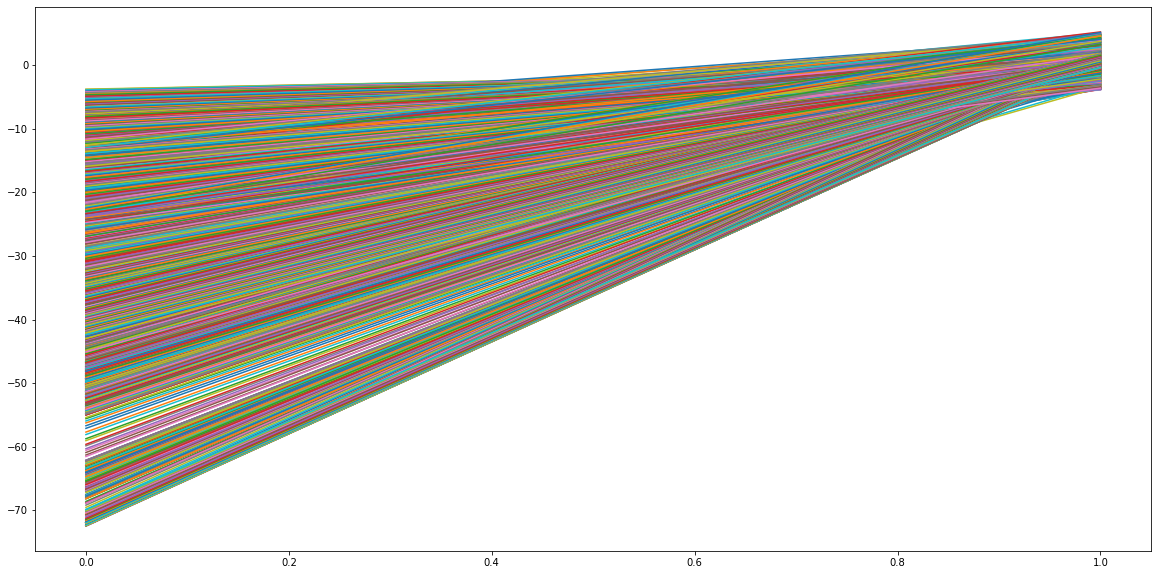

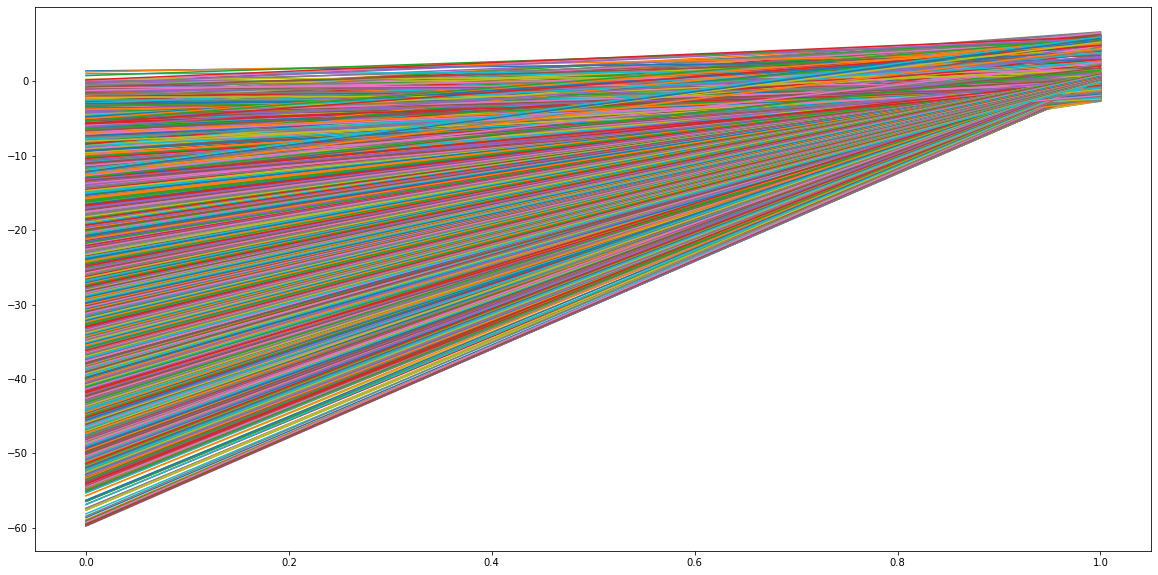

In [251]:
import matplotlib.pyplot as plt
import random

input_path = 'dataset/preprocess2/input3-2/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

328556
29349


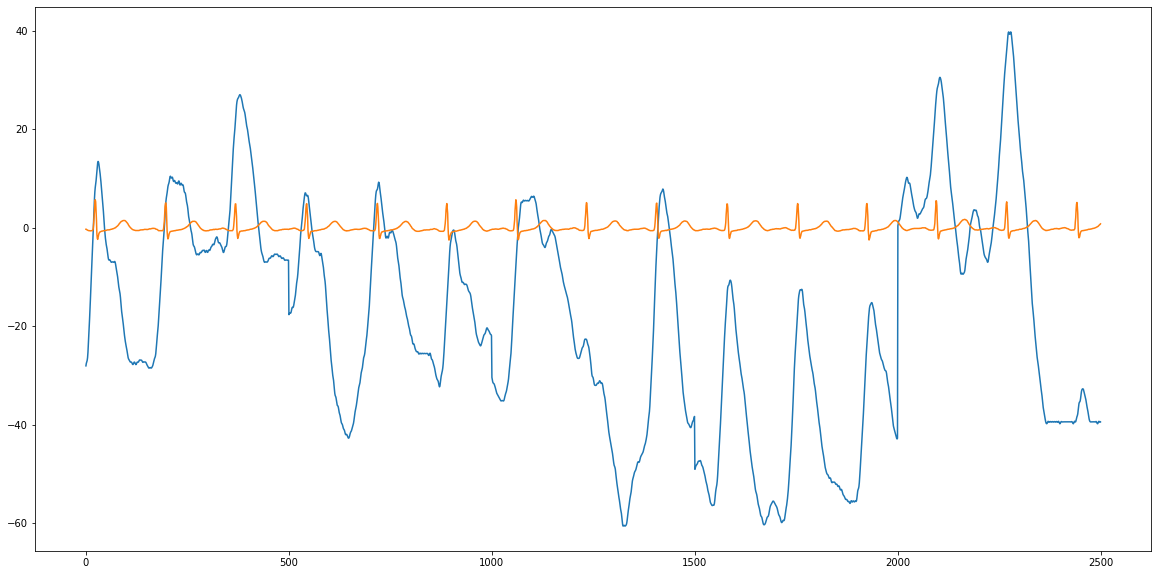

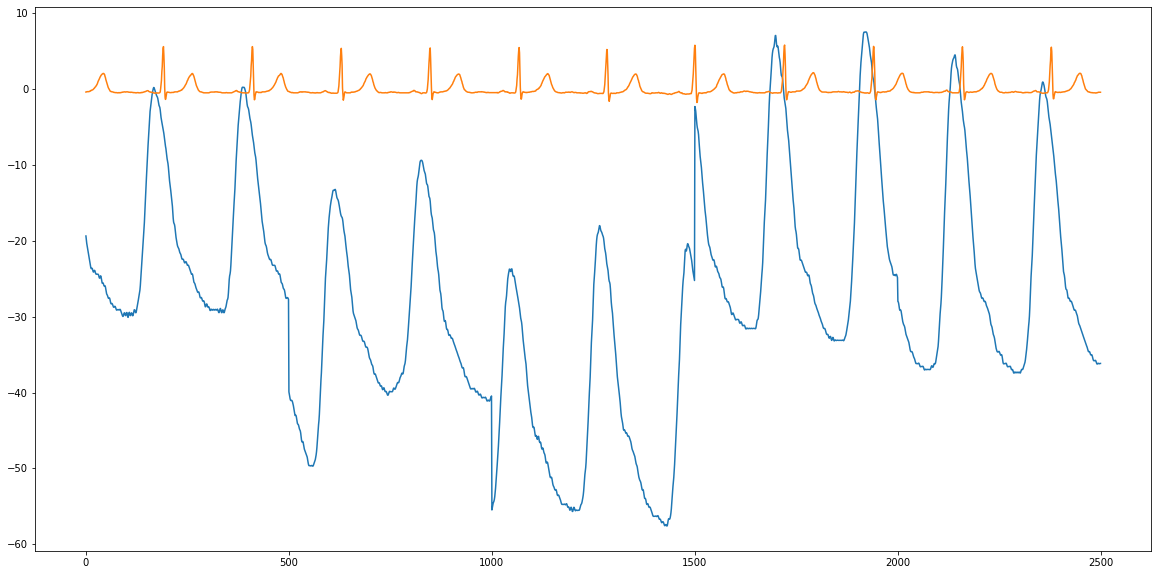

In [194]:
# preprocess1/PPG100Hz_ECG250Hz/input2-1/
ran_n = random.randint(1, len(x_train))
print(ran_n)
plt.figure(figsize=(20,10))
plt.plot(x_train[ran_n])


ran_n = random.randint(1, len(x_test))
print(ran_n)
plt.figure(figsize=(20,10))
plt.plot(x_test[ran_n])

49940
5371


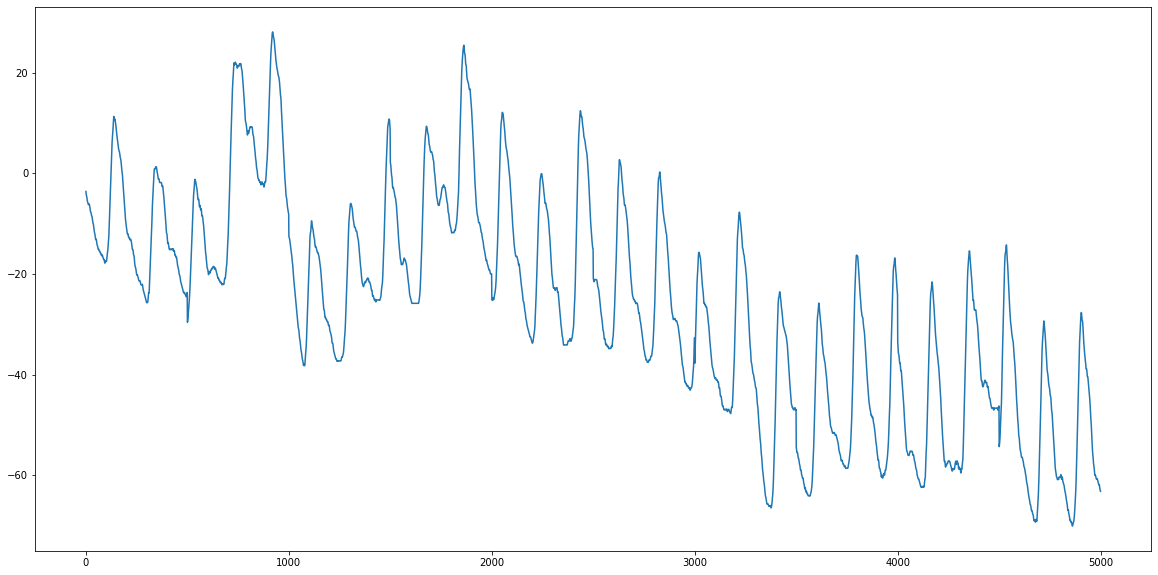

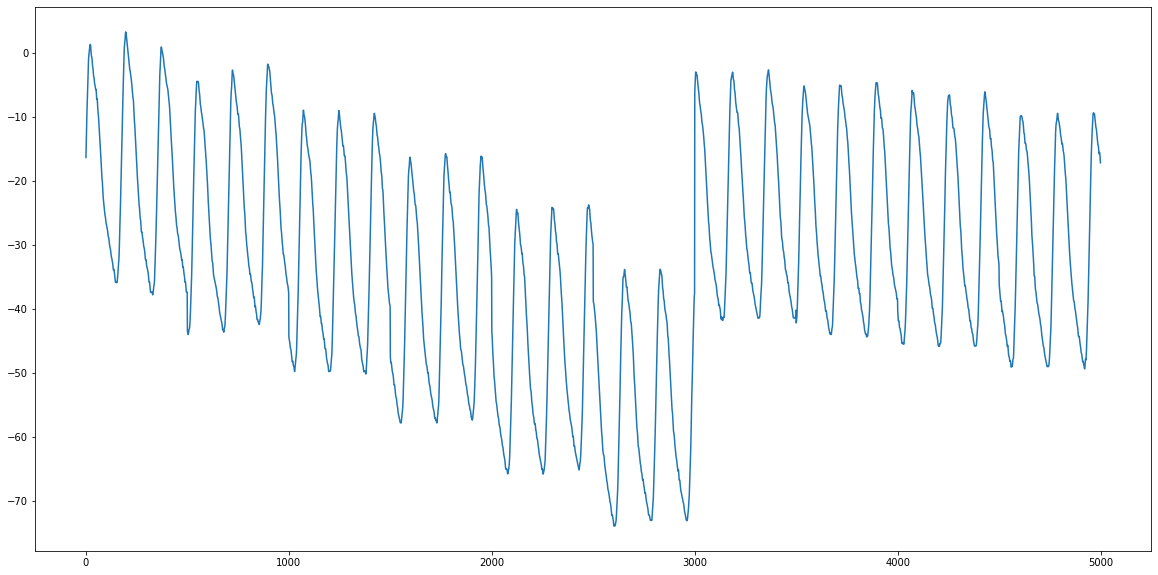

In [252]:
# preprocess2/input3-2/
ran_n = random.randint(1, len(x_train))
print(ran_n)
plt.figure(figsize=(20,10))
plt.plot(x_train[ran_n,0,:])

ran_n = random.randint(1, len(x_test))
print(ran_n)
plt.figure(figsize=(20,10))
plt.plot(x_test[ran_n,0,:])

In [265]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal

# settings
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 길이는 10초

### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


# find idx
idx = 0
train_filepaths = []
test_filepaths = []

input_path = 'dataset/preprocess2/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess2/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        # 한 NRS에 대해 51개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                idx += 1
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    test_filepaths.append((row['file_path'],i+1))
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    train_filepaths.append((row['file_path'],i+1))
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
  
        print('completed')
    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8294 ...completed
loading data 2/8294 ...completed
loading data 3/8294 ...completed
loading data 4/8294 ...completed
loading data 5/8294 ...completed
loading data 6/8294 ...completed
loading data 7/8294 ...completed
loading data 8/8294 ...completed
loading data 9/8294 ...completed
loading data 10/8294 ...completed
loading data 11/8294 ...completed
loading data 12/8294 ...completed
loading data 13/8294 ...completed
loading data 14/8294 ...completed
loading data 15/8294 ...completed
loading data 16/8294 ...completed
loading data 17/8294 ...completed
loading data 18/8294 ...completed
loading data 19/8294 ...completed
loading data 20/8294 ...completed
loading data 21/8294 ...completed
loading data 22/8294 ...completed
loading data 23/8294 ...completed
loading data 24/8294 ...completed
loading data 25/8294 ...completed
loading data 26/8294 ...completed
loading data 27/8294 ...completed
loading data 28/8294 ...completed
loading data 29/8294 ...completed
loading data 30/8294 ..

loading data 244/8294 ...completed
loading data 245/8294 ...completed
loading data 246/8294 ...completed
loading data 247/8294 ...completed
loading data 248/8294 ...completed
loading data 249/8294 ...completed
loading data 250/8294 ...completed
loading data 251/8294 ...completed
loading data 252/8294 ...completed
loading data 253/8294 ...completed
loading data 254/8294 ...completed
loading data 255/8294 ...completed
loading data 256/8294 ...completed
loading data 257/8294 ...completed
loading data 258/8294 ...completed
loading data 259/8294 ...completed
loading data 260/8294 ...completed
loading data 261/8294 ...completed
loading data 262/8294 ...completed
loading data 263/8294 ...completed
loading data 264/8294 ...completed
loading data 265/8294 ...completed
loading data 266/8294 ...completed
loading data 267/8294 ...completed
loading data 268/8294 ...completed
loading data 269/8294 ...completed
loading data 270/8294 ...completed
loading data 271/8294 ...completed
loading data 272/829

loading data 479/8294 ...completed
loading data 480/8294 ...completed
loading data 481/8294 ...completed
loading data 482/8294 ...completed
loading data 483/8294 ...completed
loading data 484/8294 ...completed
loading data 485/8294 ...completed
loading data 486/8294 ...completed
loading data 487/8294 ...completed
loading data 488/8294 ...completed
loading data 489/8294 ...completed
loading data 490/8294 ...completed
loading data 491/8294 ...completed
loading data 492/8294 ...completed
loading data 493/8294 ...completed
loading data 494/8294 ...completed
loading data 495/8294 ...completed
loading data 496/8294 ...completed
loading data 497/8294 ...completed
loading data 498/8294 ...completed
loading data 499/8294 ...completed
loading data 500/8294 ...completed
loading data 501/8294 ...completed
loading data 502/8294 ...completed
loading data 503/8294 ...completed
loading data 504/8294 ...completed
loading data 505/8294 ...completed
loading data 506/8294 ...completed
loading data 507/829

loading data 720/8294 ...completed
loading data 721/8294 ...completed
loading data 722/8294 ...completed
loading data 723/8294 ...completed
loading data 724/8294 ...completed
loading data 725/8294 ...completed
loading data 726/8294 ...completed
loading data 727/8294 ...completed
loading data 728/8294 ...completed
loading data 729/8294 ...completed
loading data 730/8294 ...completed
loading data 731/8294 ...completed
loading data 732/8294 ...completed
loading data 733/8294 ...completed
loading data 734/8294 ...completed
loading data 735/8294 ...completed
loading data 736/8294 ...completed
loading data 737/8294 ...completed
loading data 738/8294 ...completed
loading data 739/8294 ...completed
loading data 740/8294 ...completed
loading data 741/8294 ...completed
loading data 742/8294 ...completed
loading data 743/8294 ...completed
loading data 744/8294 ...completed
loading data 745/8294 ...completed
loading data 746/8294 ...completed
loading data 747/8294 ...completed
loading data 748/829

loading data 963/8294 ...completed
loading data 964/8294 ...completed
loading data 965/8294 ...completed
loading data 966/8294 ...completed
loading data 967/8294 ...completed
loading data 968/8294 ...completed
loading data 969/8294 ...completed
loading data 970/8294 ...completed
loading data 971/8294 ...completed
loading data 972/8294 ...completed
loading data 973/8294 ...completed
loading data 974/8294 ...completed
loading data 975/8294 ...completed
loading data 976/8294 ...completed
loading data 977/8294 ...completed
loading data 978/8294 ...completed
loading data 979/8294 ...completed
loading data 980/8294 ...completed
loading data 981/8294 ...completed
loading data 982/8294 ...completed
loading data 983/8294 ...completed
loading data 984/8294 ...completed
loading data 985/8294 ...completed
loading data 986/8294 ...completed
loading data 987/8294 ...completed
loading data 988/8294 ...completed
loading data 989/8294 ...completed
loading data 990/8294 ...completed
loading data 991/829

loading data 1198/8294 ...completed
loading data 1199/8294 ...completed
loading data 1200/8294 ...completed
loading data 1201/8294 ...completed
loading data 1202/8294 ...completed
loading data 1203/8294 ...completed
loading data 1204/8294 ...completed
loading data 1205/8294 ...completed
loading data 1206/8294 ...completed
loading data 1207/8294 ...completed
loading data 1208/8294 ...completed
loading data 1209/8294 ...completed
loading data 1210/8294 ...completed
loading data 1211/8294 ...completed
loading data 1212/8294 ...completed
loading data 1213/8294 ...completed
loading data 1214/8294 ...completed
loading data 1215/8294 ...completed
loading data 1216/8294 ...completed
loading data 1217/8294 ...completed
loading data 1218/8294 ...completed
loading data 1219/8294 ...completed
loading data 1220/8294 ...completed
loading data 1221/8294 ...completed
loading data 1222/8294 ...completed
loading data 1223/8294 ...completed
loading data 1224/8294 ...completed
loading data 1225/8294 ...co

loading data 1435/8294 ...completed
loading data 1436/8294 ...completed
loading data 1437/8294 ...completed
loading data 1438/8294 ...completed
loading data 1439/8294 ...completed
loading data 1440/8294 ...completed
loading data 1441/8294 ...completed
loading data 1442/8294 ...completed
loading data 1443/8294 ...completed
loading data 1444/8294 ...completed
loading data 1445/8294 ...completed
loading data 1446/8294 ...completed
loading data 1447/8294 ...completed
loading data 1448/8294 ...completed
loading data 1449/8294 ...completed
loading data 1450/8294 ...completed
loading data 1451/8294 ...completed
loading data 1452/8294 ...completed
loading data 1453/8294 ...completed
loading data 1454/8294 ...completed
loading data 1455/8294 ...completed
loading data 1456/8294 ...completed
loading data 1457/8294 ...completed
loading data 1458/8294 ...completed
loading data 1459/8294 ...completed
loading data 1460/8294 ...completed
loading data 1461/8294 ...completed
loading data 1462/8294 ...co

loading data 1672/8294 ...completed
loading data 1673/8294 ...completed
loading data 1674/8294 ...completed
loading data 1675/8294 ...completed
loading data 1676/8294 ...completed
loading data 1677/8294 ...completed
loading data 1678/8294 ...completed
loading data 1679/8294 ...completed
loading data 1680/8294 ...completed
loading data 1681/8294 ...completed
loading data 1682/8294 ...completed
loading data 1683/8294 ...completed
loading data 1684/8294 ...completed
loading data 1685/8294 ...completed
loading data 1686/8294 ...completed
loading data 1687/8294 ...completed
loading data 1688/8294 ...completed
loading data 1689/8294 ...completed
loading data 1690/8294 ...completed
loading data 1691/8294 ...completed
loading data 1692/8294 ...completed
loading data 1693/8294 ...completed
loading data 1694/8294 ...completed
loading data 1695/8294 ...completed
loading data 1696/8294 ...completed
loading data 1697/8294 ...completed
loading data 1698/8294 ...completed
loading data 1699/8294 ...co

loading data 1902/8294 ...completed
loading data 1903/8294 ...completed
loading data 1904/8294 ...completed
loading data 1905/8294 ...completed
loading data 1906/8294 ...completed
loading data 1907/8294 ...completed
loading data 1908/8294 ...completed
loading data 1909/8294 ...completed
loading data 1910/8294 ...completed
loading data 1911/8294 ...completed
loading data 1912/8294 ...completed
loading data 1913/8294 ...completed
loading data 1914/8294 ...completed
loading data 1915/8294 ...completed
loading data 1916/8294 ...completed
loading data 1917/8294 ...completed
loading data 1918/8294 ...completed
loading data 1919/8294 ...completed
loading data 1920/8294 ...completed
loading data 1921/8294 ...completed
loading data 1922/8294 ...completed
loading data 1923/8294 ...completed
loading data 1924/8294 ...completed
loading data 1925/8294 ...completed
loading data 1926/8294 ...completed
loading data 1927/8294 ...completed
loading data 1928/8294 ...completed
loading data 1929/8294 ...co

loading data 2132/8294 ...completed
loading data 2133/8294 ...completed
loading data 2134/8294 ...completed
loading data 2135/8294 ...completed
loading data 2136/8294 ...completed
loading data 2137/8294 ...completed
loading data 2138/8294 ...completed
loading data 2139/8294 ...completed
loading data 2140/8294 ...completed
loading data 2141/8294 ...completed
loading data 2142/8294 ...completed
loading data 2143/8294 ...completed
loading data 2144/8294 ...completed
loading data 2145/8294 ...completed
loading data 2146/8294 ...completed
loading data 2147/8294 ...completed
loading data 2148/8294 ...completed
loading data 2149/8294 ...completed
loading data 2150/8294 ...completed
loading data 2151/8294 ...completed
loading data 2152/8294 ...completed
loading data 2153/8294 ...completed
loading data 2154/8294 ...completed
loading data 2155/8294 ...completed
loading data 2156/8294 ...completed
loading data 2157/8294 ...completed
loading data 2158/8294 ...completed
loading data 2159/8294 ...co

loading data 2370/8294 ...completed
loading data 2371/8294 ...completed
loading data 2372/8294 ...completed
loading data 2373/8294 ...completed
loading data 2374/8294 ...completed
loading data 2375/8294 ...completed
loading data 2376/8294 ...completed
loading data 2377/8294 ...completed
loading data 2378/8294 ...completed
loading data 2379/8294 ...completed
loading data 2380/8294 ...completed
loading data 2381/8294 ...completed
loading data 2382/8294 ...completed
loading data 2383/8294 ...completed
loading data 2384/8294 ...completed
loading data 2385/8294 ...completed
loading data 2386/8294 ...completed
loading data 2387/8294 ...completed
loading data 2388/8294 ...completed
loading data 2389/8294 ...completed
loading data 2390/8294 ...completed
loading data 2391/8294 ...completed
loading data 2392/8294 ...completed
loading data 2393/8294 ...completed
loading data 2394/8294 ...completed
loading data 2395/8294 ...completed
loading data 2396/8294 ...completed
loading data 2397/8294 ...co

loading data 2610/8294 ...completed
loading data 2611/8294 ...completed
loading data 2612/8294 ...completed
loading data 2613/8294 ...completed
loading data 2614/8294 ...completed
loading data 2615/8294 ...completed
loading data 2616/8294 ...completed
loading data 2617/8294 ...completed
loading data 2618/8294 ...completed
loading data 2619/8294 ...completed
loading data 2620/8294 ...completed
loading data 2621/8294 ...completed
loading data 2622/8294 ...completed
loading data 2623/8294 ...completed
loading data 2624/8294 ...completed
loading data 2625/8294 ...completed
loading data 2626/8294 ...completed
loading data 2627/8294 ...completed
loading data 2628/8294 ...completed
loading data 2629/8294 ...completed
loading data 2630/8294 ...completed
loading data 2631/8294 ...completed
loading data 2632/8294 ...completed
loading data 2633/8294 ...completed
loading data 2634/8294 ...completed
loading data 2635/8294 ...completed
loading data 2636/8294 ...completed
loading data 2637/8294 ...co

loading data 3071/8294 ...completed
loading data 3072/8294 ...completed
loading data 3073/8294 ...completed
loading data 3074/8294 ...completed
loading data 3075/8294 ...completed
loading data 3076/8294 ...completed
loading data 3077/8294 ...completed
loading data 3078/8294 ...completed
loading data 3079/8294 ...completed
loading data 3080/8294 ...completed
loading data 3081/8294 ...completed
loading data 3082/8294 ...completed
loading data 3083/8294 ...completed
loading data 3084/8294 ...completed
loading data 3085/8294 ...completed
loading data 3086/8294 ...completed
loading data 3087/8294 ...completed
loading data 3088/8294 ...completed
loading data 3089/8294 ...completed
loading data 3090/8294 ...completed
loading data 3091/8294 ...completed
loading data 3092/8294 ...completed
loading data 3093/8294 ...completed
loading data 3094/8294 ...completed
loading data 3095/8294 ...completed
loading data 3096/8294 ...completed
loading data 3097/8294 ...completed
loading data 3098/8294 ...co

loading data 3305/8294 ...completed
loading data 3306/8294 ...completed
loading data 3307/8294 ...completed
loading data 3308/8294 ...completed
loading data 3309/8294 ...completed
loading data 3310/8294 ...completed
loading data 3311/8294 ...completed
loading data 3312/8294 ...completed
loading data 3313/8294 ...completed
loading data 3314/8294 ...completed
loading data 3315/8294 ...completed
loading data 3316/8294 ...completed
loading data 3317/8294 ...completed
loading data 3318/8294 ...completed
loading data 3319/8294 ...completed
loading data 3320/8294 ...completed
loading data 3321/8294 ...completed
loading data 3322/8294 ...completed
loading data 3323/8294 ...completed
loading data 3324/8294 ...completed
loading data 3325/8294 ...completed
loading data 3326/8294 ...completed
loading data 3327/8294 ...completed
loading data 3328/8294 ...completed
loading data 3329/8294 ...completed
loading data 3330/8294 ...completed
loading data 3331/8294 ...completed
loading data 3332/8294 ...co

loading data 3541/8294 ...completed
loading data 3542/8294 ...completed
loading data 3543/8294 ...completed
loading data 3544/8294 ...completed
loading data 3545/8294 ...completed
loading data 3546/8294 ...completed
loading data 3547/8294 ...completed
loading data 3548/8294 ...completed
loading data 3549/8294 ...completed
loading data 3550/8294 ...completed
loading data 3551/8294 ...completed
loading data 3552/8294 ...completed
loading data 3553/8294 ...completed
loading data 3554/8294 ...completed
loading data 3555/8294 ...completed
loading data 3556/8294 ...completed
loading data 3557/8294 ...completed
loading data 3558/8294 ...completed
loading data 3559/8294 ...completed
loading data 3560/8294 ...completed
loading data 3561/8294 ...completed
loading data 3562/8294 ...completed
loading data 3563/8294 ...completed
loading data 3564/8294 ...completed
loading data 3565/8294 ...completed
loading data 3566/8294 ...completed
loading data 3567/8294 ...completed
loading data 3568/8294 ...co

loading data 3780/8294 ...completed
loading data 3781/8294 ...completed
loading data 3782/8294 ...completed
loading data 3783/8294 ...completed
loading data 3784/8294 ...completed
loading data 3785/8294 ...completed
loading data 3786/8294 ...completed
loading data 3787/8294 ...completed
loading data 3788/8294 ...completed
loading data 3789/8294 ...completed
loading data 3790/8294 ...completed
loading data 3791/8294 ...completed
loading data 3792/8294 ...completed
loading data 3793/8294 ...completed
loading data 3794/8294 ...completed
loading data 3795/8294 ...completed
loading data 3796/8294 ...completed
loading data 3797/8294 ...completed
loading data 3798/8294 ...completed
loading data 3799/8294 ...completed
loading data 3800/8294 ...completed
loading data 3801/8294 ...completed
loading data 3802/8294 ...completed
loading data 3803/8294 ...completed
loading data 3804/8294 ...completed
loading data 3805/8294 ...completed
loading data 3806/8294 ...completed
loading data 3807/8294 ...co

loading data 4010/8294 ...completed
loading data 4011/8294 ...completed
loading data 4012/8294 ...completed
loading data 4013/8294 ...completed
loading data 4014/8294 ...completed
loading data 4015/8294 ...completed
loading data 4016/8294 ...completed
loading data 4017/8294 ...completed
loading data 4018/8294 ...completed
loading data 4019/8294 ...completed
loading data 4020/8294 ...completed
loading data 4021/8294 ...completed
loading data 4022/8294 ...completed
loading data 4023/8294 ...completed
loading data 4024/8294 ...completed
loading data 4025/8294 ...completed
loading data 4026/8294 ...completed
loading data 4027/8294 ...completed
loading data 4028/8294 ...completed
loading data 4029/8294 ...completed
loading data 4030/8294 ...completed
loading data 4031/8294 ...completed
loading data 4032/8294 ...completed
loading data 4033/8294 ...completed
loading data 4034/8294 ...completed
loading data 4035/8294 ...completed
loading data 4036/8294 ...completed
loading data 4037/8294 ...co

loading data 4245/8294 ...completed
loading data 4246/8294 ...completed
loading data 4247/8294 ...completed
loading data 4248/8294 ...completed
loading data 4249/8294 ...completed
loading data 4250/8294 ...completed
loading data 4251/8294 ...completed
loading data 4252/8294 ...completed
loading data 4253/8294 ...completed
loading data 4254/8294 ...completed
loading data 4255/8294 ...completed
loading data 4256/8294 ...completed
loading data 4257/8294 ...completed
loading data 4258/8294 ...completed
loading data 4259/8294 ...completed
loading data 4260/8294 ...completed
loading data 4261/8294 ...completed
loading data 4262/8294 ...completed
loading data 4263/8294 ...completed
loading data 4264/8294 ...completed
loading data 4265/8294 ...completed
loading data 4266/8294 ...completed
loading data 4267/8294 ...completed
loading data 4268/8294 ...completed
loading data 4269/8294 ...completed
loading data 4270/8294 ...completed
loading data 4271/8294 ...completed
loading data 4272/8294 ...co

loading data 4473/8294 ...completed
loading data 4474/8294 ...completed
loading data 4475/8294 ...completed
loading data 4476/8294 ...completed
loading data 4477/8294 ...completed
loading data 4478/8294 ...completed
loading data 4479/8294 ...completed
loading data 4480/8294 ...completed
loading data 4481/8294 ...completed
loading data 4482/8294 ...completed
loading data 4483/8294 ...completed
loading data 4484/8294 ...completed
loading data 4485/8294 ...completed
loading data 4486/8294 ...completed
loading data 4487/8294 ...completed
loading data 4488/8294 ...completed
loading data 4489/8294 ...completed
loading data 4490/8294 ...completed
loading data 4491/8294 ...completed
loading data 4492/8294 ...completed
loading data 4493/8294 ...completed
loading data 4494/8294 ...completed
loading data 4495/8294 ...completed
loading data 4496/8294 ...completed
loading data 4497/8294 ...completed
loading data 4498/8294 ...completed
loading data 4499/8294 ...completed
loading data 4500/8294 ...co

loading data 4709/8294 ...completed
loading data 4710/8294 ...completed
loading data 4711/8294 ...completed
loading data 4712/8294 ...completed
loading data 4713/8294 ...completed
loading data 4714/8294 ...completed
loading data 4715/8294 ...completed
loading data 4716/8294 ...completed
loading data 4717/8294 ...completed
loading data 4718/8294 ...completed
loading data 4719/8294 ...completed
loading data 4720/8294 ...completed
loading data 4721/8294 ...completed
loading data 4722/8294 ...completed
loading data 4723/8294 ...completed
loading data 4724/8294 ...completed
loading data 4725/8294 ...completed
loading data 4726/8294 ...completed
loading data 4727/8294 ...completed
loading data 4728/8294 ...completed
loading data 4729/8294 ...completed
loading data 4730/8294 ...completed
loading data 4731/8294 ...completed
loading data 4732/8294 ...completed
loading data 4733/8294 ...completed
loading data 4734/8294 ...completed
loading data 4735/8294 ...completed
loading data 4736/8294 ...co

loading data 4939/8294 ...completed
loading data 4940/8294 ...completed
loading data 4941/8294 ...completed
loading data 4942/8294 ...completed
loading data 4943/8294 ...completed
loading data 4944/8294 ...completed
loading data 4945/8294 ...completed
loading data 4946/8294 ...completed
loading data 4947/8294 ...completed
loading data 4948/8294 ...completed
loading data 4949/8294 ...completed
loading data 4950/8294 ...completed
loading data 4951/8294 ...completed
loading data 4952/8294 ...completed
loading data 4953/8294 ...completed
loading data 4954/8294 ...completed
loading data 4955/8294 ...completed
loading data 4956/8294 ...completed
loading data 4957/8294 ...completed
loading data 4958/8294 ...completed
loading data 4959/8294 ...completed
loading data 4960/8294 ...completed
loading data 4961/8294 ...completed
loading data 4962/8294 ...completed
loading data 4963/8294 ...completed
loading data 4964/8294 ...completed
loading data 4965/8294 ...completed
loading data 4966/8294 ...co

loading data 5167/8294 ...completed
loading data 5168/8294 ...completed
loading data 5169/8294 ...completed
loading data 5170/8294 ...completed
loading data 5171/8294 ...completed
loading data 5172/8294 ...completed
loading data 5173/8294 ...completed
loading data 5174/8294 ...completed
loading data 5175/8294 ...completed
loading data 5176/8294 ...completed
loading data 5177/8294 ...completed
loading data 5178/8294 ...completed
loading data 5179/8294 ...completed
loading data 5180/8294 ...completed
loading data 5181/8294 ...completed
loading data 5182/8294 ...completed
loading data 5183/8294 ...completed
loading data 5184/8294 ...completed
loading data 5185/8294 ...completed
loading data 5186/8294 ...completed
loading data 5187/8294 ...completed
loading data 5188/8294 ...completed
loading data 5189/8294 ...completed
loading data 5190/8294 ...completed
loading data 5191/8294 ...completed
loading data 5192/8294 ...completed
loading data 5193/8294 ...completed
loading data 5194/8294 ...co

loading data 5401/8294 ...completed
loading data 5402/8294 ...completed
loading data 5403/8294 ...completed
loading data 5404/8294 ...completed
loading data 5405/8294 ...completed
loading data 5406/8294 ...completed
loading data 5407/8294 ...completed
loading data 5408/8294 ...completed
loading data 5409/8294 ...completed
loading data 5410/8294 ...completed
loading data 5411/8294 ...completed
loading data 5412/8294 ...completed
loading data 5413/8294 ...completed
loading data 5414/8294 ...completed
loading data 5415/8294 ...completed
loading data 5416/8294 ...completed
loading data 5417/8294 ...completed
loading data 5418/8294 ...completed
loading data 5419/8294 ...completed
loading data 5420/8294 ...completed
loading data 5421/8294 ...completed
loading data 5422/8294 ...completed
loading data 5423/8294 ...completed
loading data 5424/8294 ...completed
loading data 5425/8294 ...completed
loading data 5426/8294 ...completed
loading data 5427/8294 ...completed
loading data 5428/8294 ...co

loading data 5639/8294 ...completed
loading data 5640/8294 ...completed
loading data 5641/8294 ...completed
loading data 5642/8294 ...completed
loading data 5643/8294 ...completed
loading data 5644/8294 ...completed
loading data 5645/8294 ...completed
loading data 5646/8294 ...completed
loading data 5647/8294 ...completed
loading data 5648/8294 ...completed
loading data 5649/8294 ...completed
loading data 5650/8294 ...completed
loading data 5651/8294 ...completed
loading data 5652/8294 ...completed
loading data 5653/8294 ...completed
loading data 5654/8294 ...completed
loading data 5655/8294 ...completed
loading data 5656/8294 ...completed
loading data 5657/8294 ...completed
loading data 5658/8294 ...completed
loading data 5659/8294 ...completed
loading data 5660/8294 ...completed
loading data 5661/8294 ...completed
loading data 5662/8294 ...completed
loading data 5663/8294 ...completed
loading data 5664/8294 ...completed
loading data 5665/8294 ...completed
loading data 5666/8294 ...co

loading data 5868/8294 ...completed
loading data 5869/8294 ...completed
loading data 5870/8294 ...completed
loading data 5871/8294 ...completed
loading data 5872/8294 ...completed
loading data 5873/8294 ...completed
loading data 5874/8294 ...completed
loading data 5875/8294 ...completed
loading data 5876/8294 ...completed
loading data 5877/8294 ...completed
loading data 5878/8294 ...completed
loading data 5879/8294 ...completed
loading data 5880/8294 ...completed
loading data 5881/8294 ...completed
loading data 5882/8294 ...completed
loading data 5883/8294 ...completed
loading data 5884/8294 ...completed
loading data 5885/8294 ...completed
loading data 5886/8294 ...completed
loading data 5887/8294 ...completed
loading data 5888/8294 ...completed
loading data 5889/8294 ...completed
loading data 5890/8294 ...completed
loading data 5891/8294 ...completed
loading data 5892/8294 ...completed
loading data 5893/8294 ...completed
loading data 5894/8294 ...completed
loading data 5895/8294 ...co

loading data 6100/8294 ...completed
loading data 6101/8294 ...completed
loading data 6102/8294 ...completed
loading data 6103/8294 ...completed
loading data 6104/8294 ...completed
loading data 6105/8294 ...completed
loading data 6106/8294 ...completed
loading data 6107/8294 ...completed
loading data 6108/8294 ...completed
loading data 6109/8294 ...completed
loading data 6110/8294 ...completed
loading data 6111/8294 ...completed
loading data 6112/8294 ...completed
loading data 6113/8294 ...completed
loading data 6114/8294 ...completed
loading data 6115/8294 ...completed
loading data 6116/8294 ...completed
loading data 6117/8294 ...completed
loading data 6118/8294 ...completed
loading data 6119/8294 ...completed
loading data 6120/8294 ...completed
loading data 6121/8294 ...completed
loading data 6122/8294 ...completed
loading data 6123/8294 ...completed
loading data 6124/8294 ...completed
loading data 6125/8294 ...completed
loading data 6126/8294 ...completed
loading data 6127/8294 ...co

loading data 6328/8294 ...completed
loading data 6329/8294 ...completed
loading data 6330/8294 ...completed
loading data 6331/8294 ...completed
loading data 6332/8294 ...completed
loading data 6333/8294 ...completed
loading data 6334/8294 ...completed
loading data 6335/8294 ...completed
loading data 6336/8294 ...completed
loading data 6337/8294 ...completed
loading data 6338/8294 ...completed
loading data 6339/8294 ...completed
loading data 6340/8294 ...completed
loading data 6341/8294 ...completed
loading data 6342/8294 ...completed
loading data 6343/8294 ...completed
loading data 6344/8294 ...completed
loading data 6345/8294 ...completed
loading data 6346/8294 ...completed
loading data 6347/8294 ...completed
loading data 6348/8294 ...completed
loading data 6349/8294 ...completed
loading data 6350/8294 ...completed
loading data 6351/8294 ...completed
loading data 6352/8294 ...completed
loading data 6353/8294 ...completed
loading data 6354/8294 ...completed
loading data 6355/8294 ...co

loading data 6556/8294 ...completed
loading data 6557/8294 ...completed
loading data 6558/8294 ...completed
loading data 6559/8294 ...completed
loading data 6560/8294 ...completed
loading data 6561/8294 ...completed
loading data 6562/8294 ...completed
loading data 6563/8294 ...completed
loading data 6564/8294 ...completed
loading data 6565/8294 ...completed
loading data 6566/8294 ...completed
loading data 6567/8294 ...completed
loading data 6568/8294 ...completed
loading data 6569/8294 ...completed
loading data 6570/8294 ...completed
loading data 6571/8294 ...completed
loading data 6572/8294 ...completed
loading data 6573/8294 ...completed
loading data 6574/8294 ...completed
loading data 6575/8294 ...completed
loading data 6576/8294 ...completed
loading data 6577/8294 ...completed
loading data 6578/8294 ...completed
loading data 6579/8294 ...completed
loading data 6580/8294 ...completed
loading data 6581/8294 ...completed
loading data 6582/8294 ...completed
loading data 6583/8294 ...co

loading data 7015/8294 ...completed
loading data 7016/8294 ...completed
loading data 7017/8294 ...completed
loading data 7018/8294 ...completed
loading data 7019/8294 ...completed
loading data 7020/8294 ...completed
loading data 7021/8294 ...completed
loading data 7022/8294 ...completed
loading data 7023/8294 ...completed
loading data 7024/8294 ...completed
loading data 7025/8294 ...completed
loading data 7026/8294 ...completed
loading data 7027/8294 ...completed
loading data 7028/8294 ...completed
loading data 7029/8294 ...completed
loading data 7030/8294 ...completed
loading data 7031/8294 ...completed
loading data 7032/8294 ...completed
loading data 7033/8294 ...completed
loading data 7034/8294 ...completed
loading data 7035/8294 ...completed
loading data 7036/8294 ...completed
loading data 7037/8294 ...completed
loading data 7038/8294 ...completed
loading data 7039/8294 ...completed
loading data 7040/8294 ...completed
loading data 7041/8294 ...completed
loading data 7042/8294 ...co

loading data 7255/8294 ...completed
loading data 7256/8294 ...completed
loading data 7257/8294 ...completed
loading data 7258/8294 ...completed
loading data 7259/8294 ...completed
loading data 7260/8294 ...completed
loading data 7261/8294 ...completed
loading data 7262/8294 ...completed
loading data 7263/8294 ...completed
loading data 7264/8294 ...completed
loading data 7265/8294 ...completed
loading data 7266/8294 ...completed
loading data 7267/8294 ...completed
loading data 7268/8294 ...completed
loading data 7269/8294 ...completed
loading data 7270/8294 ...completed
loading data 7271/8294 ...completed
loading data 7272/8294 ...completed
loading data 7273/8294 ...completed
loading data 7274/8294 ...completed
loading data 7275/8294 ...completed
loading data 7276/8294 ...completed
loading data 7277/8294 ...completed
loading data 7278/8294 ...completed
loading data 7279/8294 ...completed
loading data 7280/8294 ...completed
loading data 7281/8294 ...completed
loading data 7282/8294 ...co

loading data 7485/8294 ...completed
loading data 7486/8294 ...completed
loading data 7487/8294 ...completed
loading data 7488/8294 ...completed
loading data 7489/8294 ...completed
loading data 7490/8294 ...completed
loading data 7491/8294 ...completed
loading data 7492/8294 ...completed
loading data 7493/8294 ...completed
loading data 7494/8294 ...completed
loading data 7495/8294 ...completed
loading data 7496/8294 ...completed
loading data 7497/8294 ...completed
loading data 7498/8294 ...completed
loading data 7499/8294 ...completed
loading data 7500/8294 ...completed
loading data 7501/8294 ...completed
loading data 7502/8294 ...completed
loading data 7503/8294 ...completed
loading data 7504/8294 ...completed
loading data 7505/8294 ...completed
loading data 7506/8294 ...completed
loading data 7507/8294 ...completed
loading data 7508/8294 ...completed
loading data 7509/8294 ...completed
loading data 7510/8294 ...completed
loading data 7511/8294 ...completed
loading data 7512/8294 ...co

loading data 7715/8294 ...completed
loading data 7716/8294 ...completed
loading data 7717/8294 ...completed
loading data 7718/8294 ...completed
loading data 7719/8294 ...completed
loading data 7720/8294 ...completed
loading data 7721/8294 ...completed
loading data 7722/8294 ...completed
loading data 7723/8294 ...completed
loading data 7724/8294 ...completed
loading data 7725/8294 ...completed
loading data 7726/8294 ...completed
loading data 7727/8294 ...completed
loading data 7728/8294 ...completed
loading data 7729/8294 ...completed
loading data 7730/8294 ...completed
loading data 7731/8294 ...completed
loading data 7732/8294 ...completed
loading data 7733/8294 ...completed
loading data 7734/8294 ...completed
loading data 7735/8294 ...completed
loading data 7736/8294 ...completed
loading data 7737/8294 ...completed
loading data 7738/8294 ...completed
loading data 7739/8294 ...completed
loading data 7740/8294 ...completed
loading data 7741/8294 ...completed
loading data 7742/8294 ...co

loading data 7954/8294 ...completed
loading data 7955/8294 ...completed
loading data 7956/8294 ...completed
loading data 7957/8294 ...completed
loading data 7958/8294 ...completed
loading data 7959/8294 ...completed
loading data 7960/8294 ...completed
loading data 7961/8294 ...completed
loading data 7962/8294 ...completed
loading data 7963/8294 ...completed
loading data 7964/8294 ...completed
loading data 7965/8294 ...completed
loading data 7966/8294 ...completed
loading data 7967/8294 ...completed
loading data 7968/8294 ...completed
loading data 7969/8294 ...completed
loading data 7970/8294 ...completed
loading data 7971/8294 ...completed
loading data 7972/8294 ...completed
loading data 7973/8294 ...completed
loading data 7974/8294 ...completed
loading data 7975/8294 ...completed
loading data 7976/8294 ...completed
loading data 7977/8294 ...completed
loading data 7978/8294 ...completed
loading data 7979/8294 ...completed
loading data 7980/8294 ...completed
loading data 7981/8294 ...co

loading data 8187/8294 ...completed
loading data 8188/8294 ...completed
loading data 8189/8294 ...completed
loading data 8190/8294 ...completed
loading data 8191/8294 ...completed
loading data 8192/8294 ...completed
loading data 8193/8294 ...completed
loading data 8194/8294 ...completed
loading data 8195/8294 ...completed
loading data 8196/8294 ...completed
loading data 8197/8294 ...completed
loading data 8198/8294 ...completed
loading data 8199/8294 ...completed
loading data 8200/8294 ...completed
loading data 8201/8294 ...completed
loading data 8202/8294 ...completed
loading data 8203/8294 ...completed
loading data 8204/8294 ...completed
loading data 8205/8294 ...completed
loading data 8206/8294 ...completed
loading data 8207/8294 ...completed
loading data 8208/8294 ...completed
loading data 8209/8294 ...completed
loading data 8210/8294 ...completed
loading data 8211/8294 ...completed
loading data 8212/8294 ...completed
loading data 8213/8294 ...completed
loading data 8214/8294 ...co

In [267]:
num = 49940
filepath, i_x = train_filepaths[num]
target_row = (df_preprocess_pacu[df_preprocess_pacu['file_path']==filepath])

cnt = 0
for lab, content in target_row.iteritems():
    cnt += 1
    if cnt < 5:
        continue
    print('{}: {}, {}'.format(lab, content.values[0][0], content.values[0][2]))

print(i_x)
#target_row['17'].values[0][2]
    
#plt.figure(figsize=(20,10))
#plt.plot()

1: True, [0.08695652173913043, 0.0]
2: True, [0.08695652173913043, 0.0]
3: True, [0.08695652173913043, 0.0]
4: True, [0.08695652173913043, 0.0]
5: True, [0.08695652173913043, 0.0]
6: True, [0.08333333333333333, 0.0]
7: True, [0.08695652173913043, 0.0]
8: True, [0.041666666666666664, 0.0]
9: True, [0.0, 0.0]
10: True, [0.0, 0.0]
11: True, [0.0, 0.0]
12: True, [0.0, 0.0]
13: True, [0.0, 0.0]
14: True, [0.0, 0.0]
15: True, [0.0, 0.0]
16: True, [0.0, 0.0]
17: True, [0.0, 0.0]
18: True, [0.0, 0.0]
19: True, [0.0, 0.0]
20: True, [0.0, 0.0]
21: True, [0.0, 0.0]
22: True, [0.0, 0.0]
23: True, [0.041666666666666664, 0.041666666666666664]
24: True, [0.125, 0.041666666666666664]
25: True, [0.16666666666666666, 0.0]
26: True, [0.16666666666666666, 0.0]
27: True, [0.16666666666666666, 0.0]
28: True, [0.16, 0.0]
29: True, [0.16, 0.0]
30: True, [0.16, 0.0]
31: True, [0.16, 0.0]
32: True, [0.15384615384615385, 0.0]
33: True, [0.07692307692307693, 0.0]
34: True, [0.04, 0.0]
35: True, [0.0, 0.0]
36: Tru

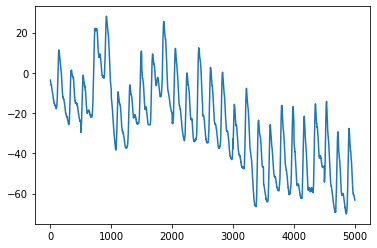

In [266]:
x_pleth = np.array(x_train_pacu)[num,0,:]
plt.plot(x_pleth)

## noise 

In [270]:
import os, sys
import pickle
import pandas as pd
import numpy as np

# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)



### input 설정
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


# vital data 저장 경로
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)


SRATE, f_num = 100, 0
for f_vital in f_vital_list[0:]:
    f_num += 1
    
    
    if not filepath == f_vital:
        continue
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # ppg, ecg peaks 불러오기
    # peaks가 없는 경우는 ECG나 PPG data가 없는 case들
    if not os.path.exists(preprocess_path+'cache/PPG_peaks/'+f_vital):
        print('no existing PPG peaks: ', f_vital)
        continue
    if not os.path.exists(preprocess_path+'cache/ECG_peaks/'+f_vital):
        print('no existing ECG peaks: ', f_vital)
        continue
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
        
    ppg_min, ppg_peak = pickle.load(open(preprocess_path+'cache/PPG_peaks/'+f_vital, 'rb'))
    ecg_peak = pickle.load(open(preprocess_path+'cache/ECG_peaks/'+f_vital, 'rb'))
    
    ppg_min, ppg_peak = np.array([ppg_min]), np.array([ppg_peak])
    ecg_peak= np.array([ecg_peak])
    
    
    # 10초 단위로 끊기
    for i in range(30,51):
        if i != 30:
            continue
            
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        seg_ppg, seg_ecg = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ppg[0:len(df_vital_input)] = df_vital_input['Pleth'].tolist()
        seg_ecg[0:len(df_vital_input)] = df_vital_input['ECG'].tolist()
    
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)
            
        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.3 or nan_ecg_perc > 0.3 or nan_both_perc > 0.2:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            continue
            
        

        ### 2. Noise 처리 ###
        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak[(start_idx<=ppg_peak) & (ppg_peak<end_idx)] - start_idx
        idx_ecg_peak = ecg_peak[(start_idx<=ecg_peak) & (ecg_peak<end_idx)] - start_idx
        
        # peak가 5개 이하는 noise가 많이 낀 상황 (10초 구간 중 peak가 7초 이상 없으면 문제 -> 즉 peak 개수 범위는 7/2 ~ 7/0.4)
        # 따라서 peak가 7초 이상 있어야하고 이때 최소 peak 개수는 3.5개 (20초면 7이하)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<=4 or len(idx_ecg_peak)<=4:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            continue

            
        # 10초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 40 < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 200:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 40 < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 200:
                bool_noise_ecg[k] = True
                
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 200
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])
        
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        corrcoef_list = []
        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            corrcoef_list.append(np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1])
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)
        
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            #corrcoef_list.append(np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1])
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.3 and nan_ecg_perc < 0.3 and nan_both_perc < 0.2 and noise_ppg_perc < 0.3 and noise_ecg_perc < 0.3:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)   
        
        if i==30:
            break
    if i==30:
        break
        


###Input 4028 / 8318: 4.0,4099,PACU1_7_200228_121855.csv###


In [271]:
corrcoef_list

[0.9702272979349279,
 0.9888040356294606,
 0.7505710967824275,
 0.981977089312215,
 0.8167761433546082,
 0.9960277732058848,
 0.8668694051582772,
 0.9829428426568788,
 0.88534005638294,
 0.9789869395382842,
 0.9687377890043255,
 0.9761809494930865,
 0.9775489811800758,
 0.9958389589522861,
 0.9728489831253659,
 0.9872803592336401,
 0.9559958049957354,
 0.9948136134593276,
 0.9823523911590292,
 0.9950172399589031,
 0.9802991012923729,
 0.9371189384386251,
 0.9499458012372979,
 0.9820846399412637,
 0.9935196064882262]

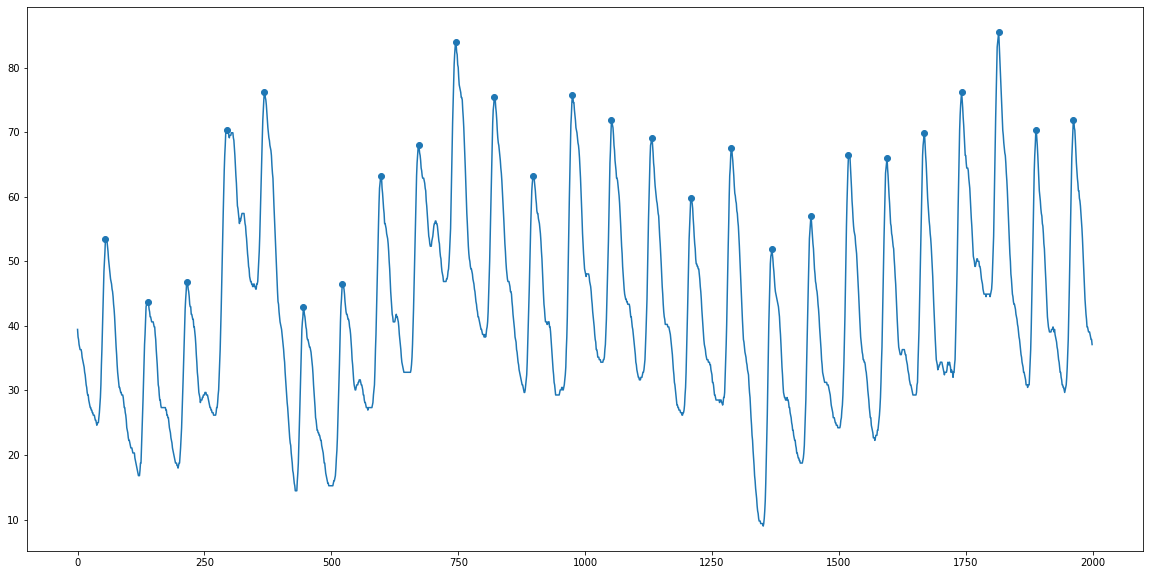

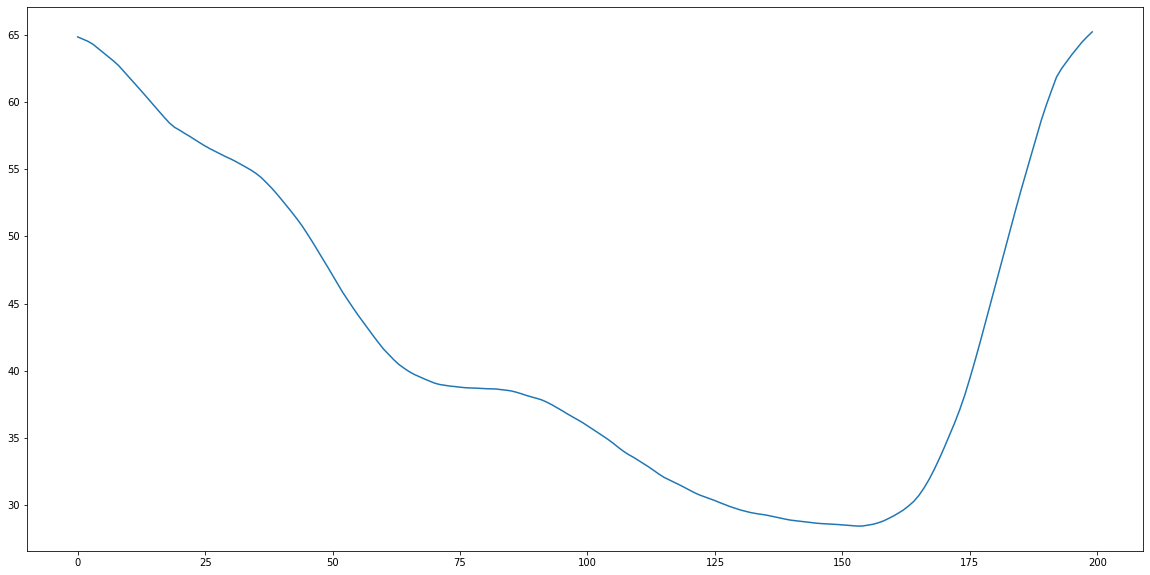

In [272]:
plt.figure(figsize=(20,10))
plt.plot(seg_ppg)
plt.scatter(idx_ppg_peak, val_ppg_peak)

plt.figure(figsize=(20,10))
plt.plot(mean_wave_ppg)

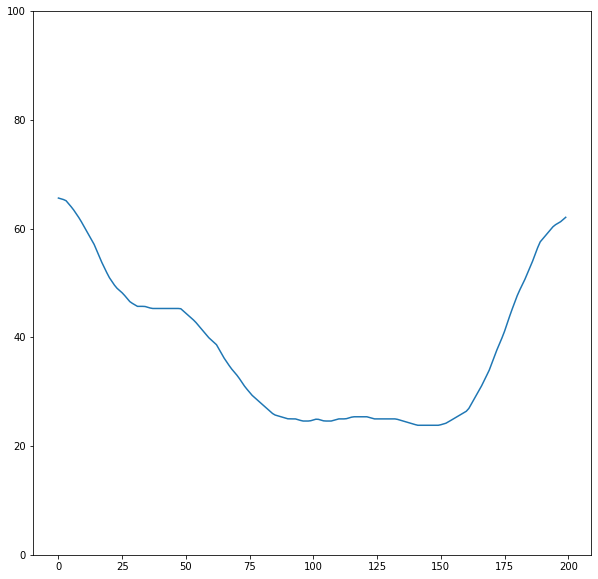

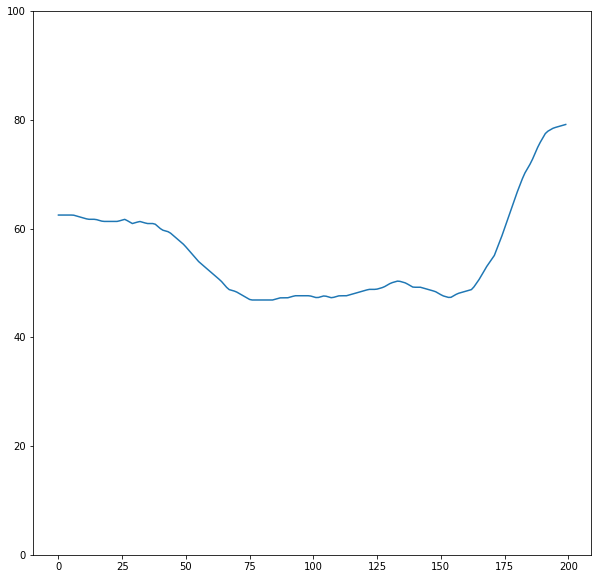

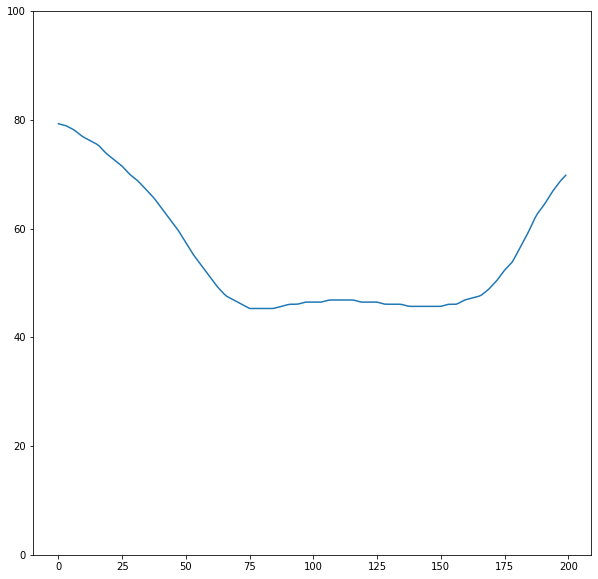

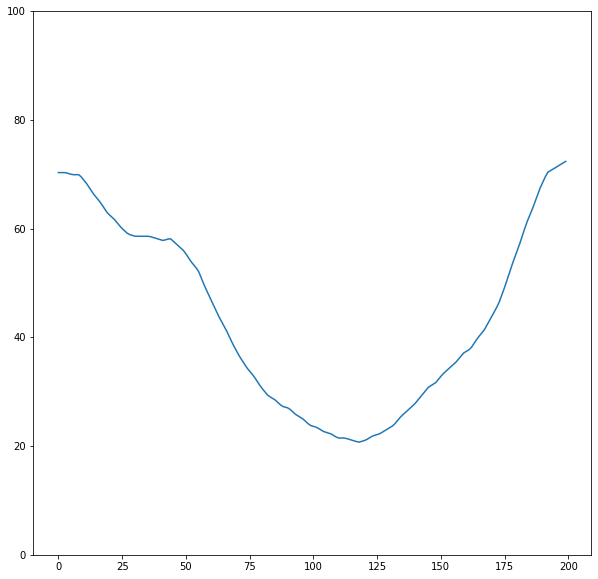

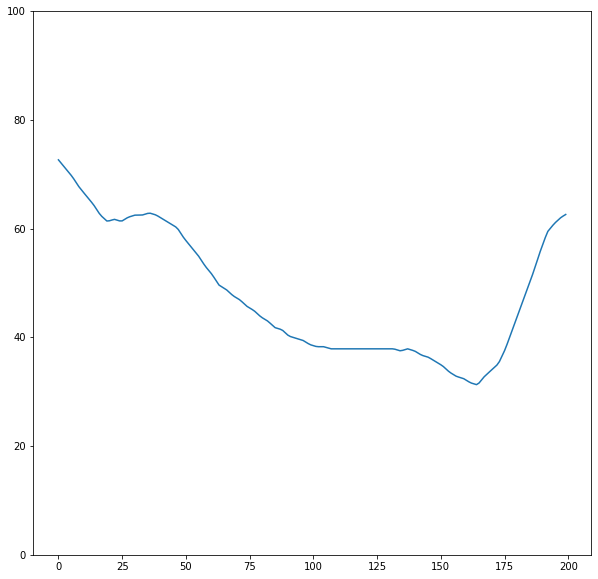

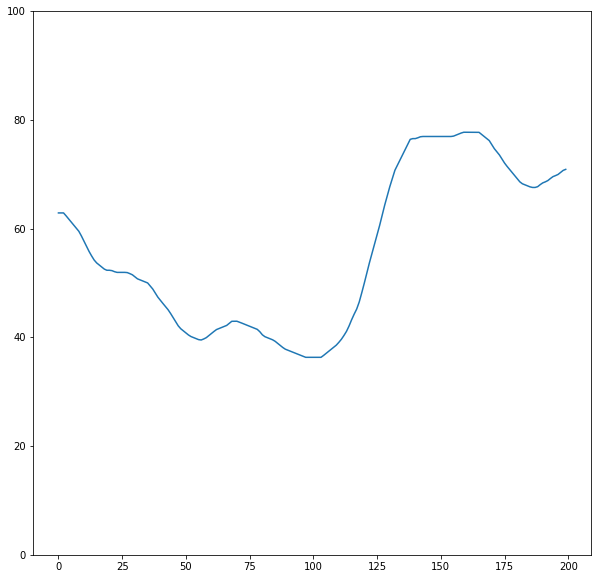

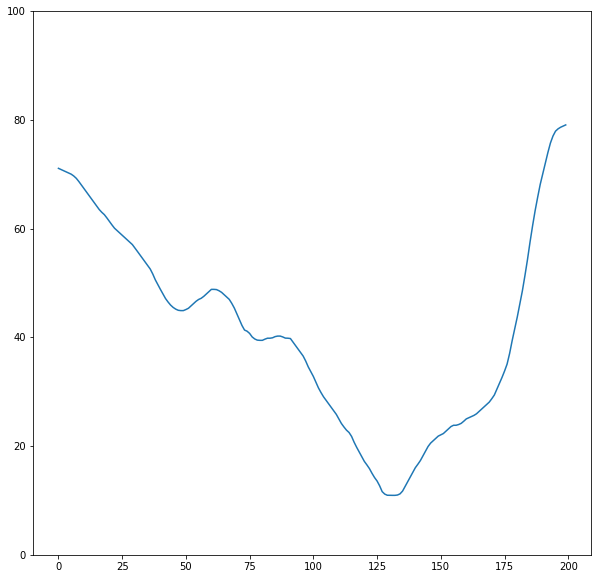

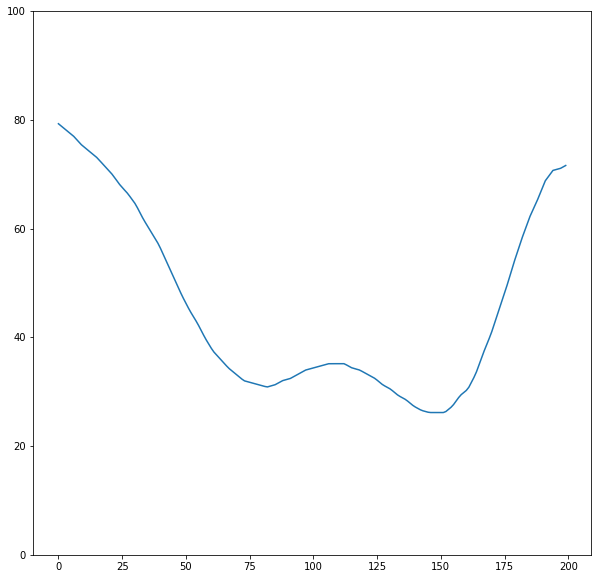

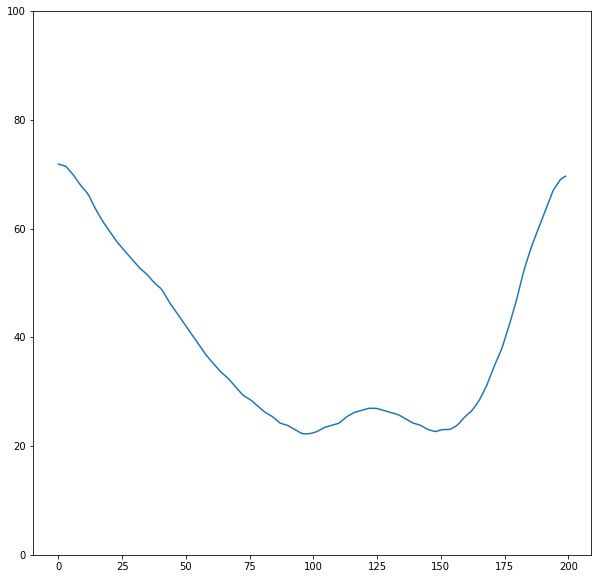

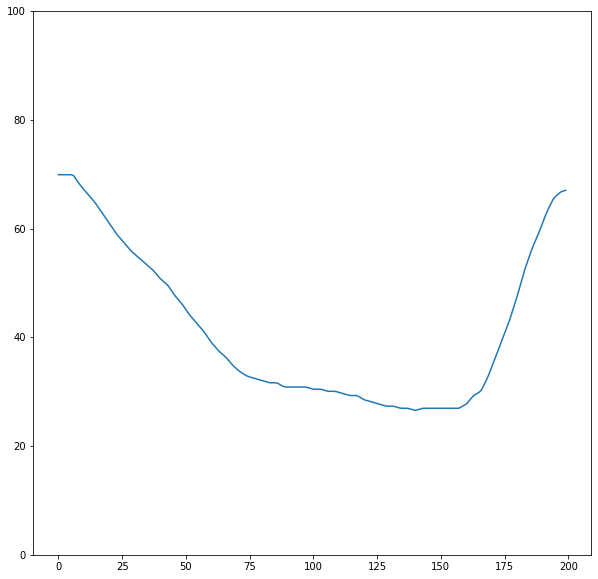

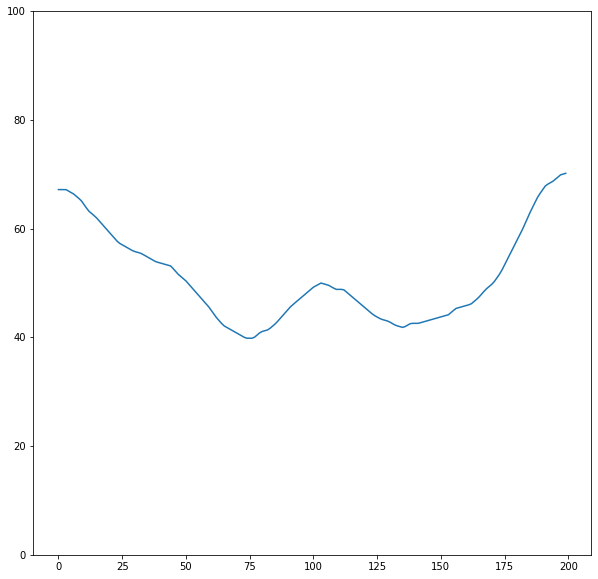

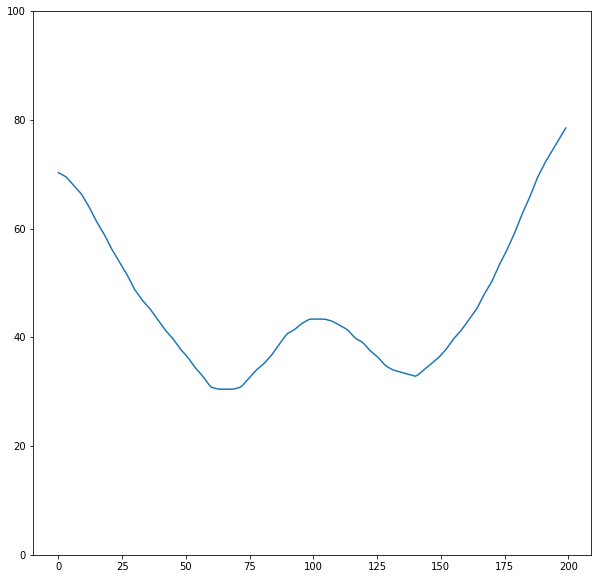

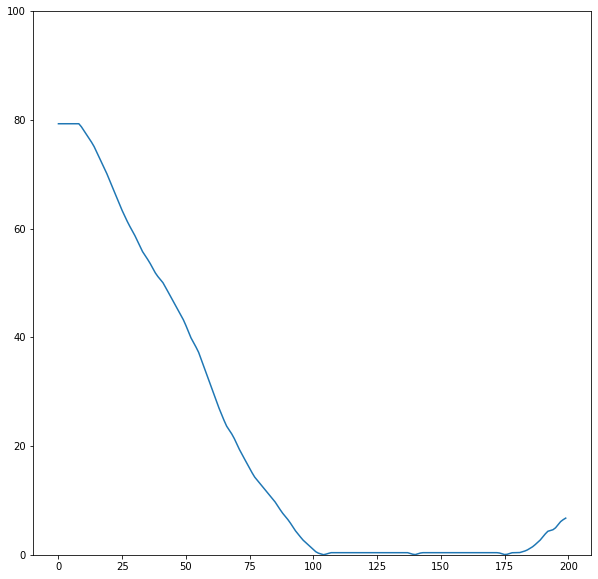

In [245]:
norm_ppg_seg = []
#plt.figure(figsize=(20,10))
for norm_ppg in norm_seg_ppg:
    fig = plt.figure(figsize=(10,10))
    plt.plot(norm_ppg)
    plt.ylim(0,100)
    norm_ppg_seg.extend(norm_ppg)

In [235]:
noise_info

[0.15384615384615385, 0.0]

## 평균 0 처리

In [81]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/preprocess2/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if not os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess2/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    train_cnt = 0

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                #pleth_inp2 = ppg_per_NRS[start_idx:end_idx]
                #pleth_inp2 -= np.nanmean(pleth_inp2)
                pleth_inp = pleth_inp - np.nanmean(pleth_inp)
                
                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                

                print(np.mean(pleth_inp), np.mean(ecg_inp))
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    continue
                    x_test_pacu.append([pleth_inp2, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    train_cnt += 1
                    if train_cnt==11:
                        
                    continue
                    x_train_pacu.append([pleth_inp2, ecg_inp2])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')



    


loading data 1/8294 ...5.729816621169448e-15 5.684341886080802e-18
3.637978807091713e-15 0.0
-1.8189894035458566e-16 -1.7053025658242403e-17
-9.094947017729283e-16 -2.2737367544323207e-17
4.18367562815547e-15 -3.4106051316484806e-17
1.2732925824820995e-15 2.842170943040401e-17
-1.6370904631912708e-15 1.7053025658242403e-17
2.0008883439004422e-15 0.0
3.637978807091713e-16 -6.821210263296961e-17
2.9103830456733705e-15 1.1368683772161604e-17
3.4560798667371273e-15 4.5474735088646414e-17
4.5474735088646414e-17 2.2737367544323207e-17
2.9558577807620166e-16 1.1368683772161604e-17
-4.934008757118136e-15 2.9842794901924206e-17
3.4560798667371273e-15 0.0
4.320099833421409e-16 2.1316282072803006e-17
-8.86757334228605e-16 -1.1368683772161604e-17
-8.640199666842818e-16 0.0
completed
loading data 2/8294 ...completed
loading data 3/8294 ...-4.092726157978177e-16 1.7053025658242403e-17
2.319211489520967e-15 -1.1368683772161604e-17
1.7053025658242404e-15 -5.684341886080802e-18
2.546585164964199e-15 -1

NameError: name 'abc' is not defined

In [78]:
plt.plot(np.array(x_train_pacu)[-1,1,:])

IndexError: too many indices for array

In [79]:
np.mean(ecg_inp), np.mean(ecg_inp2)#, np.mean(pleth_inp3)

(0.113255859375, 1.4210854715202004e-17)

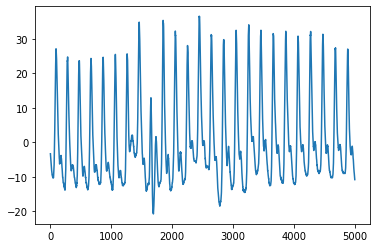

In [66]:
plt.plot(pleth_inp)
plt.show()

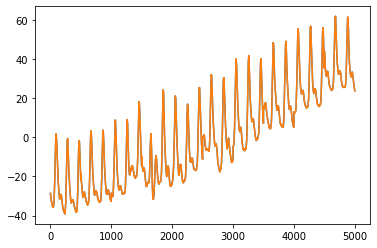

In [38]:
plt.plot(pleth_inp)
plt.plot(pleth_inp2)


In [75]:
np.mean(train1)

0.0

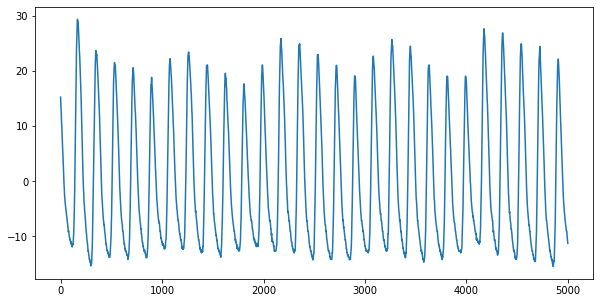

In [74]:
import matplotlib.pyplot as plt

train1 = np.array(x_train_pacu)[300,0,:]
#train1 -= np.nanmean(train1)

plt.figure(figsize=(10,5))
plt.plot(train1)
plt.show()

In [9]:
np.mean(np.array(x_train_pacu)[10,0,:])

-32.29827815444136

In [ ]:
x_train_pacu = np.array(x_train_pacu, np.float32)
x_test_pacu = np.array(x_test_pacu, np.float32)
y_train_pacu = np.array(y_train_pacu, int)
y_test_pacu = np.array(y_test_pacu, int)

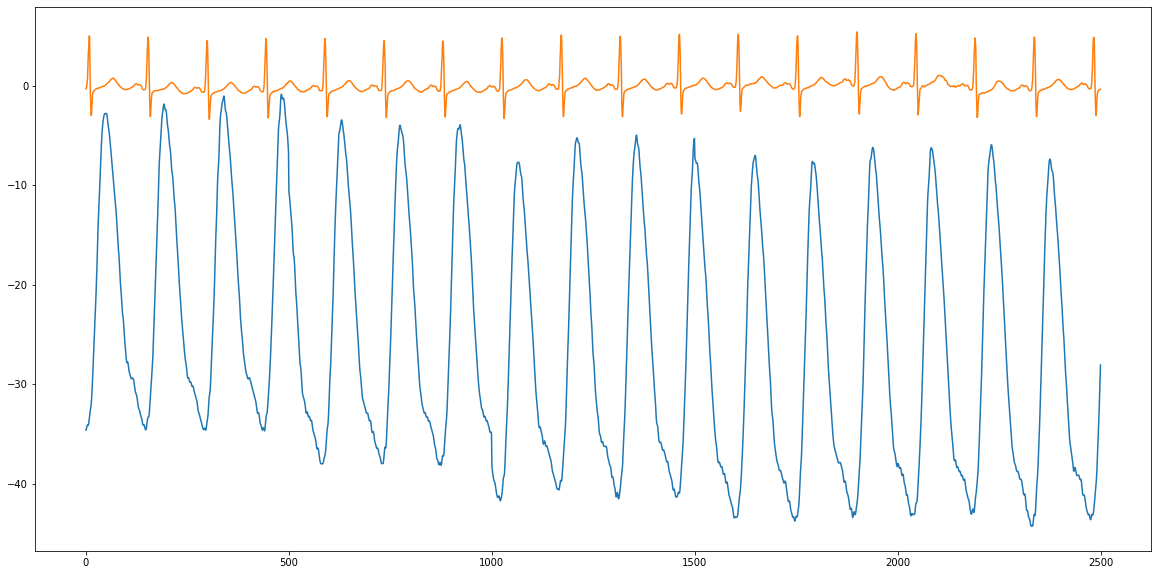

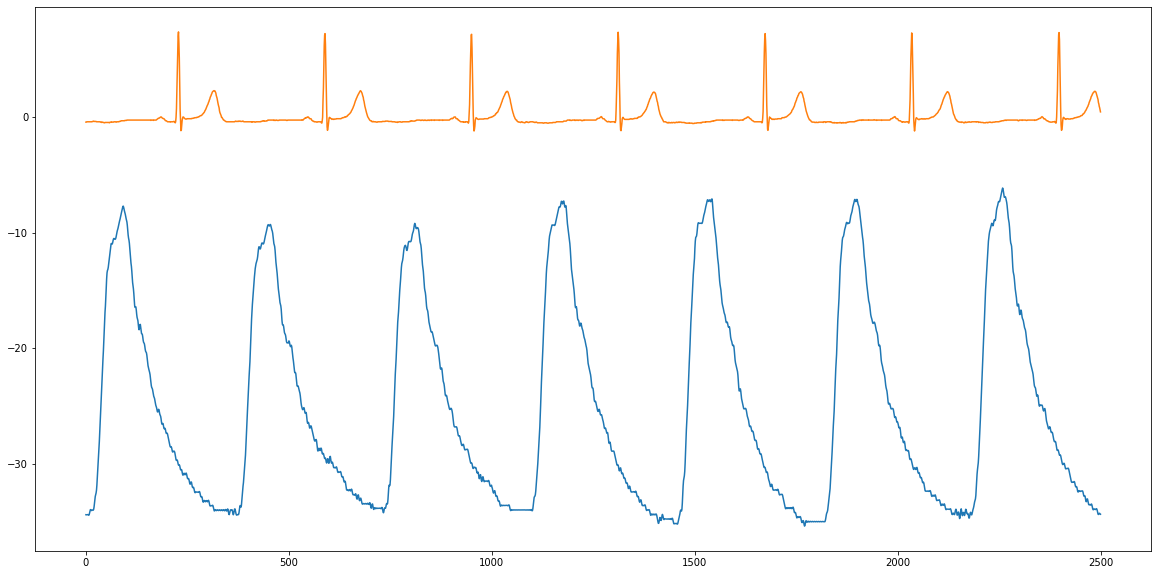

In [175]:
ran_n =  random.randint(1, len(x_train))
plt.figure(figsize=(20,10))
plt.plot(x_train[ran_n])


ran_n =  random.randint(1, len(x_test))
plt.figure(figsize=(20,10))
plt.plot(x_test[ran_n])